### Customer retention Analytics

##### Business Problem:
An International bank collected a sample data of 10,000 customers. They observed that some of their custimers are leaving or churning in an unusually high rate and they want to find understand and access why their customers keep leaving. They have hiered you as a data scientist to look into the data to give then some insight.

##### Data:
The data was collected within the last 5 months, the feautures include the customer's name, creditscore, geography, gendey,age,tenure,balnce, number of products(accounts),credit card status(whether they have one or not), estimated salary, activity status(active member or not) and if the customer remained with them.

#### Goal:
Your goal is to create a geodemographic segmentation  to identify which of the customers have the highest risk of leaving.

In [1]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

### Working on a banking dataset to detect churn activities

In [2]:
#importing the data
data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")

In [3]:
#viewing the data
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


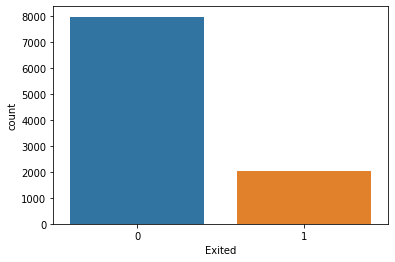

In [4]:
#frequency of the target classes
sns.countplot(x='Exited', data=data)

From the data we have more information on the customers that stayed at the bank

In [5]:
#checking for datatype of each column
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
#checking for missing values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
#dropping some columns that are not needed
data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
#viewing the unique values in Geography column
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
#data features
X = data.iloc[:,:-1]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [10]:
#target data
y = data.iloc[:,-1:]
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [11]:
#encoding the categorical columns
le = LabelEncoder()
ohe = OneHotEncoder()
X['Gender'] = le.fit_transform(X['Gender'])
geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

#getting feature name after onehotencoding
geo_df.columns = ohe.get_feature_names(['Geography'])

#merging geo_df with the main data
X = X.join(geo_df)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,France,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


In [12]:
#dropping the old columns after encoding
X.drop(columns=['Geography'], axis=1, inplace=True)
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


### Split Data

In [13]:
X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)

In [14]:
data_dict = {"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test}
for i in data_dict:
    print("The shape of {} is {}".format(i,data_dict[i].shape))

The shape of X_train is (8000, 12)
The shape of X_test is (2000, 12)
The shape of y_train is (8000, 1)
The shape of y_test is (2000, 1)


### Feature scaling

In [15]:
sc =StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\JADESOLA\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JADESOLA\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\JADESOLA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Deep learning model

In [17]:
#setting model hyper-parameters
EPOCHS = 150
BATCH_SIZE =10
LEARNING_RATE = 0.001

In [18]:
X_test.shape

(2000, 12)

#### Defining custom dataset

In [19]:
#train data
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self,index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))

In [20]:
#test data
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self,index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)

test_data = testData(torch.FloatTensor(X_test))

### Defining dataloader to read dataset class in batches

In [21]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=1)

### defining neural network architecture

In [22]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        #number of input features is 12
        self.layer_1 = nn.Linear(12, 16)
        self.layer_2 = nn.Linear(16, 8)
        self.layer_out = nn.Linear(8, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        
    #feed forward network
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
#initializing optimizer and loss
classifier = binaryClassification()
classifier.to(device)
print(classifier)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr = LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
#function to calculate accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    results_sum = (y_pred_tag == y_test).sum().float()
    acc = results_sum/y_test.shape[0]
    acc =torch.round(acc*100)
    return acc

In [26]:
#training the model
classifier.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #setting gradient to 0 per mini-batch
        optimizer.zero_grad()
        y_pred = classifier(X_batch)
        loss =criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss:0.00095 | Acc:0.037
Epoch 001: | Loss:0.00188 | Acc:0.100
Epoch 001: | Loss:0.00278 | Acc:0.175
Epoch 001: | Loss:0.00366 | Acc:0.250
Epoch 001: | Loss:0.00458 | Acc:0.300
Epoch 001: | Loss:0.00563 | Acc:0.350
Epoch 001: | Loss:0.00657 | Acc:0.425
Epoch 001: | Loss:0.00748 | Acc:0.475
Epoch 001: | Loss:0.00840 | Acc:0.525
Epoch 001: | Loss:0.00923 | Acc:0.600
Epoch 001: | Loss:0.01003 | Acc:0.688
Epoch 001: | Loss:0.01097 | Acc:0.750
Epoch 001: | Loss:0.01187 | Acc:0.825
Epoch 001: | Loss:0.01285 | Acc:0.875
Epoch 001: | Loss:0.01363 | Acc:0.938
Epoch 001: | Loss:0.01456 | Acc:1.000
Epoch 001: | Loss:0.01538 | Acc:1.087
Epoch 001: | Loss:0.01620 | Acc:1.163
Epoch 001: | Loss:0.01709 | Acc:1.238
Epoch 001: | Loss:0.01794 | Acc:1.325
Epoch 001: | Loss:0.01887 | Acc:1.387
Epoch 001: | Loss:0.01975 | Acc:1.462
Epoch 001: | Loss:0.02068 | Acc:1.525
Epoch 001: | Loss:0.02165 | Acc:1.575
Epoch 001: | Loss:0.02270 | Acc:1.637
Epoch 001: | Loss:0.02366 | Acc:1.712
Epoch 001: |

Epoch 001: | Loss:0.17089 | Acc:17.650
Epoch 001: | Loss:0.17160 | Acc:17.738
Epoch 001: | Loss:0.17221 | Acc:17.850
Epoch 001: | Loss:0.17311 | Acc:17.925
Epoch 001: | Loss:0.17388 | Acc:18.025
Epoch 001: | Loss:0.17458 | Acc:18.113
Epoch 001: | Loss:0.17530 | Acc:18.212
Epoch 001: | Loss:0.17587 | Acc:18.325
Epoch 001: | Loss:0.17653 | Acc:18.413
Epoch 001: | Loss:0.17724 | Acc:18.500
Epoch 001: | Loss:0.17818 | Acc:18.562
Epoch 001: | Loss:0.17885 | Acc:18.663
Epoch 001: | Loss:0.17949 | Acc:18.750
Epoch 001: | Loss:0.18018 | Acc:18.850
Epoch 001: | Loss:0.18089 | Acc:18.950
Epoch 001: | Loss:0.18158 | Acc:19.050
Epoch 001: | Loss:0.18242 | Acc:19.125
Epoch 001: | Loss:0.18335 | Acc:19.188
Epoch 001: | Loss:0.18416 | Acc:19.275
Epoch 001: | Loss:0.18493 | Acc:19.363
Epoch 001: | Loss:0.18565 | Acc:19.450
Epoch 001: | Loss:0.18650 | Acc:19.512
Epoch 001: | Loss:0.18720 | Acc:19.587
Epoch 001: | Loss:0.18784 | Acc:19.700
Epoch 001: | Loss:0.18856 | Acc:19.800
Epoch 001: | Loss:0.18943

Epoch 001: | Loss:0.31039 | Acc:37.950
Epoch 001: | Loss:0.31106 | Acc:38.050
Epoch 001: | Loss:0.31172 | Acc:38.150
Epoch 001: | Loss:0.31221 | Acc:38.263
Epoch 001: | Loss:0.31284 | Acc:38.350
Epoch 001: | Loss:0.31346 | Acc:38.450
Epoch 001: | Loss:0.31393 | Acc:38.562
Epoch 001: | Loss:0.31460 | Acc:38.638
Epoch 001: | Loss:0.31522 | Acc:38.737
Epoch 001: | Loss:0.31589 | Acc:38.837
Epoch 001: | Loss:0.31649 | Acc:38.938
Epoch 001: | Loss:0.31703 | Acc:39.038
Epoch 001: | Loss:0.31748 | Acc:39.150
Epoch 001: | Loss:0.31809 | Acc:39.250
Epoch 001: | Loss:0.31884 | Acc:39.337
Epoch 001: | Loss:0.31945 | Acc:39.450
Epoch 001: | Loss:0.31997 | Acc:39.550
Epoch 001: | Loss:0.32052 | Acc:39.638
Epoch 001: | Loss:0.32132 | Acc:39.725
Epoch 001: | Loss:0.32220 | Acc:39.788
Epoch 001: | Loss:0.32262 | Acc:39.913
Epoch 001: | Loss:0.32341 | Acc:40.000
Epoch 001: | Loss:0.32423 | Acc:40.075
Epoch 001: | Loss:0.32486 | Acc:40.175
Epoch 001: | Loss:0.32578 | Acc:40.250
Epoch 001: | Loss:0.32639

Epoch 001: | Loss:0.43857 | Acc:58.462
Epoch 001: | Loss:0.43915 | Acc:58.562
Epoch 001: | Loss:0.43957 | Acc:58.675
Epoch 001: | Loss:0.44003 | Acc:58.788
Epoch 001: | Loss:0.44045 | Acc:58.900
Epoch 001: | Loss:0.44083 | Acc:59.025
Epoch 001: | Loss:0.44131 | Acc:59.138
Epoch 001: | Loss:0.44192 | Acc:59.225
Epoch 001: | Loss:0.44241 | Acc:59.325
Epoch 001: | Loss:0.44284 | Acc:59.425
Epoch 001: | Loss:0.44329 | Acc:59.538
Epoch 001: | Loss:0.44387 | Acc:59.625
Epoch 001: | Loss:0.44445 | Acc:59.725
Epoch 001: | Loss:0.44495 | Acc:59.837
Epoch 001: | Loss:0.44534 | Acc:59.950
Epoch 001: | Loss:0.44609 | Acc:60.050
Epoch 001: | Loss:0.44706 | Acc:60.150
Epoch 001: | Loss:0.44752 | Acc:60.250
Epoch 001: | Loss:0.44815 | Acc:60.337
Epoch 001: | Loss:0.44911 | Acc:60.413
Epoch 001: | Loss:0.45014 | Acc:60.487
Epoch 001: | Loss:0.45065 | Acc:60.587
Epoch 001: | Loss:0.45106 | Acc:60.688
Epoch 001: | Loss:0.45167 | Acc:60.775
Epoch 001: | Loss:0.45203 | Acc:60.900
Epoch 001: | Loss:0.45287

Epoch 002: | Loss:0.02579 | Acc:4.475
Epoch 002: | Loss:0.02627 | Acc:4.575
Epoch 002: | Loss:0.02670 | Acc:4.688
Epoch 002: | Loss:0.02750 | Acc:4.750
Epoch 002: | Loss:0.02782 | Acc:4.875
Epoch 002: | Loss:0.02821 | Acc:4.975
Epoch 002: | Loss:0.02891 | Acc:5.075
Epoch 002: | Loss:0.02939 | Acc:5.175
Epoch 002: | Loss:0.02974 | Acc:5.300
Epoch 002: | Loss:0.03031 | Acc:5.412
Epoch 002: | Loss:0.03073 | Acc:5.513
Epoch 002: | Loss:0.03152 | Acc:5.612
Epoch 002: | Loss:0.03223 | Acc:5.713
Epoch 002: | Loss:0.03296 | Acc:5.787
Epoch 002: | Loss:0.03340 | Acc:5.900
Epoch 002: | Loss:0.03381 | Acc:6.000
Epoch 002: | Loss:0.03426 | Acc:6.112
Epoch 002: | Loss:0.03474 | Acc:6.213
Epoch 002: | Loss:0.03501 | Acc:6.325
Epoch 002: | Loss:0.03553 | Acc:6.438
Epoch 002: | Loss:0.03618 | Acc:6.525
Epoch 002: | Loss:0.03694 | Acc:6.600
Epoch 002: | Loss:0.03736 | Acc:6.713
Epoch 002: | Loss:0.03789 | Acc:6.812
Epoch 002: | Loss:0.03854 | Acc:6.912
Epoch 002: | Loss:0.03900 | Acc:7.025
Epoch 002: |

Epoch 002: | Loss:0.13838 | Acc:25.900
Epoch 002: | Loss:0.13910 | Acc:25.975
Epoch 002: | Loss:0.13955 | Acc:26.075
Epoch 002: | Loss:0.13993 | Acc:26.175
Epoch 002: | Loss:0.14056 | Acc:26.275
Epoch 002: | Loss:0.14120 | Acc:26.375
Epoch 002: | Loss:0.14173 | Acc:26.475
Epoch 002: | Loss:0.14233 | Acc:26.575
Epoch 002: | Loss:0.14288 | Acc:26.688
Epoch 002: | Loss:0.14313 | Acc:26.812
Epoch 002: | Loss:0.14368 | Acc:26.900
Epoch 002: | Loss:0.14433 | Acc:27.012
Epoch 002: | Loss:0.14545 | Acc:27.075
Epoch 002: | Loss:0.14612 | Acc:27.163
Epoch 002: | Loss:0.14663 | Acc:27.262
Epoch 002: | Loss:0.14691 | Acc:27.387
Epoch 002: | Loss:0.14755 | Acc:27.488
Epoch 002: | Loss:0.14825 | Acc:27.575
Epoch 002: | Loss:0.14917 | Acc:27.650
Epoch 002: | Loss:0.14956 | Acc:27.762
Epoch 002: | Loss:0.15031 | Acc:27.850
Epoch 002: | Loss:0.15078 | Acc:27.962
Epoch 002: | Loss:0.15128 | Acc:28.075
Epoch 002: | Loss:0.15193 | Acc:28.163
Epoch 002: | Loss:0.15236 | Acc:28.262
Epoch 002: | Loss:0.15260

Epoch 002: | Loss:0.25056 | Acc:47.263
Epoch 002: | Loss:0.25124 | Acc:47.350
Epoch 002: | Loss:0.25156 | Acc:47.462
Epoch 002: | Loss:0.25220 | Acc:47.550
Epoch 002: | Loss:0.25260 | Acc:47.663
Epoch 002: | Loss:0.25319 | Acc:47.763
Epoch 002: | Loss:0.25381 | Acc:47.862
Epoch 002: | Loss:0.25410 | Acc:47.987
Epoch 002: | Loss:0.25452 | Acc:48.087
Epoch 002: | Loss:0.25498 | Acc:48.188
Epoch 002: | Loss:0.25525 | Acc:48.312
Epoch 002: | Loss:0.25596 | Acc:48.413
Epoch 002: | Loss:0.25634 | Acc:48.513
Epoch 002: | Loss:0.25664 | Acc:48.638
Epoch 002: | Loss:0.25739 | Acc:48.737
Epoch 002: | Loss:0.25787 | Acc:48.850
Epoch 002: | Loss:0.25828 | Acc:48.962
Epoch 002: | Loss:0.25890 | Acc:49.062
Epoch 002: | Loss:0.25932 | Acc:49.163
Epoch 002: | Loss:0.25979 | Acc:49.263
Epoch 002: | Loss:0.26045 | Acc:49.350
Epoch 002: | Loss:0.26078 | Acc:49.462
Epoch 002: | Loss:0.26131 | Acc:49.550
Epoch 002: | Loss:0.26169 | Acc:49.650
Epoch 002: | Loss:0.26204 | Acc:49.775
Epoch 002: | Loss:0.26267

Epoch 002: | Loss:0.35647 | Acc:68.950
Epoch 002: | Loss:0.35696 | Acc:69.050
Epoch 002: | Loss:0.35755 | Acc:69.150
Epoch 002: | Loss:0.35789 | Acc:69.263
Epoch 002: | Loss:0.35851 | Acc:69.350
Epoch 002: | Loss:0.35920 | Acc:69.438
Epoch 002: | Loss:0.35953 | Acc:69.550
Epoch 002: | Loss:0.36011 | Acc:69.650
Epoch 002: | Loss:0.36048 | Acc:69.763
Epoch 002: | Loss:0.36127 | Acc:69.838
Epoch 002: | Loss:0.36198 | Acc:69.925
Epoch 002: | Loss:0.36277 | Acc:70.025
Epoch 002: | Loss:0.36344 | Acc:70.125
Epoch 002: | Loss:0.36390 | Acc:70.237
Epoch 002: | Loss:0.36427 | Acc:70.362
Epoch 002: | Loss:0.36464 | Acc:70.475
Epoch 002: | Loss:0.36496 | Acc:70.588
Epoch 002: | Loss:0.36545 | Acc:70.688
Epoch 002: | Loss:0.36605 | Acc:70.763
Epoch 002: | Loss:0.36640 | Acc:70.875
Epoch 002: | Loss:0.36666 | Acc:71.000
Epoch 002: | Loss:0.36748 | Acc:71.075
Epoch 002: | Loss:0.36782 | Acc:71.175
Epoch 002: | Loss:0.36843 | Acc:71.287
Epoch 002: | Loss:0.36930 | Acc:71.388
Epoch 002: | Loss:0.37003

Epoch 003: | Loss:0.04895 | Acc:8.800
Epoch 003: | Loss:0.04950 | Acc:8.912
Epoch 003: | Loss:0.04981 | Acc:9.025
Epoch 003: | Loss:0.05028 | Acc:9.137
Epoch 003: | Loss:0.05097 | Acc:9.238
Epoch 003: | Loss:0.05142 | Acc:9.325
Epoch 003: | Loss:0.05174 | Acc:9.438
Epoch 003: | Loss:0.05205 | Acc:9.550
Epoch 003: | Loss:0.05267 | Acc:9.637
Epoch 003: | Loss:0.05310 | Acc:9.738
Epoch 003: | Loss:0.05364 | Acc:9.825
Epoch 003: | Loss:0.05404 | Acc:9.925
Epoch 003: | Loss:0.05450 | Acc:10.025
Epoch 003: | Loss:0.05483 | Acc:10.137
Epoch 003: | Loss:0.05507 | Acc:10.262
Epoch 003: | Loss:0.05539 | Acc:10.375
Epoch 003: | Loss:0.05568 | Acc:10.500
Epoch 003: | Loss:0.05603 | Acc:10.613
Epoch 003: | Loss:0.05669 | Acc:10.700
Epoch 003: | Loss:0.05715 | Acc:10.800
Epoch 003: | Loss:0.05834 | Acc:10.850
Epoch 003: | Loss:0.05907 | Acc:10.938
Epoch 003: | Loss:0.05957 | Acc:11.037
Epoch 003: | Loss:0.06005 | Acc:11.137
Epoch 003: | Loss:0.06040 | Acc:11.250
Epoch 003: | Loss:0.06069 | Acc:11.36

Epoch 003: | Loss:0.15299 | Acc:30.562
Epoch 003: | Loss:0.15346 | Acc:30.663
Epoch 003: | Loss:0.15376 | Acc:30.775
Epoch 003: | Loss:0.15416 | Acc:30.863
Epoch 003: | Loss:0.15448 | Acc:30.988
Epoch 003: | Loss:0.15500 | Acc:31.087
Epoch 003: | Loss:0.15572 | Acc:31.175
Epoch 003: | Loss:0.15636 | Acc:31.275
Epoch 003: | Loss:0.15670 | Acc:31.387
Epoch 003: | Loss:0.15702 | Acc:31.512
Epoch 003: | Loss:0.15751 | Acc:31.625
Epoch 003: | Loss:0.15851 | Acc:31.700
Epoch 003: | Loss:0.15925 | Acc:31.788
Epoch 003: | Loss:0.15962 | Acc:31.887
Epoch 003: | Loss:0.16032 | Acc:31.988
Epoch 003: | Loss:0.16079 | Acc:32.100
Epoch 003: | Loss:0.16102 | Acc:32.225
Epoch 003: | Loss:0.16144 | Acc:32.337
Epoch 003: | Loss:0.16179 | Acc:32.450
Epoch 003: | Loss:0.16229 | Acc:32.550
Epoch 003: | Loss:0.16279 | Acc:32.650
Epoch 003: | Loss:0.16356 | Acc:32.725
Epoch 003: | Loss:0.16423 | Acc:32.825
Epoch 003: | Loss:0.16466 | Acc:32.925
Epoch 003: | Loss:0.16526 | Acc:33.025
Epoch 003: | Loss:0.16596

Epoch 003: | Loss:0.26219 | Acc:52.087
Epoch 003: | Loss:0.26274 | Acc:52.188
Epoch 003: | Loss:0.26310 | Acc:52.300
Epoch 003: | Loss:0.26342 | Acc:52.413
Epoch 003: | Loss:0.26390 | Acc:52.525
Epoch 003: | Loss:0.26440 | Acc:52.625
Epoch 003: | Loss:0.26501 | Acc:52.725
Epoch 003: | Loss:0.26538 | Acc:52.825
Epoch 003: | Loss:0.26569 | Acc:52.925
Epoch 003: | Loss:0.26594 | Acc:53.050
Epoch 003: | Loss:0.26633 | Acc:53.163
Epoch 003: | Loss:0.26700 | Acc:53.250
Epoch 003: | Loss:0.26733 | Acc:53.362
Epoch 003: | Loss:0.26761 | Acc:53.475
Epoch 003: | Loss:0.26788 | Acc:53.587
Epoch 003: | Loss:0.26815 | Acc:53.712
Epoch 003: | Loss:0.26870 | Acc:53.800
Epoch 003: | Loss:0.26913 | Acc:53.913
Epoch 003: | Loss:0.26948 | Acc:54.025
Epoch 003: | Loss:0.27006 | Acc:54.125
Epoch 003: | Loss:0.27048 | Acc:54.237
Epoch 003: | Loss:0.27089 | Acc:54.337
Epoch 003: | Loss:0.27124 | Acc:54.450
Epoch 003: | Loss:0.27188 | Acc:54.538
Epoch 003: | Loss:0.27236 | Acc:54.625
Epoch 003: | Loss:0.27290

Epoch 003: | Loss:0.36320 | Acc:74.138
Epoch 003: | Loss:0.36381 | Acc:74.237
Epoch 003: | Loss:0.36447 | Acc:74.338
Epoch 003: | Loss:0.36488 | Acc:74.438
Epoch 003: | Loss:0.36511 | Acc:74.562
Epoch 003: | Loss:0.36544 | Acc:74.675
Epoch 003: | Loss:0.36593 | Acc:74.763
Epoch 003: | Loss:0.36622 | Acc:74.888
Epoch 003: | Loss:0.36646 | Acc:75.013
Epoch 003: | Loss:0.36703 | Acc:75.100
Epoch 003: | Loss:0.36751 | Acc:75.213
Epoch 003: | Loss:0.36791 | Acc:75.312
Epoch 003: | Loss:0.36836 | Acc:75.400
Epoch 003: | Loss:0.36860 | Acc:75.525
Epoch 003: | Loss:0.36912 | Acc:75.625
Epoch 003: | Loss:0.36955 | Acc:75.725
Epoch 003: | Loss:0.37030 | Acc:75.812
Epoch 003: | Loss:0.37082 | Acc:75.912
Epoch 003: | Loss:0.37167 | Acc:76.000
Epoch 003: | Loss:0.37194 | Acc:76.125
Epoch 003: | Loss:0.37254 | Acc:76.225
Epoch 003: | Loss:0.37275 | Acc:76.350
Epoch 003: | Loss:0.37332 | Acc:76.463
Epoch 003: | Loss:0.37374 | Acc:76.575
Epoch 003: | Loss:0.37422 | Acc:76.662
Epoch 003: | Loss:0.37485

Epoch 004: | Loss:0.06443 | Acc:13.562
Epoch 004: | Loss:0.06486 | Acc:13.662
Epoch 004: | Loss:0.06525 | Acc:13.775
Epoch 004: | Loss:0.06602 | Acc:13.863
Epoch 004: | Loss:0.06681 | Acc:13.950
Epoch 004: | Loss:0.06750 | Acc:14.050
Epoch 004: | Loss:0.06772 | Acc:14.175
Epoch 004: | Loss:0.06787 | Acc:14.300
Epoch 004: | Loss:0.06813 | Acc:14.425
Epoch 004: | Loss:0.06842 | Acc:14.550
Epoch 004: | Loss:0.06941 | Acc:14.625
Epoch 004: | Loss:0.06982 | Acc:14.725
Epoch 004: | Loss:0.07014 | Acc:14.838
Epoch 004: | Loss:0.07036 | Acc:14.963
Epoch 004: | Loss:0.07120 | Acc:15.050
Epoch 004: | Loss:0.07147 | Acc:15.175
Epoch 004: | Loss:0.07179 | Acc:15.287
Epoch 004: | Loss:0.07211 | Acc:15.387
Epoch 004: | Loss:0.07302 | Acc:15.475
Epoch 004: | Loss:0.07351 | Acc:15.575
Epoch 004: | Loss:0.07397 | Acc:15.688
Epoch 004: | Loss:0.07415 | Acc:15.812
Epoch 004: | Loss:0.07492 | Acc:15.900
Epoch 004: | Loss:0.07551 | Acc:16.000
Epoch 004: | Loss:0.07574 | Acc:16.125
Epoch 004: | Loss:0.07617

Epoch 004: | Loss:0.17240 | Acc:35.300
Epoch 004: | Loss:0.17271 | Acc:35.413
Epoch 004: | Loss:0.17301 | Acc:35.525
Epoch 004: | Loss:0.17335 | Acc:35.638
Epoch 004: | Loss:0.17394 | Acc:35.737
Epoch 004: | Loss:0.17501 | Acc:35.825
Epoch 004: | Loss:0.17592 | Acc:35.900
Epoch 004: | Loss:0.17637 | Acc:35.987
Epoch 004: | Loss:0.17670 | Acc:36.100
Epoch 004: | Loss:0.17754 | Acc:36.188
Epoch 004: | Loss:0.17787 | Acc:36.300
Epoch 004: | Loss:0.17848 | Acc:36.400
Epoch 004: | Loss:0.17885 | Acc:36.513
Epoch 004: | Loss:0.17913 | Acc:36.625
Epoch 004: | Loss:0.17960 | Acc:36.725
Epoch 004: | Loss:0.18021 | Acc:36.825
Epoch 004: | Loss:0.18077 | Acc:36.913
Epoch 004: | Loss:0.18103 | Acc:37.038
Epoch 004: | Loss:0.18149 | Acc:37.138
Epoch 004: | Loss:0.18181 | Acc:37.250
Epoch 004: | Loss:0.18210 | Acc:37.362
Epoch 004: | Loss:0.18255 | Acc:37.450
Epoch 004: | Loss:0.18304 | Acc:37.562
Epoch 004: | Loss:0.18336 | Acc:37.675
Epoch 004: | Loss:0.18397 | Acc:37.788
Epoch 004: | Loss:0.18432

Epoch 004: | Loss:0.27535 | Acc:57.300
Epoch 004: | Loss:0.27590 | Acc:57.400
Epoch 004: | Loss:0.27612 | Acc:57.525
Epoch 004: | Loss:0.27654 | Acc:57.625
Epoch 004: | Loss:0.27706 | Acc:57.737
Epoch 004: | Loss:0.27748 | Acc:57.850
Epoch 004: | Loss:0.27791 | Acc:57.962
Epoch 004: | Loss:0.27835 | Acc:58.062
Epoch 004: | Loss:0.27868 | Acc:58.175
Epoch 004: | Loss:0.27908 | Acc:58.275
Epoch 004: | Loss:0.27935 | Acc:58.400
Epoch 004: | Loss:0.27972 | Acc:58.500
Epoch 004: | Loss:0.28053 | Acc:58.575
Epoch 004: | Loss:0.28108 | Acc:58.675
Epoch 004: | Loss:0.28184 | Acc:58.763
Epoch 004: | Loss:0.28212 | Acc:58.888
Epoch 004: | Loss:0.28296 | Acc:58.950
Epoch 004: | Loss:0.28338 | Acc:59.062
Epoch 004: | Loss:0.28354 | Acc:59.188
Epoch 004: | Loss:0.28383 | Acc:59.312
Epoch 004: | Loss:0.28410 | Acc:59.425
Epoch 004: | Loss:0.28458 | Acc:59.538
Epoch 004: | Loss:0.28488 | Acc:59.650
Epoch 004: | Loss:0.28521 | Acc:59.763
Epoch 004: | Loss:0.28561 | Acc:59.850
Epoch 004: | Loss:0.28606

Epoch 004: | Loss:0.37666 | Acc:79.062
Epoch 004: | Loss:0.37693 | Acc:79.188
Epoch 004: | Loss:0.37721 | Acc:79.312
Epoch 004: | Loss:0.37738 | Acc:79.438
Epoch 004: | Loss:0.37765 | Acc:79.550
Epoch 004: | Loss:0.37804 | Acc:79.662
Epoch 004: | Loss:0.37894 | Acc:79.725
Epoch 004: | Loss:0.37958 | Acc:79.825
Epoch 004: | Loss:0.37984 | Acc:79.938
Epoch 004: | Loss:0.38007 | Acc:80.050
Epoch 004: | Loss:0.38033 | Acc:80.175
Epoch 004: | Loss:0.38083 | Acc:80.263
Epoch 004: | Loss:0.38103 | Acc:80.388
Epoch 004: | Loss:0.38170 | Acc:80.487
Epoch 004: | Loss:0.38214 | Acc:80.588
Epoch 004: | Loss:0.38252 | Acc:80.700
Epoch 004: | Loss:0.38298 | Acc:80.812
Epoch 004: | Loss:0.38412 | Acc:80.888
Epoch 004: | Loss:0.38481 | Acc:80.963
Epoch 004: | Loss:0.38525 | Acc:81.062
Epoch 004: | Loss:0.38607 | Acc:81.138
Epoch 004: | Loss:0.38665 | Acc:81.237
Epoch 004: | Loss:0.38761 | Acc:81.312
Epoch 004: | Loss:0.38810 | Acc:81.412
Epoch 004: | Loss:0.38853 | Acc:81.525
Epoch 004: | Loss:0.38877

Epoch 005: | Loss:0.08424 | Acc:17.925
Epoch 005: | Loss:0.08461 | Acc:18.038
Epoch 005: | Loss:0.08524 | Acc:18.125
Epoch 005: | Loss:0.08544 | Acc:18.250
Epoch 005: | Loss:0.08610 | Acc:18.350
Epoch 005: | Loss:0.08688 | Acc:18.462
Epoch 005: | Loss:0.08773 | Acc:18.538
Epoch 005: | Loss:0.08798 | Acc:18.663
Epoch 005: | Loss:0.08822 | Acc:18.775
Epoch 005: | Loss:0.08851 | Acc:18.887
Epoch 005: | Loss:0.08901 | Acc:18.988
Epoch 005: | Loss:0.08960 | Acc:19.100
Epoch 005: | Loss:0.08980 | Acc:19.225
Epoch 005: | Loss:0.09009 | Acc:19.350
Epoch 005: | Loss:0.09061 | Acc:19.450
Epoch 005: | Loss:0.09138 | Acc:19.538
Epoch 005: | Loss:0.09161 | Acc:19.663
Epoch 005: | Loss:0.09249 | Acc:19.750
Epoch 005: | Loss:0.09306 | Acc:19.850
Epoch 005: | Loss:0.09400 | Acc:19.913
Epoch 005: | Loss:0.09448 | Acc:19.988
Epoch 005: | Loss:0.09470 | Acc:20.100
Epoch 005: | Loss:0.09553 | Acc:20.188
Epoch 005: | Loss:0.09587 | Acc:20.288
Epoch 005: | Loss:0.09630 | Acc:20.375
Epoch 005: | Loss:0.09652

Epoch 005: | Loss:0.18517 | Acc:39.737
Epoch 005: | Loss:0.18591 | Acc:39.837
Epoch 005: | Loss:0.18656 | Acc:39.938
Epoch 005: | Loss:0.18710 | Acc:40.050
Epoch 005: | Loss:0.18740 | Acc:40.163
Epoch 005: | Loss:0.18798 | Acc:40.263
Epoch 005: | Loss:0.18818 | Acc:40.388
Epoch 005: | Loss:0.18868 | Acc:40.487
Epoch 005: | Loss:0.18946 | Acc:40.562
Epoch 005: | Loss:0.19005 | Acc:40.675
Epoch 005: | Loss:0.19044 | Acc:40.775
Epoch 005: | Loss:0.19072 | Acc:40.888
Epoch 005: | Loss:0.19118 | Acc:41.000
Epoch 005: | Loss:0.19211 | Acc:41.075
Epoch 005: | Loss:0.19228 | Acc:41.200
Epoch 005: | Loss:0.19287 | Acc:41.312
Epoch 005: | Loss:0.19354 | Acc:41.400
Epoch 005: | Loss:0.19458 | Acc:41.475
Epoch 005: | Loss:0.19527 | Acc:41.575
Epoch 005: | Loss:0.19550 | Acc:41.688
Epoch 005: | Loss:0.19588 | Acc:41.788
Epoch 005: | Loss:0.19607 | Acc:41.913
Epoch 005: | Loss:0.19686 | Acc:42.013
Epoch 005: | Loss:0.19710 | Acc:42.138
Epoch 005: | Loss:0.19794 | Acc:42.225
Epoch 005: | Loss:0.19857

Epoch 005: | Loss:0.28610 | Acc:61.938
Epoch 005: | Loss:0.28655 | Acc:62.038
Epoch 005: | Loss:0.28697 | Acc:62.150
Epoch 005: | Loss:0.28740 | Acc:62.250
Epoch 005: | Loss:0.28769 | Acc:62.362
Epoch 005: | Loss:0.28844 | Acc:62.462
Epoch 005: | Loss:0.28950 | Acc:62.538
Epoch 005: | Loss:0.29036 | Acc:62.638
Epoch 005: | Loss:0.29064 | Acc:62.763
Epoch 005: | Loss:0.29123 | Acc:62.862
Epoch 005: | Loss:0.29157 | Acc:62.962
Epoch 005: | Loss:0.29221 | Acc:63.062
Epoch 005: | Loss:0.29254 | Acc:63.175
Epoch 005: | Loss:0.29282 | Acc:63.300
Epoch 005: | Loss:0.29364 | Acc:63.388
Epoch 005: | Loss:0.29402 | Acc:63.487
Epoch 005: | Loss:0.29466 | Acc:63.600
Epoch 005: | Loss:0.29493 | Acc:63.712
Epoch 005: | Loss:0.29530 | Acc:63.812
Epoch 005: | Loss:0.29581 | Acc:63.900
Epoch 005: | Loss:0.29638 | Acc:64.000
Epoch 005: | Loss:0.29661 | Acc:64.112
Epoch 005: | Loss:0.29688 | Acc:64.225
Epoch 005: | Loss:0.29759 | Acc:64.325
Epoch 005: | Loss:0.29799 | Acc:64.438
Epoch 005: | Loss:0.29820

Epoch 006: | Loss:0.00052 | Acc:0.237
Epoch 006: | Loss:0.00116 | Acc:0.312
Epoch 006: | Loss:0.00188 | Acc:0.412
Epoch 006: | Loss:0.00237 | Acc:0.525
Epoch 006: | Loss:0.00326 | Acc:0.588
Epoch 006: | Loss:0.00394 | Acc:0.675
Epoch 006: | Loss:0.00425 | Acc:0.787
Epoch 006: | Loss:0.00474 | Acc:0.887
Epoch 006: | Loss:0.00500 | Acc:1.012
Epoch 006: | Loss:0.00578 | Acc:1.113
Epoch 006: | Loss:0.00617 | Acc:1.212
Epoch 006: | Loss:0.00686 | Acc:1.312
Epoch 006: | Loss:0.00758 | Acc:1.400
Epoch 006: | Loss:0.00808 | Acc:1.512
Epoch 006: | Loss:0.00886 | Acc:1.600
Epoch 006: | Loss:0.00948 | Acc:1.700
Epoch 006: | Loss:0.00970 | Acc:1.825
Epoch 006: | Loss:0.01001 | Acc:1.938
Epoch 006: | Loss:0.01022 | Acc:2.062
Epoch 006: | Loss:0.01085 | Acc:2.150
Epoch 006: | Loss:0.01117 | Acc:2.250
Epoch 006: | Loss:0.01160 | Acc:2.350
Epoch 006: | Loss:0.01182 | Acc:2.475
Epoch 006: | Loss:0.01259 | Acc:2.562
Epoch 006: | Loss:0.01308 | Acc:2.675
Epoch 006: | Loss:0.01332 | Acc:2.788
Epoch 006: |

Epoch 006: | Loss:0.10546 | Acc:22.137
Epoch 006: | Loss:0.10594 | Acc:22.250
Epoch 006: | Loss:0.10621 | Acc:22.375
Epoch 006: | Loss:0.10660 | Acc:22.488
Epoch 006: | Loss:0.10689 | Acc:22.600
Epoch 006: | Loss:0.10724 | Acc:22.700
Epoch 006: | Loss:0.10750 | Acc:22.812
Epoch 006: | Loss:0.10798 | Acc:22.900
Epoch 006: | Loss:0.10897 | Acc:22.962
Epoch 006: | Loss:0.11043 | Acc:23.025
Epoch 006: | Loss:0.11110 | Acc:23.100
Epoch 006: | Loss:0.11131 | Acc:23.225
Epoch 006: | Loss:0.11163 | Acc:23.350
Epoch 006: | Loss:0.11200 | Acc:23.450
Epoch 006: | Loss:0.11228 | Acc:23.575
Epoch 006: | Loss:0.11264 | Acc:23.688
Epoch 006: | Loss:0.11310 | Acc:23.800
Epoch 006: | Loss:0.11347 | Acc:23.900
Epoch 006: | Loss:0.11448 | Acc:23.975
Epoch 006: | Loss:0.11492 | Acc:24.087
Epoch 006: | Loss:0.11527 | Acc:24.200
Epoch 006: | Loss:0.11557 | Acc:24.325
Epoch 006: | Loss:0.11609 | Acc:24.425
Epoch 006: | Loss:0.11714 | Acc:24.512
Epoch 006: | Loss:0.11760 | Acc:24.625
Epoch 006: | Loss:0.11821

Epoch 006: | Loss:0.20398 | Acc:44.263
Epoch 006: | Loss:0.20456 | Acc:44.362
Epoch 006: | Loss:0.20516 | Acc:44.450
Epoch 006: | Loss:0.20607 | Acc:44.538
Epoch 006: | Loss:0.20706 | Acc:44.612
Epoch 006: | Loss:0.20751 | Acc:44.712
Epoch 006: | Loss:0.20853 | Acc:44.775
Epoch 006: | Loss:0.20909 | Acc:44.875
Epoch 006: | Loss:0.20967 | Acc:44.975
Epoch 006: | Loss:0.21007 | Acc:45.087
Epoch 006: | Loss:0.21043 | Acc:45.200
Epoch 006: | Loss:0.21078 | Acc:45.312
Epoch 006: | Loss:0.21118 | Acc:45.413
Epoch 006: | Loss:0.21156 | Acc:45.525
Epoch 006: | Loss:0.21258 | Acc:45.612
Epoch 006: | Loss:0.21297 | Acc:45.712
Epoch 006: | Loss:0.21339 | Acc:45.812
Epoch 006: | Loss:0.21389 | Acc:45.925
Epoch 006: | Loss:0.21446 | Acc:46.013
Epoch 006: | Loss:0.21548 | Acc:46.075
Epoch 006: | Loss:0.21593 | Acc:46.175
Epoch 006: | Loss:0.21657 | Acc:46.263
Epoch 006: | Loss:0.21698 | Acc:46.362
Epoch 006: | Loss:0.21724 | Acc:46.475
Epoch 006: | Loss:0.21758 | Acc:46.587
Epoch 006: | Loss:0.21834

Epoch 006: | Loss:0.30540 | Acc:66.025
Epoch 006: | Loss:0.30572 | Acc:66.138
Epoch 006: | Loss:0.30643 | Acc:66.225
Epoch 006: | Loss:0.30702 | Acc:66.325
Epoch 006: | Loss:0.30730 | Acc:66.438
Epoch 006: | Loss:0.30864 | Acc:66.500
Epoch 006: | Loss:0.30924 | Acc:66.588
Epoch 006: | Loss:0.30982 | Acc:66.688
Epoch 006: | Loss:0.30998 | Acc:66.812
Epoch 006: | Loss:0.31073 | Acc:66.912
Epoch 006: | Loss:0.31109 | Acc:67.025
Epoch 006: | Loss:0.31140 | Acc:67.138
Epoch 006: | Loss:0.31168 | Acc:67.263
Epoch 006: | Loss:0.31198 | Acc:67.375
Epoch 006: | Loss:0.31228 | Acc:67.487
Epoch 006: | Loss:0.31315 | Acc:67.575
Epoch 006: | Loss:0.31385 | Acc:67.675
Epoch 006: | Loss:0.31430 | Acc:67.787
Epoch 006: | Loss:0.31524 | Acc:67.875
Epoch 006: | Loss:0.31561 | Acc:67.987
Epoch 006: | Loss:0.31652 | Acc:68.075
Epoch 006: | Loss:0.31732 | Acc:68.150
Epoch 006: | Loss:0.31811 | Acc:68.250
Epoch 006: | Loss:0.31828 | Acc:68.375
Epoch 006: | Loss:0.31861 | Acc:68.487
Epoch 006: | Loss:0.31925

Epoch 007: | Loss:0.02003 | Acc:4.725
Epoch 007: | Loss:0.02045 | Acc:4.838
Epoch 007: | Loss:0.02080 | Acc:4.950
Epoch 007: | Loss:0.02113 | Acc:5.062
Epoch 007: | Loss:0.02159 | Acc:5.175
Epoch 007: | Loss:0.02202 | Acc:5.275
Epoch 007: | Loss:0.02231 | Acc:5.388
Epoch 007: | Loss:0.02271 | Acc:5.500
Epoch 007: | Loss:0.02320 | Acc:5.588
Epoch 007: | Loss:0.02364 | Acc:5.700
Epoch 007: | Loss:0.02392 | Acc:5.812
Epoch 007: | Loss:0.02427 | Acc:5.912
Epoch 007: | Loss:0.02511 | Acc:5.987
Epoch 007: | Loss:0.02556 | Acc:6.088
Epoch 007: | Loss:0.02593 | Acc:6.200
Epoch 007: | Loss:0.02629 | Acc:6.300
Epoch 007: | Loss:0.02663 | Acc:6.412
Epoch 007: | Loss:0.02715 | Acc:6.513
Epoch 007: | Loss:0.02746 | Acc:6.625
Epoch 007: | Loss:0.02775 | Acc:6.737
Epoch 007: | Loss:0.02847 | Acc:6.838
Epoch 007: | Loss:0.02933 | Acc:6.912
Epoch 007: | Loss:0.02999 | Acc:7.013
Epoch 007: | Loss:0.03038 | Acc:7.112
Epoch 007: | Loss:0.03072 | Acc:7.225
Epoch 007: | Loss:0.03114 | Acc:7.325
Epoch 007: |

Epoch 007: | Loss:0.12035 | Acc:26.825
Epoch 007: | Loss:0.12109 | Acc:26.913
Epoch 007: | Loss:0.12185 | Acc:26.988
Epoch 007: | Loss:0.12208 | Acc:27.100
Epoch 007: | Loss:0.12269 | Acc:27.200
Epoch 007: | Loss:0.12369 | Acc:27.275
Epoch 007: | Loss:0.12410 | Acc:27.375
Epoch 007: | Loss:0.12452 | Acc:27.488
Epoch 007: | Loss:0.12481 | Acc:27.613
Epoch 007: | Loss:0.12542 | Acc:27.725
Epoch 007: | Loss:0.12577 | Acc:27.837
Epoch 007: | Loss:0.12647 | Acc:27.913
Epoch 007: | Loss:0.12726 | Acc:28.025
Epoch 007: | Loss:0.12823 | Acc:28.113
Epoch 007: | Loss:0.12931 | Acc:28.200
Epoch 007: | Loss:0.12988 | Acc:28.312
Epoch 007: | Loss:0.13022 | Acc:28.425
Epoch 007: | Loss:0.13045 | Acc:28.538
Epoch 007: | Loss:0.13079 | Acc:28.650
Epoch 007: | Loss:0.13126 | Acc:28.750
Epoch 007: | Loss:0.13191 | Acc:28.837
Epoch 007: | Loss:0.13219 | Acc:28.962
Epoch 007: | Loss:0.13260 | Acc:29.062
Epoch 007: | Loss:0.13291 | Acc:29.175
Epoch 007: | Loss:0.13315 | Acc:29.300
Epoch 007: | Loss:0.13369

Epoch 007: | Loss:0.22328 | Acc:48.775
Epoch 007: | Loss:0.22403 | Acc:48.850
Epoch 007: | Loss:0.22479 | Acc:48.950
Epoch 007: | Loss:0.22621 | Acc:49.000
Epoch 007: | Loss:0.22660 | Acc:49.112
Epoch 007: | Loss:0.22691 | Acc:49.225
Epoch 007: | Loss:0.22740 | Acc:49.325
Epoch 007: | Loss:0.22768 | Acc:49.438
Epoch 007: | Loss:0.22801 | Acc:49.538
Epoch 007: | Loss:0.22824 | Acc:49.663
Epoch 007: | Loss:0.22856 | Acc:49.775
Epoch 007: | Loss:0.22891 | Acc:49.888
Epoch 007: | Loss:0.22987 | Acc:49.975
Epoch 007: | Loss:0.23027 | Acc:50.087
Epoch 007: | Loss:0.23082 | Acc:50.188
Epoch 007: | Loss:0.23129 | Acc:50.288
Epoch 007: | Loss:0.23164 | Acc:50.400
Epoch 007: | Loss:0.23204 | Acc:50.513
Epoch 007: | Loss:0.23249 | Acc:50.612
Epoch 007: | Loss:0.23294 | Acc:50.712
Epoch 007: | Loss:0.23371 | Acc:50.812
Epoch 007: | Loss:0.23399 | Acc:50.938
Epoch 007: | Loss:0.23450 | Acc:51.038
Epoch 007: | Loss:0.23488 | Acc:51.150
Epoch 007: | Loss:0.23509 | Acc:51.275
Epoch 007: | Loss:0.23548

Epoch 007: | Loss:0.32228 | Acc:70.875
Epoch 007: | Loss:0.32264 | Acc:70.987
Epoch 007: | Loss:0.32307 | Acc:71.100
Epoch 007: | Loss:0.32371 | Acc:71.188
Epoch 007: | Loss:0.32391 | Acc:71.312
Epoch 007: | Loss:0.32480 | Acc:71.412
Epoch 007: | Loss:0.32501 | Acc:71.537
Epoch 007: | Loss:0.32550 | Acc:71.650
Epoch 007: | Loss:0.32610 | Acc:71.750
Epoch 007: | Loss:0.32666 | Acc:71.838
Epoch 007: | Loss:0.32719 | Acc:71.950
Epoch 007: | Loss:0.32821 | Acc:72.013
Epoch 007: | Loss:0.32848 | Acc:72.138
Epoch 007: | Loss:0.32875 | Acc:72.250
Epoch 007: | Loss:0.32916 | Acc:72.362
Epoch 007: | Loss:0.32952 | Acc:72.463
Epoch 007: | Loss:0.33002 | Acc:72.575
Epoch 007: | Loss:0.33026 | Acc:72.688
Epoch 007: | Loss:0.33063 | Acc:72.800
Epoch 007: | Loss:0.33095 | Acc:72.912
Epoch 007: | Loss:0.33127 | Acc:73.013
Epoch 007: | Loss:0.33170 | Acc:73.125
Epoch 007: | Loss:0.33272 | Acc:73.225
Epoch 007: | Loss:0.33321 | Acc:73.325
Epoch 007: | Loss:0.33367 | Acc:73.425
Epoch 007: | Loss:0.33409

Epoch 008: | Loss:0.04349 | Acc:9.125
Epoch 008: | Loss:0.04375 | Acc:9.250
Epoch 008: | Loss:0.04420 | Acc:9.338
Epoch 008: | Loss:0.04442 | Acc:9.463
Epoch 008: | Loss:0.04485 | Acc:9.562
Epoch 008: | Loss:0.04545 | Acc:9.662
Epoch 008: | Loss:0.04584 | Acc:9.762
Epoch 008: | Loss:0.04627 | Acc:9.863
Epoch 008: | Loss:0.04683 | Acc:9.963
Epoch 008: | Loss:0.04775 | Acc:10.050
Epoch 008: | Loss:0.04802 | Acc:10.175
Epoch 008: | Loss:0.04832 | Acc:10.300
Epoch 008: | Loss:0.04880 | Acc:10.412
Epoch 008: | Loss:0.04937 | Acc:10.500
Epoch 008: | Loss:0.04987 | Acc:10.600
Epoch 008: | Loss:0.05021 | Acc:10.713
Epoch 008: | Loss:0.05074 | Acc:10.825
Epoch 008: | Loss:0.05126 | Acc:10.925
Epoch 008: | Loss:0.05184 | Acc:11.037
Epoch 008: | Loss:0.05250 | Acc:11.137
Epoch 008: | Loss:0.05284 | Acc:11.250
Epoch 008: | Loss:0.05324 | Acc:11.363
Epoch 008: | Loss:0.05376 | Acc:11.450
Epoch 008: | Loss:0.05392 | Acc:11.575
Epoch 008: | Loss:0.05422 | Acc:11.675
Epoch 008: | Loss:0.05489 | Acc:11

Epoch 008: | Loss:0.14141 | Acc:31.325
Epoch 008: | Loss:0.14227 | Acc:31.425
Epoch 008: | Loss:0.14261 | Acc:31.538
Epoch 008: | Loss:0.14303 | Acc:31.625
Epoch 008: | Loss:0.14337 | Acc:31.750
Epoch 008: | Loss:0.14359 | Acc:31.875
Epoch 008: | Loss:0.14452 | Acc:31.950
Epoch 008: | Loss:0.14566 | Acc:32.025
Epoch 008: | Loss:0.14638 | Acc:32.112
Epoch 008: | Loss:0.14667 | Acc:32.225
Epoch 008: | Loss:0.14698 | Acc:32.337
Epoch 008: | Loss:0.14749 | Acc:32.425
Epoch 008: | Loss:0.14777 | Acc:32.550
Epoch 008: | Loss:0.14872 | Acc:32.638
Epoch 008: | Loss:0.14914 | Acc:32.737
Epoch 008: | Loss:0.14965 | Acc:32.837
Epoch 008: | Loss:0.14985 | Acc:32.962
Epoch 008: | Loss:0.15016 | Acc:33.075
Epoch 008: | Loss:0.15075 | Acc:33.175
Epoch 008: | Loss:0.15113 | Acc:33.288
Epoch 008: | Loss:0.15138 | Acc:33.400
Epoch 008: | Loss:0.15225 | Acc:33.475
Epoch 008: | Loss:0.15287 | Acc:33.562
Epoch 008: | Loss:0.15319 | Acc:33.688
Epoch 008: | Loss:0.15376 | Acc:33.788
Epoch 008: | Loss:0.15406

Epoch 008: | Loss:0.24232 | Acc:53.513
Epoch 008: | Loss:0.24269 | Acc:53.625
Epoch 008: | Loss:0.24301 | Acc:53.737
Epoch 008: | Loss:0.24328 | Acc:53.862
Epoch 008: | Loss:0.24364 | Acc:53.962
Epoch 008: | Loss:0.24386 | Acc:54.087
Epoch 008: | Loss:0.24412 | Acc:54.200
Epoch 008: | Loss:0.24442 | Acc:54.312
Epoch 008: | Loss:0.24485 | Acc:54.425
Epoch 008: | Loss:0.24541 | Acc:54.513
Epoch 008: | Loss:0.24657 | Acc:54.587
Epoch 008: | Loss:0.24678 | Acc:54.712
Epoch 008: | Loss:0.24722 | Acc:54.825
Epoch 008: | Loss:0.24746 | Acc:54.950
Epoch 008: | Loss:0.24805 | Acc:55.050
Epoch 008: | Loss:0.24910 | Acc:55.125
Epoch 008: | Loss:0.24947 | Acc:55.225
Epoch 008: | Loss:0.24984 | Acc:55.325
Epoch 008: | Loss:0.25007 | Acc:55.450
Epoch 008: | Loss:0.25062 | Acc:55.562
Epoch 008: | Loss:0.25115 | Acc:55.663
Epoch 008: | Loss:0.25133 | Acc:55.788
Epoch 008: | Loss:0.25188 | Acc:55.900
Epoch 008: | Loss:0.25218 | Acc:56.013
Epoch 008: | Loss:0.25271 | Acc:56.112
Epoch 008: | Loss:0.25307

Epoch 008: | Loss:0.34347 | Acc:75.750
Epoch 008: | Loss:0.34378 | Acc:75.875
Epoch 008: | Loss:0.34433 | Acc:75.975
Epoch 008: | Loss:0.34517 | Acc:76.062
Epoch 008: | Loss:0.34537 | Acc:76.188
Epoch 008: | Loss:0.34575 | Acc:76.287
Epoch 008: | Loss:0.34612 | Acc:76.388
Epoch 008: | Loss:0.34640 | Acc:76.500
Epoch 008: | Loss:0.34658 | Acc:76.625
Epoch 008: | Loss:0.34689 | Acc:76.737
Epoch 008: | Loss:0.34771 | Acc:76.825
Epoch 008: | Loss:0.34819 | Acc:76.925
Epoch 008: | Loss:0.34890 | Acc:77.037
Epoch 008: | Loss:0.34905 | Acc:77.162
Epoch 008: | Loss:0.34956 | Acc:77.263
Epoch 008: | Loss:0.34985 | Acc:77.375
Epoch 008: | Loss:0.35149 | Acc:77.412
Epoch 008: | Loss:0.35180 | Acc:77.525
Epoch 008: | Loss:0.35203 | Acc:77.650
Epoch 008: | Loss:0.35263 | Acc:77.737
Epoch 008: | Loss:0.35316 | Acc:77.838
Epoch 008: | Loss:0.35416 | Acc:77.925
Epoch 008: | Loss:0.35448 | Acc:78.037
Epoch 008: | Loss:0.35545 | Acc:78.112
Epoch 008: | Loss:0.35606 | Acc:78.200
Epoch 008: | Loss:0.35630

Epoch 009: | Loss:0.05826 | Acc:13.688
Epoch 009: | Loss:0.05868 | Acc:13.800
Epoch 009: | Loss:0.05894 | Acc:13.912
Epoch 009: | Loss:0.05919 | Acc:14.037
Epoch 009: | Loss:0.06004 | Acc:14.125
Epoch 009: | Loss:0.06038 | Acc:14.238
Epoch 009: | Loss:0.06064 | Acc:14.350
Epoch 009: | Loss:0.06129 | Acc:14.438
Epoch 009: | Loss:0.06208 | Acc:14.525
Epoch 009: | Loss:0.06273 | Acc:14.613
Epoch 009: | Loss:0.06290 | Acc:14.738
Epoch 009: | Loss:0.06380 | Acc:14.825
Epoch 009: | Loss:0.06420 | Acc:14.925
Epoch 009: | Loss:0.06455 | Acc:15.037
Epoch 009: | Loss:0.06500 | Acc:15.150
Epoch 009: | Loss:0.06529 | Acc:15.275
Epoch 009: | Loss:0.06547 | Acc:15.400
Epoch 009: | Loss:0.06584 | Acc:15.512
Epoch 009: | Loss:0.06648 | Acc:15.600
Epoch 009: | Loss:0.06697 | Acc:15.700
Epoch 009: | Loss:0.06759 | Acc:15.787
Epoch 009: | Loss:0.06802 | Acc:15.887
Epoch 009: | Loss:0.06926 | Acc:15.963
Epoch 009: | Loss:0.06981 | Acc:16.075
Epoch 009: | Loss:0.07003 | Acc:16.200
Epoch 009: | Loss:0.07026

Epoch 009: | Loss:0.15335 | Acc:36.200
Epoch 009: | Loss:0.15431 | Acc:36.288
Epoch 009: | Loss:0.15469 | Acc:36.388
Epoch 009: | Loss:0.15520 | Acc:36.487
Epoch 009: | Loss:0.15544 | Acc:36.612
Epoch 009: | Loss:0.15617 | Acc:36.700
Epoch 009: | Loss:0.15665 | Acc:36.812
Epoch 009: | Loss:0.15717 | Acc:36.913
Epoch 009: | Loss:0.15768 | Acc:37.025
Epoch 009: | Loss:0.15801 | Acc:37.138
Epoch 009: | Loss:0.15823 | Acc:37.263
Epoch 009: | Loss:0.15885 | Acc:37.362
Epoch 009: | Loss:0.15903 | Acc:37.487
Epoch 009: | Loss:0.15949 | Acc:37.600
Epoch 009: | Loss:0.15972 | Acc:37.725
Epoch 009: | Loss:0.16004 | Acc:37.837
Epoch 009: | Loss:0.16028 | Acc:37.950
Epoch 009: | Loss:0.16084 | Acc:38.062
Epoch 009: | Loss:0.16121 | Acc:38.163
Epoch 009: | Loss:0.16225 | Acc:38.237
Epoch 009: | Loss:0.16250 | Acc:38.362
Epoch 009: | Loss:0.16274 | Acc:38.475
Epoch 009: | Loss:0.16336 | Acc:38.587
Epoch 009: | Loss:0.16450 | Acc:38.663
Epoch 009: | Loss:0.16469 | Acc:38.788
Epoch 009: | Loss:0.16525

Epoch 009: | Loss:0.25305 | Acc:58.362
Epoch 009: | Loss:0.25322 | Acc:58.487
Epoch 009: | Loss:0.25363 | Acc:58.587
Epoch 009: | Loss:0.25463 | Acc:58.675
Epoch 009: | Loss:0.25490 | Acc:58.788
Epoch 009: | Loss:0.25590 | Acc:58.875
Epoch 009: | Loss:0.25620 | Acc:59.000
Epoch 009: | Loss:0.25695 | Acc:59.087
Epoch 009: | Loss:0.25804 | Acc:59.175
Epoch 009: | Loss:0.25828 | Acc:59.300
Epoch 009: | Loss:0.25874 | Acc:59.400
Epoch 009: | Loss:0.25909 | Acc:59.513
Epoch 009: | Loss:0.25976 | Acc:59.587
Epoch 009: | Loss:0.26021 | Acc:59.688
Epoch 009: | Loss:0.26050 | Acc:59.800
Epoch 009: | Loss:0.26079 | Acc:59.925
Epoch 009: | Loss:0.26102 | Acc:60.038
Epoch 009: | Loss:0.26178 | Acc:60.138
Epoch 009: | Loss:0.26219 | Acc:60.250
Epoch 009: | Loss:0.26289 | Acc:60.337
Epoch 009: | Loss:0.26377 | Acc:60.425
Epoch 009: | Loss:0.26437 | Acc:60.513
Epoch 009: | Loss:0.26473 | Acc:60.612
Epoch 009: | Loss:0.26548 | Acc:60.700
Epoch 009: | Loss:0.26570 | Acc:60.825
Epoch 009: | Loss:0.26597

Epoch 009: | Loss:0.35720 | Acc:80.250
Epoch 009: | Loss:0.35774 | Acc:80.338
Epoch 009: | Loss:0.35807 | Acc:80.450
Epoch 009: | Loss:0.35853 | Acc:80.550
Epoch 009: | Loss:0.35940 | Acc:80.638
Epoch 009: | Loss:0.36037 | Acc:80.700
Epoch 009: | Loss:0.36095 | Acc:80.812
Epoch 009: | Loss:0.36195 | Acc:80.900
Epoch 009: | Loss:0.36239 | Acc:81.013
Epoch 009: | Loss:0.36294 | Acc:81.112
Epoch 009: | Loss:0.36349 | Acc:81.213
Epoch 009: | Loss:0.36380 | Acc:81.325
Epoch 009: | Loss:0.36452 | Acc:81.400
Epoch 009: | Loss:0.36477 | Acc:81.513
Epoch 009: | Loss:0.36512 | Acc:81.625
Epoch 009: | Loss:0.36558 | Acc:81.737
Epoch 009: | Loss:0.36603 | Acc:81.850
Epoch 009: | Loss:0.36639 | Acc:81.950
Epoch 009: | Loss:0.36693 | Acc:82.062
Epoch 009: | Loss:0.36816 | Acc:82.125
Epoch 009: | Loss:0.36844 | Acc:82.237
Epoch 009: | Loss:0.36902 | Acc:82.338
Epoch 009: | Loss:0.36960 | Acc:82.438
Epoch 009: | Loss:0.36984 | Acc:82.562
Epoch 009: | Loss:0.37035 | Acc:82.662
Epoch 009: | Loss:0.37078

Epoch 010: | Loss:0.07841 | Acc:18.163
Epoch 010: | Loss:0.07905 | Acc:18.250
Epoch 010: | Loss:0.07948 | Acc:18.350
Epoch 010: | Loss:0.08039 | Acc:18.425
Epoch 010: | Loss:0.08073 | Acc:18.538
Epoch 010: | Loss:0.08095 | Acc:18.663
Epoch 010: | Loss:0.08164 | Acc:18.750
Epoch 010: | Loss:0.08190 | Acc:18.875
Epoch 010: | Loss:0.08230 | Acc:18.988
Epoch 010: | Loss:0.08278 | Acc:19.087
Epoch 010: | Loss:0.08301 | Acc:19.200
Epoch 010: | Loss:0.08361 | Acc:19.300
Epoch 010: | Loss:0.08376 | Acc:19.425
Epoch 010: | Loss:0.08436 | Acc:19.525
Epoch 010: | Loss:0.08495 | Acc:19.625
Epoch 010: | Loss:0.08526 | Acc:19.725
Epoch 010: | Loss:0.08553 | Acc:19.837
Epoch 010: | Loss:0.08579 | Acc:19.950
Epoch 010: | Loss:0.08627 | Acc:20.062
Epoch 010: | Loss:0.08652 | Acc:20.188
Epoch 010: | Loss:0.08741 | Acc:20.275
Epoch 010: | Loss:0.08799 | Acc:20.375
Epoch 010: | Loss:0.08857 | Acc:20.475
Epoch 010: | Loss:0.08895 | Acc:20.587
Epoch 010: | Loss:0.08941 | Acc:20.688
Epoch 010: | Loss:0.08980

Epoch 010: | Loss:0.17676 | Acc:40.462
Epoch 010: | Loss:0.17709 | Acc:40.575
Epoch 010: | Loss:0.17750 | Acc:40.688
Epoch 010: | Loss:0.17810 | Acc:40.775
Epoch 010: | Loss:0.17833 | Acc:40.888
Epoch 010: | Loss:0.17868 | Acc:41.000
Epoch 010: | Loss:0.17920 | Acc:41.112
Epoch 010: | Loss:0.17989 | Acc:41.212
Epoch 010: | Loss:0.18036 | Acc:41.325
Epoch 010: | Loss:0.18200 | Acc:41.388
Epoch 010: | Loss:0.18346 | Acc:41.462
Epoch 010: | Loss:0.18376 | Acc:41.575
Epoch 010: | Loss:0.18405 | Acc:41.688
Epoch 010: | Loss:0.18450 | Acc:41.788
Epoch 010: | Loss:0.18486 | Acc:41.900
Epoch 010: | Loss:0.18529 | Acc:42.000
Epoch 010: | Loss:0.18598 | Acc:42.100
Epoch 010: | Loss:0.18654 | Acc:42.212
Epoch 010: | Loss:0.18726 | Acc:42.300
Epoch 010: | Loss:0.18756 | Acc:42.425
Epoch 010: | Loss:0.18816 | Acc:42.525
Epoch 010: | Loss:0.18854 | Acc:42.638
Epoch 010: | Loss:0.18909 | Acc:42.737
Epoch 010: | Loss:0.18929 | Acc:42.862
Epoch 010: | Loss:0.18950 | Acc:42.987
Epoch 010: | Loss:0.18984

Epoch 010: | Loss:0.27364 | Acc:62.775
Epoch 010: | Loss:0.27392 | Acc:62.888
Epoch 010: | Loss:0.27416 | Acc:63.000
Epoch 010: | Loss:0.27445 | Acc:63.125
Epoch 010: | Loss:0.27470 | Acc:63.250
Epoch 010: | Loss:0.27539 | Acc:63.350
Epoch 010: | Loss:0.27580 | Acc:63.462
Epoch 010: | Loss:0.27623 | Acc:63.575
Epoch 010: | Loss:0.27644 | Acc:63.700
Epoch 010: | Loss:0.27737 | Acc:63.775
Epoch 010: | Loss:0.27793 | Acc:63.875
Epoch 010: | Loss:0.27832 | Acc:63.987
Epoch 010: | Loss:0.27861 | Acc:64.112
Epoch 010: | Loss:0.27891 | Acc:64.225
Epoch 010: | Loss:0.27916 | Acc:64.338
Epoch 010: | Loss:0.27975 | Acc:64.438
Epoch 010: | Loss:0.28043 | Acc:64.537
Epoch 010: | Loss:0.28065 | Acc:64.662
Epoch 010: | Loss:0.28123 | Acc:64.763
Epoch 010: | Loss:0.28182 | Acc:64.862
Epoch 010: | Loss:0.28213 | Acc:64.975
Epoch 010: | Loss:0.28240 | Acc:65.088
Epoch 010: | Loss:0.28282 | Acc:65.200
Epoch 010: | Loss:0.28332 | Acc:65.287
Epoch 010: | Loss:0.28359 | Acc:65.400
Epoch 010: | Loss:0.28382

Epoch 011: | Loss:0.00042 | Acc:0.250
Epoch 011: | Loss:0.00068 | Acc:0.362
Epoch 011: | Loss:0.00089 | Acc:0.487
Epoch 011: | Loss:0.00139 | Acc:0.588
Epoch 011: | Loss:0.00208 | Acc:0.700
Epoch 011: | Loss:0.00235 | Acc:0.812
Epoch 011: | Loss:0.00257 | Acc:0.938
Epoch 011: | Loss:0.00306 | Acc:1.038
Epoch 011: | Loss:0.00336 | Acc:1.150
Epoch 011: | Loss:0.00372 | Acc:1.250
Epoch 011: | Loss:0.00512 | Acc:1.325
Epoch 011: | Loss:0.00569 | Acc:1.425
Epoch 011: | Loss:0.00615 | Acc:1.525
Epoch 011: | Loss:0.00660 | Acc:1.637
Epoch 011: | Loss:0.00692 | Acc:1.750
Epoch 011: | Loss:0.00717 | Acc:1.863
Epoch 011: | Loss:0.00781 | Acc:1.962
Epoch 011: | Loss:0.00854 | Acc:2.050
Epoch 011: | Loss:0.00877 | Acc:2.175
Epoch 011: | Loss:0.00897 | Acc:2.300
Epoch 011: | Loss:0.00982 | Acc:2.388
Epoch 011: | Loss:0.01010 | Acc:2.500
Epoch 011: | Loss:0.01057 | Acc:2.612
Epoch 011: | Loss:0.01082 | Acc:2.737
Epoch 011: | Loss:0.01178 | Acc:2.825
Epoch 011: | Loss:0.01204 | Acc:2.938
Epoch 011: |

Epoch 011: | Loss:0.09924 | Acc:22.625
Epoch 011: | Loss:0.09968 | Acc:22.738
Epoch 011: | Loss:0.10032 | Acc:22.825
Epoch 011: | Loss:0.10093 | Acc:22.913
Epoch 011: | Loss:0.10139 | Acc:23.025
Epoch 011: | Loss:0.10173 | Acc:23.137
Epoch 011: | Loss:0.10215 | Acc:23.238
Epoch 011: | Loss:0.10244 | Acc:23.350
Epoch 011: | Loss:0.10381 | Acc:23.413
Epoch 011: | Loss:0.10412 | Acc:23.538
Epoch 011: | Loss:0.10449 | Acc:23.650
Epoch 011: | Loss:0.10574 | Acc:23.725
Epoch 011: | Loss:0.10602 | Acc:23.837
Epoch 011: | Loss:0.10664 | Acc:23.925
Epoch 011: | Loss:0.10704 | Acc:24.038
Epoch 011: | Loss:0.10766 | Acc:24.137
Epoch 011: | Loss:0.10804 | Acc:24.238
Epoch 011: | Loss:0.10839 | Acc:24.350
Epoch 011: | Loss:0.10881 | Acc:24.450
Epoch 011: | Loss:0.10927 | Acc:24.562
Epoch 011: | Loss:0.10943 | Acc:24.688
Epoch 011: | Loss:0.10982 | Acc:24.800
Epoch 011: | Loss:0.11041 | Acc:24.900
Epoch 011: | Loss:0.11062 | Acc:25.025
Epoch 011: | Loss:0.11107 | Acc:25.137
Epoch 011: | Loss:0.11161

Epoch 011: | Loss:0.20377 | Acc:44.337
Epoch 011: | Loss:0.20424 | Acc:44.450
Epoch 011: | Loss:0.20446 | Acc:44.575
Epoch 011: | Loss:0.20503 | Acc:44.663
Epoch 011: | Loss:0.20560 | Acc:44.750
Epoch 011: | Loss:0.20631 | Acc:44.837
Epoch 011: | Loss:0.20689 | Acc:44.938
Epoch 011: | Loss:0.20713 | Acc:45.050
Epoch 011: | Loss:0.20738 | Acc:45.175
Epoch 011: | Loss:0.20838 | Acc:45.275
Epoch 011: | Loss:0.20867 | Acc:45.388
Epoch 011: | Loss:0.20905 | Acc:45.500
Epoch 011: | Loss:0.20976 | Acc:45.575
Epoch 011: | Loss:0.21011 | Acc:45.688
Epoch 011: | Loss:0.21047 | Acc:45.800
Epoch 011: | Loss:0.21081 | Acc:45.913
Epoch 011: | Loss:0.21138 | Acc:46.013
Epoch 011: | Loss:0.21169 | Acc:46.125
Epoch 011: | Loss:0.21233 | Acc:46.225
Epoch 011: | Loss:0.21282 | Acc:46.325
Epoch 011: | Loss:0.21318 | Acc:46.438
Epoch 011: | Loss:0.21331 | Acc:46.562
Epoch 011: | Loss:0.21408 | Acc:46.650
Epoch 011: | Loss:0.21433 | Acc:46.763
Epoch 011: | Loss:0.21466 | Acc:46.875
Epoch 011: | Loss:0.21486

Epoch 011: | Loss:0.30053 | Acc:66.575
Epoch 011: | Loss:0.30084 | Acc:66.688
Epoch 011: | Loss:0.30100 | Acc:66.812
Epoch 011: | Loss:0.30117 | Acc:66.938
Epoch 011: | Loss:0.30175 | Acc:67.050
Epoch 011: | Loss:0.30196 | Acc:67.175
Epoch 011: | Loss:0.30239 | Acc:67.287
Epoch 011: | Loss:0.30263 | Acc:67.412
Epoch 011: | Loss:0.30312 | Acc:67.525
Epoch 011: | Loss:0.30327 | Acc:67.650
Epoch 011: | Loss:0.30350 | Acc:67.775
Epoch 011: | Loss:0.30401 | Acc:67.875
Epoch 011: | Loss:0.30459 | Acc:67.975
Epoch 011: | Loss:0.30551 | Acc:68.075
Epoch 011: | Loss:0.30600 | Acc:68.175
Epoch 011: | Loss:0.30674 | Acc:68.275
Epoch 011: | Loss:0.30717 | Acc:68.388
Epoch 011: | Loss:0.30764 | Acc:68.487
Epoch 011: | Loss:0.30804 | Acc:68.588
Epoch 011: | Loss:0.30829 | Acc:68.713
Epoch 011: | Loss:0.30872 | Acc:68.825
Epoch 011: | Loss:0.30932 | Acc:68.912
Epoch 011: | Loss:0.30964 | Acc:69.025
Epoch 011: | Loss:0.31016 | Acc:69.125
Epoch 011: | Loss:0.31048 | Acc:69.237
Epoch 011: | Loss:0.31112

Epoch 012: | Loss:0.02180 | Acc:4.713
Epoch 012: | Loss:0.02256 | Acc:4.812
Epoch 012: | Loss:0.02299 | Acc:4.925
Epoch 012: | Loss:0.02368 | Acc:5.000
Epoch 012: | Loss:0.02394 | Acc:5.125
Epoch 012: | Loss:0.02429 | Acc:5.237
Epoch 012: | Loss:0.02480 | Acc:5.325
Epoch 012: | Loss:0.02500 | Acc:5.450
Epoch 012: | Loss:0.02566 | Acc:5.525
Epoch 012: | Loss:0.02590 | Acc:5.638
Epoch 012: | Loss:0.02621 | Acc:5.750
Epoch 012: | Loss:0.02648 | Acc:5.862
Epoch 012: | Loss:0.02684 | Acc:5.963
Epoch 012: | Loss:0.02774 | Acc:6.025
Epoch 012: | Loss:0.02826 | Acc:6.112
Epoch 012: | Loss:0.02843 | Acc:6.237
Epoch 012: | Loss:0.02893 | Acc:6.350
Epoch 012: | Loss:0.02918 | Acc:6.475
Epoch 012: | Loss:0.03001 | Acc:6.575
Epoch 012: | Loss:0.03020 | Acc:6.700
Epoch 012: | Loss:0.03053 | Acc:6.812
Epoch 012: | Loss:0.03086 | Acc:6.925
Epoch 012: | Loss:0.03122 | Acc:7.037
Epoch 012: | Loss:0.03144 | Acc:7.162
Epoch 012: | Loss:0.03195 | Acc:7.250
Epoch 012: | Loss:0.03247 | Acc:7.362
Epoch 012: |

Epoch 017: | Loss:0.15321 | Acc:34.487
Epoch 017: | Loss:0.15359 | Acc:34.575
Epoch 017: | Loss:0.15412 | Acc:34.675
Epoch 017: | Loss:0.15443 | Acc:34.788
Epoch 017: | Loss:0.15547 | Acc:34.862
Epoch 017: | Loss:0.15595 | Acc:34.962
Epoch 017: | Loss:0.15616 | Acc:35.087
Epoch 017: | Loss:0.15642 | Acc:35.200
Epoch 017: | Loss:0.15678 | Acc:35.312
Epoch 017: | Loss:0.15715 | Acc:35.425
Epoch 017: | Loss:0.15757 | Acc:35.525
Epoch 017: | Loss:0.15786 | Acc:35.638
Epoch 017: | Loss:0.15823 | Acc:35.750
Epoch 017: | Loss:0.15852 | Acc:35.862
Epoch 017: | Loss:0.15903 | Acc:35.962
Epoch 017: | Loss:0.15974 | Acc:36.050
Epoch 017: | Loss:0.16008 | Acc:36.150
Epoch 017: | Loss:0.16025 | Acc:36.275
Epoch 017: | Loss:0.16053 | Acc:36.400
Epoch 017: | Loss:0.16122 | Acc:36.500
Epoch 017: | Loss:0.16157 | Acc:36.600
Epoch 017: | Loss:0.16265 | Acc:36.688
Epoch 017: | Loss:0.16377 | Acc:36.763
Epoch 017: | Loss:0.16427 | Acc:36.875
Epoch 017: | Loss:0.16465 | Acc:36.975
Epoch 017: | Loss:0.16555

Epoch 017: | Loss:0.24963 | Acc:56.812
Epoch 017: | Loss:0.24990 | Acc:56.925
Epoch 017: | Loss:0.25053 | Acc:57.025
Epoch 017: | Loss:0.25080 | Acc:57.150
Epoch 017: | Loss:0.25123 | Acc:57.250
Epoch 017: | Loss:0.25185 | Acc:57.350
Epoch 017: | Loss:0.25236 | Acc:57.462
Epoch 017: | Loss:0.25261 | Acc:57.575
Epoch 017: | Loss:0.25298 | Acc:57.675
Epoch 017: | Loss:0.25372 | Acc:57.775
Epoch 017: | Loss:0.25419 | Acc:57.875
Epoch 017: | Loss:0.25457 | Acc:57.975
Epoch 017: | Loss:0.25548 | Acc:58.062
Epoch 017: | Loss:0.25592 | Acc:58.163
Epoch 017: | Loss:0.25635 | Acc:58.275
Epoch 017: | Loss:0.25654 | Acc:58.400
Epoch 017: | Loss:0.25718 | Acc:58.500
Epoch 017: | Loss:0.25751 | Acc:58.612
Epoch 017: | Loss:0.25779 | Acc:58.725
Epoch 017: | Loss:0.25801 | Acc:58.850
Epoch 017: | Loss:0.25850 | Acc:58.950
Epoch 017: | Loss:0.25876 | Acc:59.075
Epoch 017: | Loss:0.25897 | Acc:59.200
Epoch 017: | Loss:0.25925 | Acc:59.312
Epoch 017: | Loss:0.25970 | Acc:59.425
Epoch 017: | Loss:0.26003

Epoch 017: | Loss:0.34673 | Acc:79.175
Epoch 017: | Loss:0.34726 | Acc:79.287
Epoch 017: | Loss:0.34749 | Acc:79.412
Epoch 017: | Loss:0.34813 | Acc:79.525
Epoch 017: | Loss:0.34845 | Acc:79.638
Epoch 017: | Loss:0.34870 | Acc:79.763
Epoch 017: | Loss:0.34889 | Acc:79.888
Epoch 017: | Loss:0.34929 | Acc:80.000
Epoch 017: | Loss:0.34947 | Acc:80.125
Epoch 017: | Loss:0.34986 | Acc:80.237
Epoch 017: | Loss:0.35007 | Acc:80.362
Epoch 017: | Loss:0.35062 | Acc:80.450
Epoch 017: | Loss:0.35115 | Acc:80.550
Epoch 017: | Loss:0.35163 | Acc:80.650
Epoch 017: | Loss:0.35227 | Acc:80.750
Epoch 017: | Loss:0.35295 | Acc:80.850
Epoch 017: | Loss:0.35370 | Acc:80.950
Epoch 017: | Loss:0.35455 | Acc:81.037
Epoch 017: | Loss:0.35548 | Acc:81.138
Epoch 017: | Loss:0.35594 | Acc:81.237
Epoch 017: | Loss:0.35671 | Acc:81.338
Epoch 017: | Loss:0.35741 | Acc:81.412
Epoch 017: | Loss:0.35768 | Acc:81.525
Epoch 017: | Loss:0.35810 | Acc:81.625
Epoch 017: | Loss:0.35838 | Acc:81.737
Epoch 017: | Loss:0.35874

Epoch 018: | Loss:0.07390 | Acc:16.700
Epoch 018: | Loss:0.07436 | Acc:16.800
Epoch 018: | Loss:0.07467 | Acc:16.900
Epoch 018: | Loss:0.07484 | Acc:17.025
Epoch 018: | Loss:0.07514 | Acc:17.150
Epoch 018: | Loss:0.07552 | Acc:17.262
Epoch 018: | Loss:0.07577 | Acc:17.387
Epoch 018: | Loss:0.07619 | Acc:17.488
Epoch 018: | Loss:0.07672 | Acc:17.587
Epoch 018: | Loss:0.07714 | Acc:17.688
Epoch 018: | Loss:0.07736 | Acc:17.800
Epoch 018: | Loss:0.07787 | Acc:17.913
Epoch 018: | Loss:0.07844 | Acc:18.000
Epoch 018: | Loss:0.07888 | Acc:18.100
Epoch 018: | Loss:0.07904 | Acc:18.225
Epoch 018: | Loss:0.07965 | Acc:18.325
Epoch 018: | Loss:0.07984 | Acc:18.438
Epoch 018: | Loss:0.08067 | Acc:18.525
Epoch 018: | Loss:0.08092 | Acc:18.650
Epoch 018: | Loss:0.08125 | Acc:18.762
Epoch 018: | Loss:0.08161 | Acc:18.863
Epoch 018: | Loss:0.08183 | Acc:18.988
Epoch 018: | Loss:0.08207 | Acc:19.113
Epoch 018: | Loss:0.08258 | Acc:19.225
Epoch 018: | Loss:0.08277 | Acc:19.350
Epoch 018: | Loss:0.08324

Epoch 018: | Loss:0.17249 | Acc:38.987
Epoch 018: | Loss:0.17349 | Acc:39.075
Epoch 018: | Loss:0.17378 | Acc:39.175
Epoch 018: | Loss:0.17508 | Acc:39.250
Epoch 018: | Loss:0.17534 | Acc:39.362
Epoch 018: | Loss:0.17622 | Acc:39.450
Epoch 018: | Loss:0.17660 | Acc:39.538
Epoch 018: | Loss:0.17722 | Acc:39.638
Epoch 018: | Loss:0.17761 | Acc:39.737
Epoch 018: | Loss:0.17782 | Acc:39.862
Epoch 018: | Loss:0.17824 | Acc:39.950
Epoch 018: | Loss:0.17847 | Acc:40.075
Epoch 018: | Loss:0.17871 | Acc:40.200
Epoch 018: | Loss:0.17904 | Acc:40.312
Epoch 018: | Loss:0.17938 | Acc:40.425
Epoch 018: | Loss:0.17971 | Acc:40.525
Epoch 018: | Loss:0.17987 | Acc:40.650
Epoch 018: | Loss:0.18033 | Acc:40.750
Epoch 018: | Loss:0.18072 | Acc:40.862
Epoch 018: | Loss:0.18109 | Acc:40.962
Epoch 018: | Loss:0.18153 | Acc:41.050
Epoch 018: | Loss:0.18208 | Acc:41.163
Epoch 018: | Loss:0.18318 | Acc:41.250
Epoch 018: | Loss:0.18356 | Acc:41.350
Epoch 018: | Loss:0.18391 | Acc:41.462
Epoch 018: | Loss:0.18461

Epoch 018: | Loss:0.27143 | Acc:61.138
Epoch 018: | Loss:0.27178 | Acc:61.250
Epoch 018: | Loss:0.27296 | Acc:61.325
Epoch 018: | Loss:0.27351 | Acc:61.425
Epoch 018: | Loss:0.27377 | Acc:61.550
Epoch 018: | Loss:0.27447 | Acc:61.638
Epoch 018: | Loss:0.27459 | Acc:61.763
Epoch 018: | Loss:0.27488 | Acc:61.875
Epoch 018: | Loss:0.27507 | Acc:62.000
Epoch 018: | Loss:0.27567 | Acc:62.100
Epoch 018: | Loss:0.27596 | Acc:62.225
Epoch 018: | Loss:0.27656 | Acc:62.325
Epoch 018: | Loss:0.27698 | Acc:62.413
Epoch 018: | Loss:0.27730 | Acc:62.525
Epoch 018: | Loss:0.27830 | Acc:62.587
Epoch 018: | Loss:0.27867 | Acc:62.700
Epoch 018: | Loss:0.27890 | Acc:62.825
Epoch 018: | Loss:0.27927 | Acc:62.938
Epoch 018: | Loss:0.28014 | Acc:63.025
Epoch 018: | Loss:0.28090 | Acc:63.112
Epoch 018: | Loss:0.28145 | Acc:63.212
Epoch 018: | Loss:0.28232 | Acc:63.300
Epoch 018: | Loss:0.28323 | Acc:63.388
Epoch 018: | Loss:0.28363 | Acc:63.487
Epoch 018: | Loss:0.28433 | Acc:63.587
Epoch 018: | Loss:0.28458

Epoch 018: | Loss:0.37140 | Acc:83.088
Epoch 018: | Loss:0.37167 | Acc:83.200
Epoch 018: | Loss:0.37236 | Acc:83.287
Epoch 018: | Loss:0.37316 | Acc:83.375
Epoch 018: | Loss:0.37335 | Acc:83.500
Epoch 018: | Loss:0.37398 | Acc:83.588
Epoch 018: | Loss:0.37450 | Acc:83.675
Epoch 018: | Loss:0.37483 | Acc:83.787
Epoch 018: | Loss:0.37567 | Acc:83.862
Epoch 018: | Loss:0.37634 | Acc:83.963
Epoch 018: | Loss:0.37652 | Acc:84.088
Epoch 018: | Loss:0.37672 | Acc:84.213
Epoch 018: | Loss:0.37754 | Acc:84.300
Epoch 019: | Loss:0.00029 | Acc:0.125
Epoch 019: | Loss:0.00048 | Acc:0.250
Epoch 019: | Loss:0.00077 | Acc:0.375
Epoch 019: | Loss:0.00106 | Acc:0.487
Epoch 019: | Loss:0.00151 | Acc:0.588
Epoch 019: | Loss:0.00189 | Acc:0.700
Epoch 019: | Loss:0.00271 | Acc:0.787
Epoch 019: | Loss:0.00306 | Acc:0.900
Epoch 019: | Loss:0.00456 | Acc:0.963
Epoch 019: | Loss:0.00523 | Acc:1.062
Epoch 019: | Loss:0.00619 | Acc:1.150
Epoch 019: | Loss:0.00694 | Acc:1.262
Epoch 019: | Loss:0.00767 | Acc:1.350

Epoch 019: | Loss:0.09301 | Acc:21.262
Epoch 019: | Loss:0.09331 | Acc:21.375
Epoch 019: | Loss:0.09389 | Acc:21.475
Epoch 019: | Loss:0.09428 | Acc:21.587
Epoch 019: | Loss:0.09472 | Acc:21.675
Epoch 019: | Loss:0.09496 | Acc:21.800
Epoch 019: | Loss:0.09554 | Acc:21.887
Epoch 019: | Loss:0.09589 | Acc:21.988
Epoch 019: | Loss:0.09619 | Acc:22.100
Epoch 019: | Loss:0.09651 | Acc:22.212
Epoch 019: | Loss:0.09736 | Acc:22.300
Epoch 019: | Loss:0.09805 | Acc:22.375
Epoch 019: | Loss:0.09839 | Acc:22.488
Epoch 019: | Loss:0.09860 | Acc:22.613
Epoch 019: | Loss:0.09883 | Acc:22.738
Epoch 019: | Loss:0.09961 | Acc:22.825
Epoch 019: | Loss:0.09995 | Acc:22.938
Epoch 019: | Loss:0.10029 | Acc:23.038
Epoch 019: | Loss:0.10083 | Acc:23.137
Epoch 019: | Loss:0.10119 | Acc:23.250
Epoch 019: | Loss:0.10178 | Acc:23.350
Epoch 019: | Loss:0.10212 | Acc:23.450
Epoch 019: | Loss:0.10242 | Acc:23.550
Epoch 019: | Loss:0.10320 | Acc:23.637
Epoch 019: | Loss:0.10400 | Acc:23.725
Epoch 019: | Loss:0.10471

Epoch 019: | Loss:0.18802 | Acc:43.500
Epoch 019: | Loss:0.18852 | Acc:43.600
Epoch 019: | Loss:0.18884 | Acc:43.712
Epoch 019: | Loss:0.18928 | Acc:43.812
Epoch 019: | Loss:0.18947 | Acc:43.938
Epoch 019: | Loss:0.18972 | Acc:44.050
Epoch 019: | Loss:0.18999 | Acc:44.163
Epoch 019: | Loss:0.19026 | Acc:44.288
Epoch 019: | Loss:0.19063 | Acc:44.388
Epoch 019: | Loss:0.19137 | Acc:44.475
Epoch 019: | Loss:0.19161 | Acc:44.600
Epoch 019: | Loss:0.19177 | Acc:44.725
Epoch 019: | Loss:0.19201 | Acc:44.850
Epoch 019: | Loss:0.19253 | Acc:44.950
Epoch 019: | Loss:0.19286 | Acc:45.062
Epoch 019: | Loss:0.19301 | Acc:45.188
Epoch 019: | Loss:0.19344 | Acc:45.300
Epoch 019: | Loss:0.19362 | Acc:45.413
Epoch 019: | Loss:0.19392 | Acc:45.525
Epoch 019: | Loss:0.19412 | Acc:45.650
Epoch 019: | Loss:0.19461 | Acc:45.750
Epoch 019: | Loss:0.19494 | Acc:45.862
Epoch 019: | Loss:0.19558 | Acc:45.962
Epoch 019: | Loss:0.19598 | Acc:46.075
Epoch 019: | Loss:0.19649 | Acc:46.188
Epoch 019: | Loss:0.19723

Epoch 019: | Loss:0.28695 | Acc:65.500
Epoch 019: | Loss:0.28792 | Acc:65.575
Epoch 019: | Loss:0.28827 | Acc:65.688
Epoch 019: | Loss:0.28847 | Acc:65.812
Epoch 019: | Loss:0.28889 | Acc:65.925
Epoch 019: | Loss:0.28908 | Acc:66.050
Epoch 019: | Loss:0.28951 | Acc:66.162
Epoch 019: | Loss:0.29021 | Acc:66.250
Epoch 019: | Loss:0.29131 | Acc:66.325
Epoch 019: | Loss:0.29168 | Acc:66.438
Epoch 019: | Loss:0.29205 | Acc:66.537
Epoch 019: | Loss:0.29248 | Acc:66.638
Epoch 019: | Loss:0.29276 | Acc:66.750
Epoch 019: | Loss:0.29319 | Acc:66.850
Epoch 019: | Loss:0.29338 | Acc:66.975
Epoch 019: | Loss:0.29447 | Acc:67.062
Epoch 019: | Loss:0.29536 | Acc:67.162
Epoch 019: | Loss:0.29572 | Acc:67.275
Epoch 019: | Loss:0.29665 | Acc:67.362
Epoch 019: | Loss:0.29711 | Acc:67.463
Epoch 019: | Loss:0.29732 | Acc:67.588
Epoch 019: | Loss:0.29787 | Acc:67.700
Epoch 019: | Loss:0.29801 | Acc:67.825
Epoch 019: | Loss:0.29818 | Acc:67.950
Epoch 019: | Loss:0.29871 | Acc:68.062
Epoch 019: | Loss:0.29924

Epoch 020: | Loss:0.01500 | Acc:3.050
Epoch 020: | Loss:0.01527 | Acc:3.175
Epoch 020: | Loss:0.01657 | Acc:3.263
Epoch 020: | Loss:0.01720 | Acc:3.362
Epoch 020: | Loss:0.01765 | Acc:3.462
Epoch 020: | Loss:0.01795 | Acc:3.575
Epoch 020: | Loss:0.01889 | Acc:3.663
Epoch 020: | Loss:0.02004 | Acc:3.763
Epoch 020: | Loss:0.02050 | Acc:3.862
Epoch 020: | Loss:0.02086 | Acc:3.962
Epoch 020: | Loss:0.02125 | Acc:4.075
Epoch 020: | Loss:0.02145 | Acc:4.200
Epoch 020: | Loss:0.02202 | Acc:4.287
Epoch 020: | Loss:0.02275 | Acc:4.388
Epoch 020: | Loss:0.02295 | Acc:4.513
Epoch 020: | Loss:0.02363 | Acc:4.625
Epoch 020: | Loss:0.02386 | Acc:4.737
Epoch 020: | Loss:0.02429 | Acc:4.838
Epoch 020: | Loss:0.02493 | Acc:4.938
Epoch 020: | Loss:0.02518 | Acc:5.062
Epoch 020: | Loss:0.02552 | Acc:5.175
Epoch 020: | Loss:0.02594 | Acc:5.287
Epoch 020: | Loss:0.02615 | Acc:5.412
Epoch 020: | Loss:0.02632 | Acc:5.537
Epoch 020: | Loss:0.02662 | Acc:5.650
Epoch 020: | Loss:0.02695 | Acc:5.763
Epoch 020: |

Epoch 020: | Loss:0.11485 | Acc:25.337
Epoch 020: | Loss:0.11544 | Acc:25.425
Epoch 020: | Loss:0.11582 | Acc:25.538
Epoch 020: | Loss:0.11634 | Acc:25.637
Epoch 020: | Loss:0.11663 | Acc:25.750
Epoch 020: | Loss:0.11687 | Acc:25.875
Epoch 020: | Loss:0.11706 | Acc:26.000
Epoch 020: | Loss:0.11730 | Acc:26.113
Epoch 020: | Loss:0.11785 | Acc:26.225
Epoch 020: | Loss:0.11807 | Acc:26.350
Epoch 020: | Loss:0.11874 | Acc:26.450
Epoch 020: | Loss:0.11904 | Acc:26.575
Epoch 020: | Loss:0.11922 | Acc:26.700
Epoch 020: | Loss:0.11969 | Acc:26.812
Epoch 020: | Loss:0.11992 | Acc:26.938
Epoch 020: | Loss:0.12041 | Acc:27.050
Epoch 020: | Loss:0.12084 | Acc:27.150
Epoch 020: | Loss:0.12135 | Acc:27.250
Epoch 020: | Loss:0.12175 | Acc:27.350
Epoch 020: | Loss:0.12226 | Acc:27.438
Epoch 020: | Loss:0.12292 | Acc:27.512
Epoch 020: | Loss:0.12347 | Acc:27.613
Epoch 020: | Loss:0.12378 | Acc:27.725
Epoch 020: | Loss:0.12401 | Acc:27.850
Epoch 020: | Loss:0.12444 | Acc:27.950
Epoch 020: | Loss:0.12488

Epoch 020: | Loss:0.20672 | Acc:47.725
Epoch 020: | Loss:0.20699 | Acc:47.837
Epoch 020: | Loss:0.20729 | Acc:47.950
Epoch 020: | Loss:0.20744 | Acc:48.075
Epoch 020: | Loss:0.20788 | Acc:48.175
Epoch 020: | Loss:0.20893 | Acc:48.237
Epoch 020: | Loss:0.20945 | Acc:48.337
Epoch 020: | Loss:0.20972 | Acc:48.462
Epoch 020: | Loss:0.21006 | Acc:48.575
Epoch 020: | Loss:0.21025 | Acc:48.700
Epoch 020: | Loss:0.21057 | Acc:48.812
Epoch 020: | Loss:0.21097 | Acc:48.925
Epoch 020: | Loss:0.21223 | Acc:49.000
Epoch 020: | Loss:0.21325 | Acc:49.087
Epoch 020: | Loss:0.21460 | Acc:49.163
Epoch 020: | Loss:0.21537 | Acc:49.250
Epoch 020: | Loss:0.21607 | Acc:49.325
Epoch 020: | Loss:0.21652 | Acc:49.425
Epoch 020: | Loss:0.21690 | Acc:49.538
Epoch 020: | Loss:0.21794 | Acc:49.625
Epoch 020: | Loss:0.21832 | Acc:49.737
Epoch 020: | Loss:0.21854 | Acc:49.850
Epoch 020: | Loss:0.21926 | Acc:49.950
Epoch 020: | Loss:0.21945 | Acc:50.075
Epoch 020: | Loss:0.21975 | Acc:50.188
Epoch 020: | Loss:0.22004

Epoch 020: | Loss:0.30945 | Acc:69.888
Epoch 020: | Loss:0.30964 | Acc:70.013
Epoch 020: | Loss:0.31003 | Acc:70.112
Epoch 020: | Loss:0.31034 | Acc:70.225
Epoch 020: | Loss:0.31058 | Acc:70.338
Epoch 020: | Loss:0.31078 | Acc:70.463
Epoch 020: | Loss:0.31128 | Acc:70.575
Epoch 020: | Loss:0.31185 | Acc:70.675
Epoch 020: | Loss:0.31229 | Acc:70.787
Epoch 020: | Loss:0.31273 | Acc:70.900
Epoch 020: | Loss:0.31311 | Acc:71.000
Epoch 020: | Loss:0.31345 | Acc:71.100
Epoch 020: | Loss:0.31448 | Acc:71.188
Epoch 020: | Loss:0.31492 | Acc:71.287
Epoch 020: | Loss:0.31536 | Acc:71.388
Epoch 020: | Loss:0.31565 | Acc:71.500
Epoch 020: | Loss:0.31586 | Acc:71.625
Epoch 020: | Loss:0.31638 | Acc:71.725
Epoch 020: | Loss:0.31685 | Acc:71.838
Epoch 020: | Loss:0.31718 | Acc:71.950
Epoch 020: | Loss:0.31782 | Acc:72.037
Epoch 020: | Loss:0.31844 | Acc:72.112
Epoch 020: | Loss:0.31867 | Acc:72.237
Epoch 020: | Loss:0.31895 | Acc:72.350
Epoch 020: | Loss:0.31936 | Acc:72.463
Epoch 020: | Loss:0.31966

Epoch 021: | Loss:0.03042 | Acc:7.787
Epoch 021: | Loss:0.03060 | Acc:7.912
Epoch 021: | Loss:0.03129 | Acc:8.012
Epoch 021: | Loss:0.03149 | Acc:8.137
Epoch 021: | Loss:0.03186 | Acc:8.250
Epoch 021: | Loss:0.03200 | Acc:8.375
Epoch 021: | Loss:0.03283 | Acc:8.475
Epoch 021: | Loss:0.03313 | Acc:8.588
Epoch 021: | Loss:0.03369 | Acc:8.700
Epoch 021: | Loss:0.03406 | Acc:8.812
Epoch 021: | Loss:0.03525 | Acc:8.900
Epoch 021: | Loss:0.03602 | Acc:9.000
Epoch 021: | Loss:0.03684 | Acc:9.100
Epoch 021: | Loss:0.03713 | Acc:9.213
Epoch 021: | Loss:0.03753 | Acc:9.325
Epoch 021: | Loss:0.03788 | Acc:9.438
Epoch 021: | Loss:0.03852 | Acc:9.537
Epoch 021: | Loss:0.03883 | Acc:9.650
Epoch 021: | Loss:0.03938 | Acc:9.738
Epoch 021: | Loss:0.03993 | Acc:9.838
Epoch 021: | Loss:0.04111 | Acc:9.912
Epoch 021: | Loss:0.04140 | Acc:10.025
Epoch 021: | Loss:0.04168 | Acc:10.137
Epoch 021: | Loss:0.04212 | Acc:10.238
Epoch 021: | Loss:0.04309 | Acc:10.325
Epoch 021: | Loss:0.04366 | Acc:10.425
Epoch 0

Epoch 021: | Loss:0.13191 | Acc:29.837
Epoch 021: | Loss:0.13313 | Acc:29.925
Epoch 021: | Loss:0.13330 | Acc:30.050
Epoch 021: | Loss:0.13372 | Acc:30.150
Epoch 021: | Loss:0.13423 | Acc:30.238
Epoch 021: | Loss:0.13480 | Acc:30.350
Epoch 021: | Loss:0.13507 | Acc:30.475
Epoch 021: | Loss:0.13527 | Acc:30.600
Epoch 021: | Loss:0.13575 | Acc:30.700
Epoch 021: | Loss:0.13623 | Acc:30.788
Epoch 021: | Loss:0.13645 | Acc:30.913
Epoch 021: | Loss:0.13671 | Acc:31.038
Epoch 021: | Loss:0.13691 | Acc:31.150
Epoch 021: | Loss:0.13724 | Acc:31.262
Epoch 021: | Loss:0.13758 | Acc:31.375
Epoch 021: | Loss:0.13809 | Acc:31.475
Epoch 021: | Loss:0.13854 | Acc:31.575
Epoch 021: | Loss:0.13922 | Acc:31.663
Epoch 021: | Loss:0.13946 | Acc:31.775
Epoch 021: | Loss:0.13997 | Acc:31.875
Epoch 021: | Loss:0.14040 | Acc:31.975
Epoch 021: | Loss:0.14115 | Acc:32.050
Epoch 021: | Loss:0.14146 | Acc:32.163
Epoch 021: | Loss:0.14224 | Acc:32.263
Epoch 021: | Loss:0.14240 | Acc:32.388
Epoch 021: | Loss:0.14264

Epoch 021: | Loss:0.22205 | Acc:52.300
Epoch 021: | Loss:0.22230 | Acc:52.413
Epoch 021: | Loss:0.22249 | Acc:52.538
Epoch 021: | Loss:0.22288 | Acc:52.638
Epoch 021: | Loss:0.22326 | Acc:52.750
Epoch 021: | Loss:0.22350 | Acc:52.875
Epoch 021: | Loss:0.22385 | Acc:52.987
Epoch 021: | Loss:0.22435 | Acc:53.087
Epoch 021: | Loss:0.22497 | Acc:53.175
Epoch 021: | Loss:0.22524 | Acc:53.288
Epoch 021: | Loss:0.22553 | Acc:53.400
Epoch 021: | Loss:0.22581 | Acc:53.525
Epoch 021: | Loss:0.22627 | Acc:53.625
Epoch 021: | Loss:0.22687 | Acc:53.725
Epoch 021: | Loss:0.22724 | Acc:53.825
Epoch 021: | Loss:0.22789 | Acc:53.925
Epoch 021: | Loss:0.22870 | Acc:54.025
Epoch 021: | Loss:0.22905 | Acc:54.125
Epoch 021: | Loss:0.22929 | Acc:54.250
Epoch 021: | Loss:0.22994 | Acc:54.362
Epoch 021: | Loss:0.23064 | Acc:54.438
Epoch 021: | Loss:0.23104 | Acc:54.550
Epoch 021: | Loss:0.23161 | Acc:54.638
Epoch 021: | Loss:0.23225 | Acc:54.737
Epoch 021: | Loss:0.23418 | Acc:54.775
Epoch 021: | Loss:0.23457

Epoch 021: | Loss:0.32378 | Acc:74.312
Epoch 021: | Loss:0.32434 | Acc:74.412
Epoch 021: | Loss:0.32531 | Acc:74.487
Epoch 021: | Loss:0.32610 | Acc:74.575
Epoch 021: | Loss:0.32639 | Acc:74.688
Epoch 021: | Loss:0.32673 | Acc:74.787
Epoch 021: | Loss:0.32710 | Acc:74.900
Epoch 021: | Loss:0.32760 | Acc:75.000
Epoch 021: | Loss:0.32790 | Acc:75.100
Epoch 021: | Loss:0.32824 | Acc:75.213
Epoch 021: | Loss:0.32856 | Acc:75.325
Epoch 021: | Loss:0.32896 | Acc:75.412
Epoch 021: | Loss:0.32969 | Acc:75.513
Epoch 021: | Loss:0.33031 | Acc:75.612
Epoch 021: | Loss:0.33052 | Acc:75.737
Epoch 021: | Loss:0.33122 | Acc:75.850
Epoch 021: | Loss:0.33188 | Acc:75.950
Epoch 021: | Loss:0.33218 | Acc:76.062
Epoch 021: | Loss:0.33259 | Acc:76.162
Epoch 021: | Loss:0.33326 | Acc:76.263
Epoch 021: | Loss:0.33409 | Acc:76.350
Epoch 021: | Loss:0.33446 | Acc:76.463
Epoch 021: | Loss:0.33498 | Acc:76.562
Epoch 021: | Loss:0.33584 | Acc:76.638
Epoch 021: | Loss:0.33620 | Acc:76.737
Epoch 021: | Loss:0.33647

Epoch 022: | Loss:0.05663 | Acc:11.762
Epoch 022: | Loss:0.05729 | Acc:11.863
Epoch 022: | Loss:0.05806 | Acc:11.963
Epoch 022: | Loss:0.05829 | Acc:12.075
Epoch 022: | Loss:0.05856 | Acc:12.200
Epoch 022: | Loss:0.05900 | Acc:12.300
Epoch 022: | Loss:0.05916 | Acc:12.425
Epoch 022: | Loss:0.05990 | Acc:12.500
Epoch 022: | Loss:0.06026 | Acc:12.613
Epoch 022: | Loss:0.06066 | Acc:12.725
Epoch 022: | Loss:0.06100 | Acc:12.838
Epoch 022: | Loss:0.06128 | Acc:12.950
Epoch 022: | Loss:0.06179 | Acc:13.050
Epoch 022: | Loss:0.06200 | Acc:13.175
Epoch 022: | Loss:0.06264 | Acc:13.287
Epoch 022: | Loss:0.06350 | Acc:13.387
Epoch 022: | Loss:0.06394 | Acc:13.488
Epoch 022: | Loss:0.06444 | Acc:13.588
Epoch 022: | Loss:0.06498 | Acc:13.688
Epoch 022: | Loss:0.06593 | Acc:13.775
Epoch 022: | Loss:0.06629 | Acc:13.887
Epoch 022: | Loss:0.06666 | Acc:14.000
Epoch 022: | Loss:0.06768 | Acc:14.075
Epoch 022: | Loss:0.06833 | Acc:14.175
Epoch 022: | Loss:0.06901 | Acc:14.275
Epoch 022: | Loss:0.06923

Epoch 022: | Loss:0.15354 | Acc:33.850
Epoch 022: | Loss:0.15384 | Acc:33.962
Epoch 022: | Loss:0.15445 | Acc:34.062
Epoch 022: | Loss:0.15524 | Acc:34.138
Epoch 022: | Loss:0.15554 | Acc:34.250
Epoch 022: | Loss:0.15602 | Acc:34.350
Epoch 022: | Loss:0.15631 | Acc:34.450
Epoch 022: | Loss:0.15702 | Acc:34.550
Epoch 022: | Loss:0.15782 | Acc:34.638
Epoch 022: | Loss:0.15846 | Acc:34.737
Epoch 022: | Loss:0.15914 | Acc:34.825
Epoch 022: | Loss:0.15937 | Acc:34.950
Epoch 022: | Loss:0.15959 | Acc:35.062
Epoch 022: | Loss:0.15984 | Acc:35.188
Epoch 022: | Loss:0.16043 | Acc:35.300
Epoch 022: | Loss:0.16063 | Acc:35.425
Epoch 022: | Loss:0.16133 | Acc:35.513
Epoch 022: | Loss:0.16238 | Acc:35.587
Epoch 022: | Loss:0.16308 | Acc:35.663
Epoch 022: | Loss:0.16359 | Acc:35.763
Epoch 022: | Loss:0.16410 | Acc:35.862
Epoch 022: | Loss:0.16448 | Acc:35.962
Epoch 022: | Loss:0.16481 | Acc:36.062
Epoch 022: | Loss:0.16521 | Acc:36.163
Epoch 022: | Loss:0.16601 | Acc:36.263
Epoch 022: | Loss:0.16670

Epoch 022: | Loss:0.25314 | Acc:56.200
Epoch 022: | Loss:0.25386 | Acc:56.300
Epoch 022: | Loss:0.25417 | Acc:56.400
Epoch 022: | Loss:0.25437 | Acc:56.525
Epoch 022: | Loss:0.25473 | Acc:56.625
Epoch 022: | Loss:0.25567 | Acc:56.700
Epoch 022: | Loss:0.25621 | Acc:56.812
Epoch 022: | Loss:0.25663 | Acc:56.913
Epoch 022: | Loss:0.25694 | Acc:57.025
Epoch 022: | Loss:0.25715 | Acc:57.150
Epoch 022: | Loss:0.25776 | Acc:57.237
Epoch 022: | Loss:0.25836 | Acc:57.350
Epoch 022: | Loss:0.25904 | Acc:57.462
Epoch 022: | Loss:0.25953 | Acc:57.562
Epoch 022: | Loss:0.25985 | Acc:57.663
Epoch 022: | Loss:0.26019 | Acc:57.763
Epoch 022: | Loss:0.26051 | Acc:57.875
Epoch 022: | Loss:0.26124 | Acc:57.975
Epoch 022: | Loss:0.26168 | Acc:58.087
Epoch 022: | Loss:0.26190 | Acc:58.212
Epoch 022: | Loss:0.26230 | Acc:58.325
Epoch 022: | Loss:0.26274 | Acc:58.425
Epoch 022: | Loss:0.26312 | Acc:58.538
Epoch 022: | Loss:0.26382 | Acc:58.638
Epoch 022: | Loss:0.26430 | Acc:58.737
Epoch 022: | Loss:0.26460

Epoch 022: | Loss:0.34578 | Acc:78.850
Epoch 022: | Loss:0.34601 | Acc:78.975
Epoch 022: | Loss:0.34655 | Acc:79.088
Epoch 022: | Loss:0.34722 | Acc:79.188
Epoch 022: | Loss:0.34741 | Acc:79.312
Epoch 022: | Loss:0.34792 | Acc:79.400
Epoch 022: | Loss:0.34828 | Acc:79.513
Epoch 022: | Loss:0.34884 | Acc:79.612
Epoch 022: | Loss:0.34914 | Acc:79.725
Epoch 022: | Loss:0.34934 | Acc:79.850
Epoch 022: | Loss:0.34949 | Acc:79.975
Epoch 022: | Loss:0.34993 | Acc:80.075
Epoch 022: | Loss:0.35090 | Acc:80.162
Epoch 022: | Loss:0.35174 | Acc:80.250
Epoch 022: | Loss:0.35196 | Acc:80.375
Epoch 022: | Loss:0.35267 | Acc:80.475
Epoch 022: | Loss:0.35340 | Acc:80.562
Epoch 022: | Loss:0.35355 | Acc:80.688
Epoch 022: | Loss:0.35369 | Acc:80.812
Epoch 022: | Loss:0.35395 | Acc:80.925
Epoch 022: | Loss:0.35427 | Acc:81.025
Epoch 022: | Loss:0.35495 | Acc:81.125
Epoch 022: | Loss:0.35527 | Acc:81.237
Epoch 022: | Loss:0.35543 | Acc:81.362
Epoch 022: | Loss:0.35599 | Acc:81.463
Epoch 022: | Loss:0.35631

Epoch 023: | Loss:0.07010 | Acc:16.637
Epoch 023: | Loss:0.07052 | Acc:16.738
Epoch 023: | Loss:0.07109 | Acc:16.837
Epoch 023: | Loss:0.07156 | Acc:16.938
Epoch 023: | Loss:0.07247 | Acc:17.038
Epoch 023: | Loss:0.07318 | Acc:17.125
Epoch 023: | Loss:0.07340 | Acc:17.250
Epoch 023: | Loss:0.07359 | Acc:17.375
Epoch 023: | Loss:0.07399 | Acc:17.475
Epoch 023: | Loss:0.07438 | Acc:17.587
Epoch 023: | Loss:0.07501 | Acc:17.700
Epoch 023: | Loss:0.07581 | Acc:17.788
Epoch 023: | Loss:0.07732 | Acc:17.850
Epoch 023: | Loss:0.07782 | Acc:17.950
Epoch 023: | Loss:0.07846 | Acc:18.038
Epoch 023: | Loss:0.07902 | Acc:18.137
Epoch 023: | Loss:0.07989 | Acc:18.225
Epoch 023: | Loss:0.08018 | Acc:18.337
Epoch 023: | Loss:0.08068 | Acc:18.450
Epoch 023: | Loss:0.08100 | Acc:18.550
Epoch 023: | Loss:0.08128 | Acc:18.675
Epoch 023: | Loss:0.08156 | Acc:18.788
Epoch 023: | Loss:0.08248 | Acc:18.875
Epoch 023: | Loss:0.08364 | Acc:18.962
Epoch 023: | Loss:0.08395 | Acc:19.075
Epoch 023: | Loss:0.08417

Epoch 023: | Loss:0.17138 | Acc:38.800
Epoch 023: | Loss:0.17217 | Acc:38.888
Epoch 023: | Loss:0.17241 | Acc:39.000
Epoch 023: | Loss:0.17262 | Acc:39.125
Epoch 023: | Loss:0.17298 | Acc:39.237
Epoch 023: | Loss:0.17359 | Acc:39.337
Epoch 023: | Loss:0.17389 | Acc:39.450
Epoch 023: | Loss:0.17411 | Acc:39.575
Epoch 023: | Loss:0.17434 | Acc:39.700
Epoch 023: | Loss:0.17493 | Acc:39.788
Epoch 023: | Loss:0.17568 | Acc:39.888
Epoch 023: | Loss:0.17593 | Acc:40.013
Epoch 023: | Loss:0.17618 | Acc:40.138
Epoch 023: | Loss:0.17665 | Acc:40.225
Epoch 023: | Loss:0.17695 | Acc:40.325
Epoch 023: | Loss:0.17713 | Acc:40.450
Epoch 023: | Loss:0.17729 | Acc:40.575
Epoch 023: | Loss:0.17772 | Acc:40.675
Epoch 023: | Loss:0.17860 | Acc:40.775
Epoch 023: | Loss:0.17923 | Acc:40.862
Epoch 023: | Loss:0.17937 | Acc:40.987
Epoch 023: | Loss:0.18005 | Acc:41.087
Epoch 023: | Loss:0.18069 | Acc:41.188
Epoch 023: | Loss:0.18118 | Acc:41.288
Epoch 023: | Loss:0.18207 | Acc:41.375
Epoch 023: | Loss:0.18269

Epoch 023: | Loss:0.26711 | Acc:61.163
Epoch 023: | Loss:0.26769 | Acc:61.250
Epoch 023: | Loss:0.26787 | Acc:61.375
Epoch 023: | Loss:0.26890 | Acc:61.450
Epoch 023: | Loss:0.26945 | Acc:61.562
Epoch 023: | Loss:0.26974 | Acc:61.675
Epoch 023: | Loss:0.27011 | Acc:61.788
Epoch 023: | Loss:0.27037 | Acc:61.913
Epoch 023: | Loss:0.27074 | Acc:62.025
Epoch 023: | Loss:0.27171 | Acc:62.100
Epoch 023: | Loss:0.27198 | Acc:62.212
Epoch 023: | Loss:0.27225 | Acc:62.337
Epoch 023: | Loss:0.27320 | Acc:62.425
Epoch 023: | Loss:0.27373 | Acc:62.525
Epoch 023: | Loss:0.27420 | Acc:62.625
Epoch 023: | Loss:0.27438 | Acc:62.750
Epoch 023: | Loss:0.27534 | Acc:62.837
Epoch 023: | Loss:0.27571 | Acc:62.950
Epoch 023: | Loss:0.27589 | Acc:63.075
Epoch 023: | Loss:0.27663 | Acc:63.163
Epoch 023: | Loss:0.27723 | Acc:63.263
Epoch 023: | Loss:0.27860 | Acc:63.312
Epoch 023: | Loss:0.27901 | Acc:63.425
Epoch 023: | Loss:0.27968 | Acc:63.525
Epoch 023: | Loss:0.27991 | Acc:63.638
Epoch 023: | Loss:0.28010

Epoch 023: | Loss:0.36248 | Acc:83.750
Epoch 023: | Loss:0.36324 | Acc:83.838
Epoch 023: | Loss:0.36358 | Acc:83.950
Epoch 023: | Loss:0.36384 | Acc:84.075
Epoch 023: | Loss:0.36468 | Acc:84.162
Epoch 023: | Loss:0.36481 | Acc:84.287
Epoch 023: | Loss:0.36500 | Acc:84.412
Epoch 023: | Loss:0.36552 | Acc:84.513
Epoch 023: | Loss:0.36677 | Acc:84.600
Epoch 023: | Loss:0.36725 | Acc:84.713
Epoch 023: | Loss:0.36813 | Acc:84.800
Epoch 023: | Loss:0.36830 | Acc:84.925
Epoch 023: | Loss:0.36855 | Acc:85.037
Epoch 023: | Loss:0.36878 | Acc:85.162
Epoch 023: | Loss:0.36909 | Acc:85.275
Epoch 024: | Loss:0.00032 | Acc:0.113
Epoch 024: | Loss:0.00057 | Acc:0.237
Epoch 024: | Loss:0.00096 | Acc:0.338
Epoch 024: | Loss:0.00180 | Acc:0.425
Epoch 024: | Loss:0.00227 | Acc:0.525
Epoch 024: | Loss:0.00262 | Acc:0.637
Epoch 024: | Loss:0.00293 | Acc:0.750
Epoch 024: | Loss:0.00362 | Acc:0.850
Epoch 024: | Loss:0.00467 | Acc:0.925
Epoch 024: | Loss:0.00541 | Acc:1.000
Epoch 024: | Loss:0.00603 | Acc:1.1

Epoch 024: | Loss:0.09397 | Acc:20.725
Epoch 024: | Loss:0.09414 | Acc:20.850
Epoch 024: | Loss:0.09478 | Acc:20.962
Epoch 024: | Loss:0.09546 | Acc:21.062
Epoch 024: | Loss:0.09590 | Acc:21.175
Epoch 024: | Loss:0.09631 | Acc:21.288
Epoch 024: | Loss:0.09656 | Acc:21.400
Epoch 024: | Loss:0.09787 | Acc:21.462
Epoch 024: | Loss:0.09817 | Acc:21.575
Epoch 024: | Loss:0.09863 | Acc:21.663
Epoch 024: | Loss:0.09929 | Acc:21.750
Epoch 024: | Loss:0.09991 | Acc:21.837
Epoch 024: | Loss:0.10089 | Acc:21.938
Epoch 024: | Loss:0.10129 | Acc:22.038
Epoch 024: | Loss:0.10179 | Acc:22.137
Epoch 024: | Loss:0.10203 | Acc:22.262
Epoch 024: | Loss:0.10231 | Acc:22.375
Epoch 024: | Loss:0.10253 | Acc:22.500
Epoch 024: | Loss:0.10290 | Acc:22.600
Epoch 024: | Loss:0.10327 | Acc:22.700
Epoch 024: | Loss:0.10355 | Acc:22.812
Epoch 024: | Loss:0.10428 | Acc:22.900
Epoch 024: | Loss:0.10450 | Acc:23.025
Epoch 024: | Loss:0.10480 | Acc:23.137
Epoch 024: | Loss:0.10513 | Acc:23.250
Epoch 024: | Loss:0.10578

Epoch 024: | Loss:0.19079 | Acc:43.138
Epoch 024: | Loss:0.19103 | Acc:43.263
Epoch 024: | Loss:0.19149 | Acc:43.375
Epoch 024: | Loss:0.19182 | Acc:43.487
Epoch 024: | Loss:0.19198 | Acc:43.612
Epoch 024: | Loss:0.19223 | Acc:43.725
Epoch 024: | Loss:0.19265 | Acc:43.825
Epoch 024: | Loss:0.19369 | Acc:43.900
Epoch 024: | Loss:0.19395 | Acc:44.025
Epoch 024: | Loss:0.19423 | Acc:44.150
Epoch 024: | Loss:0.19441 | Acc:44.275
Epoch 024: | Loss:0.19465 | Acc:44.400
Epoch 024: | Loss:0.19486 | Acc:44.525
Epoch 024: | Loss:0.19517 | Acc:44.625
Epoch 024: | Loss:0.19567 | Acc:44.725
Epoch 024: | Loss:0.19618 | Acc:44.825
Epoch 024: | Loss:0.19670 | Acc:44.913
Epoch 024: | Loss:0.19731 | Acc:45.025
Epoch 024: | Loss:0.19805 | Acc:45.112
Epoch 024: | Loss:0.19862 | Acc:45.212
Epoch 024: | Loss:0.19894 | Acc:45.325
Epoch 024: | Loss:0.19941 | Acc:45.425
Epoch 024: | Loss:0.19976 | Acc:45.538
Epoch 024: | Loss:0.20001 | Acc:45.663
Epoch 024: | Loss:0.20036 | Acc:45.775
Epoch 024: | Loss:0.20076

Epoch 024: | Loss:0.28894 | Acc:65.162
Epoch 024: | Loss:0.28922 | Acc:65.275
Epoch 024: | Loss:0.28957 | Acc:65.388
Epoch 024: | Loss:0.28984 | Acc:65.500
Epoch 024: | Loss:0.29049 | Acc:65.588
Epoch 024: | Loss:0.29091 | Acc:65.688
Epoch 024: | Loss:0.29138 | Acc:65.775
Epoch 024: | Loss:0.29160 | Acc:65.900
Epoch 024: | Loss:0.29192 | Acc:66.013
Epoch 024: | Loss:0.29249 | Acc:66.112
Epoch 024: | Loss:0.29285 | Acc:66.225
Epoch 024: | Loss:0.29303 | Acc:66.350
Epoch 024: | Loss:0.29347 | Acc:66.450
Epoch 024: | Loss:0.29364 | Acc:66.575
Epoch 024: | Loss:0.29431 | Acc:66.675
Epoch 024: | Loss:0.29487 | Acc:66.775
Epoch 024: | Loss:0.29508 | Acc:66.900
Epoch 024: | Loss:0.29568 | Acc:66.987
Epoch 024: | Loss:0.29602 | Acc:67.100
Epoch 024: | Loss:0.29656 | Acc:67.213
Epoch 024: | Loss:0.29707 | Acc:67.312
Epoch 024: | Loss:0.29734 | Acc:67.438
Epoch 024: | Loss:0.29825 | Acc:67.513
Epoch 024: | Loss:0.29861 | Acc:67.625
Epoch 024: | Loss:0.29889 | Acc:67.750
Epoch 024: | Loss:0.29921

Epoch 025: | Loss:0.01427 | Acc:2.950
Epoch 025: | Loss:0.01465 | Acc:3.062
Epoch 025: | Loss:0.01531 | Acc:3.150
Epoch 025: | Loss:0.01616 | Acc:3.237
Epoch 025: | Loss:0.01683 | Acc:3.325
Epoch 025: | Loss:0.01731 | Acc:3.425
Epoch 025: | Loss:0.01794 | Acc:3.525
Epoch 025: | Loss:0.01820 | Acc:3.638
Epoch 025: | Loss:0.01864 | Acc:3.750
Epoch 025: | Loss:0.01896 | Acc:3.862
Epoch 025: | Loss:0.01948 | Acc:3.962
Epoch 025: | Loss:0.01973 | Acc:4.088
Epoch 025: | Loss:0.02012 | Acc:4.200
Epoch 025: | Loss:0.02067 | Acc:4.300
Epoch 025: | Loss:0.02133 | Acc:4.400
Epoch 025: | Loss:0.02159 | Acc:4.513
Epoch 025: | Loss:0.02177 | Acc:4.638
Epoch 025: | Loss:0.02266 | Acc:4.750
Epoch 025: | Loss:0.02300 | Acc:4.850
Epoch 025: | Loss:0.02334 | Acc:4.963
Epoch 025: | Loss:0.02371 | Acc:5.062
Epoch 025: | Loss:0.02460 | Acc:5.150
Epoch 025: | Loss:0.02521 | Acc:5.237
Epoch 025: | Loss:0.02550 | Acc:5.350
Epoch 025: | Loss:0.02644 | Acc:5.438
Epoch 025: | Loss:0.02686 | Acc:5.550
Epoch 025: |

Epoch 025: | Loss:0.10973 | Acc:25.525
Epoch 025: | Loss:0.11005 | Acc:25.637
Epoch 025: | Loss:0.11098 | Acc:25.725
Epoch 025: | Loss:0.11144 | Acc:25.825
Epoch 025: | Loss:0.11169 | Acc:25.938
Epoch 025: | Loss:0.11225 | Acc:26.038
Epoch 025: | Loss:0.11245 | Acc:26.163
Epoch 025: | Loss:0.11260 | Acc:26.288
Epoch 025: | Loss:0.11287 | Acc:26.400
Epoch 025: | Loss:0.11310 | Acc:26.512
Epoch 025: | Loss:0.11335 | Acc:26.625
Epoch 025: | Loss:0.11362 | Acc:26.750
Epoch 025: | Loss:0.11379 | Acc:26.875
Epoch 025: | Loss:0.11422 | Acc:26.975
Epoch 025: | Loss:0.11444 | Acc:27.087
Epoch 025: | Loss:0.11509 | Acc:27.188
Epoch 025: | Loss:0.11537 | Acc:27.312
Epoch 025: | Loss:0.11606 | Acc:27.387
Epoch 025: | Loss:0.11633 | Acc:27.500
Epoch 025: | Loss:0.11675 | Acc:27.600
Epoch 025: | Loss:0.11727 | Acc:27.700
Epoch 025: | Loss:0.11755 | Acc:27.812
Epoch 025: | Loss:0.11780 | Acc:27.938
Epoch 025: | Loss:0.11816 | Acc:28.038
Epoch 025: | Loss:0.11868 | Acc:28.137
Epoch 025: | Loss:0.11926

Epoch 025: | Loss:0.20623 | Acc:47.800
Epoch 025: | Loss:0.20652 | Acc:47.913
Epoch 025: | Loss:0.20674 | Acc:48.025
Epoch 025: | Loss:0.20715 | Acc:48.125
Epoch 025: | Loss:0.20775 | Acc:48.212
Epoch 025: | Loss:0.20853 | Acc:48.300
Epoch 025: | Loss:0.20905 | Acc:48.413
Epoch 025: | Loss:0.20948 | Acc:48.513
Epoch 025: | Loss:0.20975 | Acc:48.625
Epoch 025: | Loss:0.21027 | Acc:48.737
Epoch 025: | Loss:0.21055 | Acc:48.850
Epoch 025: | Loss:0.21110 | Acc:48.962
Epoch 025: | Loss:0.21161 | Acc:49.050
Epoch 025: | Loss:0.21189 | Acc:49.150
Epoch 025: | Loss:0.21247 | Acc:49.250
Epoch 025: | Loss:0.21269 | Acc:49.375
Epoch 025: | Loss:0.21310 | Acc:49.487
Epoch 025: | Loss:0.21373 | Acc:49.575
Epoch 025: | Loss:0.21392 | Acc:49.700
Epoch 025: | Loss:0.21420 | Acc:49.825
Epoch 025: | Loss:0.21462 | Acc:49.925
Epoch 025: | Loss:0.21485 | Acc:50.038
Epoch 025: | Loss:0.21581 | Acc:50.112
Epoch 025: | Loss:0.21619 | Acc:50.225
Epoch 025: | Loss:0.21698 | Acc:50.312
Epoch 025: | Loss:0.21796

Epoch 025: | Loss:0.30142 | Acc:69.925
Epoch 025: | Loss:0.30173 | Acc:70.037
Epoch 025: | Loss:0.30213 | Acc:70.150
Epoch 025: | Loss:0.30239 | Acc:70.275
Epoch 025: | Loss:0.30268 | Acc:70.388
Epoch 025: | Loss:0.30306 | Acc:70.487
Epoch 025: | Loss:0.30359 | Acc:70.600
Epoch 025: | Loss:0.30417 | Acc:70.713
Epoch 025: | Loss:0.30486 | Acc:70.812
Epoch 025: | Loss:0.30505 | Acc:70.925
Epoch 025: | Loss:0.30547 | Acc:71.025
Epoch 025: | Loss:0.30586 | Acc:71.125
Epoch 025: | Loss:0.30625 | Acc:71.237
Epoch 025: | Loss:0.30643 | Acc:71.362
Epoch 025: | Loss:0.30675 | Acc:71.475
Epoch 025: | Loss:0.30720 | Acc:71.562
Epoch 025: | Loss:0.30752 | Acc:71.675
Epoch 025: | Loss:0.30781 | Acc:71.787
Epoch 025: | Loss:0.30866 | Acc:71.862
Epoch 025: | Loss:0.30924 | Acc:71.950
Epoch 025: | Loss:0.30994 | Acc:72.037
Epoch 025: | Loss:0.31050 | Acc:72.150
Epoch 025: | Loss:0.31076 | Acc:72.275
Epoch 025: | Loss:0.31136 | Acc:72.362
Epoch 025: | Loss:0.31192 | Acc:72.450
Epoch 025: | Loss:0.31251

Epoch 026: | Loss:0.03057 | Acc:7.487
Epoch 026: | Loss:0.03091 | Acc:7.600
Epoch 026: | Loss:0.03169 | Acc:7.688
Epoch 026: | Loss:0.03240 | Acc:7.800
Epoch 026: | Loss:0.03288 | Acc:7.900
Epoch 026: | Loss:0.03310 | Acc:8.012
Epoch 026: | Loss:0.03364 | Acc:8.125
Epoch 026: | Loss:0.03426 | Acc:8.225
Epoch 026: | Loss:0.03448 | Acc:8.338
Epoch 026: | Loss:0.03532 | Acc:8.412
Epoch 026: | Loss:0.03572 | Acc:8.525
Epoch 026: | Loss:0.03597 | Acc:8.637
Epoch 026: | Loss:0.03622 | Acc:8.750
Epoch 026: | Loss:0.03677 | Acc:8.825
Epoch 026: | Loss:0.03712 | Acc:8.938
Epoch 026: | Loss:0.03742 | Acc:9.050
Epoch 026: | Loss:0.03775 | Acc:9.162
Epoch 026: | Loss:0.03805 | Acc:9.275
Epoch 026: | Loss:0.03891 | Acc:9.363
Epoch 026: | Loss:0.03927 | Acc:9.463
Epoch 026: | Loss:0.03961 | Acc:9.575
Epoch 026: | Loss:0.04027 | Acc:9.675
Epoch 026: | Loss:0.04040 | Acc:9.800
Epoch 026: | Loss:0.04108 | Acc:9.887
Epoch 026: | Loss:0.04168 | Acc:10.000
Epoch 026: | Loss:0.04202 | Acc:10.113
Epoch 026:

Epoch 026: | Loss:0.12915 | Acc:29.625
Epoch 026: | Loss:0.12941 | Acc:29.738
Epoch 026: | Loss:0.12966 | Acc:29.863
Epoch 026: | Loss:0.13028 | Acc:29.962
Epoch 026: | Loss:0.13072 | Acc:30.062
Epoch 026: | Loss:0.13102 | Acc:30.175
Epoch 026: | Loss:0.13123 | Acc:30.300
Epoch 026: | Loss:0.13145 | Acc:30.425
Epoch 026: | Loss:0.13168 | Acc:30.550
Epoch 026: | Loss:0.13219 | Acc:30.650
Epoch 026: | Loss:0.13311 | Acc:30.738
Epoch 026: | Loss:0.13330 | Acc:30.863
Epoch 026: | Loss:0.13430 | Acc:30.962
Epoch 026: | Loss:0.13472 | Acc:31.075
Epoch 026: | Loss:0.13523 | Acc:31.175
Epoch 026: | Loss:0.13569 | Acc:31.262
Epoch 026: | Loss:0.13601 | Acc:31.387
Epoch 026: | Loss:0.13648 | Acc:31.500
Epoch 026: | Loss:0.13674 | Acc:31.625
Epoch 026: | Loss:0.13690 | Acc:31.750
Epoch 026: | Loss:0.13754 | Acc:31.863
Epoch 026: | Loss:0.13796 | Acc:31.962
Epoch 026: | Loss:0.13866 | Acc:32.062
Epoch 026: | Loss:0.13921 | Acc:32.163
Epoch 026: | Loss:0.13966 | Acc:32.275
Epoch 026: | Loss:0.14006

Epoch 026: | Loss:0.22652 | Acc:52.025
Epoch 026: | Loss:0.22709 | Acc:52.125
Epoch 026: | Loss:0.22774 | Acc:52.200
Epoch 026: | Loss:0.22839 | Acc:52.300
Epoch 026: | Loss:0.22894 | Acc:52.400
Epoch 026: | Loss:0.22917 | Acc:52.525
Epoch 026: | Loss:0.22946 | Acc:52.638
Epoch 026: | Loss:0.23008 | Acc:52.725
Epoch 026: | Loss:0.23037 | Acc:52.837
Epoch 026: | Loss:0.23053 | Acc:52.962
Epoch 026: | Loss:0.23075 | Acc:53.075
Epoch 026: | Loss:0.23109 | Acc:53.200
Epoch 026: | Loss:0.23168 | Acc:53.300
Epoch 026: | Loss:0.23204 | Acc:53.413
Epoch 026: | Loss:0.23255 | Acc:53.500
Epoch 026: | Loss:0.23300 | Acc:53.600
Epoch 026: | Loss:0.23350 | Acc:53.712
Epoch 026: | Loss:0.23369 | Acc:53.837
Epoch 026: | Loss:0.23422 | Acc:53.950
Epoch 026: | Loss:0.23469 | Acc:54.050
Epoch 026: | Loss:0.23511 | Acc:54.150
Epoch 026: | Loss:0.23534 | Acc:54.275
Epoch 026: | Loss:0.23605 | Acc:54.362
Epoch 026: | Loss:0.23629 | Acc:54.475
Epoch 026: | Loss:0.23649 | Acc:54.600
Epoch 026: | Loss:0.23736

Epoch 026: | Loss:0.31743 | Acc:74.500
Epoch 026: | Loss:0.31795 | Acc:74.600
Epoch 026: | Loss:0.31851 | Acc:74.700
Epoch 026: | Loss:0.31879 | Acc:74.812
Epoch 026: | Loss:0.31948 | Acc:74.900
Epoch 026: | Loss:0.31974 | Acc:75.025
Epoch 026: | Loss:0.32054 | Acc:75.112
Epoch 026: | Loss:0.32111 | Acc:75.213
Epoch 026: | Loss:0.32168 | Acc:75.312
Epoch 026: | Loss:0.32208 | Acc:75.425
Epoch 026: | Loss:0.32221 | Acc:75.550
Epoch 026: | Loss:0.32240 | Acc:75.675
Epoch 026: | Loss:0.32254 | Acc:75.800
Epoch 026: | Loss:0.32286 | Acc:75.912
Epoch 026: | Loss:0.32335 | Acc:76.025
Epoch 026: | Loss:0.32386 | Acc:76.125
Epoch 026: | Loss:0.32408 | Acc:76.250
Epoch 026: | Loss:0.32450 | Acc:76.362
Epoch 026: | Loss:0.32478 | Acc:76.487
Epoch 026: | Loss:0.32562 | Acc:76.588
Epoch 026: | Loss:0.32629 | Acc:76.675
Epoch 026: | Loss:0.32646 | Acc:76.800
Epoch 026: | Loss:0.32735 | Acc:76.900
Epoch 026: | Loss:0.32793 | Acc:76.987
Epoch 026: | Loss:0.32815 | Acc:77.112
Epoch 026: | Loss:0.32892

Epoch 027: | Loss:0.05249 | Acc:11.787
Epoch 027: | Loss:0.05302 | Acc:11.887
Epoch 027: | Loss:0.05318 | Acc:12.012
Epoch 027: | Loss:0.05377 | Acc:12.100
Epoch 027: | Loss:0.05413 | Acc:12.213
Epoch 027: | Loss:0.05477 | Acc:12.300
Epoch 027: | Loss:0.05518 | Acc:12.400
Epoch 027: | Loss:0.05590 | Acc:12.488
Epoch 027: | Loss:0.05634 | Acc:12.588
Epoch 027: | Loss:0.05698 | Acc:12.688
Epoch 027: | Loss:0.05824 | Acc:12.762
Epoch 027: | Loss:0.05908 | Acc:12.838
Epoch 027: | Loss:0.05952 | Acc:12.938
Epoch 027: | Loss:0.05985 | Acc:13.037
Epoch 027: | Loss:0.06050 | Acc:13.137
Epoch 027: | Loss:0.06108 | Acc:13.225
Epoch 027: | Loss:0.06129 | Acc:13.350
Epoch 027: | Loss:0.06146 | Acc:13.475
Epoch 027: | Loss:0.06215 | Acc:13.575
Epoch 027: | Loss:0.06257 | Acc:13.688
Epoch 027: | Loss:0.06281 | Acc:13.812
Epoch 027: | Loss:0.06363 | Acc:13.887
Epoch 027: | Loss:0.06395 | Acc:13.988
Epoch 027: | Loss:0.06410 | Acc:14.113
Epoch 027: | Loss:0.06454 | Acc:14.213
Epoch 027: | Loss:0.06491

Epoch 027: | Loss:0.15312 | Acc:33.913
Epoch 027: | Loss:0.15348 | Acc:34.025
Epoch 027: | Loss:0.15372 | Acc:34.150
Epoch 027: | Loss:0.15423 | Acc:34.250
Epoch 027: | Loss:0.15537 | Acc:34.325
Epoch 027: | Loss:0.15599 | Acc:34.425
Epoch 027: | Loss:0.15668 | Acc:34.513
Epoch 027: | Loss:0.15689 | Acc:34.638
Epoch 027: | Loss:0.15725 | Acc:34.750
Epoch 027: | Loss:0.15749 | Acc:34.875
Epoch 027: | Loss:0.15801 | Acc:34.975
Epoch 027: | Loss:0.15855 | Acc:35.075
Epoch 027: | Loss:0.15897 | Acc:35.175
Epoch 027: | Loss:0.15933 | Acc:35.288
Epoch 027: | Loss:0.15959 | Acc:35.400
Epoch 027: | Loss:0.16011 | Acc:35.500
Epoch 027: | Loss:0.16034 | Acc:35.625
Epoch 027: | Loss:0.16069 | Acc:35.725
Epoch 027: | Loss:0.16126 | Acc:35.825
Epoch 027: | Loss:0.16146 | Acc:35.950
Epoch 027: | Loss:0.16268 | Acc:36.013
Epoch 027: | Loss:0.16290 | Acc:36.138
Epoch 027: | Loss:0.16342 | Acc:36.250
Epoch 027: | Loss:0.16384 | Acc:36.362
Epoch 027: | Loss:0.16403 | Acc:36.487
Epoch 027: | Loss:0.16457

Epoch 027: | Loss:0.24938 | Acc:56.225
Epoch 027: | Loss:0.25001 | Acc:56.312
Epoch 027: | Loss:0.25052 | Acc:56.425
Epoch 027: | Loss:0.25085 | Acc:56.525
Epoch 027: | Loss:0.25124 | Acc:56.625
Epoch 027: | Loss:0.25165 | Acc:56.725
Epoch 027: | Loss:0.25212 | Acc:56.825
Epoch 027: | Loss:0.25239 | Acc:56.938
Epoch 027: | Loss:0.25254 | Acc:57.062
Epoch 027: | Loss:0.25280 | Acc:57.175
Epoch 027: | Loss:0.25299 | Acc:57.300
Epoch 027: | Loss:0.25410 | Acc:57.375
Epoch 027: | Loss:0.25455 | Acc:57.475
Epoch 027: | Loss:0.25490 | Acc:57.587
Epoch 027: | Loss:0.25522 | Acc:57.712
Epoch 027: | Loss:0.25629 | Acc:57.788
Epoch 027: | Loss:0.25660 | Acc:57.900
Epoch 027: | Loss:0.25697 | Acc:58.013
Epoch 027: | Loss:0.25758 | Acc:58.112
Epoch 027: | Loss:0.25830 | Acc:58.200
Epoch 027: | Loss:0.25873 | Acc:58.300
Epoch 027: | Loss:0.25917 | Acc:58.413
Epoch 027: | Loss:0.25984 | Acc:58.513
Epoch 027: | Loss:0.26021 | Acc:58.625
Epoch 027: | Loss:0.26068 | Acc:58.712
Epoch 027: | Loss:0.26152

Epoch 027: | Loss:0.34370 | Acc:78.500
Epoch 027: | Loss:0.34389 | Acc:78.625
Epoch 027: | Loss:0.34416 | Acc:78.737
Epoch 027: | Loss:0.34472 | Acc:78.850
Epoch 027: | Loss:0.34518 | Acc:78.950
Epoch 027: | Loss:0.34605 | Acc:79.037
Epoch 027: | Loss:0.34623 | Acc:79.162
Epoch 027: | Loss:0.34657 | Acc:79.275
Epoch 027: | Loss:0.34688 | Acc:79.388
Epoch 027: | Loss:0.34715 | Acc:79.500
Epoch 027: | Loss:0.34737 | Acc:79.612
Epoch 027: | Loss:0.34814 | Acc:79.688
Epoch 027: | Loss:0.34855 | Acc:79.800
Epoch 027: | Loss:0.34905 | Acc:79.900
Epoch 027: | Loss:0.34956 | Acc:79.987
Epoch 027: | Loss:0.35001 | Acc:80.075
Epoch 027: | Loss:0.35019 | Acc:80.200
Epoch 027: | Loss:0.35078 | Acc:80.300
Epoch 027: | Loss:0.35122 | Acc:80.400
Epoch 027: | Loss:0.35156 | Acc:80.513
Epoch 027: | Loss:0.35189 | Acc:80.625
Epoch 027: | Loss:0.35234 | Acc:80.737
Epoch 027: | Loss:0.35334 | Acc:80.812
Epoch 027: | Loss:0.35371 | Acc:80.925
Epoch 027: | Loss:0.35398 | Acc:81.037
Epoch 027: | Loss:0.35422

Epoch 028: | Loss:0.07441 | Acc:16.125
Epoch 028: | Loss:0.07500 | Acc:16.225
Epoch 028: | Loss:0.07556 | Acc:16.337
Epoch 028: | Loss:0.07619 | Acc:16.438
Epoch 028: | Loss:0.07648 | Acc:16.550
Epoch 028: | Loss:0.07669 | Acc:16.675
Epoch 028: | Loss:0.07717 | Acc:16.788
Epoch 028: | Loss:0.07748 | Acc:16.900
Epoch 028: | Loss:0.07793 | Acc:17.000
Epoch 028: | Loss:0.07811 | Acc:17.125
Epoch 028: | Loss:0.07846 | Acc:17.238
Epoch 028: | Loss:0.07871 | Acc:17.363
Epoch 028: | Loss:0.07895 | Acc:17.475
Epoch 028: | Loss:0.07922 | Acc:17.587
Epoch 028: | Loss:0.07956 | Acc:17.700
Epoch 028: | Loss:0.08062 | Acc:17.788
Epoch 028: | Loss:0.08131 | Acc:17.875
Epoch 028: | Loss:0.08169 | Acc:17.988
Epoch 028: | Loss:0.08251 | Acc:18.075
Epoch 028: | Loss:0.08294 | Acc:18.188
Epoch 028: | Loss:0.08323 | Acc:18.312
Epoch 028: | Loss:0.08340 | Acc:18.438
Epoch 028: | Loss:0.08392 | Acc:18.538
Epoch 028: | Loss:0.08416 | Acc:18.663
Epoch 028: | Loss:0.08481 | Acc:18.750
Epoch 028: | Loss:0.08527

Epoch 028: | Loss:0.16860 | Acc:38.575
Epoch 028: | Loss:0.16906 | Acc:38.675
Epoch 028: | Loss:0.16932 | Acc:38.788
Epoch 028: | Loss:0.17020 | Acc:38.875
Epoch 028: | Loss:0.17070 | Acc:38.975
Epoch 028: | Loss:0.17110 | Acc:39.062
Epoch 028: | Loss:0.17183 | Acc:39.163
Epoch 028: | Loss:0.17218 | Acc:39.263
Epoch 028: | Loss:0.17272 | Acc:39.375
Epoch 028: | Loss:0.17298 | Acc:39.500
Epoch 028: | Loss:0.17362 | Acc:39.600
Epoch 028: | Loss:0.17447 | Acc:39.700
Epoch 028: | Loss:0.17510 | Acc:39.788
Epoch 028: | Loss:0.17567 | Acc:39.888
Epoch 028: | Loss:0.17599 | Acc:40.000
Epoch 028: | Loss:0.17624 | Acc:40.112
Epoch 028: | Loss:0.17710 | Acc:40.188
Epoch 028: | Loss:0.17762 | Acc:40.288
Epoch 028: | Loss:0.17811 | Acc:40.375
Epoch 028: | Loss:0.17848 | Acc:40.487
Epoch 028: | Loss:0.17906 | Acc:40.575
Epoch 028: | Loss:0.17922 | Acc:40.700
Epoch 028: | Loss:0.17960 | Acc:40.812
Epoch 028: | Loss:0.18050 | Acc:40.913
Epoch 028: | Loss:0.18076 | Acc:41.025
Epoch 028: | Loss:0.18102

Epoch 028: | Loss:0.26228 | Acc:60.975
Epoch 028: | Loss:0.26248 | Acc:61.100
Epoch 028: | Loss:0.26294 | Acc:61.212
Epoch 028: | Loss:0.26317 | Acc:61.337
Epoch 028: | Loss:0.26338 | Acc:61.462
Epoch 028: | Loss:0.26394 | Acc:61.562
Epoch 028: | Loss:0.26419 | Acc:61.675
Epoch 028: | Loss:0.26444 | Acc:61.788
Epoch 028: | Loss:0.26471 | Acc:61.900
Epoch 028: | Loss:0.26598 | Acc:61.962
Epoch 028: | Loss:0.26627 | Acc:62.075
Epoch 028: | Loss:0.26680 | Acc:62.188
Epoch 028: | Loss:0.26732 | Acc:62.275
Epoch 028: | Loss:0.26810 | Acc:62.350
Epoch 028: | Loss:0.26837 | Acc:62.462
Epoch 028: | Loss:0.26865 | Acc:62.575
Epoch 028: | Loss:0.26897 | Acc:62.688
Epoch 028: | Loss:0.26947 | Acc:62.800
Epoch 028: | Loss:0.27004 | Acc:62.900
Epoch 028: | Loss:0.27079 | Acc:63.000
Epoch 028: | Loss:0.27109 | Acc:63.112
Epoch 028: | Loss:0.27139 | Acc:63.225
Epoch 028: | Loss:0.27184 | Acc:63.337
Epoch 028: | Loss:0.27217 | Acc:63.450
Epoch 028: | Loss:0.27246 | Acc:63.562
Epoch 028: | Loss:0.27279

Epoch 028: | Loss:0.36054 | Acc:83.362
Epoch 028: | Loss:0.36142 | Acc:83.438
Epoch 028: | Loss:0.36192 | Acc:83.537
Epoch 028: | Loss:0.36228 | Acc:83.650
Epoch 028: | Loss:0.36275 | Acc:83.750
Epoch 028: | Loss:0.36332 | Acc:83.862
Epoch 028: | Loss:0.36364 | Acc:83.975
Epoch 028: | Loss:0.36402 | Acc:84.075
Epoch 028: | Loss:0.36435 | Acc:84.188
Epoch 028: | Loss:0.36549 | Acc:84.250
Epoch 028: | Loss:0.36569 | Acc:84.375
Epoch 028: | Loss:0.36603 | Acc:84.487
Epoch 028: | Loss:0.36654 | Acc:84.600
Epoch 028: | Loss:0.36708 | Acc:84.700
Epoch 028: | Loss:0.36769 | Acc:84.800
Epoch 028: | Loss:0.36822 | Acc:84.912
Epoch 028: | Loss:0.36903 | Acc:84.987
Epoch 029: | Loss:0.00018 | Acc:0.125
Epoch 029: | Loss:0.00097 | Acc:0.212
Epoch 029: | Loss:0.00141 | Acc:0.312
Epoch 029: | Loss:0.00182 | Acc:0.412
Epoch 029: | Loss:0.00212 | Acc:0.525
Epoch 029: | Loss:0.00270 | Acc:0.625
Epoch 029: | Loss:0.00302 | Acc:0.738
Epoch 029: | Loss:0.00327 | Acc:0.850
Epoch 029: | Loss:0.00380 | Acc:0

Epoch 029: | Loss:0.09088 | Acc:20.988
Epoch 029: | Loss:0.09113 | Acc:21.100
Epoch 029: | Loss:0.09168 | Acc:21.212
Epoch 029: | Loss:0.09188 | Acc:21.337
Epoch 029: | Loss:0.09215 | Acc:21.450
Epoch 029: | Loss:0.09270 | Acc:21.538
Epoch 029: | Loss:0.09368 | Acc:21.637
Epoch 029: | Loss:0.09403 | Acc:21.738
Epoch 029: | Loss:0.09428 | Acc:21.863
Epoch 029: | Loss:0.09484 | Acc:21.962
Epoch 029: | Loss:0.09504 | Acc:22.087
Epoch 029: | Loss:0.09531 | Acc:22.200
Epoch 029: | Loss:0.09564 | Acc:22.300
Epoch 029: | Loss:0.09615 | Acc:22.400
Epoch 029: | Loss:0.09646 | Acc:22.512
Epoch 029: | Loss:0.09688 | Acc:22.625
Epoch 029: | Loss:0.09772 | Acc:22.725
Epoch 029: | Loss:0.09813 | Acc:22.825
Epoch 029: | Loss:0.09836 | Acc:22.950
Epoch 029: | Loss:0.09886 | Acc:23.050
Epoch 029: | Loss:0.09978 | Acc:23.125
Epoch 029: | Loss:0.10023 | Acc:23.238
Epoch 029: | Loss:0.10108 | Acc:23.312
Epoch 029: | Loss:0.10138 | Acc:23.425
Epoch 029: | Loss:0.10183 | Acc:23.525
Epoch 029: | Loss:0.10218

Epoch 029: | Loss:0.19003 | Acc:42.950
Epoch 029: | Loss:0.19022 | Acc:43.075
Epoch 029: | Loss:0.19041 | Acc:43.200
Epoch 029: | Loss:0.19092 | Acc:43.300
Epoch 029: | Loss:0.19164 | Acc:43.388
Epoch 029: | Loss:0.19184 | Acc:43.513
Epoch 029: | Loss:0.19248 | Acc:43.612
Epoch 029: | Loss:0.19336 | Acc:43.688
Epoch 029: | Loss:0.19359 | Acc:43.812
Epoch 029: | Loss:0.19401 | Acc:43.913
Epoch 029: | Loss:0.19436 | Acc:44.025
Epoch 029: | Loss:0.19540 | Acc:44.100
Epoch 029: | Loss:0.19559 | Acc:44.225
Epoch 029: | Loss:0.19605 | Acc:44.337
Epoch 029: | Loss:0.19687 | Acc:44.425
Epoch 029: | Loss:0.19736 | Acc:44.513
Epoch 029: | Loss:0.19777 | Acc:44.612
Epoch 029: | Loss:0.19826 | Acc:44.700
Epoch 029: | Loss:0.19863 | Acc:44.812
Epoch 029: | Loss:0.19948 | Acc:44.900
Epoch 029: | Loss:0.19985 | Acc:45.013
Epoch 029: | Loss:0.20015 | Acc:45.125
Epoch 029: | Loss:0.20056 | Acc:45.225
Epoch 029: | Loss:0.20119 | Acc:45.325
Epoch 029: | Loss:0.20162 | Acc:45.438
Epoch 029: | Loss:0.20185

Epoch 029: | Loss:0.28256 | Acc:65.088
Epoch 029: | Loss:0.28285 | Acc:65.200
Epoch 029: | Loss:0.28299 | Acc:65.325
Epoch 029: | Loss:0.28341 | Acc:65.438
Epoch 029: | Loss:0.28367 | Acc:65.550
Epoch 029: | Loss:0.28436 | Acc:65.650
Epoch 029: | Loss:0.28507 | Acc:65.763
Epoch 029: | Loss:0.28562 | Acc:65.862
Epoch 029: | Loss:0.28633 | Acc:65.938
Epoch 029: | Loss:0.28686 | Acc:66.037
Epoch 029: | Loss:0.28745 | Acc:66.138
Epoch 029: | Loss:0.28820 | Acc:66.237
Epoch 029: | Loss:0.28846 | Acc:66.350
Epoch 029: | Loss:0.28903 | Acc:66.463
Epoch 029: | Loss:0.28980 | Acc:66.550
Epoch 029: | Loss:0.29049 | Acc:66.638
Epoch 029: | Loss:0.29124 | Acc:66.725
Epoch 029: | Loss:0.29162 | Acc:66.838
Epoch 029: | Loss:0.29204 | Acc:66.938
Epoch 029: | Loss:0.29232 | Acc:67.050
Epoch 029: | Loss:0.29303 | Acc:67.150
Epoch 029: | Loss:0.29361 | Acc:67.263
Epoch 029: | Loss:0.29377 | Acc:67.388
Epoch 029: | Loss:0.29434 | Acc:67.487
Epoch 029: | Loss:0.29453 | Acc:67.612
Epoch 029: | Loss:0.29502

Epoch 030: | Loss:0.01342 | Acc:2.638
Epoch 030: | Loss:0.01388 | Acc:2.750
Epoch 030: | Loss:0.01443 | Acc:2.850
Epoch 030: | Loss:0.01454 | Acc:2.975
Epoch 030: | Loss:0.01567 | Acc:3.050
Epoch 030: | Loss:0.01596 | Acc:3.163
Epoch 030: | Loss:0.01619 | Acc:3.288
Epoch 030: | Loss:0.01651 | Acc:3.413
Epoch 030: | Loss:0.01718 | Acc:3.513
Epoch 030: | Loss:0.01774 | Acc:3.600
Epoch 030: | Loss:0.01822 | Acc:3.700
Epoch 030: | Loss:0.01854 | Acc:3.812
Epoch 030: | Loss:0.01899 | Acc:3.900
Epoch 030: | Loss:0.01932 | Acc:4.013
Epoch 030: | Loss:0.01990 | Acc:4.112
Epoch 030: | Loss:0.02007 | Acc:4.237
Epoch 030: | Loss:0.02029 | Acc:4.362
Epoch 030: | Loss:0.02053 | Acc:4.487
Epoch 030: | Loss:0.02079 | Acc:4.612
Epoch 030: | Loss:0.02101 | Acc:4.725
Epoch 030: | Loss:0.02116 | Acc:4.850
Epoch 030: | Loss:0.02157 | Acc:4.950
Epoch 030: | Loss:0.02213 | Acc:5.062
Epoch 030: | Loss:0.02248 | Acc:5.175
Epoch 030: | Loss:0.02271 | Acc:5.287
Epoch 030: | Loss:0.02302 | Acc:5.400
Epoch 030: |

Epoch 030: | Loss:0.10459 | Acc:25.400
Epoch 030: | Loss:0.10496 | Acc:25.512
Epoch 030: | Loss:0.10535 | Acc:25.625
Epoch 030: | Loss:0.10576 | Acc:25.725
Epoch 030: | Loss:0.10592 | Acc:25.850
Epoch 030: | Loss:0.10625 | Acc:25.962
Epoch 030: | Loss:0.10645 | Acc:26.087
Epoch 030: | Loss:0.10691 | Acc:26.200
Epoch 030: | Loss:0.10712 | Acc:26.325
Epoch 030: | Loss:0.10733 | Acc:26.438
Epoch 030: | Loss:0.10772 | Acc:26.550
Epoch 030: | Loss:0.10792 | Acc:26.675
Epoch 030: | Loss:0.10820 | Acc:26.788
Epoch 030: | Loss:0.10856 | Acc:26.900
Epoch 030: | Loss:0.10914 | Acc:27.000
Epoch 030: | Loss:0.10957 | Acc:27.113
Epoch 030: | Loss:0.11009 | Acc:27.225
Epoch 030: | Loss:0.11041 | Acc:27.337
Epoch 030: | Loss:0.11162 | Acc:27.413
Epoch 030: | Loss:0.11203 | Acc:27.525
Epoch 030: | Loss:0.11218 | Acc:27.650
Epoch 030: | Loss:0.11294 | Acc:27.750
Epoch 030: | Loss:0.11313 | Acc:27.875
Epoch 030: | Loss:0.11340 | Acc:27.988
Epoch 030: | Loss:0.11385 | Acc:28.087
Epoch 030: | Loss:0.11424

Epoch 030: | Loss:0.20159 | Acc:47.462
Epoch 030: | Loss:0.20195 | Acc:47.575
Epoch 030: | Loss:0.20210 | Acc:47.700
Epoch 030: | Loss:0.20305 | Acc:47.800
Epoch 030: | Loss:0.20461 | Acc:47.862
Epoch 030: | Loss:0.20523 | Acc:47.962
Epoch 030: | Loss:0.20545 | Acc:48.075
Epoch 030: | Loss:0.20579 | Acc:48.188
Epoch 030: | Loss:0.20657 | Acc:48.275
Epoch 030: | Loss:0.20732 | Acc:48.375
Epoch 030: | Loss:0.20787 | Acc:48.462
Epoch 030: | Loss:0.20808 | Acc:48.587
Epoch 030: | Loss:0.20850 | Acc:48.688
Epoch 030: | Loss:0.20906 | Acc:48.788
Epoch 030: | Loss:0.20949 | Acc:48.888
Epoch 030: | Loss:0.21008 | Acc:48.987
Epoch 030: | Loss:0.21050 | Acc:49.087
Epoch 030: | Loss:0.21080 | Acc:49.200
Epoch 030: | Loss:0.21118 | Acc:49.300
Epoch 030: | Loss:0.21157 | Acc:49.413
Epoch 030: | Loss:0.21205 | Acc:49.513
Epoch 030: | Loss:0.21245 | Acc:49.625
Epoch 030: | Loss:0.21314 | Acc:49.712
Epoch 030: | Loss:0.21379 | Acc:49.800
Epoch 030: | Loss:0.21396 | Acc:49.925
Epoch 030: | Loss:0.21462

Epoch 030: | Loss:0.30149 | Acc:69.875
Epoch 030: | Loss:0.30190 | Acc:69.987
Epoch 030: | Loss:0.30229 | Acc:70.100
Epoch 030: | Loss:0.30264 | Acc:70.213
Epoch 030: | Loss:0.30290 | Acc:70.325
Epoch 030: | Loss:0.30318 | Acc:70.450
Epoch 030: | Loss:0.30351 | Acc:70.562
Epoch 030: | Loss:0.30385 | Acc:70.675
Epoch 030: | Loss:0.30401 | Acc:70.800
Epoch 030: | Loss:0.30460 | Acc:70.912
Epoch 030: | Loss:0.30489 | Acc:71.025
Epoch 030: | Loss:0.30549 | Acc:71.125
Epoch 030: | Loss:0.30594 | Acc:71.225
Epoch 030: | Loss:0.30611 | Acc:71.350
Epoch 030: | Loss:0.30644 | Acc:71.463
Epoch 030: | Loss:0.30726 | Acc:71.550
Epoch 030: | Loss:0.30837 | Acc:71.625
Epoch 030: | Loss:0.30867 | Acc:71.737
Epoch 030: | Loss:0.30896 | Acc:71.850
Epoch 030: | Loss:0.30938 | Acc:71.963
Epoch 030: | Loss:0.30986 | Acc:72.050
Epoch 030: | Loss:0.31028 | Acc:72.150
Epoch 030: | Loss:0.31043 | Acc:72.275
Epoch 030: | Loss:0.31067 | Acc:72.388
Epoch 030: | Loss:0.31105 | Acc:72.500
Epoch 030: | Loss:0.31177

Epoch 031: | Loss:0.03149 | Acc:7.175
Epoch 031: | Loss:0.03188 | Acc:7.287
Epoch 031: | Loss:0.03220 | Acc:7.400
Epoch 031: | Loss:0.03269 | Acc:7.500
Epoch 031: | Loss:0.03293 | Acc:7.625
Epoch 031: | Loss:0.03362 | Acc:7.713
Epoch 031: | Loss:0.03430 | Acc:7.800
Epoch 031: | Loss:0.03454 | Acc:7.925
Epoch 031: | Loss:0.03512 | Acc:8.025
Epoch 031: | Loss:0.03534 | Acc:8.150
Epoch 031: | Loss:0.03609 | Acc:8.250
Epoch 031: | Loss:0.03657 | Acc:8.350
Epoch 031: | Loss:0.03722 | Acc:8.450
Epoch 031: | Loss:0.03752 | Acc:8.562
Epoch 031: | Loss:0.03801 | Acc:8.662
Epoch 031: | Loss:0.03867 | Acc:8.750
Epoch 031: | Loss:0.03893 | Acc:8.863
Epoch 031: | Loss:0.03982 | Acc:8.963
Epoch 031: | Loss:0.04022 | Acc:9.075
Epoch 031: | Loss:0.04075 | Acc:9.188
Epoch 031: | Loss:0.04120 | Acc:9.287
Epoch 031: | Loss:0.04139 | Acc:9.412
Epoch 031: | Loss:0.04196 | Acc:9.512
Epoch 031: | Loss:0.04223 | Acc:9.637
Epoch 031: | Loss:0.04260 | Acc:9.750
Epoch 031: | Loss:0.04308 | Acc:9.850
Epoch 031: |

Epoch 031: | Loss:0.12235 | Acc:29.900
Epoch 031: | Loss:0.12287 | Acc:30.000
Epoch 031: | Loss:0.12335 | Acc:30.100
Epoch 031: | Loss:0.12358 | Acc:30.225
Epoch 031: | Loss:0.12438 | Acc:30.300
Epoch 031: | Loss:0.12474 | Acc:30.413
Epoch 031: | Loss:0.12505 | Acc:30.525
Epoch 031: | Loss:0.12524 | Acc:30.650
Epoch 031: | Loss:0.12652 | Acc:30.725
Epoch 031: | Loss:0.12690 | Acc:30.837
Epoch 031: | Loss:0.12745 | Acc:30.938
Epoch 031: | Loss:0.12769 | Acc:31.050
Epoch 031: | Loss:0.12823 | Acc:31.150
Epoch 031: | Loss:0.12880 | Acc:31.238
Epoch 031: | Loss:0.12925 | Acc:31.337
Epoch 031: | Loss:0.12987 | Acc:31.438
Epoch 031: | Loss:0.13068 | Acc:31.512
Epoch 031: | Loss:0.13105 | Acc:31.625
Epoch 031: | Loss:0.13135 | Acc:31.738
Epoch 031: | Loss:0.13182 | Acc:31.850
Epoch 031: | Loss:0.13220 | Acc:31.962
Epoch 031: | Loss:0.13279 | Acc:32.062
Epoch 031: | Loss:0.13312 | Acc:32.175
Epoch 031: | Loss:0.13335 | Acc:32.300
Epoch 031: | Loss:0.13370 | Acc:32.413
Epoch 031: | Loss:0.13388

Epoch 031: | Loss:0.21834 | Acc:52.062
Epoch 031: | Loss:0.21877 | Acc:52.175
Epoch 031: | Loss:0.21970 | Acc:52.263
Epoch 031: | Loss:0.21997 | Acc:52.375
Epoch 031: | Loss:0.22021 | Acc:52.500
Epoch 031: | Loss:0.22107 | Acc:52.587
Epoch 031: | Loss:0.22165 | Acc:52.700
Epoch 031: | Loss:0.22180 | Acc:52.825
Epoch 031: | Loss:0.22274 | Acc:52.888
Epoch 031: | Loss:0.22295 | Acc:53.013
Epoch 031: | Loss:0.22324 | Acc:53.125
Epoch 031: | Loss:0.22375 | Acc:53.225
Epoch 031: | Loss:0.22411 | Acc:53.325
Epoch 031: | Loss:0.22436 | Acc:53.450
Epoch 031: | Loss:0.22464 | Acc:53.562
Epoch 031: | Loss:0.22498 | Acc:53.663
Epoch 031: | Loss:0.22530 | Acc:53.775
Epoch 031: | Loss:0.22554 | Acc:53.900
Epoch 031: | Loss:0.22587 | Acc:54.000
Epoch 031: | Loss:0.22617 | Acc:54.112
Epoch 031: | Loss:0.22665 | Acc:54.212
Epoch 031: | Loss:0.22683 | Acc:54.337
Epoch 031: | Loss:0.22707 | Acc:54.462
Epoch 031: | Loss:0.22735 | Acc:54.575
Epoch 031: | Loss:0.22842 | Acc:54.675
Epoch 031: | Loss:0.22866

Epoch 031: | Loss:0.31537 | Acc:74.162
Epoch 031: | Loss:0.31555 | Acc:74.287
Epoch 031: | Loss:0.31670 | Acc:74.375
Epoch 031: | Loss:0.31733 | Acc:74.475
Epoch 031: | Loss:0.31818 | Acc:74.562
Epoch 031: | Loss:0.31870 | Acc:74.675
Epoch 031: | Loss:0.31893 | Acc:74.800
Epoch 031: | Loss:0.31939 | Acc:74.912
Epoch 031: | Loss:0.31968 | Acc:75.025
Epoch 031: | Loss:0.31988 | Acc:75.150
Epoch 031: | Loss:0.32032 | Acc:75.250
Epoch 031: | Loss:0.32132 | Acc:75.325
Epoch 031: | Loss:0.32169 | Acc:75.438
Epoch 031: | Loss:0.32225 | Acc:75.525
Epoch 031: | Loss:0.32291 | Acc:75.600
Epoch 031: | Loss:0.32319 | Acc:75.725
Epoch 031: | Loss:0.32340 | Acc:75.850
Epoch 031: | Loss:0.32373 | Acc:75.963
Epoch 031: | Loss:0.32413 | Acc:76.075
Epoch 031: | Loss:0.32445 | Acc:76.188
Epoch 031: | Loss:0.32485 | Acc:76.300
Epoch 031: | Loss:0.32516 | Acc:76.412
Epoch 031: | Loss:0.32549 | Acc:76.525
Epoch 031: | Loss:0.32573 | Acc:76.650
Epoch 031: | Loss:0.32657 | Acc:76.725
Epoch 031: | Loss:0.32739

Epoch 032: | Loss:0.05224 | Acc:11.762
Epoch 032: | Loss:0.05239 | Acc:11.887
Epoch 032: | Loss:0.05305 | Acc:11.988
Epoch 032: | Loss:0.05345 | Acc:12.100
Epoch 032: | Loss:0.05365 | Acc:12.213
Epoch 032: | Loss:0.05384 | Acc:12.338
Epoch 032: | Loss:0.05412 | Acc:12.450
Epoch 032: | Loss:0.05477 | Acc:12.537
Epoch 032: | Loss:0.05510 | Acc:12.650
Epoch 032: | Loss:0.05588 | Acc:12.738
Epoch 032: | Loss:0.05603 | Acc:12.863
Epoch 032: | Loss:0.05620 | Acc:12.988
Epoch 032: | Loss:0.05672 | Acc:13.075
Epoch 032: | Loss:0.05701 | Acc:13.188
Epoch 032: | Loss:0.05729 | Acc:13.300
Epoch 032: | Loss:0.05748 | Acc:13.425
Epoch 032: | Loss:0.05832 | Acc:13.512
Epoch 032: | Loss:0.05855 | Acc:13.637
Epoch 032: | Loss:0.05896 | Acc:13.738
Epoch 032: | Loss:0.05919 | Acc:13.863
Epoch 032: | Loss:0.05975 | Acc:13.975
Epoch 032: | Loss:0.06043 | Acc:14.075
Epoch 032: | Loss:0.06094 | Acc:14.175
Epoch 032: | Loss:0.06126 | Acc:14.287
Epoch 032: | Loss:0.06159 | Acc:14.400
Epoch 032: | Loss:0.06202

Epoch 032: | Loss:0.14410 | Acc:34.062
Epoch 032: | Loss:0.14459 | Acc:34.163
Epoch 032: | Loss:0.14520 | Acc:34.263
Epoch 032: | Loss:0.14554 | Acc:34.362
Epoch 032: | Loss:0.14613 | Acc:34.450
Epoch 032: | Loss:0.14650 | Acc:34.562
Epoch 032: | Loss:0.14691 | Acc:34.675
Epoch 032: | Loss:0.14769 | Acc:34.775
Epoch 032: | Loss:0.14829 | Acc:34.862
Epoch 032: | Loss:0.14857 | Acc:34.975
Epoch 032: | Loss:0.14947 | Acc:35.062
Epoch 032: | Loss:0.14983 | Acc:35.175
Epoch 032: | Loss:0.15009 | Acc:35.300
Epoch 032: | Loss:0.15054 | Acc:35.400
Epoch 032: | Loss:0.15105 | Acc:35.500
Epoch 032: | Loss:0.15143 | Acc:35.612
Epoch 032: | Loss:0.15206 | Acc:35.725
Epoch 032: | Loss:0.15257 | Acc:35.825
Epoch 032: | Loss:0.15288 | Acc:35.950
Epoch 032: | Loss:0.15321 | Acc:36.062
Epoch 032: | Loss:0.15368 | Acc:36.150
Epoch 032: | Loss:0.15453 | Acc:36.225
Epoch 032: | Loss:0.15507 | Acc:36.325
Epoch 032: | Loss:0.15573 | Acc:36.425
Epoch 032: | Loss:0.15632 | Acc:36.525
Epoch 032: | Loss:0.15698

Epoch 032: | Loss:0.24049 | Acc:56.300
Epoch 032: | Loss:0.24146 | Acc:56.375
Epoch 032: | Loss:0.24164 | Acc:56.500
Epoch 032: | Loss:0.24209 | Acc:56.612
Epoch 032: | Loss:0.24258 | Acc:56.725
Epoch 032: | Loss:0.24297 | Acc:56.825
Epoch 032: | Loss:0.24371 | Acc:56.925
Epoch 032: | Loss:0.24399 | Acc:57.038
Epoch 032: | Loss:0.24449 | Acc:57.150
Epoch 032: | Loss:0.24495 | Acc:57.263
Epoch 032: | Loss:0.24515 | Acc:57.388
Epoch 032: | Loss:0.24559 | Acc:57.500
Epoch 032: | Loss:0.24611 | Acc:57.587
Epoch 032: | Loss:0.24634 | Acc:57.712
Epoch 032: | Loss:0.24665 | Acc:57.825
Epoch 032: | Loss:0.24712 | Acc:57.925
Epoch 032: | Loss:0.24750 | Acc:58.038
Epoch 032: | Loss:0.24805 | Acc:58.138
Epoch 032: | Loss:0.24834 | Acc:58.263
Epoch 032: | Loss:0.24865 | Acc:58.375
Epoch 032: | Loss:0.24920 | Acc:58.487
Epoch 032: | Loss:0.24953 | Acc:58.587
Epoch 032: | Loss:0.24968 | Acc:58.712
Epoch 032: | Loss:0.25025 | Acc:58.800
Epoch 032: | Loss:0.25052 | Acc:58.913
Epoch 032: | Loss:0.25091

Epoch 032: | Loss:0.34254 | Acc:78.188
Epoch 032: | Loss:0.34279 | Acc:78.312
Epoch 032: | Loss:0.34307 | Acc:78.425
Epoch 032: | Loss:0.34340 | Acc:78.537
Epoch 032: | Loss:0.34394 | Acc:78.650
Epoch 032: | Loss:0.34472 | Acc:78.737
Epoch 032: | Loss:0.34491 | Acc:78.862
Epoch 032: | Loss:0.34558 | Acc:78.938
Epoch 032: | Loss:0.34646 | Acc:79.013
Epoch 032: | Loss:0.34674 | Acc:79.125
Epoch 032: | Loss:0.34709 | Acc:79.237
Epoch 032: | Loss:0.34764 | Acc:79.338
Epoch 032: | Loss:0.34826 | Acc:79.438
Epoch 032: | Loss:0.34934 | Acc:79.513
Epoch 032: | Loss:0.34962 | Acc:79.625
Epoch 032: | Loss:0.34994 | Acc:79.725
Epoch 032: | Loss:0.35020 | Acc:79.838
Epoch 032: | Loss:0.35059 | Acc:79.950
Epoch 032: | Loss:0.35087 | Acc:80.062
Epoch 032: | Loss:0.35120 | Acc:80.175
Epoch 032: | Loss:0.35147 | Acc:80.287
Epoch 032: | Loss:0.35191 | Acc:80.400
Epoch 032: | Loss:0.35232 | Acc:80.500
Epoch 032: | Loss:0.35325 | Acc:80.600
Epoch 032: | Loss:0.35357 | Acc:80.713
Epoch 032: | Loss:0.35398

Epoch 033: | Loss:0.07106 | Acc:16.425
Epoch 033: | Loss:0.07131 | Acc:16.550
Epoch 033: | Loss:0.07175 | Acc:16.650
Epoch 033: | Loss:0.07236 | Acc:16.738
Epoch 033: | Loss:0.07319 | Acc:16.837
Epoch 033: | Loss:0.07362 | Acc:16.938
Epoch 033: | Loss:0.07401 | Acc:17.038
Epoch 033: | Loss:0.07437 | Acc:17.150
Epoch 033: | Loss:0.07475 | Acc:17.250
Epoch 033: | Loss:0.07561 | Acc:17.337
Epoch 033: | Loss:0.07581 | Acc:17.462
Epoch 033: | Loss:0.07643 | Acc:17.550
Epoch 033: | Loss:0.07699 | Acc:17.625
Epoch 033: | Loss:0.07734 | Acc:17.738
Epoch 033: | Loss:0.07774 | Acc:17.837
Epoch 033: | Loss:0.07834 | Acc:17.925
Epoch 033: | Loss:0.07885 | Acc:18.038
Epoch 033: | Loss:0.07928 | Acc:18.137
Epoch 033: | Loss:0.07988 | Acc:18.238
Epoch 033: | Loss:0.08054 | Acc:18.337
Epoch 033: | Loss:0.08087 | Acc:18.450
Epoch 033: | Loss:0.08112 | Acc:18.575
Epoch 033: | Loss:0.08149 | Acc:18.688
Epoch 033: | Loss:0.08199 | Acc:18.788
Epoch 033: | Loss:0.08230 | Acc:18.900
Epoch 033: | Loss:0.08332

Epoch 033: | Loss:0.16868 | Acc:38.638
Epoch 033: | Loss:0.16888 | Acc:38.763
Epoch 033: | Loss:0.16926 | Acc:38.875
Epoch 033: | Loss:0.16959 | Acc:38.975
Epoch 033: | Loss:0.17006 | Acc:39.075
Epoch 033: | Loss:0.17035 | Acc:39.188
Epoch 033: | Loss:0.17062 | Acc:39.312
Epoch 033: | Loss:0.17133 | Acc:39.425
Epoch 033: | Loss:0.17163 | Acc:39.538
Epoch 033: | Loss:0.17201 | Acc:39.638
Epoch 033: | Loss:0.17247 | Acc:39.750
Epoch 033: | Loss:0.17274 | Acc:39.875
Epoch 033: | Loss:0.17328 | Acc:39.975
Epoch 033: | Loss:0.17381 | Acc:40.062
Epoch 033: | Loss:0.17415 | Acc:40.175
Epoch 033: | Loss:0.17497 | Acc:40.275
Epoch 033: | Loss:0.17523 | Acc:40.400
Epoch 033: | Loss:0.17561 | Acc:40.500
Epoch 033: | Loss:0.17606 | Acc:40.612
Epoch 033: | Loss:0.17668 | Acc:40.712
Epoch 033: | Loss:0.17709 | Acc:40.812
Epoch 033: | Loss:0.17751 | Acc:40.913
Epoch 033: | Loss:0.17768 | Acc:41.038
Epoch 033: | Loss:0.17815 | Acc:41.138
Epoch 033: | Loss:0.17837 | Acc:41.263
Epoch 033: | Loss:0.17871

Epoch 033: | Loss:0.26137 | Acc:60.925
Epoch 033: | Loss:0.26214 | Acc:61.013
Epoch 033: | Loss:0.26284 | Acc:61.100
Epoch 033: | Loss:0.26369 | Acc:61.200
Epoch 033: | Loss:0.26426 | Acc:61.300
Epoch 033: | Loss:0.26457 | Acc:61.400
Epoch 033: | Loss:0.26484 | Acc:61.525
Epoch 033: | Loss:0.26518 | Acc:61.625
Epoch 033: | Loss:0.26600 | Acc:61.725
Epoch 033: | Loss:0.26621 | Acc:61.850
Epoch 033: | Loss:0.26665 | Acc:61.938
Epoch 033: | Loss:0.26714 | Acc:62.038
Epoch 033: | Loss:0.26763 | Acc:62.138
Epoch 033: | Loss:0.26803 | Acc:62.250
Epoch 033: | Loss:0.26853 | Acc:62.362
Epoch 033: | Loss:0.26868 | Acc:62.487
Epoch 033: | Loss:0.26936 | Acc:62.587
Epoch 033: | Loss:0.26973 | Acc:62.700
Epoch 033: | Loss:0.27001 | Acc:62.812
Epoch 033: | Loss:0.27021 | Acc:62.938
Epoch 033: | Loss:0.27055 | Acc:63.038
Epoch 033: | Loss:0.27117 | Acc:63.150
Epoch 033: | Loss:0.27157 | Acc:63.263
Epoch 033: | Loss:0.27179 | Acc:63.388
Epoch 033: | Loss:0.27242 | Acc:63.487
Epoch 033: | Loss:0.27263

Epoch 033: | Loss:0.35399 | Acc:83.475
Epoch 033: | Loss:0.35418 | Acc:83.600
Epoch 033: | Loss:0.35453 | Acc:83.713
Epoch 033: | Loss:0.35493 | Acc:83.825
Epoch 033: | Loss:0.35517 | Acc:83.950
Epoch 033: | Loss:0.35585 | Acc:84.037
Epoch 033: | Loss:0.35676 | Acc:84.112
Epoch 033: | Loss:0.35736 | Acc:84.213
Epoch 033: | Loss:0.35760 | Acc:84.325
Epoch 033: | Loss:0.35818 | Acc:84.425
Epoch 033: | Loss:0.35853 | Acc:84.525
Epoch 033: | Loss:0.35869 | Acc:84.650
Epoch 033: | Loss:0.35892 | Acc:84.775
Epoch 033: | Loss:0.35959 | Acc:84.875
Epoch 033: | Loss:0.36051 | Acc:84.950
Epoch 033: | Loss:0.36126 | Acc:85.050
Epoch 033: | Loss:0.36219 | Acc:85.150
Epoch 033: | Loss:0.36267 | Acc:85.250
Epoch 033: | Loss:0.36320 | Acc:85.350
Epoch 034: | Loss:0.00038 | Acc:0.100
Epoch 034: | Loss:0.00086 | Acc:0.200
Epoch 034: | Loss:0.00128 | Acc:0.300
Epoch 034: | Loss:0.00191 | Acc:0.388
Epoch 034: | Loss:0.00232 | Acc:0.475
Epoch 034: | Loss:0.00276 | Acc:0.575
Epoch 034: | Loss:0.00312 | Acc

Epoch 034: | Loss:0.08918 | Acc:20.450
Epoch 034: | Loss:0.08941 | Acc:20.575
Epoch 034: | Loss:0.08991 | Acc:20.688
Epoch 034: | Loss:0.09060 | Acc:20.775
Epoch 034: | Loss:0.09130 | Acc:20.875
Epoch 034: | Loss:0.09154 | Acc:21.000
Epoch 034: | Loss:0.09186 | Acc:21.113
Epoch 034: | Loss:0.09215 | Acc:21.238
Epoch 034: | Loss:0.09318 | Acc:21.325
Epoch 034: | Loss:0.09364 | Acc:21.438
Epoch 034: | Loss:0.09390 | Acc:21.550
Epoch 034: | Loss:0.09421 | Acc:21.663
Epoch 034: | Loss:0.09476 | Acc:21.762
Epoch 034: | Loss:0.09552 | Acc:21.863
Epoch 034: | Loss:0.09593 | Acc:21.975
Epoch 034: | Loss:0.09630 | Acc:22.087
Epoch 034: | Loss:0.09681 | Acc:22.188
Epoch 034: | Loss:0.09734 | Acc:22.288
Epoch 034: | Loss:0.09752 | Acc:22.413
Epoch 034: | Loss:0.09814 | Acc:22.512
Epoch 034: | Loss:0.09881 | Acc:22.600
Epoch 034: | Loss:0.09897 | Acc:22.725
Epoch 034: | Loss:0.09939 | Acc:22.837
Epoch 034: | Loss:0.09954 | Acc:22.962
Epoch 034: | Loss:0.10013 | Acc:23.050
Epoch 034: | Loss:0.10031

Epoch 034: | Loss:0.18397 | Acc:42.812
Epoch 034: | Loss:0.18420 | Acc:42.938
Epoch 034: | Loss:0.18524 | Acc:42.987
Epoch 034: | Loss:0.18604 | Acc:43.087
Epoch 034: | Loss:0.18642 | Acc:43.200
Epoch 034: | Loss:0.18708 | Acc:43.300
Epoch 034: | Loss:0.18776 | Acc:43.400
Epoch 034: | Loss:0.18854 | Acc:43.487
Epoch 034: | Loss:0.18881 | Acc:43.600
Epoch 034: | Loss:0.18985 | Acc:43.688
Epoch 034: | Loss:0.19006 | Acc:43.800
Epoch 034: | Loss:0.19022 | Acc:43.925
Epoch 034: | Loss:0.19067 | Acc:44.038
Epoch 034: | Loss:0.19148 | Acc:44.125
Epoch 034: | Loss:0.19218 | Acc:44.225
Epoch 034: | Loss:0.19246 | Acc:44.337
Epoch 034: | Loss:0.19280 | Acc:44.438
Epoch 034: | Loss:0.19296 | Acc:44.562
Epoch 034: | Loss:0.19360 | Acc:44.650
Epoch 034: | Loss:0.19447 | Acc:44.737
Epoch 034: | Loss:0.19485 | Acc:44.850
Epoch 034: | Loss:0.19532 | Acc:44.950
Epoch 034: | Loss:0.19556 | Acc:45.075
Epoch 034: | Loss:0.19584 | Acc:45.200
Epoch 034: | Loss:0.19642 | Acc:45.300
Epoch 034: | Loss:0.19673

Epoch 034: | Loss:0.27921 | Acc:65.150
Epoch 034: | Loss:0.27968 | Acc:65.250
Epoch 034: | Loss:0.28013 | Acc:65.350
Epoch 034: | Loss:0.28027 | Acc:65.475
Epoch 034: | Loss:0.28055 | Acc:65.588
Epoch 034: | Loss:0.28080 | Acc:65.700
Epoch 034: | Loss:0.28206 | Acc:65.763
Epoch 034: | Loss:0.28232 | Acc:65.875
Epoch 034: | Loss:0.28290 | Acc:65.963
Epoch 034: | Loss:0.28383 | Acc:66.037
Epoch 034: | Loss:0.28419 | Acc:66.138
Epoch 034: | Loss:0.28447 | Acc:66.250
Epoch 034: | Loss:0.28464 | Acc:66.375
Epoch 034: | Loss:0.28488 | Acc:66.487
Epoch 034: | Loss:0.28530 | Acc:66.588
Epoch 034: | Loss:0.28603 | Acc:66.675
Epoch 034: | Loss:0.28645 | Acc:66.775
Epoch 034: | Loss:0.28676 | Acc:66.888
Epoch 034: | Loss:0.28738 | Acc:66.987
Epoch 034: | Loss:0.28762 | Acc:67.112
Epoch 034: | Loss:0.28789 | Acc:67.237
Epoch 034: | Loss:0.28842 | Acc:67.325
Epoch 034: | Loss:0.28884 | Acc:67.438
Epoch 034: | Loss:0.28970 | Acc:67.525
Epoch 034: | Loss:0.29015 | Acc:67.612
Epoch 034: | Loss:0.29059

Epoch 035: | Loss:0.01004 | Acc:2.600
Epoch 035: | Loss:0.01085 | Acc:2.688
Epoch 035: | Loss:0.01160 | Acc:2.775
Epoch 035: | Loss:0.01296 | Acc:2.862
Epoch 035: | Loss:0.01349 | Acc:2.962
Epoch 035: | Loss:0.01385 | Acc:3.075
Epoch 035: | Loss:0.01439 | Acc:3.163
Epoch 035: | Loss:0.01467 | Acc:3.275
Epoch 035: | Loss:0.01616 | Acc:3.350
Epoch 035: | Loss:0.01631 | Acc:3.475
Epoch 035: | Loss:0.01690 | Acc:3.575
Epoch 035: | Loss:0.01780 | Acc:3.650
Epoch 035: | Loss:0.01801 | Acc:3.775
Epoch 035: | Loss:0.01836 | Acc:3.875
Epoch 035: | Loss:0.01881 | Acc:3.975
Epoch 035: | Loss:0.01903 | Acc:4.100
Epoch 035: | Loss:0.01920 | Acc:4.225
Epoch 035: | Loss:0.01965 | Acc:4.325
Epoch 035: | Loss:0.02024 | Acc:4.425
Epoch 035: | Loss:0.02055 | Acc:4.525
Epoch 035: | Loss:0.02079 | Acc:4.650
Epoch 035: | Loss:0.02139 | Acc:4.750
Epoch 035: | Loss:0.02172 | Acc:4.862
Epoch 035: | Loss:0.02258 | Acc:4.963
Epoch 035: | Loss:0.02282 | Acc:5.088
Epoch 035: | Loss:0.02385 | Acc:5.188
Epoch 035: |

Epoch 035: | Loss:0.10341 | Acc:25.225
Epoch 035: | Loss:0.10374 | Acc:25.325
Epoch 035: | Loss:0.10389 | Acc:25.450
Epoch 035: | Loss:0.10449 | Acc:25.550
Epoch 035: | Loss:0.10565 | Acc:25.637
Epoch 035: | Loss:0.10601 | Acc:25.750
Epoch 035: | Loss:0.10629 | Acc:25.863
Epoch 035: | Loss:0.10654 | Acc:25.975
Epoch 035: | Loss:0.10741 | Acc:26.075
Epoch 035: | Loss:0.10806 | Acc:26.163
Epoch 035: | Loss:0.10857 | Acc:26.250
Epoch 035: | Loss:0.10887 | Acc:26.363
Epoch 035: | Loss:0.10934 | Acc:26.475
Epoch 035: | Loss:0.10988 | Acc:26.575
Epoch 035: | Loss:0.11061 | Acc:26.675
Epoch 035: | Loss:0.11092 | Acc:26.788
Epoch 035: | Loss:0.11149 | Acc:26.900
Epoch 035: | Loss:0.11199 | Acc:27.000
Epoch 035: | Loss:0.11237 | Acc:27.113
Epoch 035: | Loss:0.11320 | Acc:27.200
Epoch 035: | Loss:0.11345 | Acc:27.312
Epoch 035: | Loss:0.11480 | Acc:27.375
Epoch 035: | Loss:0.11535 | Acc:27.488
Epoch 035: | Loss:0.11554 | Acc:27.613
Epoch 035: | Loss:0.11596 | Acc:27.725
Epoch 035: | Loss:0.11632

Epoch 035: | Loss:0.20550 | Acc:47.263
Epoch 035: | Loss:0.20593 | Acc:47.362
Epoch 035: | Loss:0.20647 | Acc:47.462
Epoch 035: | Loss:0.20726 | Acc:47.562
Epoch 035: | Loss:0.20826 | Acc:47.650
Epoch 035: | Loss:0.20865 | Acc:47.763
Epoch 035: | Loss:0.20895 | Acc:47.862
Epoch 035: | Loss:0.20910 | Acc:47.987
Epoch 035: | Loss:0.20926 | Acc:48.112
Epoch 035: | Loss:0.20983 | Acc:48.200
Epoch 035: | Loss:0.21015 | Acc:48.312
Epoch 035: | Loss:0.21059 | Acc:48.400
Epoch 035: | Loss:0.21086 | Acc:48.513
Epoch 035: | Loss:0.21128 | Acc:48.625
Epoch 035: | Loss:0.21159 | Acc:48.725
Epoch 035: | Loss:0.21188 | Acc:48.837
Epoch 035: | Loss:0.21218 | Acc:48.962
Epoch 035: | Loss:0.21250 | Acc:49.075
Epoch 035: | Loss:0.21277 | Acc:49.188
Epoch 035: | Loss:0.21400 | Acc:49.263
Epoch 035: | Loss:0.21442 | Acc:49.362
Epoch 035: | Loss:0.21464 | Acc:49.487
Epoch 035: | Loss:0.21500 | Acc:49.600
Epoch 035: | Loss:0.21525 | Acc:49.712
Epoch 035: | Loss:0.21556 | Acc:49.825
Epoch 035: | Loss:0.21612

Epoch 035: | Loss:0.30457 | Acc:69.463
Epoch 035: | Loss:0.30516 | Acc:69.562
Epoch 035: | Loss:0.30539 | Acc:69.675
Epoch 035: | Loss:0.30556 | Acc:69.800
Epoch 035: | Loss:0.30605 | Acc:69.888
Epoch 035: | Loss:0.30677 | Acc:69.963
Epoch 035: | Loss:0.30708 | Acc:70.075
Epoch 035: | Loss:0.30724 | Acc:70.200
Epoch 035: | Loss:0.30754 | Acc:70.312
Epoch 035: | Loss:0.30817 | Acc:70.412
Epoch 035: | Loss:0.30859 | Acc:70.525
Epoch 035: | Loss:0.30936 | Acc:70.625
Epoch 035: | Loss:0.30975 | Acc:70.725
Epoch 035: | Loss:0.31078 | Acc:70.800
Epoch 035: | Loss:0.31138 | Acc:70.888
Epoch 035: | Loss:0.31179 | Acc:71.000
Epoch 035: | Loss:0.31210 | Acc:71.112
Epoch 035: | Loss:0.31247 | Acc:71.225
Epoch 035: | Loss:0.31330 | Acc:71.300
Epoch 035: | Loss:0.31346 | Acc:71.425
Epoch 035: | Loss:0.31374 | Acc:71.537
Epoch 035: | Loss:0.31437 | Acc:71.625
Epoch 035: | Loss:0.31493 | Acc:71.737
Epoch 035: | Loss:0.31520 | Acc:71.850
Epoch 035: | Loss:0.31566 | Acc:71.950
Epoch 035: | Loss:0.31596

Epoch 036: | Loss:0.02951 | Acc:7.025
Epoch 036: | Loss:0.03038 | Acc:7.125
Epoch 036: | Loss:0.03060 | Acc:7.250
Epoch 036: | Loss:0.03093 | Acc:7.362
Epoch 036: | Loss:0.03135 | Acc:7.463
Epoch 036: | Loss:0.03197 | Acc:7.562
Epoch 036: | Loss:0.03233 | Acc:7.675
Epoch 036: | Loss:0.03308 | Acc:7.763
Epoch 036: | Loss:0.03331 | Acc:7.875
Epoch 036: | Loss:0.03350 | Acc:8.000
Epoch 036: | Loss:0.03386 | Acc:8.113
Epoch 036: | Loss:0.03403 | Acc:8.238
Epoch 036: | Loss:0.03463 | Acc:8.338
Epoch 036: | Loss:0.03499 | Acc:8.438
Epoch 036: | Loss:0.03582 | Acc:8.525
Epoch 036: | Loss:0.03604 | Acc:8.650
Epoch 036: | Loss:0.03630 | Acc:8.762
Epoch 036: | Loss:0.03661 | Acc:8.875
Epoch 036: | Loss:0.03683 | Acc:8.988
Epoch 036: | Loss:0.03727 | Acc:9.100
Epoch 036: | Loss:0.03753 | Acc:9.225
Epoch 036: | Loss:0.03818 | Acc:9.312
Epoch 036: | Loss:0.03852 | Acc:9.425
Epoch 036: | Loss:0.03910 | Acc:9.537
Epoch 036: | Loss:0.03924 | Acc:9.662
Epoch 036: | Loss:0.04031 | Acc:9.725
Epoch 036: |

Epoch 036: | Loss:0.12606 | Acc:29.350
Epoch 036: | Loss:0.12652 | Acc:29.450
Epoch 036: | Loss:0.12670 | Acc:29.575
Epoch 036: | Loss:0.12692 | Acc:29.700
Epoch 036: | Loss:0.12712 | Acc:29.825
Epoch 036: | Loss:0.12762 | Acc:29.925
Epoch 036: | Loss:0.12791 | Acc:30.050
Epoch 036: | Loss:0.12815 | Acc:30.175
Epoch 036: | Loss:0.12873 | Acc:30.275
Epoch 036: | Loss:0.12912 | Acc:30.387
Epoch 036: | Loss:0.12986 | Acc:30.488
Epoch 036: | Loss:0.13024 | Acc:30.600
Epoch 036: | Loss:0.13048 | Acc:30.725
Epoch 036: | Loss:0.13067 | Acc:30.850
Epoch 036: | Loss:0.13169 | Acc:30.925
Epoch 036: | Loss:0.13234 | Acc:31.012
Epoch 036: | Loss:0.13274 | Acc:31.113
Epoch 036: | Loss:0.13299 | Acc:31.225
Epoch 036: | Loss:0.13337 | Acc:31.337
Epoch 036: | Loss:0.13368 | Acc:31.450
Epoch 036: | Loss:0.13406 | Acc:31.562
Epoch 036: | Loss:0.13448 | Acc:31.663
Epoch 036: | Loss:0.13485 | Acc:31.762
Epoch 036: | Loss:0.13559 | Acc:31.837
Epoch 036: | Loss:0.13603 | Acc:31.938
Epoch 036: | Loss:0.13633

Epoch 036: | Loss:0.22695 | Acc:51.362
Epoch 036: | Loss:0.22722 | Acc:51.487
Epoch 036: | Loss:0.22742 | Acc:51.612
Epoch 036: | Loss:0.22782 | Acc:51.725
Epoch 036: | Loss:0.22837 | Acc:51.837
Epoch 036: | Loss:0.22866 | Acc:51.950
Epoch 036: | Loss:0.22897 | Acc:52.062
Epoch 036: | Loss:0.22912 | Acc:52.188
Epoch 036: | Loss:0.22984 | Acc:52.275
Epoch 036: | Loss:0.23011 | Acc:52.400
Epoch 036: | Loss:0.23056 | Acc:52.500
Epoch 036: | Loss:0.23116 | Acc:52.600
Epoch 036: | Loss:0.23138 | Acc:52.725
Epoch 036: | Loss:0.23168 | Acc:52.837
Epoch 036: | Loss:0.23199 | Acc:52.950
Epoch 036: | Loss:0.23228 | Acc:53.062
Epoch 036: | Loss:0.23263 | Acc:53.163
Epoch 036: | Loss:0.23353 | Acc:53.250
Epoch 036: | Loss:0.23380 | Acc:53.362
Epoch 036: | Loss:0.23424 | Acc:53.475
Epoch 036: | Loss:0.23470 | Acc:53.587
Epoch 036: | Loss:0.23489 | Acc:53.712
Epoch 036: | Loss:0.23521 | Acc:53.812
Epoch 036: | Loss:0.23544 | Acc:53.925
Epoch 036: | Loss:0.23596 | Acc:54.025
Epoch 036: | Loss:0.23623

Epoch 036: | Loss:0.32271 | Acc:73.463
Epoch 036: | Loss:0.32291 | Acc:73.575
Epoch 036: | Loss:0.32314 | Acc:73.700
Epoch 036: | Loss:0.32353 | Acc:73.812
Epoch 036: | Loss:0.32396 | Acc:73.912
Epoch 036: | Loss:0.32468 | Acc:74.013
Epoch 036: | Loss:0.32506 | Acc:74.112
Epoch 036: | Loss:0.32531 | Acc:74.225
Epoch 036: | Loss:0.32551 | Acc:74.350
Epoch 036: | Loss:0.32583 | Acc:74.463
Epoch 036: | Loss:0.32625 | Acc:74.575
Epoch 036: | Loss:0.32653 | Acc:74.688
Epoch 036: | Loss:0.32685 | Acc:74.800
Epoch 036: | Loss:0.32707 | Acc:74.925
Epoch 036: | Loss:0.32731 | Acc:75.050
Epoch 036: | Loss:0.32759 | Acc:75.162
Epoch 036: | Loss:0.32796 | Acc:75.263
Epoch 036: | Loss:0.32813 | Acc:75.388
Epoch 036: | Loss:0.32852 | Acc:75.500
Epoch 036: | Loss:0.32922 | Acc:75.600
Epoch 036: | Loss:0.32956 | Acc:75.713
Epoch 036: | Loss:0.32979 | Acc:75.825
Epoch 036: | Loss:0.33079 | Acc:75.900
Epoch 036: | Loss:0.33118 | Acc:76.000
Epoch 036: | Loss:0.33155 | Acc:76.100
Epoch 036: | Loss:0.33192

Epoch 037: | Loss:0.04798 | Acc:11.387
Epoch 037: | Loss:0.04854 | Acc:11.475
Epoch 037: | Loss:0.04923 | Acc:11.575
Epoch 037: | Loss:0.04942 | Acc:11.700
Epoch 037: | Loss:0.04965 | Acc:11.812
Epoch 037: | Loss:0.04979 | Acc:11.938
Epoch 037: | Loss:0.05007 | Acc:12.050
Epoch 037: | Loss:0.05095 | Acc:12.137
Epoch 037: | Loss:0.05163 | Acc:12.225
Epoch 037: | Loss:0.05212 | Acc:12.325
Epoch 037: | Loss:0.05291 | Acc:12.400
Epoch 037: | Loss:0.05315 | Acc:12.525
Epoch 037: | Loss:0.05375 | Acc:12.625
Epoch 037: | Loss:0.05411 | Acc:12.725
Epoch 037: | Loss:0.05522 | Acc:12.787
Epoch 037: | Loss:0.05551 | Acc:12.912
Epoch 037: | Loss:0.05592 | Acc:13.012
Epoch 037: | Loss:0.05625 | Acc:13.125
Epoch 037: | Loss:0.05652 | Acc:13.238
Epoch 037: | Loss:0.05666 | Acc:13.363
Epoch 037: | Loss:0.05686 | Acc:13.488
Epoch 037: | Loss:0.05734 | Acc:13.600
Epoch 037: | Loss:0.05771 | Acc:13.713
Epoch 037: | Loss:0.05792 | Acc:13.825
Epoch 037: | Loss:0.05821 | Acc:13.938
Epoch 037: | Loss:0.05842

Epoch 037: | Loss:0.13993 | Acc:34.075
Epoch 037: | Loss:0.14066 | Acc:34.150
Epoch 037: | Loss:0.14109 | Acc:34.250
Epoch 037: | Loss:0.14148 | Acc:34.350
Epoch 037: | Loss:0.14193 | Acc:34.450
Epoch 037: | Loss:0.14246 | Acc:34.538
Epoch 037: | Loss:0.14283 | Acc:34.650
Epoch 037: | Loss:0.14299 | Acc:34.775
Epoch 037: | Loss:0.14363 | Acc:34.862
Epoch 037: | Loss:0.14438 | Acc:34.962
Epoch 037: | Loss:0.14451 | Acc:35.087
Epoch 037: | Loss:0.14471 | Acc:35.212
Epoch 037: | Loss:0.14595 | Acc:35.263
Epoch 037: | Loss:0.14614 | Acc:35.375
Epoch 037: | Loss:0.14646 | Acc:35.487
Epoch 037: | Loss:0.14735 | Acc:35.575
Epoch 037: | Loss:0.14767 | Acc:35.688
Epoch 037: | Loss:0.14815 | Acc:35.788
Epoch 037: | Loss:0.14839 | Acc:35.900
Epoch 037: | Loss:0.14936 | Acc:35.987
Epoch 037: | Loss:0.14977 | Acc:36.100
Epoch 037: | Loss:0.15043 | Acc:36.175
Epoch 037: | Loss:0.15084 | Acc:36.288
Epoch 037: | Loss:0.15157 | Acc:36.388
Epoch 037: | Loss:0.15264 | Acc:36.462
Epoch 037: | Loss:0.15304

Epoch 037: | Loss:0.24010 | Acc:56.150
Epoch 037: | Loss:0.24050 | Acc:56.237
Epoch 037: | Loss:0.24072 | Acc:56.362
Epoch 037: | Loss:0.24109 | Acc:56.475
Epoch 037: | Loss:0.24160 | Acc:56.587
Epoch 037: | Loss:0.24181 | Acc:56.700
Epoch 037: | Loss:0.24262 | Acc:56.788
Epoch 037: | Loss:0.24295 | Acc:56.900
Epoch 037: | Loss:0.24321 | Acc:57.025
Epoch 037: | Loss:0.24398 | Acc:57.100
Epoch 037: | Loss:0.24425 | Acc:57.212
Epoch 037: | Loss:0.24499 | Acc:57.300
Epoch 037: | Loss:0.24540 | Acc:57.400
Epoch 037: | Loss:0.24579 | Acc:57.500
Epoch 037: | Loss:0.24649 | Acc:57.600
Epoch 037: | Loss:0.24747 | Acc:57.688
Epoch 037: | Loss:0.24774 | Acc:57.800
Epoch 037: | Loss:0.24850 | Acc:57.913
Epoch 037: | Loss:0.24867 | Acc:58.038
Epoch 037: | Loss:0.24907 | Acc:58.150
Epoch 037: | Loss:0.24968 | Acc:58.237
Epoch 037: | Loss:0.24984 | Acc:58.362
Epoch 037: | Loss:0.25004 | Acc:58.487
Epoch 037: | Loss:0.25045 | Acc:58.587
Epoch 037: | Loss:0.25061 | Acc:58.712
Epoch 037: | Loss:0.25097

Epoch 037: | Loss:0.33529 | Acc:78.388
Epoch 037: | Loss:0.33605 | Acc:78.450
Epoch 037: | Loss:0.33628 | Acc:78.575
Epoch 037: | Loss:0.33652 | Acc:78.688
Epoch 037: | Loss:0.33684 | Acc:78.800
Epoch 037: | Loss:0.33745 | Acc:78.888
Epoch 037: | Loss:0.33775 | Acc:79.000
Epoch 037: | Loss:0.33827 | Acc:79.100
Epoch 037: | Loss:0.33863 | Acc:79.213
Epoch 037: | Loss:0.33918 | Acc:79.325
Epoch 037: | Loss:0.33955 | Acc:79.425
Epoch 037: | Loss:0.33990 | Acc:79.525
Epoch 037: | Loss:0.34046 | Acc:79.638
Epoch 037: | Loss:0.34115 | Acc:79.737
Epoch 037: | Loss:0.34182 | Acc:79.838
Epoch 037: | Loss:0.34221 | Acc:79.950
Epoch 037: | Loss:0.34264 | Acc:80.062
Epoch 037: | Loss:0.34351 | Acc:80.150
Epoch 037: | Loss:0.34376 | Acc:80.263
Epoch 037: | Loss:0.34395 | Acc:80.388
Epoch 037: | Loss:0.34437 | Acc:80.500
Epoch 037: | Loss:0.34500 | Acc:80.600
Epoch 037: | Loss:0.34527 | Acc:80.713
Epoch 037: | Loss:0.34557 | Acc:80.825
Epoch 037: | Loss:0.34575 | Acc:80.950
Epoch 037: | Loss:0.34620

Epoch 038: | Loss:0.06656 | Acc:16.075
Epoch 038: | Loss:0.06689 | Acc:16.175
Epoch 038: | Loss:0.06764 | Acc:16.250
Epoch 038: | Loss:0.06805 | Acc:16.363
Epoch 038: | Loss:0.06821 | Acc:16.488
Epoch 038: | Loss:0.06836 | Acc:16.613
Epoch 038: | Loss:0.06862 | Acc:16.725
Epoch 038: | Loss:0.06924 | Acc:16.812
Epoch 038: | Loss:0.06954 | Acc:16.925
Epoch 038: | Loss:0.06988 | Acc:17.038
Epoch 038: | Loss:0.07055 | Acc:17.113
Epoch 038: | Loss:0.07084 | Acc:17.225
Epoch 038: | Loss:0.07101 | Acc:17.350
Epoch 038: | Loss:0.07136 | Acc:17.462
Epoch 038: | Loss:0.07157 | Acc:17.575
Epoch 038: | Loss:0.07195 | Acc:17.688
Epoch 038: | Loss:0.07250 | Acc:17.788
Epoch 038: | Loss:0.07312 | Acc:17.887
Epoch 038: | Loss:0.07331 | Acc:18.012
Epoch 038: | Loss:0.07409 | Acc:18.100
Epoch 038: | Loss:0.07459 | Acc:18.200
Epoch 038: | Loss:0.07495 | Acc:18.312
Epoch 038: | Loss:0.07615 | Acc:18.413
Epoch 038: | Loss:0.07646 | Acc:18.525
Epoch 038: | Loss:0.07706 | Acc:18.637
Epoch 038: | Loss:0.07768

Epoch 038: | Loss:0.16177 | Acc:38.300
Epoch 038: | Loss:0.16207 | Acc:38.413
Epoch 038: | Loss:0.16230 | Acc:38.538
Epoch 038: | Loss:0.16265 | Acc:38.650
Epoch 038: | Loss:0.16289 | Acc:38.775
Epoch 038: | Loss:0.16331 | Acc:38.875
Epoch 038: | Loss:0.16378 | Acc:38.975
Epoch 038: | Loss:0.16411 | Acc:39.087
Epoch 038: | Loss:0.16466 | Acc:39.200
Epoch 038: | Loss:0.16492 | Acc:39.312
Epoch 038: | Loss:0.16508 | Acc:39.438
Epoch 038: | Loss:0.16559 | Acc:39.550
Epoch 038: | Loss:0.16639 | Acc:39.638
Epoch 038: | Loss:0.16672 | Acc:39.750
Epoch 038: | Loss:0.16713 | Acc:39.850
Epoch 038: | Loss:0.16749 | Acc:39.950
Epoch 038: | Loss:0.16800 | Acc:40.038
Epoch 038: | Loss:0.16893 | Acc:40.125
Epoch 038: | Loss:0.16959 | Acc:40.237
Epoch 038: | Loss:0.17054 | Acc:40.312
Epoch 038: | Loss:0.17073 | Acc:40.438
Epoch 038: | Loss:0.17198 | Acc:40.538
Epoch 038: | Loss:0.17234 | Acc:40.650
Epoch 038: | Loss:0.17301 | Acc:40.750
Epoch 038: | Loss:0.17327 | Acc:40.875
Epoch 038: | Loss:0.17369

Epoch 038: | Loss:0.25856 | Acc:60.562
Epoch 038: | Loss:0.25898 | Acc:60.663
Epoch 038: | Loss:0.25985 | Acc:60.750
Epoch 038: | Loss:0.26047 | Acc:60.850
Epoch 038: | Loss:0.26115 | Acc:60.950
Epoch 038: | Loss:0.26130 | Acc:61.075
Epoch 038: | Loss:0.26186 | Acc:61.175
Epoch 038: | Loss:0.26297 | Acc:61.250
Epoch 038: | Loss:0.26361 | Acc:61.362
Epoch 038: | Loss:0.26410 | Acc:61.462
Epoch 038: | Loss:0.26441 | Acc:61.562
Epoch 038: | Loss:0.26499 | Acc:61.675
Epoch 038: | Loss:0.26524 | Acc:61.800
Epoch 038: | Loss:0.26548 | Acc:61.925
Epoch 038: | Loss:0.26569 | Acc:62.050
Epoch 038: | Loss:0.26595 | Acc:62.163
Epoch 038: | Loss:0.26630 | Acc:62.275
Epoch 038: | Loss:0.26653 | Acc:62.400
Epoch 038: | Loss:0.26684 | Acc:62.513
Epoch 038: | Loss:0.26709 | Acc:62.625
Epoch 038: | Loss:0.26809 | Acc:62.712
Epoch 038: | Loss:0.26883 | Acc:62.800
Epoch 038: | Loss:0.26908 | Acc:62.925
Epoch 038: | Loss:0.26948 | Acc:63.025
Epoch 038: | Loss:0.26969 | Acc:63.150
Epoch 038: | Loss:0.26999

Epoch 038: | Loss:0.35546 | Acc:82.775
Epoch 038: | Loss:0.35597 | Acc:82.875
Epoch 038: | Loss:0.35648 | Acc:82.975
Epoch 038: | Loss:0.35685 | Acc:83.075
Epoch 038: | Loss:0.35761 | Acc:83.175
Epoch 038: | Loss:0.35810 | Acc:83.263
Epoch 038: | Loss:0.35870 | Acc:83.350
Epoch 038: | Loss:0.35893 | Acc:83.463
Epoch 038: | Loss:0.35967 | Acc:83.525
Epoch 038: | Loss:0.35992 | Acc:83.650
Epoch 038: | Loss:0.36043 | Acc:83.750
Epoch 038: | Loss:0.36099 | Acc:83.838
Epoch 038: | Loss:0.36158 | Acc:83.912
Epoch 038: | Loss:0.36202 | Acc:84.025
Epoch 038: | Loss:0.36292 | Acc:84.112
Epoch 038: | Loss:0.36343 | Acc:84.200
Epoch 038: | Loss:0.36430 | Acc:84.287
Epoch 038: | Loss:0.36498 | Acc:84.375
Epoch 038: | Loss:0.36569 | Acc:84.475
Epoch 038: | Loss:0.36611 | Acc:84.588
Epoch 038: | Loss:0.36647 | Acc:84.688
Epoch 039: | Loss:0.00026 | Acc:0.125
Epoch 039: | Loss:0.00122 | Acc:0.200
Epoch 039: | Loss:0.00195 | Acc:0.300
Epoch 039: | Loss:0.00261 | Acc:0.388
Epoch 039: | Loss:0.00313 | A

Epoch 039: | Loss:0.08837 | Acc:20.375
Epoch 039: | Loss:0.08898 | Acc:20.475
Epoch 039: | Loss:0.08951 | Acc:20.575
Epoch 039: | Loss:0.08976 | Acc:20.688
Epoch 039: | Loss:0.09008 | Acc:20.800
Epoch 039: | Loss:0.09024 | Acc:20.925
Epoch 039: | Loss:0.09079 | Acc:21.038
Epoch 039: | Loss:0.09109 | Acc:21.163
Epoch 039: | Loss:0.09179 | Acc:21.262
Epoch 039: | Loss:0.09226 | Acc:21.363
Epoch 039: | Loss:0.09279 | Acc:21.462
Epoch 039: | Loss:0.09334 | Acc:21.575
Epoch 039: | Loss:0.09378 | Acc:21.688
Epoch 039: | Loss:0.09408 | Acc:21.800
Epoch 039: | Loss:0.09443 | Acc:21.900
Epoch 039: | Loss:0.09509 | Acc:21.988
Epoch 039: | Loss:0.09562 | Acc:22.100
Epoch 039: | Loss:0.09598 | Acc:22.200
Epoch 039: | Loss:0.09616 | Acc:22.325
Epoch 039: | Loss:0.09649 | Acc:22.438
Epoch 039: | Loss:0.09686 | Acc:22.538
Epoch 039: | Loss:0.09750 | Acc:22.650
Epoch 039: | Loss:0.09769 | Acc:22.775
Epoch 039: | Loss:0.09850 | Acc:22.875
Epoch 039: | Loss:0.09870 | Acc:23.000
Epoch 039: | Loss:0.09912

Epoch 039: | Loss:0.18468 | Acc:42.663
Epoch 039: | Loss:0.18498 | Acc:42.775
Epoch 039: | Loss:0.18556 | Acc:42.875
Epoch 039: | Loss:0.18587 | Acc:42.987
Epoch 039: | Loss:0.18606 | Acc:43.112
Epoch 039: | Loss:0.18626 | Acc:43.237
Epoch 039: | Loss:0.18650 | Acc:43.350
Epoch 039: | Loss:0.18688 | Acc:43.450
Epoch 039: | Loss:0.18726 | Acc:43.562
Epoch 039: | Loss:0.18756 | Acc:43.675
Epoch 039: | Loss:0.18795 | Acc:43.788
Epoch 039: | Loss:0.18830 | Acc:43.888
Epoch 039: | Loss:0.18873 | Acc:44.000
Epoch 039: | Loss:0.18910 | Acc:44.112
Epoch 039: | Loss:0.18958 | Acc:44.212
Epoch 039: | Loss:0.19002 | Acc:44.325
Epoch 039: | Loss:0.19085 | Acc:44.425
Epoch 039: | Loss:0.19132 | Acc:44.538
Epoch 039: | Loss:0.19173 | Acc:44.638
Epoch 039: | Loss:0.19222 | Acc:44.737
Epoch 039: | Loss:0.19288 | Acc:44.837
Epoch 039: | Loss:0.19319 | Acc:44.950
Epoch 039: | Loss:0.19362 | Acc:45.050
Epoch 039: | Loss:0.19382 | Acc:45.175
Epoch 039: | Loss:0.19416 | Acc:45.275
Epoch 039: | Loss:0.19468

Epoch 039: | Loss:0.27921 | Acc:65.075
Epoch 039: | Loss:0.27942 | Acc:65.200
Epoch 039: | Loss:0.27978 | Acc:65.300
Epoch 039: | Loss:0.28022 | Acc:65.400
Epoch 039: | Loss:0.28099 | Acc:65.500
Epoch 039: | Loss:0.28160 | Acc:65.612
Epoch 039: | Loss:0.28188 | Acc:65.725
Epoch 039: | Loss:0.28235 | Acc:65.825
Epoch 039: | Loss:0.28265 | Acc:65.938
Epoch 039: | Loss:0.28292 | Acc:66.050
Epoch 039: | Loss:0.28380 | Acc:66.150
Epoch 039: | Loss:0.28425 | Acc:66.250
Epoch 039: | Loss:0.28471 | Acc:66.350
Epoch 039: | Loss:0.28508 | Acc:66.450
Epoch 039: | Loss:0.28537 | Acc:66.575
Epoch 039: | Loss:0.28572 | Acc:66.688
Epoch 039: | Loss:0.28612 | Acc:66.787
Epoch 039: | Loss:0.28629 | Acc:66.912
Epoch 039: | Loss:0.28708 | Acc:67.000
Epoch 039: | Loss:0.28735 | Acc:67.125
Epoch 039: | Loss:0.28811 | Acc:67.225
Epoch 039: | Loss:0.28856 | Acc:67.312
Epoch 039: | Loss:0.28933 | Acc:67.400
Epoch 039: | Loss:0.28986 | Acc:67.500
Epoch 039: | Loss:0.29008 | Acc:67.625
Epoch 039: | Loss:0.29055

Epoch 040: | Loss:0.01033 | Acc:2.350
Epoch 040: | Loss:0.01075 | Acc:2.450
Epoch 040: | Loss:0.01104 | Acc:2.575
Epoch 040: | Loss:0.01132 | Acc:2.688
Epoch 040: | Loss:0.01178 | Acc:2.775
Epoch 040: | Loss:0.01208 | Acc:2.888
Epoch 040: | Loss:0.01276 | Acc:2.975
Epoch 040: | Loss:0.01326 | Acc:3.087
Epoch 040: | Loss:0.01355 | Acc:3.188
Epoch 040: | Loss:0.01444 | Acc:3.275
Epoch 040: | Loss:0.01479 | Acc:3.388
Epoch 040: | Loss:0.01496 | Acc:3.513
Epoch 040: | Loss:0.01526 | Acc:3.625
Epoch 040: | Loss:0.01545 | Acc:3.750
Epoch 040: | Loss:0.01565 | Acc:3.875
Epoch 040: | Loss:0.01620 | Acc:3.987
Epoch 040: | Loss:0.01666 | Acc:4.100
Epoch 040: | Loss:0.01694 | Acc:4.213
Epoch 040: | Loss:0.01729 | Acc:4.300
Epoch 040: | Loss:0.01783 | Acc:4.388
Epoch 040: | Loss:0.01816 | Acc:4.500
Epoch 040: | Loss:0.01851 | Acc:4.612
Epoch 040: | Loss:0.01870 | Acc:4.737
Epoch 040: | Loss:0.01952 | Acc:4.838
Epoch 040: | Loss:0.02032 | Acc:4.925
Epoch 040: | Loss:0.02054 | Acc:5.050
Epoch 040: |

Epoch 040: | Loss:0.10157 | Acc:25.062
Epoch 040: | Loss:0.10205 | Acc:25.163
Epoch 040: | Loss:0.10275 | Acc:25.250
Epoch 040: | Loss:0.10322 | Acc:25.337
Epoch 040: | Loss:0.10349 | Acc:25.462
Epoch 040: | Loss:0.10416 | Acc:25.575
Epoch 040: | Loss:0.10492 | Acc:25.675
Epoch 040: | Loss:0.10563 | Acc:25.762
Epoch 040: | Loss:0.10606 | Acc:25.875
Epoch 040: | Loss:0.10675 | Acc:25.962
Epoch 040: | Loss:0.10733 | Acc:26.062
Epoch 040: | Loss:0.10892 | Acc:26.125
Epoch 040: | Loss:0.10939 | Acc:26.225
Epoch 040: | Loss:0.10964 | Acc:26.337
Epoch 040: | Loss:0.11031 | Acc:26.438
Epoch 040: | Loss:0.11054 | Acc:26.562
Epoch 040: | Loss:0.11071 | Acc:26.688
Epoch 040: | Loss:0.11129 | Acc:26.788
Epoch 040: | Loss:0.11142 | Acc:26.913
Epoch 040: | Loss:0.11157 | Acc:27.038
Epoch 040: | Loss:0.11205 | Acc:27.137
Epoch 040: | Loss:0.11236 | Acc:27.250
Epoch 040: | Loss:0.11323 | Acc:27.337
Epoch 040: | Loss:0.11349 | Acc:27.450
Epoch 040: | Loss:0.11390 | Acc:27.562
Epoch 040: | Loss:0.11460

Epoch 040: | Loss:0.20060 | Acc:47.175
Epoch 040: | Loss:0.20110 | Acc:47.288
Epoch 040: | Loss:0.20141 | Acc:47.400
Epoch 040: | Loss:0.20159 | Acc:47.525
Epoch 040: | Loss:0.20177 | Acc:47.650
Epoch 040: | Loss:0.20202 | Acc:47.775
Epoch 040: | Loss:0.20235 | Acc:47.888
Epoch 040: | Loss:0.20280 | Acc:47.987
Epoch 040: | Loss:0.20331 | Acc:48.100
Epoch 040: | Loss:0.20383 | Acc:48.200
Epoch 040: | Loss:0.20458 | Acc:48.300
Epoch 040: | Loss:0.20485 | Acc:48.413
Epoch 040: | Loss:0.20543 | Acc:48.513
Epoch 040: | Loss:0.20614 | Acc:48.600
Epoch 040: | Loss:0.20713 | Acc:48.688
Epoch 040: | Loss:0.20819 | Acc:48.788
Epoch 040: | Loss:0.20882 | Acc:48.875
Epoch 040: | Loss:0.20960 | Acc:48.950
Epoch 040: | Loss:0.20994 | Acc:49.062
Epoch 040: | Loss:0.21125 | Acc:49.150
Epoch 040: | Loss:0.21156 | Acc:49.263
Epoch 040: | Loss:0.21175 | Acc:49.388
Epoch 040: | Loss:0.21209 | Acc:49.500
Epoch 040: | Loss:0.21241 | Acc:49.612
Epoch 040: | Loss:0.21267 | Acc:49.737
Epoch 040: | Loss:0.21301

Epoch 040: | Loss:0.29802 | Acc:69.588
Epoch 040: | Loss:0.29828 | Acc:69.700
Epoch 040: | Loss:0.29897 | Acc:69.800
Epoch 040: | Loss:0.29966 | Acc:69.888
Epoch 040: | Loss:0.30048 | Acc:69.987
Epoch 040: | Loss:0.30105 | Acc:70.075
Epoch 040: | Loss:0.30133 | Acc:70.200
Epoch 040: | Loss:0.30220 | Acc:70.287
Epoch 040: | Loss:0.30275 | Acc:70.400
Epoch 040: | Loss:0.30294 | Acc:70.525
Epoch 040: | Loss:0.30326 | Acc:70.625
Epoch 040: | Loss:0.30375 | Acc:70.725
Epoch 040: | Loss:0.30451 | Acc:70.825
Epoch 040: | Loss:0.30478 | Acc:70.938
Epoch 040: | Loss:0.30509 | Acc:71.050
Epoch 040: | Loss:0.30541 | Acc:71.162
Epoch 040: | Loss:0.30622 | Acc:71.250
Epoch 040: | Loss:0.30670 | Acc:71.350
Epoch 040: | Loss:0.30697 | Acc:71.475
Epoch 040: | Loss:0.30729 | Acc:71.588
Epoch 040: | Loss:0.30754 | Acc:71.713
Epoch 040: | Loss:0.30789 | Acc:71.825
Epoch 040: | Loss:0.30849 | Acc:71.912
Epoch 040: | Loss:0.30892 | Acc:72.025
Epoch 040: | Loss:0.30943 | Acc:72.112
Epoch 040: | Loss:0.30995

Epoch 041: | Loss:0.02777 | Acc:6.850
Epoch 041: | Loss:0.02838 | Acc:6.950
Epoch 041: | Loss:0.02877 | Acc:7.062
Epoch 041: | Loss:0.02919 | Acc:7.162
Epoch 041: | Loss:0.02944 | Acc:7.287
Epoch 041: | Loss:0.03029 | Acc:7.375
Epoch 041: | Loss:0.03072 | Acc:7.487
Epoch 041: | Loss:0.03135 | Acc:7.588
Epoch 041: | Loss:0.03173 | Acc:7.688
Epoch 041: | Loss:0.03191 | Acc:7.812
Epoch 041: | Loss:0.03236 | Acc:7.912
Epoch 041: | Loss:0.03288 | Acc:8.000
Epoch 041: | Loss:0.03334 | Acc:8.100
Epoch 041: | Loss:0.03387 | Acc:8.200
Epoch 041: | Loss:0.03482 | Acc:8.287
Epoch 041: | Loss:0.03508 | Acc:8.400
Epoch 041: | Loss:0.03528 | Acc:8.512
Epoch 041: | Loss:0.03641 | Acc:8.588
Epoch 041: | Loss:0.03668 | Acc:8.700
Epoch 041: | Loss:0.03699 | Acc:8.800
Epoch 041: | Loss:0.03724 | Acc:8.925
Epoch 041: | Loss:0.03746 | Acc:9.037
Epoch 041: | Loss:0.03785 | Acc:9.150
Epoch 041: | Loss:0.03809 | Acc:9.275
Epoch 041: | Loss:0.03874 | Acc:9.363
Epoch 041: | Loss:0.03913 | Acc:9.463
Epoch 041: |

Epoch 050: | Loss:0.19264 | Acc:46.475
Epoch 050: | Loss:0.19310 | Acc:46.575
Epoch 050: | Loss:0.19408 | Acc:46.650
Epoch 050: | Loss:0.19431 | Acc:46.763
Epoch 050: | Loss:0.19475 | Acc:46.862
Epoch 050: | Loss:0.19509 | Acc:46.975
Epoch 050: | Loss:0.19531 | Acc:47.100
Epoch 050: | Loss:0.19552 | Acc:47.225
Epoch 050: | Loss:0.19610 | Acc:47.325
Epoch 050: | Loss:0.19679 | Acc:47.425
Epoch 050: | Loss:0.19712 | Acc:47.538
Epoch 050: | Loss:0.19795 | Acc:47.625
Epoch 050: | Loss:0.19822 | Acc:47.737
Epoch 050: | Loss:0.19850 | Acc:47.850
Epoch 050: | Loss:0.19905 | Acc:47.962
Epoch 050: | Loss:0.19962 | Acc:48.062
Epoch 050: | Loss:0.19998 | Acc:48.163
Epoch 050: | Loss:0.20025 | Acc:48.275
Epoch 050: | Loss:0.20051 | Acc:48.388
Epoch 050: | Loss:0.20138 | Acc:48.462
Epoch 050: | Loss:0.20169 | Acc:48.575
Epoch 050: | Loss:0.20216 | Acc:48.688
Epoch 050: | Loss:0.20301 | Acc:48.775
Epoch 050: | Loss:0.20351 | Acc:48.888
Epoch 050: | Loss:0.20374 | Acc:49.013
Epoch 050: | Loss:0.20393

Epoch 050: | Loss:0.29015 | Acc:68.662
Epoch 050: | Loss:0.29107 | Acc:68.737
Epoch 050: | Loss:0.29135 | Acc:68.862
Epoch 050: | Loss:0.29173 | Acc:68.975
Epoch 050: | Loss:0.29245 | Acc:69.062
Epoch 050: | Loss:0.29277 | Acc:69.175
Epoch 050: | Loss:0.29307 | Acc:69.287
Epoch 050: | Loss:0.29351 | Acc:69.400
Epoch 050: | Loss:0.29376 | Acc:69.513
Epoch 050: | Loss:0.29443 | Acc:69.600
Epoch 050: | Loss:0.29478 | Acc:69.713
Epoch 050: | Loss:0.29533 | Acc:69.800
Epoch 050: | Loss:0.29565 | Acc:69.912
Epoch 050: | Loss:0.29615 | Acc:70.025
Epoch 050: | Loss:0.29632 | Acc:70.150
Epoch 050: | Loss:0.29690 | Acc:70.250
Epoch 050: | Loss:0.29730 | Acc:70.350
Epoch 050: | Loss:0.29786 | Acc:70.450
Epoch 050: | Loss:0.29858 | Acc:70.537
Epoch 050: | Loss:0.29911 | Acc:70.638
Epoch 050: | Loss:0.29959 | Acc:70.737
Epoch 050: | Loss:0.30032 | Acc:70.825
Epoch 050: | Loss:0.30052 | Acc:70.950
Epoch 050: | Loss:0.30115 | Acc:71.050
Epoch 050: | Loss:0.30225 | Acc:71.125
Epoch 050: | Loss:0.30245

Epoch 051: | Loss:0.02685 | Acc:5.825
Epoch 051: | Loss:0.02711 | Acc:5.938
Epoch 051: | Loss:0.02737 | Acc:6.062
Epoch 051: | Loss:0.02766 | Acc:6.175
Epoch 051: | Loss:0.02826 | Acc:6.275
Epoch 051: | Loss:0.02892 | Acc:6.350
Epoch 051: | Loss:0.02936 | Acc:6.463
Epoch 051: | Loss:0.02974 | Acc:6.562
Epoch 051: | Loss:0.02997 | Acc:6.688
Epoch 051: | Loss:0.03016 | Acc:6.812
Epoch 051: | Loss:0.03065 | Acc:6.925
Epoch 051: | Loss:0.03118 | Acc:7.025
Epoch 051: | Loss:0.03194 | Acc:7.100
Epoch 051: | Loss:0.03228 | Acc:7.213
Epoch 051: | Loss:0.03262 | Acc:7.325
Epoch 051: | Loss:0.03288 | Acc:7.438
Epoch 051: | Loss:0.03393 | Acc:7.525
Epoch 051: | Loss:0.03418 | Acc:7.638
Epoch 051: | Loss:0.03442 | Acc:7.763
Epoch 051: | Loss:0.03496 | Acc:7.862
Epoch 051: | Loss:0.03588 | Acc:7.950
Epoch 051: | Loss:0.03623 | Acc:8.062
Epoch 051: | Loss:0.03651 | Acc:8.188
Epoch 051: | Loss:0.03672 | Acc:8.312
Epoch 051: | Loss:0.03695 | Acc:8.438
Epoch 051: | Loss:0.03729 | Acc:8.550
Epoch 051: |

Epoch 051: | Loss:0.11806 | Acc:28.488
Epoch 051: | Loss:0.11883 | Acc:28.562
Epoch 051: | Loss:0.11936 | Acc:28.650
Epoch 051: | Loss:0.12026 | Acc:28.738
Epoch 051: | Loss:0.12057 | Acc:28.850
Epoch 051: | Loss:0.12108 | Acc:28.950
Epoch 051: | Loss:0.12139 | Acc:29.062
Epoch 051: | Loss:0.12164 | Acc:29.188
Epoch 051: | Loss:0.12203 | Acc:29.300
Epoch 051: | Loss:0.12225 | Acc:29.425
Epoch 051: | Loss:0.12262 | Acc:29.538
Epoch 051: | Loss:0.12282 | Acc:29.663
Epoch 051: | Loss:0.12329 | Acc:29.762
Epoch 051: | Loss:0.12382 | Acc:29.850
Epoch 051: | Loss:0.12446 | Acc:29.938
Epoch 051: | Loss:0.12533 | Acc:30.038
Epoch 051: | Loss:0.12627 | Acc:30.125
Epoch 051: | Loss:0.12657 | Acc:30.238
Epoch 051: | Loss:0.12687 | Acc:30.350
Epoch 051: | Loss:0.12750 | Acc:30.450
Epoch 051: | Loss:0.12804 | Acc:30.550
Epoch 051: | Loss:0.12876 | Acc:30.650
Epoch 051: | Loss:0.12910 | Acc:30.762
Epoch 051: | Loss:0.12937 | Acc:30.887
Epoch 051: | Loss:0.12958 | Acc:31.000
Epoch 051: | Loss:0.13022

Epoch 051: | Loss:0.21329 | Acc:50.837
Epoch 051: | Loss:0.21393 | Acc:50.925
Epoch 051: | Loss:0.21433 | Acc:51.025
Epoch 051: | Loss:0.21473 | Acc:51.125
Epoch 051: | Loss:0.21515 | Acc:51.237
Epoch 051: | Loss:0.21553 | Acc:51.337
Epoch 051: | Loss:0.21592 | Acc:51.438
Epoch 051: | Loss:0.21666 | Acc:51.538
Epoch 051: | Loss:0.21706 | Acc:51.638
Epoch 051: | Loss:0.21770 | Acc:51.737
Epoch 051: | Loss:0.21797 | Acc:51.850
Epoch 051: | Loss:0.21823 | Acc:51.962
Epoch 051: | Loss:0.21849 | Acc:52.087
Epoch 051: | Loss:0.21890 | Acc:52.200
Epoch 051: | Loss:0.21917 | Acc:52.312
Epoch 051: | Loss:0.21942 | Acc:52.438
Epoch 051: | Loss:0.21990 | Acc:52.538
Epoch 051: | Loss:0.22011 | Acc:52.663
Epoch 051: | Loss:0.22041 | Acc:52.763
Epoch 051: | Loss:0.22092 | Acc:52.850
Epoch 051: | Loss:0.22130 | Acc:52.962
Epoch 051: | Loss:0.22190 | Acc:53.050
Epoch 051: | Loss:0.22244 | Acc:53.163
Epoch 051: | Loss:0.22292 | Acc:53.263
Epoch 051: | Loss:0.22321 | Acc:53.375
Epoch 051: | Loss:0.22375

Epoch 051: | Loss:0.30531 | Acc:73.375
Epoch 051: | Loss:0.30548 | Acc:73.500
Epoch 051: | Loss:0.30591 | Acc:73.588
Epoch 051: | Loss:0.30613 | Acc:73.713
Epoch 051: | Loss:0.30631 | Acc:73.838
Epoch 051: | Loss:0.30689 | Acc:73.938
Epoch 051: | Loss:0.30748 | Acc:74.037
Epoch 051: | Loss:0.30771 | Acc:74.150
Epoch 051: | Loss:0.30798 | Acc:74.263
Epoch 051: | Loss:0.30831 | Acc:74.375
Epoch 051: | Loss:0.30869 | Acc:74.487
Epoch 051: | Loss:0.30944 | Acc:74.588
Epoch 051: | Loss:0.30987 | Acc:74.688
Epoch 051: | Loss:0.31044 | Acc:74.787
Epoch 051: | Loss:0.31097 | Acc:74.888
Epoch 051: | Loss:0.31126 | Acc:75.013
Epoch 051: | Loss:0.31162 | Acc:75.125
Epoch 051: | Loss:0.31240 | Acc:75.225
Epoch 051: | Loss:0.31255 | Acc:75.350
Epoch 051: | Loss:0.31329 | Acc:75.425
Epoch 051: | Loss:0.31350 | Acc:75.550
Epoch 051: | Loss:0.31384 | Acc:75.662
Epoch 051: | Loss:0.31422 | Acc:75.763
Epoch 051: | Loss:0.31480 | Acc:75.850
Epoch 051: | Loss:0.31511 | Acc:75.963
Epoch 051: | Loss:0.31530

Epoch 052: | Loss:0.04302 | Acc:10.662
Epoch 052: | Loss:0.04345 | Acc:10.775
Epoch 052: | Loss:0.04380 | Acc:10.887
Epoch 052: | Loss:0.04432 | Acc:10.988
Epoch 052: | Loss:0.04464 | Acc:11.100
Epoch 052: | Loss:0.04488 | Acc:11.213
Epoch 052: | Loss:0.04556 | Acc:11.312
Epoch 052: | Loss:0.04629 | Acc:11.412
Epoch 052: | Loss:0.04662 | Acc:11.512
Epoch 052: | Loss:0.04756 | Acc:11.588
Epoch 052: | Loss:0.04778 | Acc:11.713
Epoch 052: | Loss:0.04803 | Acc:11.825
Epoch 052: | Loss:0.04830 | Acc:11.938
Epoch 052: | Loss:0.04893 | Acc:12.037
Epoch 052: | Loss:0.04911 | Acc:12.162
Epoch 052: | Loss:0.04945 | Acc:12.275
Epoch 052: | Loss:0.04993 | Acc:12.375
Epoch 052: | Loss:0.05053 | Acc:12.475
Epoch 052: | Loss:0.05097 | Acc:12.575
Epoch 052: | Loss:0.05156 | Acc:12.675
Epoch 052: | Loss:0.05175 | Acc:12.800
Epoch 052: | Loss:0.05215 | Acc:12.900
Epoch 052: | Loss:0.05233 | Acc:13.025
Epoch 052: | Loss:0.05363 | Acc:13.100
Epoch 052: | Loss:0.05458 | Acc:13.188
Epoch 052: | Loss:0.05506

Epoch 052: | Loss:0.13470 | Acc:33.112
Epoch 052: | Loss:0.13511 | Acc:33.212
Epoch 052: | Loss:0.13569 | Acc:33.312
Epoch 052: | Loss:0.13638 | Acc:33.413
Epoch 052: | Loss:0.13670 | Acc:33.538
Epoch 052: | Loss:0.13747 | Acc:33.638
Epoch 052: | Loss:0.13796 | Acc:33.737
Epoch 052: | Loss:0.13819 | Acc:33.850
Epoch 052: | Loss:0.13844 | Acc:33.962
Epoch 052: | Loss:0.13933 | Acc:34.062
Epoch 052: | Loss:0.13971 | Acc:34.175
Epoch 052: | Loss:0.14003 | Acc:34.300
Epoch 052: | Loss:0.14035 | Acc:34.413
Epoch 052: | Loss:0.14109 | Acc:34.500
Epoch 052: | Loss:0.14174 | Acc:34.587
Epoch 052: | Loss:0.14200 | Acc:34.700
Epoch 052: | Loss:0.14228 | Acc:34.812
Epoch 052: | Loss:0.14281 | Acc:34.913
Epoch 052: | Loss:0.14305 | Acc:35.038
Epoch 052: | Loss:0.14363 | Acc:35.138
Epoch 052: | Loss:0.14396 | Acc:35.250
Epoch 052: | Loss:0.14427 | Acc:35.362
Epoch 052: | Loss:0.14454 | Acc:35.487
Epoch 052: | Loss:0.14480 | Acc:35.612
Epoch 052: | Loss:0.14576 | Acc:35.712
Epoch 052: | Loss:0.14643

Epoch 052: | Loss:0.22571 | Acc:55.825
Epoch 052: | Loss:0.22613 | Acc:55.925
Epoch 052: | Loss:0.22651 | Acc:56.025
Epoch 052: | Loss:0.22676 | Acc:56.150
Epoch 052: | Loss:0.22730 | Acc:56.225
Epoch 052: | Loss:0.22762 | Acc:56.337
Epoch 052: | Loss:0.22784 | Acc:56.462
Epoch 052: | Loss:0.22811 | Acc:56.575
Epoch 052: | Loss:0.22876 | Acc:56.650
Epoch 052: | Loss:0.22906 | Acc:56.763
Epoch 052: | Loss:0.22937 | Acc:56.875
Epoch 052: | Loss:0.22957 | Acc:57.000
Epoch 052: | Loss:0.23099 | Acc:57.087
Epoch 052: | Loss:0.23141 | Acc:57.188
Epoch 052: | Loss:0.23166 | Acc:57.300
Epoch 052: | Loss:0.23239 | Acc:57.388
Epoch 052: | Loss:0.23307 | Acc:57.487
Epoch 052: | Loss:0.23336 | Acc:57.600
Epoch 052: | Loss:0.23374 | Acc:57.712
Epoch 052: | Loss:0.23440 | Acc:57.800
Epoch 052: | Loss:0.23501 | Acc:57.900
Epoch 052: | Loss:0.23547 | Acc:58.000
Epoch 052: | Loss:0.23577 | Acc:58.112
Epoch 052: | Loss:0.23609 | Acc:58.225
Epoch 052: | Loss:0.23670 | Acc:58.312
Epoch 052: | Loss:0.23695

Epoch 052: | Loss:0.32185 | Acc:77.787
Epoch 052: | Loss:0.32238 | Acc:77.900
Epoch 052: | Loss:0.32285 | Acc:78.000
Epoch 052: | Loss:0.32345 | Acc:78.088
Epoch 052: | Loss:0.32416 | Acc:78.200
Epoch 052: | Loss:0.32458 | Acc:78.300
Epoch 052: | Loss:0.32539 | Acc:78.375
Epoch 052: | Loss:0.32574 | Acc:78.487
Epoch 052: | Loss:0.32631 | Acc:78.588
Epoch 052: | Loss:0.32650 | Acc:78.713
Epoch 052: | Loss:0.32717 | Acc:78.825
Epoch 052: | Loss:0.32770 | Acc:78.938
Epoch 052: | Loss:0.32847 | Acc:79.025
Epoch 052: | Loss:0.32919 | Acc:79.112
Epoch 052: | Loss:0.32984 | Acc:79.213
Epoch 052: | Loss:0.33016 | Acc:79.325
Epoch 052: | Loss:0.33068 | Acc:79.425
Epoch 052: | Loss:0.33139 | Acc:79.537
Epoch 052: | Loss:0.33168 | Acc:79.662
Epoch 052: | Loss:0.33213 | Acc:79.763
Epoch 052: | Loss:0.33281 | Acc:79.862
Epoch 052: | Loss:0.33330 | Acc:79.963
Epoch 052: | Loss:0.33377 | Acc:80.075
Epoch 052: | Loss:0.33392 | Acc:80.200
Epoch 052: | Loss:0.33438 | Acc:80.312
Epoch 052: | Loss:0.33528

Epoch 053: | Loss:0.06308 | Acc:15.025
Epoch 053: | Loss:0.06327 | Acc:15.150
Epoch 053: | Loss:0.06360 | Acc:15.275
Epoch 053: | Loss:0.06392 | Acc:15.387
Epoch 053: | Loss:0.06450 | Acc:15.500
Epoch 053: | Loss:0.06465 | Acc:15.625
Epoch 053: | Loss:0.06595 | Acc:15.688
Epoch 053: | Loss:0.06634 | Acc:15.800
Epoch 053: | Loss:0.06682 | Acc:15.900
Epoch 053: | Loss:0.06734 | Acc:16.012
Epoch 053: | Loss:0.06762 | Acc:16.125
Epoch 053: | Loss:0.06782 | Acc:16.250
Epoch 053: | Loss:0.06874 | Acc:16.350
Epoch 053: | Loss:0.06895 | Acc:16.475
Epoch 053: | Loss:0.06925 | Acc:16.587
Epoch 053: | Loss:0.06964 | Acc:16.700
Epoch 053: | Loss:0.07027 | Acc:16.788
Epoch 053: | Loss:0.07058 | Acc:16.900
Epoch 053: | Loss:0.07091 | Acc:17.012
Epoch 053: | Loss:0.07117 | Acc:17.125
Epoch 053: | Loss:0.07161 | Acc:17.225
Epoch 053: | Loss:0.07189 | Acc:17.350
Epoch 053: | Loss:0.07281 | Acc:17.450
Epoch 053: | Loss:0.07295 | Acc:17.575
Epoch 053: | Loss:0.07345 | Acc:17.675
Epoch 053: | Loss:0.07383

Epoch 053: | Loss:0.16220 | Acc:37.413
Epoch 053: | Loss:0.16244 | Acc:37.525
Epoch 053: | Loss:0.16330 | Acc:37.612
Epoch 053: | Loss:0.16463 | Acc:37.675
Epoch 053: | Loss:0.16504 | Acc:37.788
Epoch 053: | Loss:0.16529 | Acc:37.913
Epoch 053: | Loss:0.16576 | Acc:38.000
Epoch 053: | Loss:0.16615 | Acc:38.087
Epoch 053: | Loss:0.16631 | Acc:38.212
Epoch 053: | Loss:0.16650 | Acc:38.337
Epoch 053: | Loss:0.16676 | Acc:38.450
Epoch 053: | Loss:0.16718 | Acc:38.550
Epoch 053: | Loss:0.16783 | Acc:38.638
Epoch 053: | Loss:0.16796 | Acc:38.763
Epoch 053: | Loss:0.16828 | Acc:38.875
Epoch 053: | Loss:0.16953 | Acc:38.950
Epoch 053: | Loss:0.16987 | Acc:39.062
Epoch 053: | Loss:0.17001 | Acc:39.188
Epoch 053: | Loss:0.17052 | Acc:39.288
Epoch 053: | Loss:0.17085 | Acc:39.400
Epoch 053: | Loss:0.17138 | Acc:39.487
Epoch 053: | Loss:0.17179 | Acc:39.600
Epoch 053: | Loss:0.17198 | Acc:39.725
Epoch 053: | Loss:0.17214 | Acc:39.850
Epoch 053: | Loss:0.17247 | Acc:39.962
Epoch 053: | Loss:0.17267

Epoch 053: | Loss:0.25752 | Acc:59.688
Epoch 053: | Loss:0.25775 | Acc:59.812
Epoch 053: | Loss:0.25812 | Acc:59.925
Epoch 053: | Loss:0.25856 | Acc:60.013
Epoch 053: | Loss:0.25887 | Acc:60.138
Epoch 053: | Loss:0.25918 | Acc:60.250
Epoch 053: | Loss:0.25936 | Acc:60.375
Epoch 053: | Loss:0.26009 | Acc:60.475
Epoch 053: | Loss:0.26029 | Acc:60.587
Epoch 053: | Loss:0.26095 | Acc:60.675
Epoch 053: | Loss:0.26204 | Acc:60.750
Epoch 053: | Loss:0.26275 | Acc:60.837
Epoch 053: | Loss:0.26301 | Acc:60.950
Epoch 053: | Loss:0.26325 | Acc:61.075
Epoch 053: | Loss:0.26352 | Acc:61.200
Epoch 053: | Loss:0.26386 | Acc:61.312
Epoch 053: | Loss:0.26418 | Acc:61.425
Epoch 053: | Loss:0.26457 | Acc:61.538
Epoch 053: | Loss:0.26480 | Acc:61.663
Epoch 053: | Loss:0.26493 | Acc:61.788
Epoch 053: | Loss:0.26514 | Acc:61.913
Epoch 053: | Loss:0.26563 | Acc:62.025
Epoch 053: | Loss:0.26602 | Acc:62.125
Epoch 053: | Loss:0.26623 | Acc:62.250
Epoch 053: | Loss:0.26645 | Acc:62.362
Epoch 053: | Loss:0.26668

Epoch 053: | Loss:0.34750 | Acc:82.350
Epoch 053: | Loss:0.34796 | Acc:82.450
Epoch 053: | Loss:0.34828 | Acc:82.562
Epoch 053: | Loss:0.34897 | Acc:82.662
Epoch 053: | Loss:0.34912 | Acc:82.787
Epoch 053: | Loss:0.34932 | Acc:82.912
Epoch 053: | Loss:0.34952 | Acc:83.037
Epoch 053: | Loss:0.35038 | Acc:83.112
Epoch 053: | Loss:0.35082 | Acc:83.213
Epoch 053: | Loss:0.35105 | Acc:83.338
Epoch 053: | Loss:0.35156 | Acc:83.438
Epoch 053: | Loss:0.35179 | Acc:83.550
Epoch 053: | Loss:0.35218 | Acc:83.662
Epoch 053: | Loss:0.35260 | Acc:83.763
Epoch 053: | Loss:0.35338 | Acc:83.850
Epoch 053: | Loss:0.35416 | Acc:83.925
Epoch 053: | Loss:0.35451 | Acc:84.037
Epoch 053: | Loss:0.35468 | Acc:84.162
Epoch 053: | Loss:0.35544 | Acc:84.263
Epoch 053: | Loss:0.35592 | Acc:84.375
Epoch 053: | Loss:0.35615 | Acc:84.500
Epoch 053: | Loss:0.35642 | Acc:84.612
Epoch 053: | Loss:0.35676 | Acc:84.713
Epoch 053: | Loss:0.35721 | Acc:84.825
Epoch 053: | Loss:0.35745 | Acc:84.950
Epoch 053: | Loss:0.35779

Epoch 054: | Loss:0.08080 | Acc:19.688
Epoch 054: | Loss:0.08129 | Acc:19.788
Epoch 054: | Loss:0.08153 | Acc:19.900
Epoch 054: | Loss:0.08200 | Acc:20.000
Epoch 054: | Loss:0.08227 | Acc:20.125
Epoch 054: | Loss:0.08255 | Acc:20.238
Epoch 054: | Loss:0.08303 | Acc:20.325
Epoch 054: | Loss:0.08325 | Acc:20.450
Epoch 054: | Loss:0.08357 | Acc:20.562
Epoch 054: | Loss:0.08439 | Acc:20.650
Epoch 054: | Loss:0.08492 | Acc:20.738
Epoch 054: | Loss:0.08531 | Acc:20.850
Epoch 054: | Loss:0.08558 | Acc:20.962
Epoch 054: | Loss:0.08588 | Acc:21.075
Epoch 054: | Loss:0.08626 | Acc:21.175
Epoch 054: | Loss:0.08653 | Acc:21.288
Epoch 054: | Loss:0.08697 | Acc:21.400
Epoch 054: | Loss:0.08750 | Acc:21.500
Epoch 054: | Loss:0.08765 | Acc:21.625
Epoch 054: | Loss:0.08803 | Acc:21.738
Epoch 054: | Loss:0.08918 | Acc:21.812
Epoch 054: | Loss:0.08930 | Acc:21.938
Epoch 054: | Loss:0.08974 | Acc:22.050
Epoch 054: | Loss:0.09005 | Acc:22.163
Epoch 054: | Loss:0.09021 | Acc:22.288
Epoch 054: | Loss:0.09055

Epoch 054: | Loss:0.17198 | Acc:42.288
Epoch 054: | Loss:0.17249 | Acc:42.388
Epoch 054: | Loss:0.17286 | Acc:42.500
Epoch 054: | Loss:0.17379 | Acc:42.600
Epoch 054: | Loss:0.17432 | Acc:42.700
Epoch 054: | Loss:0.17493 | Acc:42.812
Epoch 054: | Loss:0.17513 | Acc:42.938
Epoch 054: | Loss:0.17565 | Acc:43.050
Epoch 054: | Loss:0.17626 | Acc:43.150
Epoch 054: | Loss:0.17691 | Acc:43.263
Epoch 054: | Loss:0.17726 | Acc:43.375
Epoch 054: | Loss:0.17793 | Acc:43.462
Epoch 054: | Loss:0.17825 | Acc:43.575
Epoch 054: | Loss:0.17881 | Acc:43.688
Epoch 054: | Loss:0.17902 | Acc:43.812
Epoch 054: | Loss:0.17970 | Acc:43.900
Epoch 054: | Loss:0.18051 | Acc:43.987
Epoch 054: | Loss:0.18074 | Acc:44.100
Epoch 054: | Loss:0.18122 | Acc:44.200
Epoch 054: | Loss:0.18202 | Acc:44.288
Epoch 054: | Loss:0.18260 | Acc:44.388
Epoch 054: | Loss:0.18312 | Acc:44.500
Epoch 054: | Loss:0.18331 | Acc:44.625
Epoch 054: | Loss:0.18366 | Acc:44.737
Epoch 054: | Loss:0.18396 | Acc:44.850
Epoch 054: | Loss:0.18429

Epoch 054: | Loss:0.27019 | Acc:64.438
Epoch 054: | Loss:0.27043 | Acc:64.562
Epoch 054: | Loss:0.27086 | Acc:64.675
Epoch 054: | Loss:0.27107 | Acc:64.787
Epoch 054: | Loss:0.27227 | Acc:64.862
Epoch 054: | Loss:0.27239 | Acc:64.987
Epoch 054: | Loss:0.27283 | Acc:65.088
Epoch 054: | Loss:0.27311 | Acc:65.200
Epoch 054: | Loss:0.27427 | Acc:65.275
Epoch 054: | Loss:0.27512 | Acc:65.375
Epoch 054: | Loss:0.27556 | Acc:65.487
Epoch 054: | Loss:0.27616 | Acc:65.588
Epoch 054: | Loss:0.27649 | Acc:65.700
Epoch 054: | Loss:0.27698 | Acc:65.800
Epoch 054: | Loss:0.27779 | Acc:65.900
Epoch 054: | Loss:0.27806 | Acc:66.013
Epoch 054: | Loss:0.27837 | Acc:66.125
Epoch 054: | Loss:0.27860 | Acc:66.250
Epoch 054: | Loss:0.27885 | Acc:66.375
Epoch 054: | Loss:0.27946 | Acc:66.475
Epoch 054: | Loss:0.28013 | Acc:66.562
Epoch 054: | Loss:0.28134 | Acc:66.625
Epoch 054: | Loss:0.28165 | Acc:66.737
Epoch 054: | Loss:0.28195 | Acc:66.862
Epoch 054: | Loss:0.28214 | Acc:66.987
Epoch 054: | Loss:0.28259

Epoch 055: | Loss:0.00654 | Acc:1.375
Epoch 055: | Loss:0.00702 | Acc:1.475
Epoch 055: | Loss:0.00737 | Acc:1.587
Epoch 055: | Loss:0.00750 | Acc:1.712
Epoch 055: | Loss:0.00777 | Acc:1.837
Epoch 055: | Loss:0.00830 | Acc:1.938
Epoch 055: | Loss:0.00886 | Acc:2.038
Epoch 055: | Loss:0.00921 | Acc:2.138
Epoch 055: | Loss:0.00979 | Acc:2.237
Epoch 055: | Loss:0.01101 | Acc:2.312
Epoch 055: | Loss:0.01143 | Acc:2.413
Epoch 055: | Loss:0.01226 | Acc:2.513
Epoch 055: | Loss:0.01298 | Acc:2.612
Epoch 055: | Loss:0.01344 | Acc:2.712
Epoch 055: | Loss:0.01367 | Acc:2.837
Epoch 055: | Loss:0.01398 | Acc:2.950
Epoch 055: | Loss:0.01424 | Acc:3.075
Epoch 055: | Loss:0.01474 | Acc:3.188
Epoch 055: | Loss:0.01510 | Acc:3.288
Epoch 055: | Loss:0.01551 | Acc:3.400
Epoch 055: | Loss:0.01575 | Acc:3.513
Epoch 055: | Loss:0.01595 | Acc:3.625
Epoch 055: | Loss:0.01619 | Acc:3.750
Epoch 055: | Loss:0.01670 | Acc:3.850
Epoch 055: | Loss:0.01697 | Acc:3.962
Epoch 055: | Loss:0.01740 | Acc:4.062
Epoch 055: |

Epoch 055: | Loss:0.10302 | Acc:23.900
Epoch 055: | Loss:0.10330 | Acc:24.012
Epoch 055: | Loss:0.10385 | Acc:24.113
Epoch 055: | Loss:0.10436 | Acc:24.200
Epoch 055: | Loss:0.10453 | Acc:24.325
Epoch 055: | Loss:0.10497 | Acc:24.438
Epoch 055: | Loss:0.10539 | Acc:24.538
Epoch 055: | Loss:0.10564 | Acc:24.663
Epoch 055: | Loss:0.10616 | Acc:24.750
Epoch 055: | Loss:0.10660 | Acc:24.863
Epoch 055: | Loss:0.10710 | Acc:24.962
Epoch 055: | Loss:0.10762 | Acc:25.050
Epoch 055: | Loss:0.10786 | Acc:25.163
Epoch 055: | Loss:0.10827 | Acc:25.262
Epoch 055: | Loss:0.10873 | Acc:25.363
Epoch 055: | Loss:0.10913 | Acc:25.475
Epoch 055: | Loss:0.10976 | Acc:25.587
Epoch 055: | Loss:0.11134 | Acc:25.637
Epoch 055: | Loss:0.11156 | Acc:25.762
Epoch 055: | Loss:0.11181 | Acc:25.875
Epoch 055: | Loss:0.11276 | Acc:25.975
Epoch 055: | Loss:0.11313 | Acc:26.075
Epoch 055: | Loss:0.11369 | Acc:26.188
Epoch 055: | Loss:0.11427 | Acc:26.288
Epoch 055: | Loss:0.11502 | Acc:26.387
Epoch 055: | Loss:0.11543

Epoch 055: | Loss:0.19574 | Acc:46.438
Epoch 055: | Loss:0.19617 | Acc:46.550
Epoch 055: | Loss:0.19640 | Acc:46.663
Epoch 055: | Loss:0.19688 | Acc:46.763
Epoch 055: | Loss:0.19730 | Acc:46.875
Epoch 055: | Loss:0.19798 | Acc:46.962
Epoch 055: | Loss:0.19830 | Acc:47.075
Epoch 055: | Loss:0.19875 | Acc:47.188
Epoch 055: | Loss:0.19984 | Acc:47.263
Epoch 055: | Loss:0.20009 | Acc:47.375
Epoch 055: | Loss:0.20068 | Acc:47.462
Epoch 055: | Loss:0.20102 | Acc:47.575
Epoch 055: | Loss:0.20155 | Acc:47.675
Epoch 055: | Loss:0.20170 | Acc:47.800
Epoch 055: | Loss:0.20196 | Acc:47.925
Epoch 055: | Loss:0.20222 | Acc:48.038
Epoch 055: | Loss:0.20259 | Acc:48.150
Epoch 055: | Loss:0.20281 | Acc:48.263
Epoch 055: | Loss:0.20354 | Acc:48.362
Epoch 055: | Loss:0.20422 | Acc:48.462
Epoch 055: | Loss:0.20432 | Acc:48.587
Epoch 055: | Loss:0.20454 | Acc:48.712
Epoch 055: | Loss:0.20505 | Acc:48.825
Epoch 055: | Loss:0.20561 | Acc:48.913
Epoch 055: | Loss:0.20584 | Acc:49.025
Epoch 055: | Loss:0.20604

Epoch 055: | Loss:0.28811 | Acc:68.850
Epoch 055: | Loss:0.28826 | Acc:68.975
Epoch 055: | Loss:0.28874 | Acc:69.088
Epoch 055: | Loss:0.28917 | Acc:69.175
Epoch 055: | Loss:0.28997 | Acc:69.250
Epoch 055: | Loss:0.29022 | Acc:69.375
Epoch 055: | Loss:0.29079 | Acc:69.475
Epoch 055: | Loss:0.29105 | Acc:69.600
Epoch 055: | Loss:0.29132 | Acc:69.713
Epoch 055: | Loss:0.29167 | Acc:69.825
Epoch 055: | Loss:0.29198 | Acc:69.925
Epoch 055: | Loss:0.29273 | Acc:70.025
Epoch 055: | Loss:0.29327 | Acc:70.125
Epoch 055: | Loss:0.29350 | Acc:70.237
Epoch 055: | Loss:0.29381 | Acc:70.362
Epoch 055: | Loss:0.29455 | Acc:70.425
Epoch 055: | Loss:0.29489 | Acc:70.537
Epoch 055: | Loss:0.29551 | Acc:70.650
Epoch 055: | Loss:0.29598 | Acc:70.750
Epoch 055: | Loss:0.29639 | Acc:70.862
Epoch 055: | Loss:0.29692 | Acc:70.975
Epoch 055: | Loss:0.29723 | Acc:71.088
Epoch 055: | Loss:0.29744 | Acc:71.213
Epoch 055: | Loss:0.29812 | Acc:71.325
Epoch 055: | Loss:0.29908 | Acc:71.400
Epoch 055: | Loss:0.29970

Epoch 056: | Loss:0.02555 | Acc:5.862
Epoch 056: | Loss:0.02613 | Acc:5.963
Epoch 056: | Loss:0.02680 | Acc:6.062
Epoch 056: | Loss:0.02715 | Acc:6.175
Epoch 056: | Loss:0.02754 | Acc:6.287
Epoch 056: | Loss:0.02772 | Acc:6.412
Epoch 056: | Loss:0.02800 | Acc:6.525
Epoch 056: | Loss:0.02835 | Acc:6.638
Epoch 056: | Loss:0.02910 | Acc:6.713
Epoch 056: | Loss:0.02935 | Acc:6.825
Epoch 056: | Loss:0.02954 | Acc:6.938
Epoch 056: | Loss:0.03057 | Acc:7.025
Epoch 056: | Loss:0.03121 | Acc:7.125
Epoch 056: | Loss:0.03167 | Acc:7.237
Epoch 056: | Loss:0.03201 | Acc:7.350
Epoch 056: | Loss:0.03307 | Acc:7.438
Epoch 056: | Loss:0.03336 | Acc:7.550
Epoch 056: | Loss:0.03367 | Acc:7.662
Epoch 056: | Loss:0.03406 | Acc:7.763
Epoch 056: | Loss:0.03447 | Acc:7.875
Epoch 056: | Loss:0.03490 | Acc:7.975
Epoch 056: | Loss:0.03540 | Acc:8.062
Epoch 056: | Loss:0.03585 | Acc:8.162
Epoch 056: | Loss:0.03625 | Acc:8.262
Epoch 056: | Loss:0.03657 | Acc:8.363
Epoch 056: | Loss:0.03721 | Acc:8.450
Epoch 056: |

Epoch 062: | Loss:0.33252 | Acc:78.763
Epoch 062: | Loss:0.33280 | Acc:78.875
Epoch 062: | Loss:0.33314 | Acc:78.987
Epoch 062: | Loss:0.33352 | Acc:79.088
Epoch 062: | Loss:0.33404 | Acc:79.188
Epoch 062: | Loss:0.33431 | Acc:79.300
Epoch 062: | Loss:0.33514 | Acc:79.375
Epoch 062: | Loss:0.33537 | Acc:79.500
Epoch 062: | Loss:0.33587 | Acc:79.600
Epoch 062: | Loss:0.33628 | Acc:79.700
Epoch 062: | Loss:0.33663 | Acc:79.812
Epoch 062: | Loss:0.33695 | Acc:79.925
Epoch 062: | Loss:0.33739 | Acc:80.037
Epoch 062: | Loss:0.33772 | Acc:80.150
Epoch 062: | Loss:0.33798 | Acc:80.263
Epoch 062: | Loss:0.33849 | Acc:80.362
Epoch 062: | Loss:0.33886 | Acc:80.463
Epoch 062: | Loss:0.33953 | Acc:80.562
Epoch 062: | Loss:0.33994 | Acc:80.662
Epoch 062: | Loss:0.34013 | Acc:80.787
Epoch 062: | Loss:0.34060 | Acc:80.888
Epoch 062: | Loss:0.34088 | Acc:81.013
Epoch 062: | Loss:0.34116 | Acc:81.125
Epoch 062: | Loss:0.34199 | Acc:81.213
Epoch 062: | Loss:0.34267 | Acc:81.312
Epoch 062: | Loss:0.34293

Epoch 063: | Loss:0.06631 | Acc:16.100
Epoch 063: | Loss:0.06702 | Acc:16.188
Epoch 063: | Loss:0.06764 | Acc:16.288
Epoch 063: | Loss:0.06785 | Acc:16.413
Epoch 063: | Loss:0.06850 | Acc:16.512
Epoch 063: | Loss:0.06924 | Acc:16.625
Epoch 063: | Loss:0.06985 | Acc:16.712
Epoch 063: | Loss:0.07014 | Acc:16.825
Epoch 063: | Loss:0.07089 | Acc:16.925
Epoch 063: | Loss:0.07170 | Acc:17.012
Epoch 063: | Loss:0.07183 | Acc:17.137
Epoch 063: | Loss:0.07211 | Acc:17.250
Epoch 063: | Loss:0.07260 | Acc:17.350
Epoch 063: | Loss:0.07320 | Acc:17.450
Epoch 063: | Loss:0.07361 | Acc:17.550
Epoch 063: | Loss:0.07418 | Acc:17.650
Epoch 063: | Loss:0.07477 | Acc:17.738
Epoch 063: | Loss:0.07517 | Acc:17.837
Epoch 063: | Loss:0.07582 | Acc:17.938
Epoch 063: | Loss:0.07667 | Acc:18.012
Epoch 063: | Loss:0.07687 | Acc:18.137
Epoch 063: | Loss:0.07730 | Acc:18.250
Epoch 063: | Loss:0.07761 | Acc:18.350
Epoch 063: | Loss:0.07773 | Acc:18.475
Epoch 063: | Loss:0.07797 | Acc:18.600
Epoch 063: | Loss:0.07822

Epoch 063: | Loss:0.16329 | Acc:38.188
Epoch 063: | Loss:0.16396 | Acc:38.300
Epoch 063: | Loss:0.16430 | Acc:38.400
Epoch 063: | Loss:0.16484 | Acc:38.513
Epoch 063: | Loss:0.16520 | Acc:38.612
Epoch 063: | Loss:0.16558 | Acc:38.712
Epoch 063: | Loss:0.16578 | Acc:38.837
Epoch 063: | Loss:0.16639 | Acc:38.925
Epoch 063: | Loss:0.16709 | Acc:39.013
Epoch 063: | Loss:0.16757 | Acc:39.125
Epoch 063: | Loss:0.16793 | Acc:39.225
Epoch 063: | Loss:0.16813 | Acc:39.350
Epoch 063: | Loss:0.16852 | Acc:39.462
Epoch 063: | Loss:0.16868 | Acc:39.587
Epoch 063: | Loss:0.16916 | Acc:39.688
Epoch 063: | Loss:0.16935 | Acc:39.812
Epoch 063: | Loss:0.16959 | Acc:39.938
Epoch 063: | Loss:0.16977 | Acc:40.062
Epoch 063: | Loss:0.17029 | Acc:40.150
Epoch 063: | Loss:0.17079 | Acc:40.250
Epoch 063: | Loss:0.17114 | Acc:40.362
Epoch 063: | Loss:0.17175 | Acc:40.450
Epoch 063: | Loss:0.17214 | Acc:40.550
Epoch 063: | Loss:0.17237 | Acc:40.675
Epoch 063: | Loss:0.17259 | Acc:40.800
Epoch 063: | Loss:0.17287

Epoch 063: | Loss:0.25699 | Acc:60.675
Epoch 063: | Loss:0.25773 | Acc:60.775
Epoch 063: | Loss:0.25836 | Acc:60.875
Epoch 063: | Loss:0.25856 | Acc:61.000
Epoch 063: | Loss:0.25884 | Acc:61.112
Epoch 063: | Loss:0.25916 | Acc:61.225
Epoch 063: | Loss:0.26026 | Acc:61.312
Epoch 063: | Loss:0.26067 | Acc:61.425
Epoch 063: | Loss:0.26127 | Acc:61.525
Epoch 063: | Loss:0.26147 | Acc:61.650
Epoch 063: | Loss:0.26188 | Acc:61.750
Epoch 063: | Loss:0.26229 | Acc:61.850
Epoch 063: | Loss:0.26319 | Acc:61.950
Epoch 063: | Loss:0.26395 | Acc:62.050
Epoch 063: | Loss:0.26426 | Acc:62.150
Epoch 063: | Loss:0.26489 | Acc:62.237
Epoch 063: | Loss:0.26513 | Acc:62.350
Epoch 063: | Loss:0.26545 | Acc:62.462
Epoch 063: | Loss:0.26599 | Acc:62.562
Epoch 063: | Loss:0.26636 | Acc:62.675
Epoch 063: | Loss:0.26659 | Acc:62.800
Epoch 063: | Loss:0.26714 | Acc:62.913
Epoch 063: | Loss:0.26755 | Acc:63.025
Epoch 063: | Loss:0.26781 | Acc:63.150
Epoch 063: | Loss:0.26815 | Acc:63.250
Epoch 063: | Loss:0.26836

Epoch 063: | Loss:0.34955 | Acc:83.013
Epoch 063: | Loss:0.35024 | Acc:83.112
Epoch 063: | Loss:0.35044 | Acc:83.237
Epoch 063: | Loss:0.35104 | Acc:83.338
Epoch 063: | Loss:0.35118 | Acc:83.463
Epoch 063: | Loss:0.35146 | Acc:83.575
Epoch 063: | Loss:0.35193 | Acc:83.675
Epoch 063: | Loss:0.35234 | Acc:83.775
Epoch 063: | Loss:0.35257 | Acc:83.888
Epoch 063: | Loss:0.35301 | Acc:83.987
Epoch 063: | Loss:0.35353 | Acc:84.088
Epoch 063: | Loss:0.35366 | Acc:84.213
Epoch 063: | Loss:0.35388 | Acc:84.338
Epoch 063: | Loss:0.35475 | Acc:84.412
Epoch 063: | Loss:0.35538 | Acc:84.500
Epoch 063: | Loss:0.35565 | Acc:84.625
Epoch 063: | Loss:0.35582 | Acc:84.750
Epoch 063: | Loss:0.35695 | Acc:84.825
Epoch 063: | Loss:0.35708 | Acc:84.950
Epoch 063: | Loss:0.35747 | Acc:85.062
Epoch 064: | Loss:0.00020 | Acc:0.125
Epoch 064: | Loss:0.00041 | Acc:0.237
Epoch 064: | Loss:0.00074 | Acc:0.338
Epoch 064: | Loss:0.00100 | Acc:0.463
Epoch 064: | Loss:0.00114 | Acc:0.588
Epoch 064: | Loss:0.00133 | Ac

Epoch 064: | Loss:0.08383 | Acc:20.962
Epoch 064: | Loss:0.08403 | Acc:21.087
Epoch 064: | Loss:0.08439 | Acc:21.200
Epoch 064: | Loss:0.08462 | Acc:21.312
Epoch 064: | Loss:0.08595 | Acc:21.375
Epoch 064: | Loss:0.08621 | Acc:21.500
Epoch 064: | Loss:0.08656 | Acc:21.613
Epoch 064: | Loss:0.08700 | Acc:21.712
Epoch 064: | Loss:0.08804 | Acc:21.800
Epoch 064: | Loss:0.08820 | Acc:21.925
Epoch 064: | Loss:0.08860 | Acc:22.025
Epoch 064: | Loss:0.08898 | Acc:22.125
Epoch 064: | Loss:0.08922 | Acc:22.238
Epoch 064: | Loss:0.08977 | Acc:22.325
Epoch 064: | Loss:0.08998 | Acc:22.438
Epoch 064: | Loss:0.09042 | Acc:22.550
Epoch 064: | Loss:0.09117 | Acc:22.637
Epoch 064: | Loss:0.09159 | Acc:22.738
Epoch 064: | Loss:0.09219 | Acc:22.837
Epoch 064: | Loss:0.09237 | Acc:22.962
Epoch 064: | Loss:0.09271 | Acc:23.075
Epoch 064: | Loss:0.09297 | Acc:23.188
Epoch 064: | Loss:0.09372 | Acc:23.275
Epoch 064: | Loss:0.09436 | Acc:23.363
Epoch 064: | Loss:0.09466 | Acc:23.475
Epoch 064: | Loss:0.09520

Epoch 064: | Loss:0.17420 | Acc:43.612
Epoch 064: | Loss:0.17448 | Acc:43.725
Epoch 064: | Loss:0.17515 | Acc:43.812
Epoch 064: | Loss:0.17574 | Acc:43.925
Epoch 064: | Loss:0.17599 | Acc:44.050
Epoch 064: | Loss:0.17669 | Acc:44.150
Epoch 064: | Loss:0.17705 | Acc:44.250
Epoch 064: | Loss:0.17817 | Acc:44.325
Epoch 064: | Loss:0.17849 | Acc:44.438
Epoch 064: | Loss:0.17927 | Acc:44.525
Epoch 064: | Loss:0.17957 | Acc:44.638
Epoch 064: | Loss:0.17998 | Acc:44.750
Epoch 064: | Loss:0.18034 | Acc:44.862
Epoch 064: | Loss:0.18107 | Acc:44.962
Epoch 064: | Loss:0.18133 | Acc:45.087
Epoch 064: | Loss:0.18175 | Acc:45.188
Epoch 064: | Loss:0.18236 | Acc:45.288
Epoch 064: | Loss:0.18276 | Acc:45.388
Epoch 064: | Loss:0.18318 | Acc:45.500
Epoch 064: | Loss:0.18383 | Acc:45.600
Epoch 064: | Loss:0.18450 | Acc:45.675
Epoch 064: | Loss:0.18500 | Acc:45.775
Epoch 064: | Loss:0.18517 | Acc:45.900
Epoch 064: | Loss:0.18532 | Acc:46.025
Epoch 064: | Loss:0.18577 | Acc:46.125
Epoch 064: | Loss:0.18646

Epoch 064: | Loss:0.27051 | Acc:65.900
Epoch 064: | Loss:0.27064 | Acc:66.025
Epoch 064: | Loss:0.27128 | Acc:66.112
Epoch 064: | Loss:0.27180 | Acc:66.200
Epoch 064: | Loss:0.27220 | Acc:66.300
Epoch 064: | Loss:0.27363 | Acc:66.375
Epoch 064: | Loss:0.27388 | Acc:66.500
Epoch 064: | Loss:0.27420 | Acc:66.612
Epoch 064: | Loss:0.27461 | Acc:66.725
Epoch 064: | Loss:0.27548 | Acc:66.825
Epoch 064: | Loss:0.27571 | Acc:66.950
Epoch 064: | Loss:0.27636 | Acc:67.050
Epoch 064: | Loss:0.27716 | Acc:67.162
Epoch 064: | Loss:0.27749 | Acc:67.275
Epoch 064: | Loss:0.27784 | Acc:67.388
Epoch 064: | Loss:0.27822 | Acc:67.487
Epoch 064: | Loss:0.27835 | Acc:67.612
Epoch 064: | Loss:0.27878 | Acc:67.713
Epoch 064: | Loss:0.27905 | Acc:67.825
Epoch 064: | Loss:0.27962 | Acc:67.925
Epoch 064: | Loss:0.28001 | Acc:68.025
Epoch 064: | Loss:0.28055 | Acc:68.125
Epoch 064: | Loss:0.28081 | Acc:68.237
Epoch 064: | Loss:0.28106 | Acc:68.362
Epoch 064: | Loss:0.28134 | Acc:68.487
Epoch 064: | Loss:0.28166

Epoch 065: | Loss:0.00928 | Acc:2.525
Epoch 065: | Loss:0.00966 | Acc:2.625
Epoch 065: | Loss:0.00980 | Acc:2.750
Epoch 065: | Loss:0.01025 | Acc:2.850
Epoch 065: | Loss:0.01054 | Acc:2.962
Epoch 065: | Loss:0.01073 | Acc:3.087
Epoch 065: | Loss:0.01106 | Acc:3.200
Epoch 065: | Loss:0.01140 | Acc:3.312
Epoch 065: | Loss:0.01207 | Acc:3.413
Epoch 065: | Loss:0.01249 | Acc:3.513
Epoch 065: | Loss:0.01279 | Acc:3.625
Epoch 065: | Loss:0.01310 | Acc:3.737
Epoch 065: | Loss:0.01332 | Acc:3.862
Epoch 065: | Loss:0.01347 | Acc:3.987
Epoch 065: | Loss:0.01382 | Acc:4.100
Epoch 065: | Loss:0.01397 | Acc:4.225
Epoch 065: | Loss:0.01440 | Acc:4.338
Epoch 065: | Loss:0.01506 | Acc:4.438
Epoch 065: | Loss:0.01583 | Acc:4.525
Epoch 065: | Loss:0.01607 | Acc:4.650
Epoch 065: | Loss:0.01682 | Acc:4.737
Epoch 065: | Loss:0.01751 | Acc:4.825
Epoch 065: | Loss:0.01771 | Acc:4.950
Epoch 065: | Loss:0.01820 | Acc:5.050
Epoch 065: | Loss:0.01850 | Acc:5.162
Epoch 065: | Loss:0.01906 | Acc:5.263
Epoch 065: |

Epoch 067: | Loss:0.26369 | Acc:61.388
Epoch 067: | Loss:0.26417 | Acc:61.487
Epoch 067: | Loss:0.26444 | Acc:61.612
Epoch 067: | Loss:0.26477 | Acc:61.712
Epoch 067: | Loss:0.26565 | Acc:61.800
Epoch 067: | Loss:0.26595 | Acc:61.913
Epoch 067: | Loss:0.26624 | Acc:62.025
Epoch 067: | Loss:0.26663 | Acc:62.138
Epoch 067: | Loss:0.26766 | Acc:62.225
Epoch 067: | Loss:0.26831 | Acc:62.325
Epoch 067: | Loss:0.26872 | Acc:62.438
Epoch 067: | Loss:0.26917 | Acc:62.538
Epoch 067: | Loss:0.26942 | Acc:62.650
Epoch 067: | Loss:0.27012 | Acc:62.750
Epoch 067: | Loss:0.27036 | Acc:62.875
Epoch 067: | Loss:0.27070 | Acc:62.975
Epoch 067: | Loss:0.27110 | Acc:63.075
Epoch 067: | Loss:0.27140 | Acc:63.188
Epoch 067: | Loss:0.27190 | Acc:63.288
Epoch 067: | Loss:0.27247 | Acc:63.388
Epoch 067: | Loss:0.27316 | Acc:63.475
Epoch 067: | Loss:0.27341 | Acc:63.587
Epoch 067: | Loss:0.27369 | Acc:63.700
Epoch 067: | Loss:0.27463 | Acc:63.775
Epoch 067: | Loss:0.27526 | Acc:63.875
Epoch 067: | Loss:0.27568

Epoch 067: | Loss:0.35825 | Acc:83.662
Epoch 067: | Loss:0.35877 | Acc:83.775
Epoch 067: | Loss:0.35910 | Acc:83.888
Epoch 067: | Loss:0.35976 | Acc:83.987
Epoch 067: | Loss:0.36021 | Acc:84.088
Epoch 067: | Loss:0.36072 | Acc:84.188
Epoch 067: | Loss:0.36139 | Acc:84.287
Epoch 067: | Loss:0.36195 | Acc:84.388
Epoch 067: | Loss:0.36221 | Acc:84.500
Epoch 067: | Loss:0.36244 | Acc:84.625
Epoch 067: | Loss:0.36284 | Acc:84.737
Epoch 067: | Loss:0.36321 | Acc:84.850
Epoch 067: | Loss:0.36339 | Acc:84.975
Epoch 068: | Loss:0.00021 | Acc:0.125
Epoch 068: | Loss:0.00040 | Acc:0.250
Epoch 068: | Loss:0.00098 | Acc:0.338
Epoch 068: | Loss:0.00138 | Acc:0.450
Epoch 068: | Loss:0.00179 | Acc:0.550
Epoch 068: | Loss:0.00212 | Acc:0.662
Epoch 068: | Loss:0.00240 | Acc:0.787
Epoch 068: | Loss:0.00272 | Acc:0.900
Epoch 068: | Loss:0.00313 | Acc:1.012
Epoch 068: | Loss:0.00373 | Acc:1.100
Epoch 068: | Loss:0.00399 | Acc:1.212
Epoch 068: | Loss:0.00425 | Acc:1.325
Epoch 068: | Loss:0.00481 | Acc:1.438

Epoch 068: | Loss:0.08500 | Acc:21.475
Epoch 068: | Loss:0.08527 | Acc:21.587
Epoch 068: | Loss:0.08552 | Acc:21.712
Epoch 068: | Loss:0.08599 | Acc:21.812
Epoch 068: | Loss:0.08635 | Acc:21.913
Epoch 068: | Loss:0.08685 | Acc:22.025
Epoch 068: | Loss:0.08714 | Acc:22.137
Epoch 068: | Loss:0.08733 | Acc:22.250
Epoch 068: | Loss:0.08766 | Acc:22.363
Epoch 068: | Loss:0.08823 | Acc:22.462
Epoch 068: | Loss:0.08847 | Acc:22.575
Epoch 068: | Loss:0.08880 | Acc:22.688
Epoch 068: | Loss:0.08912 | Acc:22.800
Epoch 068: | Loss:0.08925 | Acc:22.925
Epoch 068: | Loss:0.08963 | Acc:23.025
Epoch 068: | Loss:0.09011 | Acc:23.125
Epoch 068: | Loss:0.09062 | Acc:23.238
Epoch 068: | Loss:0.09098 | Acc:23.350
Epoch 068: | Loss:0.09126 | Acc:23.462
Epoch 068: | Loss:0.09233 | Acc:23.562
Epoch 068: | Loss:0.09275 | Acc:23.663
Epoch 068: | Loss:0.09374 | Acc:23.738
Epoch 068: | Loss:0.09420 | Acc:23.812
Epoch 068: | Loss:0.09471 | Acc:23.925
Epoch 068: | Loss:0.09563 | Acc:24.025
Epoch 068: | Loss:0.09592

Epoch 068: | Loss:0.18258 | Acc:43.562
Epoch 068: | Loss:0.18307 | Acc:43.675
Epoch 068: | Loss:0.18332 | Acc:43.788
Epoch 068: | Loss:0.18397 | Acc:43.888
Epoch 068: | Loss:0.18431 | Acc:44.000
Epoch 068: | Loss:0.18452 | Acc:44.125
Epoch 068: | Loss:0.18482 | Acc:44.225
Epoch 068: | Loss:0.18500 | Acc:44.350
Epoch 068: | Loss:0.18534 | Acc:44.450
Epoch 068: | Loss:0.18549 | Acc:44.575
Epoch 068: | Loss:0.18613 | Acc:44.675
Epoch 068: | Loss:0.18643 | Acc:44.788
Epoch 068: | Loss:0.18725 | Acc:44.888
Epoch 068: | Loss:0.18794 | Acc:44.975
Epoch 068: | Loss:0.18886 | Acc:45.062
Epoch 068: | Loss:0.18923 | Acc:45.163
Epoch 068: | Loss:0.18963 | Acc:45.275
Epoch 068: | Loss:0.19025 | Acc:45.375
Epoch 068: | Loss:0.19047 | Acc:45.500
Epoch 068: | Loss:0.19074 | Acc:45.612
Epoch 068: | Loss:0.19094 | Acc:45.737
Epoch 068: | Loss:0.19125 | Acc:45.850
Epoch 068: | Loss:0.19168 | Acc:45.950
Epoch 068: | Loss:0.19186 | Acc:46.075
Epoch 068: | Loss:0.19208 | Acc:46.188
Epoch 068: | Loss:0.19240

Epoch 068: | Loss:0.27925 | Acc:65.925
Epoch 068: | Loss:0.27952 | Acc:66.037
Epoch 068: | Loss:0.27985 | Acc:66.150
Epoch 068: | Loss:0.28003 | Acc:66.275
Epoch 068: | Loss:0.28049 | Acc:66.362
Epoch 068: | Loss:0.28110 | Acc:66.463
Epoch 068: | Loss:0.28141 | Acc:66.575
Epoch 068: | Loss:0.28221 | Acc:66.662
Epoch 068: | Loss:0.28254 | Acc:66.775
Epoch 068: | Loss:0.28318 | Acc:66.862
Epoch 068: | Loss:0.28366 | Acc:66.950
Epoch 068: | Loss:0.28430 | Acc:67.025
Epoch 068: | Loss:0.28463 | Acc:67.125
Epoch 068: | Loss:0.28510 | Acc:67.225
Epoch 068: | Loss:0.28537 | Acc:67.338
Epoch 068: | Loss:0.28559 | Acc:67.450
Epoch 068: | Loss:0.28613 | Acc:67.550
Epoch 068: | Loss:0.28626 | Acc:67.675
Epoch 068: | Loss:0.28660 | Acc:67.787
Epoch 068: | Loss:0.28717 | Acc:67.875
Epoch 068: | Loss:0.28734 | Acc:68.000
Epoch 068: | Loss:0.28781 | Acc:68.100
Epoch 068: | Loss:0.28866 | Acc:68.200
Epoch 068: | Loss:0.28896 | Acc:68.312
Epoch 068: | Loss:0.28953 | Acc:68.400
Epoch 068: | Loss:0.29003

Epoch 069: | Loss:0.01253 | Acc:3.150
Epoch 069: | Loss:0.01403 | Acc:3.237
Epoch 069: | Loss:0.01458 | Acc:3.337
Epoch 069: | Loss:0.01508 | Acc:3.450
Epoch 069: | Loss:0.01531 | Acc:3.575
Epoch 069: | Loss:0.01596 | Acc:3.675
Epoch 069: | Loss:0.01620 | Acc:3.800
Epoch 069: | Loss:0.01646 | Acc:3.925
Epoch 069: | Loss:0.01675 | Acc:4.037
Epoch 069: | Loss:0.01705 | Acc:4.150
Epoch 069: | Loss:0.01741 | Acc:4.263
Epoch 069: | Loss:0.01819 | Acc:4.362
Epoch 069: | Loss:0.01856 | Acc:4.463
Epoch 069: | Loss:0.01912 | Acc:4.562
Epoch 069: | Loss:0.01963 | Acc:4.675
Epoch 069: | Loss:0.02025 | Acc:4.775
Epoch 069: | Loss:0.02072 | Acc:4.875
Epoch 069: | Loss:0.02116 | Acc:4.987
Epoch 069: | Loss:0.02156 | Acc:5.100
Epoch 069: | Loss:0.02190 | Acc:5.213
Epoch 069: | Loss:0.02236 | Acc:5.300
Epoch 069: | Loss:0.02280 | Acc:5.412
Epoch 069: | Loss:0.02357 | Acc:5.500
Epoch 069: | Loss:0.02395 | Acc:5.600
Epoch 069: | Loss:0.02425 | Acc:5.713
Epoch 069: | Loss:0.02449 | Acc:5.838
Epoch 069: |

Epoch 069: | Loss:0.11095 | Acc:25.550
Epoch 069: | Loss:0.11186 | Acc:25.637
Epoch 069: | Loss:0.11240 | Acc:25.725
Epoch 069: | Loss:0.11283 | Acc:25.837
Epoch 069: | Loss:0.11415 | Acc:25.925
Epoch 069: | Loss:0.11466 | Acc:26.025
Epoch 069: | Loss:0.11506 | Acc:26.125
Epoch 069: | Loss:0.11569 | Acc:26.212
Epoch 069: | Loss:0.11619 | Acc:26.312
Epoch 069: | Loss:0.11683 | Acc:26.387
Epoch 069: | Loss:0.11716 | Acc:26.500
Epoch 069: | Loss:0.11822 | Acc:26.575
Epoch 069: | Loss:0.11866 | Acc:26.663
Epoch 069: | Loss:0.11893 | Acc:26.775
Epoch 069: | Loss:0.11955 | Acc:26.875
Epoch 069: | Loss:0.11983 | Acc:26.988
Epoch 069: | Loss:0.12001 | Acc:27.113
Epoch 069: | Loss:0.12038 | Acc:27.212
Epoch 069: | Loss:0.12105 | Acc:27.312
Epoch 069: | Loss:0.12181 | Acc:27.413
Epoch 069: | Loss:0.12200 | Acc:27.538
Epoch 069: | Loss:0.12228 | Acc:27.650
Epoch 069: | Loss:0.12248 | Acc:27.775
Epoch 069: | Loss:0.12317 | Acc:27.863
Epoch 069: | Loss:0.12362 | Acc:27.962
Epoch 069: | Loss:0.12374

Epoch 069: | Loss:0.20645 | Acc:47.737
Epoch 069: | Loss:0.20722 | Acc:47.837
Epoch 069: | Loss:0.20756 | Acc:47.950
Epoch 069: | Loss:0.20809 | Acc:48.038
Epoch 069: | Loss:0.20823 | Acc:48.163
Epoch 069: | Loss:0.20856 | Acc:48.275
Epoch 069: | Loss:0.20881 | Acc:48.388
Epoch 069: | Loss:0.20934 | Acc:48.487
Epoch 069: | Loss:0.20973 | Acc:48.587
Epoch 069: | Loss:0.20994 | Acc:48.712
Epoch 069: | Loss:0.21031 | Acc:48.812
Epoch 069: | Loss:0.21076 | Acc:48.925
Epoch 069: | Loss:0.21118 | Acc:49.025
Epoch 069: | Loss:0.21144 | Acc:49.150
Epoch 069: | Loss:0.21185 | Acc:49.263
Epoch 069: | Loss:0.21239 | Acc:49.375
Epoch 069: | Loss:0.21294 | Acc:49.475
Epoch 069: | Loss:0.21325 | Acc:49.587
Epoch 069: | Loss:0.21413 | Acc:49.663
Epoch 069: | Loss:0.21436 | Acc:49.788
Epoch 069: | Loss:0.21491 | Acc:49.888
Epoch 069: | Loss:0.21529 | Acc:49.987
Epoch 069: | Loss:0.21568 | Acc:50.087
Epoch 069: | Loss:0.21612 | Acc:50.200
Epoch 069: | Loss:0.21653 | Acc:50.300
Epoch 069: | Loss:0.21689

Epoch 069: | Loss:0.29881 | Acc:70.050
Epoch 069: | Loss:0.29902 | Acc:70.175
Epoch 069: | Loss:0.29984 | Acc:70.275
Epoch 069: | Loss:0.30018 | Acc:70.388
Epoch 069: | Loss:0.30083 | Acc:70.487
Epoch 069: | Loss:0.30151 | Acc:70.588
Epoch 069: | Loss:0.30174 | Acc:70.713
Epoch 069: | Loss:0.30241 | Acc:70.812
Epoch 069: | Loss:0.30279 | Acc:70.925
Epoch 069: | Loss:0.30303 | Acc:71.037
Epoch 069: | Loss:0.30349 | Acc:71.138
Epoch 069: | Loss:0.30408 | Acc:71.237
Epoch 069: | Loss:0.30475 | Acc:71.338
Epoch 069: | Loss:0.30493 | Acc:71.463
Epoch 069: | Loss:0.30530 | Acc:71.575
Epoch 069: | Loss:0.30543 | Acc:71.700
Epoch 069: | Loss:0.30565 | Acc:71.825
Epoch 069: | Loss:0.30600 | Acc:71.925
Epoch 069: | Loss:0.30659 | Acc:72.013
Epoch 069: | Loss:0.30699 | Acc:72.125
Epoch 069: | Loss:0.30726 | Acc:72.237
Epoch 069: | Loss:0.30748 | Acc:72.362
Epoch 069: | Loss:0.30765 | Acc:72.487
Epoch 069: | Loss:0.30804 | Acc:72.600
Epoch 069: | Loss:0.30890 | Acc:72.688
Epoch 069: | Loss:0.30917

Epoch 070: | Loss:0.03690 | Acc:7.500
Epoch 070: | Loss:0.03776 | Acc:7.600
Epoch 070: | Loss:0.03815 | Acc:7.688
Epoch 070: | Loss:0.03847 | Acc:7.800
Epoch 070: | Loss:0.03907 | Acc:7.900
Epoch 070: | Loss:0.03941 | Acc:8.025
Epoch 070: | Loss:0.03965 | Acc:8.150
Epoch 070: | Loss:0.03976 | Acc:8.275
Epoch 070: | Loss:0.04002 | Acc:8.400
Epoch 070: | Loss:0.04025 | Acc:8.525
Epoch 070: | Loss:0.04051 | Acc:8.650
Epoch 070: | Loss:0.04148 | Acc:8.738
Epoch 070: | Loss:0.04171 | Acc:8.863
Epoch 070: | Loss:0.04189 | Acc:8.988
Epoch 070: | Loss:0.04250 | Acc:9.088
Epoch 070: | Loss:0.04276 | Acc:9.200
Epoch 070: | Loss:0.04336 | Acc:9.300
Epoch 070: | Loss:0.04355 | Acc:9.425
Epoch 070: | Loss:0.04386 | Acc:9.537
Epoch 070: | Loss:0.04416 | Acc:9.650
Epoch 070: | Loss:0.04446 | Acc:9.762
Epoch 070: | Loss:0.04499 | Acc:9.875
Epoch 070: | Loss:0.04532 | Acc:9.988
Epoch 070: | Loss:0.04596 | Acc:10.088
Epoch 070: | Loss:0.04639 | Acc:10.188
Epoch 070: | Loss:0.04668 | Acc:10.312
Epoch 070

Epoch 072: | Loss:0.22240 | Acc:54.075
Epoch 072: | Loss:0.22350 | Acc:54.163
Epoch 072: | Loss:0.22370 | Acc:54.288
Epoch 072: | Loss:0.22406 | Acc:54.400
Epoch 072: | Loss:0.22514 | Acc:54.487
Epoch 072: | Loss:0.22548 | Acc:54.600
Epoch 072: | Loss:0.22599 | Acc:54.712
Epoch 072: | Loss:0.22613 | Acc:54.837
Epoch 072: | Loss:0.22642 | Acc:54.950
Epoch 072: | Loss:0.22680 | Acc:55.050
Epoch 072: | Loss:0.22698 | Acc:55.175
Epoch 072: | Loss:0.22759 | Acc:55.263
Epoch 072: | Loss:0.22860 | Acc:55.325
Epoch 072: | Loss:0.22885 | Acc:55.450
Epoch 072: | Loss:0.22955 | Acc:55.550
Epoch 072: | Loss:0.23018 | Acc:55.650
Epoch 072: | Loss:0.23050 | Acc:55.750
Epoch 072: | Loss:0.23104 | Acc:55.850
Epoch 072: | Loss:0.23123 | Acc:55.975
Epoch 072: | Loss:0.23194 | Acc:56.075
Epoch 072: | Loss:0.23217 | Acc:56.200
Epoch 072: | Loss:0.23235 | Acc:56.325
Epoch 072: | Loss:0.23252 | Acc:56.450
Epoch 072: | Loss:0.23296 | Acc:56.550
Epoch 072: | Loss:0.23310 | Acc:56.675
Epoch 072: | Loss:0.23406

Epoch 072: | Loss:0.31874 | Acc:76.450
Epoch 072: | Loss:0.31901 | Acc:76.575
Epoch 072: | Loss:0.31923 | Acc:76.700
Epoch 072: | Loss:0.32005 | Acc:76.800
Epoch 072: | Loss:0.32035 | Acc:76.912
Epoch 072: | Loss:0.32081 | Acc:77.013
Epoch 072: | Loss:0.32113 | Acc:77.125
Epoch 072: | Loss:0.32130 | Acc:77.250
Epoch 072: | Loss:0.32181 | Acc:77.350
Epoch 072: | Loss:0.32266 | Acc:77.438
Epoch 072: | Loss:0.32335 | Acc:77.537
Epoch 072: | Loss:0.32366 | Acc:77.650
Epoch 072: | Loss:0.32442 | Acc:77.750
Epoch 072: | Loss:0.32475 | Acc:77.862
Epoch 072: | Loss:0.32510 | Acc:77.975
Epoch 072: | Loss:0.32544 | Acc:78.088
Epoch 072: | Loss:0.32629 | Acc:78.175
Epoch 072: | Loss:0.32686 | Acc:78.275
Epoch 072: | Loss:0.32810 | Acc:78.362
Epoch 072: | Loss:0.32837 | Acc:78.475
Epoch 072: | Loss:0.32863 | Acc:78.600
Epoch 072: | Loss:0.32951 | Acc:78.688
Epoch 072: | Loss:0.32976 | Acc:78.812
Epoch 072: | Loss:0.32992 | Acc:78.938
Epoch 072: | Loss:0.33031 | Acc:79.050
Epoch 072: | Loss:0.33048

Epoch 073: | Loss:0.05732 | Acc:13.250
Epoch 073: | Loss:0.05780 | Acc:13.350
Epoch 073: | Loss:0.05923 | Acc:13.425
Epoch 073: | Loss:0.05948 | Acc:13.537
Epoch 073: | Loss:0.05997 | Acc:13.650
Epoch 073: | Loss:0.06014 | Acc:13.775
Epoch 073: | Loss:0.06083 | Acc:13.863
Epoch 073: | Loss:0.06161 | Acc:13.938
Epoch 073: | Loss:0.06194 | Acc:14.037
Epoch 073: | Loss:0.06228 | Acc:14.150
Epoch 073: | Loss:0.06268 | Acc:14.262
Epoch 073: | Loss:0.06308 | Acc:14.375
Epoch 073: | Loss:0.06333 | Acc:14.488
Epoch 073: | Loss:0.06373 | Acc:14.588
Epoch 073: | Loss:0.06414 | Acc:14.688
Epoch 073: | Loss:0.06452 | Acc:14.787
Epoch 073: | Loss:0.06473 | Acc:14.912
Epoch 073: | Loss:0.06513 | Acc:15.012
Epoch 073: | Loss:0.06549 | Acc:15.125
Epoch 073: | Loss:0.06567 | Acc:15.250
Epoch 073: | Loss:0.06595 | Acc:15.363
Epoch 073: | Loss:0.06678 | Acc:15.450
Epoch 073: | Loss:0.06711 | Acc:15.562
Epoch 073: | Loss:0.06735 | Acc:15.688
Epoch 073: | Loss:0.06801 | Acc:15.787
Epoch 073: | Loss:0.06816

Epoch 073: | Loss:0.14835 | Acc:35.650
Epoch 073: | Loss:0.14909 | Acc:35.750
Epoch 073: | Loss:0.14946 | Acc:35.850
Epoch 073: | Loss:0.14985 | Acc:35.962
Epoch 073: | Loss:0.15044 | Acc:36.062
Epoch 073: | Loss:0.15069 | Acc:36.175
Epoch 073: | Loss:0.15125 | Acc:36.263
Epoch 073: | Loss:0.15167 | Acc:36.362
Epoch 073: | Loss:0.15191 | Acc:36.475
Epoch 073: | Loss:0.15209 | Acc:36.600
Epoch 073: | Loss:0.15229 | Acc:36.712
Epoch 073: | Loss:0.15295 | Acc:36.800
Epoch 073: | Loss:0.15313 | Acc:36.925
Epoch 073: | Loss:0.15340 | Acc:37.038
Epoch 073: | Loss:0.15382 | Acc:37.150
Epoch 073: | Loss:0.15415 | Acc:37.250
Epoch 073: | Loss:0.15466 | Acc:37.362
Epoch 073: | Loss:0.15522 | Acc:37.450
Epoch 073: | Loss:0.15567 | Acc:37.562
Epoch 073: | Loss:0.15589 | Acc:37.688
Epoch 073: | Loss:0.15635 | Acc:37.800
Epoch 073: | Loss:0.15694 | Acc:37.900
Epoch 073: | Loss:0.15723 | Acc:38.000
Epoch 073: | Loss:0.15795 | Acc:38.087
Epoch 073: | Loss:0.15858 | Acc:38.175
Epoch 073: | Loss:0.15877

Epoch 073: | Loss:0.24186 | Acc:58.000
Epoch 073: | Loss:0.24220 | Acc:58.112
Epoch 073: | Loss:0.24236 | Acc:58.237
Epoch 073: | Loss:0.24290 | Acc:58.337
Epoch 073: | Loss:0.24316 | Acc:58.462
Epoch 073: | Loss:0.24396 | Acc:58.562
Epoch 073: | Loss:0.24464 | Acc:58.650
Epoch 073: | Loss:0.24498 | Acc:58.763
Epoch 073: | Loss:0.24550 | Acc:58.875
Epoch 073: | Loss:0.24577 | Acc:59.000
Epoch 073: | Loss:0.24612 | Acc:59.112
Epoch 073: | Loss:0.24630 | Acc:59.237
Epoch 073: | Loss:0.24651 | Acc:59.362
Epoch 073: | Loss:0.24723 | Acc:59.462
Epoch 073: | Loss:0.24739 | Acc:59.587
Epoch 073: | Loss:0.24774 | Acc:59.688
Epoch 073: | Loss:0.24796 | Acc:59.812
Epoch 073: | Loss:0.24821 | Acc:59.925
Epoch 073: | Loss:0.24850 | Acc:60.038
Epoch 073: | Loss:0.24865 | Acc:60.163
Epoch 073: | Loss:0.24924 | Acc:60.263
Epoch 073: | Loss:0.24948 | Acc:60.388
Epoch 073: | Loss:0.25037 | Acc:60.475
Epoch 073: | Loss:0.25072 | Acc:60.587
Epoch 073: | Loss:0.25132 | Acc:60.688
Epoch 073: | Loss:0.25207

Epoch 073: | Loss:0.33849 | Acc:80.250
Epoch 073: | Loss:0.33877 | Acc:80.375
Epoch 073: | Loss:0.33921 | Acc:80.463
Epoch 073: | Loss:0.33970 | Acc:80.575
Epoch 073: | Loss:0.34021 | Acc:80.688
Epoch 073: | Loss:0.34049 | Acc:80.800
Epoch 073: | Loss:0.34066 | Acc:80.925
Epoch 073: | Loss:0.34092 | Acc:81.050
Epoch 073: | Loss:0.34172 | Acc:81.150
Epoch 073: | Loss:0.34192 | Acc:81.263
Epoch 073: | Loss:0.34280 | Acc:81.325
Epoch 073: | Loss:0.34328 | Acc:81.425
Epoch 073: | Loss:0.34356 | Acc:81.537
Epoch 073: | Loss:0.34400 | Acc:81.638
Epoch 073: | Loss:0.34425 | Acc:81.750
Epoch 073: | Loss:0.34464 | Acc:81.862
Epoch 073: | Loss:0.34570 | Acc:81.950
Epoch 073: | Loss:0.34596 | Acc:82.075
Epoch 073: | Loss:0.34615 | Acc:82.200
Epoch 073: | Loss:0.34788 | Acc:82.263
Epoch 073: | Loss:0.34815 | Acc:82.388
Epoch 073: | Loss:0.34846 | Acc:82.500
Epoch 073: | Loss:0.34870 | Acc:82.625
Epoch 073: | Loss:0.34916 | Acc:82.725
Epoch 073: | Loss:0.35001 | Acc:82.800
Epoch 073: | Loss:0.35077

Epoch 074: | Loss:0.07285 | Acc:17.863
Epoch 074: | Loss:0.07319 | Acc:17.975
Epoch 074: | Loss:0.07331 | Acc:18.100
Epoch 074: | Loss:0.07354 | Acc:18.212
Epoch 074: | Loss:0.07412 | Acc:18.300
Epoch 074: | Loss:0.07537 | Acc:18.387
Epoch 074: | Loss:0.07579 | Acc:18.488
Epoch 074: | Loss:0.07597 | Acc:18.613
Epoch 074: | Loss:0.07620 | Acc:18.725
Epoch 074: | Loss:0.07642 | Acc:18.837
Epoch 074: | Loss:0.07715 | Acc:18.925
Epoch 074: | Loss:0.07736 | Acc:19.050
Epoch 074: | Loss:0.07773 | Acc:19.163
Epoch 074: | Loss:0.07827 | Acc:19.262
Epoch 074: | Loss:0.07857 | Acc:19.375
Epoch 074: | Loss:0.07891 | Acc:19.462
Epoch 074: | Loss:0.08030 | Acc:19.538
Epoch 074: | Loss:0.08048 | Acc:19.663
Epoch 074: | Loss:0.08133 | Acc:19.738
Epoch 074: | Loss:0.08202 | Acc:19.837
Epoch 074: | Loss:0.08297 | Acc:19.913
Epoch 074: | Loss:0.08336 | Acc:20.025
Epoch 074: | Loss:0.08362 | Acc:20.137
Epoch 074: | Loss:0.08404 | Acc:20.250
Epoch 074: | Loss:0.08442 | Acc:20.363
Epoch 074: | Loss:0.08496

Epoch 074: | Loss:0.16885 | Acc:40.175
Epoch 074: | Loss:0.16965 | Acc:40.263
Epoch 074: | Loss:0.17005 | Acc:40.375
Epoch 074: | Loss:0.17024 | Acc:40.500
Epoch 074: | Loss:0.17044 | Acc:40.625
Epoch 074: | Loss:0.17103 | Acc:40.712
Epoch 074: | Loss:0.17119 | Acc:40.837
Epoch 074: | Loss:0.17145 | Acc:40.962
Epoch 074: | Loss:0.17165 | Acc:41.087
Epoch 074: | Loss:0.17202 | Acc:41.200
Epoch 074: | Loss:0.17230 | Acc:41.312
Epoch 074: | Loss:0.17249 | Acc:41.438
Epoch 074: | Loss:0.17319 | Acc:41.538
Epoch 074: | Loss:0.17425 | Acc:41.625
Epoch 074: | Loss:0.17455 | Acc:41.737
Epoch 074: | Loss:0.17477 | Acc:41.862
Epoch 074: | Loss:0.17576 | Acc:41.938
Epoch 074: | Loss:0.17593 | Acc:42.062
Epoch 074: | Loss:0.17619 | Acc:42.188
Epoch 074: | Loss:0.17683 | Acc:42.275
Epoch 074: | Loss:0.17716 | Acc:42.388
Epoch 074: | Loss:0.17801 | Acc:42.487
Epoch 074: | Loss:0.17838 | Acc:42.587
Epoch 074: | Loss:0.17868 | Acc:42.712
Epoch 074: | Loss:0.17914 | Acc:42.800
Epoch 074: | Loss:0.17940

Epoch 074: | Loss:0.25721 | Acc:62.737
Epoch 074: | Loss:0.25749 | Acc:62.862
Epoch 074: | Loss:0.25794 | Acc:62.962
Epoch 074: | Loss:0.25901 | Acc:63.062
Epoch 074: | Loss:0.25961 | Acc:63.163
Epoch 074: | Loss:0.25989 | Acc:63.275
Epoch 074: | Loss:0.26033 | Acc:63.375
Epoch 074: | Loss:0.26168 | Acc:63.450
Epoch 074: | Loss:0.26189 | Acc:63.575
Epoch 074: | Loss:0.26204 | Acc:63.700
Epoch 074: | Loss:0.26304 | Acc:63.763
Epoch 074: | Loss:0.26340 | Acc:63.875
Epoch 074: | Loss:0.26395 | Acc:63.975
Epoch 074: | Loss:0.26467 | Acc:64.075
Epoch 074: | Loss:0.26491 | Acc:64.200
Epoch 074: | Loss:0.26527 | Acc:64.312
Epoch 074: | Loss:0.26581 | Acc:64.425
Epoch 074: | Loss:0.26629 | Acc:64.525
Epoch 074: | Loss:0.26643 | Acc:64.650
Epoch 074: | Loss:0.26683 | Acc:64.737
Epoch 074: | Loss:0.26736 | Acc:64.838
Epoch 074: | Loss:0.26773 | Acc:64.938
Epoch 074: | Loss:0.26802 | Acc:65.062
Epoch 074: | Loss:0.26837 | Acc:65.175
Epoch 074: | Loss:0.26915 | Acc:65.263
Epoch 074: | Loss:0.26938

Epoch 074: | Loss:0.35942 | Acc:84.675
Epoch 074: | Loss:0.35966 | Acc:84.800
Epoch 074: | Loss:0.36000 | Acc:84.912
Epoch 074: | Loss:0.36060 | Acc:85.013
Epoch 075: | Loss:0.00053 | Acc:0.100
Epoch 075: | Loss:0.00100 | Acc:0.200
Epoch 075: | Loss:0.00159 | Acc:0.300
Epoch 075: | Loss:0.00248 | Acc:0.388
Epoch 075: | Loss:0.00274 | Acc:0.512
Epoch 075: | Loss:0.00302 | Acc:0.625
Epoch 075: | Loss:0.00328 | Acc:0.750
Epoch 075: | Loss:0.00359 | Acc:0.875
Epoch 075: | Loss:0.00396 | Acc:0.975
Epoch 075: | Loss:0.00455 | Acc:1.062
Epoch 075: | Loss:0.00494 | Acc:1.150
Epoch 075: | Loss:0.00563 | Acc:1.238
Epoch 075: | Loss:0.00588 | Acc:1.363
Epoch 075: | Loss:0.00604 | Acc:1.488
Epoch 075: | Loss:0.00667 | Acc:1.600
Epoch 075: | Loss:0.00688 | Acc:1.712
Epoch 075: | Loss:0.00717 | Acc:1.825
Epoch 075: | Loss:0.00751 | Acc:1.925
Epoch 075: | Loss:0.00791 | Acc:2.038
Epoch 075: | Loss:0.00831 | Acc:2.138
Epoch 075: | Loss:0.00857 | Acc:2.263
Epoch 075: | Loss:0.00877 | Acc:2.388
Epoch 07

Epoch 075: | Loss:0.09038 | Acc:22.512
Epoch 075: | Loss:0.09056 | Acc:22.637
Epoch 075: | Loss:0.09087 | Acc:22.750
Epoch 075: | Loss:0.09155 | Acc:22.837
Epoch 075: | Loss:0.09182 | Acc:22.950
Epoch 075: | Loss:0.09286 | Acc:23.025
Epoch 075: | Loss:0.09314 | Acc:23.137
Epoch 075: | Loss:0.09361 | Acc:23.250
Epoch 075: | Loss:0.09386 | Acc:23.375
Epoch 075: | Loss:0.09410 | Acc:23.488
Epoch 075: | Loss:0.09443 | Acc:23.613
Epoch 075: | Loss:0.09500 | Acc:23.700
Epoch 075: | Loss:0.09547 | Acc:23.812
Epoch 075: | Loss:0.09620 | Acc:23.925
Epoch 075: | Loss:0.09653 | Acc:24.038
Epoch 075: | Loss:0.09671 | Acc:24.163
Epoch 075: | Loss:0.09724 | Acc:24.262
Epoch 075: | Loss:0.09752 | Acc:24.375
Epoch 075: | Loss:0.09792 | Acc:24.475
Epoch 075: | Loss:0.09823 | Acc:24.587
Epoch 075: | Loss:0.09864 | Acc:24.700
Epoch 075: | Loss:0.09916 | Acc:24.812
Epoch 075: | Loss:0.09974 | Acc:24.913
Epoch 075: | Loss:0.10051 | Acc:24.988
Epoch 075: | Loss:0.10094 | Acc:25.087
Epoch 075: | Loss:0.10147

Epoch 075: | Loss:0.18081 | Acc:45.100
Epoch 075: | Loss:0.18097 | Acc:45.225
Epoch 075: | Loss:0.18152 | Acc:45.325
Epoch 075: | Loss:0.18198 | Acc:45.425
Epoch 075: | Loss:0.18287 | Acc:45.525
Epoch 075: | Loss:0.18330 | Acc:45.625
Epoch 075: | Loss:0.18372 | Acc:45.737
Epoch 075: | Loss:0.18397 | Acc:45.850
Epoch 075: | Loss:0.18458 | Acc:45.950
Epoch 075: | Loss:0.18505 | Acc:46.062
Epoch 075: | Loss:0.18590 | Acc:46.163
Epoch 075: | Loss:0.18675 | Acc:46.263
Epoch 075: | Loss:0.18774 | Acc:46.350
Epoch 075: | Loss:0.18801 | Acc:46.475
Epoch 075: | Loss:0.18866 | Acc:46.575
Epoch 075: | Loss:0.18903 | Acc:46.675
Epoch 075: | Loss:0.18925 | Acc:46.788
Epoch 075: | Loss:0.18940 | Acc:46.913
Epoch 075: | Loss:0.18995 | Acc:47.000
Epoch 075: | Loss:0.19092 | Acc:47.087
Epoch 075: | Loss:0.19228 | Acc:47.163
Epoch 075: | Loss:0.19272 | Acc:47.275
Epoch 075: | Loss:0.19331 | Acc:47.375
Epoch 075: | Loss:0.19389 | Acc:47.475
Epoch 075: | Loss:0.19455 | Acc:47.575
Epoch 075: | Loss:0.19507

Epoch 075: | Loss:0.27523 | Acc:67.350
Epoch 075: | Loss:0.27547 | Acc:67.475
Epoch 075: | Loss:0.27593 | Acc:67.575
Epoch 075: | Loss:0.27623 | Acc:67.688
Epoch 075: | Loss:0.27716 | Acc:67.775
Epoch 075: | Loss:0.27789 | Acc:67.862
Epoch 075: | Loss:0.27835 | Acc:67.963
Epoch 075: | Loss:0.27855 | Acc:68.088
Epoch 075: | Loss:0.27881 | Acc:68.200
Epoch 075: | Loss:0.27979 | Acc:68.287
Epoch 075: | Loss:0.28021 | Acc:68.375
Epoch 075: | Loss:0.28062 | Acc:68.487
Epoch 075: | Loss:0.28081 | Acc:68.612
Epoch 075: | Loss:0.28113 | Acc:68.725
Epoch 075: | Loss:0.28138 | Acc:68.838
Epoch 075: | Loss:0.28164 | Acc:68.950
Epoch 075: | Loss:0.28200 | Acc:69.062
Epoch 075: | Loss:0.28242 | Acc:69.162
Epoch 075: | Loss:0.28301 | Acc:69.263
Epoch 075: | Loss:0.28344 | Acc:69.362
Epoch 075: | Loss:0.28430 | Acc:69.450
Epoch 075: | Loss:0.28453 | Acc:69.575
Epoch 075: | Loss:0.28476 | Acc:69.688
Epoch 075: | Loss:0.28509 | Acc:69.800
Epoch 075: | Loss:0.28557 | Acc:69.888
Epoch 075: | Loss:0.28626

Epoch 076: | Loss:0.01771 | Acc:4.200
Epoch 076: | Loss:0.01883 | Acc:4.300
Epoch 076: | Loss:0.01903 | Acc:4.425
Epoch 076: | Loss:0.01943 | Acc:4.537
Epoch 076: | Loss:0.01980 | Acc:4.650
Epoch 076: | Loss:0.02007 | Acc:4.775
Epoch 076: | Loss:0.02048 | Acc:4.888
Epoch 076: | Loss:0.02076 | Acc:5.000
Epoch 076: | Loss:0.02128 | Acc:5.088
Epoch 076: | Loss:0.02146 | Acc:5.200
Epoch 076: | Loss:0.02206 | Acc:5.287
Epoch 076: | Loss:0.02230 | Acc:5.400
Epoch 076: | Loss:0.02271 | Acc:5.500
Epoch 076: | Loss:0.02335 | Acc:5.588
Epoch 076: | Loss:0.02357 | Acc:5.700
Epoch 076: | Loss:0.02393 | Acc:5.800
Epoch 076: | Loss:0.02416 | Acc:5.925
Epoch 076: | Loss:0.02481 | Acc:6.013
Epoch 076: | Loss:0.02517 | Acc:6.125
Epoch 076: | Loss:0.02552 | Acc:6.225
Epoch 076: | Loss:0.02589 | Acc:6.338
Epoch 076: | Loss:0.02673 | Acc:6.425
Epoch 076: | Loss:0.02707 | Acc:6.537
Epoch 076: | Loss:0.02789 | Acc:6.612
Epoch 076: | Loss:0.02808 | Acc:6.737
Epoch 076: | Loss:0.02853 | Acc:6.838
Epoch 076: |

Epoch 076: | Loss:0.11179 | Acc:26.675
Epoch 076: | Loss:0.11279 | Acc:26.750
Epoch 076: | Loss:0.11367 | Acc:26.837
Epoch 076: | Loss:0.11389 | Acc:26.962
Epoch 076: | Loss:0.11499 | Acc:27.050
Epoch 076: | Loss:0.11532 | Acc:27.163
Epoch 076: | Loss:0.11580 | Acc:27.275
Epoch 076: | Loss:0.11603 | Acc:27.400
Epoch 076: | Loss:0.11787 | Acc:27.462
Epoch 076: | Loss:0.11860 | Acc:27.550
Epoch 076: | Loss:0.11912 | Acc:27.650
Epoch 076: | Loss:0.11945 | Acc:27.762
Epoch 076: | Loss:0.11964 | Acc:27.887
Epoch 076: | Loss:0.12024 | Acc:27.988
Epoch 076: | Loss:0.12048 | Acc:28.113
Epoch 076: | Loss:0.12086 | Acc:28.225
Epoch 076: | Loss:0.12116 | Acc:28.337
Epoch 076: | Loss:0.12141 | Acc:28.450
Epoch 076: | Loss:0.12206 | Acc:28.538
Epoch 076: | Loss:0.12223 | Acc:28.663
Epoch 076: | Loss:0.12297 | Acc:28.762
Epoch 076: | Loss:0.12387 | Acc:28.850
Epoch 076: | Loss:0.12435 | Acc:28.950
Epoch 076: | Loss:0.12456 | Acc:29.062
Epoch 076: | Loss:0.12471 | Acc:29.188
Epoch 076: | Loss:0.12511

Epoch 076: | Loss:0.20807 | Acc:49.075
Epoch 076: | Loss:0.20861 | Acc:49.175
Epoch 076: | Loss:0.20922 | Acc:49.275
Epoch 076: | Loss:0.20970 | Acc:49.375
Epoch 076: | Loss:0.21029 | Acc:49.487
Epoch 076: | Loss:0.21055 | Acc:49.600
Epoch 076: | Loss:0.21142 | Acc:49.700
Epoch 076: | Loss:0.21199 | Acc:49.800
Epoch 076: | Loss:0.21234 | Acc:49.900
Epoch 076: | Loss:0.21277 | Acc:50.013
Epoch 076: | Loss:0.21320 | Acc:50.125
Epoch 076: | Loss:0.21362 | Acc:50.225
Epoch 076: | Loss:0.21413 | Acc:50.325
Epoch 076: | Loss:0.21577 | Acc:50.388
Epoch 076: | Loss:0.21589 | Acc:50.513
Epoch 076: | Loss:0.21611 | Acc:50.638
Epoch 076: | Loss:0.21648 | Acc:50.750
Epoch 076: | Loss:0.21680 | Acc:50.862
Epoch 076: | Loss:0.21732 | Acc:50.975
Epoch 076: | Loss:0.21812 | Acc:51.062
Epoch 076: | Loss:0.21850 | Acc:51.175
Epoch 076: | Loss:0.21918 | Acc:51.263
Epoch 076: | Loss:0.21952 | Acc:51.375
Epoch 076: | Loss:0.22009 | Acc:51.475
Epoch 076: | Loss:0.22037 | Acc:51.587
Epoch 076: | Loss:0.22073

Epoch 076: | Loss:0.30463 | Acc:71.450
Epoch 076: | Loss:0.30487 | Acc:71.575
Epoch 076: | Loss:0.30577 | Acc:71.650
Epoch 076: | Loss:0.30610 | Acc:71.775
Epoch 076: | Loss:0.30707 | Acc:71.862
Epoch 076: | Loss:0.30762 | Acc:71.975
Epoch 076: | Loss:0.30859 | Acc:72.062
Epoch 076: | Loss:0.30930 | Acc:72.150
Epoch 076: | Loss:0.30969 | Acc:72.250
Epoch 076: | Loss:0.31001 | Acc:72.362
Epoch 076: | Loss:0.31051 | Acc:72.463
Epoch 076: | Loss:0.31073 | Acc:72.588
Epoch 076: | Loss:0.31115 | Acc:72.700
Epoch 076: | Loss:0.31171 | Acc:72.812
Epoch 076: | Loss:0.31206 | Acc:72.912
Epoch 076: | Loss:0.31226 | Acc:73.037
Epoch 076: | Loss:0.31254 | Acc:73.162
Epoch 076: | Loss:0.31294 | Acc:73.250
Epoch 076: | Loss:0.31359 | Acc:73.338
Epoch 076: | Loss:0.31395 | Acc:73.450
Epoch 076: | Loss:0.31454 | Acc:73.537
Epoch 076: | Loss:0.31497 | Acc:73.650
Epoch 076: | Loss:0.31518 | Acc:73.763
Epoch 076: | Loss:0.31590 | Acc:73.838
Epoch 076: | Loss:0.31626 | Acc:73.938
Epoch 076: | Loss:0.31667

Epoch 081: | Loss:0.14636 | Acc:37.413
Epoch 081: | Loss:0.14696 | Acc:37.513
Epoch 081: | Loss:0.14752 | Acc:37.600
Epoch 081: | Loss:0.14818 | Acc:37.700
Epoch 081: | Loss:0.14898 | Acc:37.775
Epoch 081: | Loss:0.14916 | Acc:37.900
Epoch 081: | Loss:0.14940 | Acc:38.013
Epoch 081: | Loss:0.14979 | Acc:38.112
Epoch 081: | Loss:0.15038 | Acc:38.212
Epoch 081: | Loss:0.15051 | Acc:38.337
Epoch 081: | Loss:0.15075 | Acc:38.450
Epoch 081: | Loss:0.15120 | Acc:38.550
Epoch 081: | Loss:0.15177 | Acc:38.638
Epoch 081: | Loss:0.15198 | Acc:38.763
Epoch 081: | Loss:0.15274 | Acc:38.850
Epoch 081: | Loss:0.15407 | Acc:38.938
Epoch 081: | Loss:0.15463 | Acc:39.038
Epoch 081: | Loss:0.15486 | Acc:39.150
Epoch 081: | Loss:0.15575 | Acc:39.225
Epoch 081: | Loss:0.15630 | Acc:39.325
Epoch 081: | Loss:0.15695 | Acc:39.425
Epoch 081: | Loss:0.15742 | Acc:39.525
Epoch 081: | Loss:0.15778 | Acc:39.638
Epoch 081: | Loss:0.15835 | Acc:39.750
Epoch 081: | Loss:0.15856 | Acc:39.875
Epoch 081: | Loss:0.15938

Epoch 081: | Loss:0.24267 | Acc:59.725
Epoch 081: | Loss:0.24302 | Acc:59.837
Epoch 081: | Loss:0.24345 | Acc:59.950
Epoch 081: | Loss:0.24391 | Acc:60.062
Epoch 081: | Loss:0.24406 | Acc:60.188
Epoch 081: | Loss:0.24448 | Acc:60.300
Epoch 081: | Loss:0.24514 | Acc:60.400
Epoch 081: | Loss:0.24590 | Acc:60.500
Epoch 081: | Loss:0.24700 | Acc:60.587
Epoch 081: | Loss:0.24720 | Acc:60.712
Epoch 081: | Loss:0.24755 | Acc:60.825
Epoch 081: | Loss:0.24855 | Acc:60.913
Epoch 081: | Loss:0.24925 | Acc:61.000
Epoch 081: | Loss:0.24990 | Acc:61.112
Epoch 081: | Loss:0.25041 | Acc:61.225
Epoch 081: | Loss:0.25066 | Acc:61.350
Epoch 081: | Loss:0.25086 | Acc:61.475
Epoch 081: | Loss:0.25108 | Acc:61.587
Epoch 081: | Loss:0.25180 | Acc:61.688
Epoch 081: | Loss:0.25231 | Acc:61.775
Epoch 081: | Loss:0.25264 | Acc:61.888
Epoch 081: | Loss:0.25343 | Acc:61.975
Epoch 081: | Loss:0.25380 | Acc:62.075
Epoch 081: | Loss:0.25430 | Acc:62.188
Epoch 081: | Loss:0.25517 | Acc:62.275
Epoch 081: | Loss:0.25563

Epoch 081: | Loss:0.33879 | Acc:82.088
Epoch 081: | Loss:0.33909 | Acc:82.200
Epoch 081: | Loss:0.33967 | Acc:82.300
Epoch 081: | Loss:0.34000 | Acc:82.412
Epoch 081: | Loss:0.34029 | Acc:82.525
Epoch 081: | Loss:0.34071 | Acc:82.625
Epoch 081: | Loss:0.34100 | Acc:82.725
Epoch 081: | Loss:0.34188 | Acc:82.812
Epoch 081: | Loss:0.34267 | Acc:82.900
Epoch 081: | Loss:0.34410 | Acc:82.975
Epoch 081: | Loss:0.34440 | Acc:83.088
Epoch 081: | Loss:0.34468 | Acc:83.200
Epoch 081: | Loss:0.34551 | Acc:83.287
Epoch 081: | Loss:0.34576 | Acc:83.412
Epoch 081: | Loss:0.34627 | Acc:83.525
Epoch 081: | Loss:0.34687 | Acc:83.625
Epoch 081: | Loss:0.34774 | Acc:83.700
Epoch 081: | Loss:0.34795 | Acc:83.825
Epoch 081: | Loss:0.34847 | Acc:83.925
Epoch 081: | Loss:0.34914 | Acc:84.013
Epoch 081: | Loss:0.34959 | Acc:84.125
Epoch 081: | Loss:0.35032 | Acc:84.213
Epoch 081: | Loss:0.35054 | Acc:84.338
Epoch 081: | Loss:0.35117 | Acc:84.425
Epoch 081: | Loss:0.35130 | Acc:84.550
Epoch 081: | Loss:0.35204

Epoch 082: | Loss:0.07983 | Acc:19.100
Epoch 082: | Loss:0.08014 | Acc:19.212
Epoch 082: | Loss:0.08104 | Acc:19.300
Epoch 082: | Loss:0.08168 | Acc:19.413
Epoch 082: | Loss:0.08212 | Acc:19.500
Epoch 082: | Loss:0.08292 | Acc:19.600
Epoch 082: | Loss:0.08323 | Acc:19.700
Epoch 082: | Loss:0.08403 | Acc:19.775
Epoch 082: | Loss:0.08434 | Acc:19.887
Epoch 082: | Loss:0.08466 | Acc:20.000
Epoch 082: | Loss:0.08525 | Acc:20.100
Epoch 082: | Loss:0.08591 | Acc:20.188
Epoch 082: | Loss:0.08636 | Acc:20.300
Epoch 082: | Loss:0.08686 | Acc:20.413
Epoch 082: | Loss:0.08716 | Acc:20.538
Epoch 082: | Loss:0.08763 | Acc:20.650
Epoch 082: | Loss:0.08794 | Acc:20.775
Epoch 082: | Loss:0.08883 | Acc:20.863
Epoch 082: | Loss:0.08917 | Acc:20.975
Epoch 082: | Loss:0.08943 | Acc:21.087
Epoch 082: | Loss:0.08973 | Acc:21.188
Epoch 082: | Loss:0.09032 | Acc:21.300
Epoch 082: | Loss:0.09082 | Acc:21.413
Epoch 082: | Loss:0.09132 | Acc:21.512
Epoch 082: | Loss:0.09194 | Acc:21.625
Epoch 082: | Loss:0.09250

Epoch 082: | Loss:0.17110 | Acc:41.775
Epoch 082: | Loss:0.17143 | Acc:41.888
Epoch 082: | Loss:0.17182 | Acc:42.000
Epoch 082: | Loss:0.17262 | Acc:42.075
Epoch 082: | Loss:0.17325 | Acc:42.188
Epoch 082: | Loss:0.17344 | Acc:42.300
Epoch 082: | Loss:0.17437 | Acc:42.388
Epoch 082: | Loss:0.17525 | Acc:42.487
Epoch 082: | Loss:0.17545 | Acc:42.600
Epoch 082: | Loss:0.17565 | Acc:42.725
Epoch 082: | Loss:0.17609 | Acc:42.837
Epoch 082: | Loss:0.17634 | Acc:42.950
Epoch 082: | Loss:0.17654 | Acc:43.075
Epoch 082: | Loss:0.17668 | Acc:43.200
Epoch 082: | Loss:0.17683 | Acc:43.325
Epoch 082: | Loss:0.17732 | Acc:43.425
Epoch 082: | Loss:0.17752 | Acc:43.550
Epoch 082: | Loss:0.17771 | Acc:43.675
Epoch 082: | Loss:0.17788 | Acc:43.800
Epoch 082: | Loss:0.17836 | Acc:43.900
Epoch 082: | Loss:0.17901 | Acc:44.000
Epoch 082: | Loss:0.17966 | Acc:44.087
Epoch 082: | Loss:0.17992 | Acc:44.200
Epoch 082: | Loss:0.18037 | Acc:44.300
Epoch 082: | Loss:0.18071 | Acc:44.413
Epoch 082: | Loss:0.18134

Epoch 082: | Loss:0.26960 | Acc:64.138
Epoch 082: | Loss:0.26991 | Acc:64.250
Epoch 082: | Loss:0.27076 | Acc:64.338
Epoch 082: | Loss:0.27100 | Acc:64.463
Epoch 082: | Loss:0.27120 | Acc:64.588
Epoch 082: | Loss:0.27179 | Acc:64.675
Epoch 082: | Loss:0.27231 | Acc:64.763
Epoch 082: | Loss:0.27265 | Acc:64.875
Epoch 082: | Loss:0.27304 | Acc:64.987
Epoch 082: | Loss:0.27334 | Acc:65.088
Epoch 082: | Loss:0.27357 | Acc:65.213
Epoch 082: | Loss:0.27473 | Acc:65.287
Epoch 082: | Loss:0.27524 | Acc:65.388
Epoch 082: | Loss:0.27557 | Acc:65.500
Epoch 082: | Loss:0.27613 | Acc:65.600
Epoch 082: | Loss:0.27658 | Acc:65.713
Epoch 082: | Loss:0.27710 | Acc:65.825
Epoch 082: | Loss:0.27734 | Acc:65.950
Epoch 082: | Loss:0.27754 | Acc:66.075
Epoch 082: | Loss:0.27793 | Acc:66.188
Epoch 082: | Loss:0.27891 | Acc:66.275
Epoch 082: | Loss:0.27933 | Acc:66.388
Epoch 082: | Loss:0.27966 | Acc:66.500
Epoch 082: | Loss:0.28005 | Acc:66.612
Epoch 082: | Loss:0.28025 | Acc:66.737
Epoch 082: | Loss:0.28074

Epoch 083: | Loss:0.00308 | Acc:1.000
Epoch 083: | Loss:0.00332 | Acc:1.113
Epoch 083: | Loss:0.00364 | Acc:1.225
Epoch 083: | Loss:0.00415 | Acc:1.312
Epoch 083: | Loss:0.00441 | Acc:1.438
Epoch 083: | Loss:0.00480 | Acc:1.550
Epoch 083: | Loss:0.00515 | Acc:1.663
Epoch 083: | Loss:0.00533 | Acc:1.788
Epoch 083: | Loss:0.00577 | Acc:1.887
Epoch 083: | Loss:0.00653 | Acc:1.962
Epoch 083: | Loss:0.00702 | Acc:2.075
Epoch 083: | Loss:0.00720 | Acc:2.200
Epoch 083: | Loss:0.00759 | Acc:2.300
Epoch 083: | Loss:0.00792 | Acc:2.413
Epoch 083: | Loss:0.00842 | Acc:2.513
Epoch 083: | Loss:0.00856 | Acc:2.638
Epoch 083: | Loss:0.00885 | Acc:2.737
Epoch 083: | Loss:0.00917 | Acc:2.862
Epoch 083: | Loss:0.00965 | Acc:2.950
Epoch 083: | Loss:0.01006 | Acc:3.038
Epoch 083: | Loss:0.01040 | Acc:3.150
Epoch 083: | Loss:0.01144 | Acc:3.225
Epoch 083: | Loss:0.01161 | Acc:3.350
Epoch 083: | Loss:0.01228 | Acc:3.450
Epoch 083: | Loss:0.01244 | Acc:3.575
Epoch 083: | Loss:0.01306 | Acc:3.663
Epoch 083: |

Epoch 083: | Loss:0.09821 | Acc:23.512
Epoch 083: | Loss:0.09840 | Acc:23.637
Epoch 083: | Loss:0.09896 | Acc:23.738
Epoch 083: | Loss:0.09944 | Acc:23.850
Epoch 083: | Loss:0.09974 | Acc:23.962
Epoch 083: | Loss:0.10012 | Acc:24.062
Epoch 083: | Loss:0.10039 | Acc:24.188
Epoch 083: | Loss:0.10121 | Acc:24.275
Epoch 083: | Loss:0.10141 | Acc:24.400
Epoch 083: | Loss:0.10207 | Acc:24.512
Epoch 083: | Loss:0.10278 | Acc:24.600
Epoch 083: | Loss:0.10314 | Acc:24.712
Epoch 083: | Loss:0.10434 | Acc:24.788
Epoch 083: | Loss:0.10474 | Acc:24.887
Epoch 083: | Loss:0.10498 | Acc:25.000
Epoch 083: | Loss:0.10534 | Acc:25.113
Epoch 083: | Loss:0.10556 | Acc:25.238
Epoch 083: | Loss:0.10619 | Acc:25.337
Epoch 083: | Loss:0.10692 | Acc:25.438
Epoch 083: | Loss:0.10721 | Acc:25.550
Epoch 083: | Loss:0.10744 | Acc:25.675
Epoch 083: | Loss:0.10805 | Acc:25.775
Epoch 083: | Loss:0.10886 | Acc:25.875
Epoch 083: | Loss:0.10922 | Acc:25.988
Epoch 083: | Loss:0.10992 | Acc:26.087
Epoch 083: | Loss:0.11017

Epoch 083: | Loss:0.18869 | Acc:46.225
Epoch 083: | Loss:0.18909 | Acc:46.325
Epoch 083: | Loss:0.18934 | Acc:46.450
Epoch 083: | Loss:0.18976 | Acc:46.550
Epoch 083: | Loss:0.18995 | Acc:46.675
Epoch 083: | Loss:0.19029 | Acc:46.788
Epoch 083: | Loss:0.19048 | Acc:46.913
Epoch 083: | Loss:0.19092 | Acc:47.025
Epoch 083: | Loss:0.19122 | Acc:47.138
Epoch 083: | Loss:0.19155 | Acc:47.250
Epoch 083: | Loss:0.19189 | Acc:47.362
Epoch 083: | Loss:0.19309 | Acc:47.438
Epoch 083: | Loss:0.19338 | Acc:47.550
Epoch 083: | Loss:0.19388 | Acc:47.650
Epoch 083: | Loss:0.19445 | Acc:47.737
Epoch 083: | Loss:0.19500 | Acc:47.850
Epoch 083: | Loss:0.19567 | Acc:47.938
Epoch 083: | Loss:0.19605 | Acc:48.038
Epoch 083: | Loss:0.19700 | Acc:48.100
Epoch 083: | Loss:0.19728 | Acc:48.212
Epoch 083: | Loss:0.19784 | Acc:48.325
Epoch 083: | Loss:0.19840 | Acc:48.425
Epoch 083: | Loss:0.19872 | Acc:48.538
Epoch 083: | Loss:0.19894 | Acc:48.650
Epoch 083: | Loss:0.19939 | Acc:48.763
Epoch 083: | Loss:0.19976

Epoch 083: | Loss:0.28204 | Acc:68.650
Epoch 083: | Loss:0.28253 | Acc:68.763
Epoch 083: | Loss:0.28298 | Acc:68.875
Epoch 083: | Loss:0.28355 | Acc:68.987
Epoch 083: | Loss:0.28404 | Acc:69.100
Epoch 083: | Loss:0.28441 | Acc:69.213
Epoch 083: | Loss:0.28557 | Acc:69.300
Epoch 083: | Loss:0.28598 | Acc:69.412
Epoch 083: | Loss:0.28666 | Acc:69.513
Epoch 083: | Loss:0.28700 | Acc:69.625
Epoch 083: | Loss:0.28723 | Acc:69.737
Epoch 083: | Loss:0.28837 | Acc:69.800
Epoch 083: | Loss:0.28889 | Acc:69.888
Epoch 083: | Loss:0.28927 | Acc:69.987
Epoch 083: | Loss:0.28971 | Acc:70.088
Epoch 083: | Loss:0.29013 | Acc:70.188
Epoch 083: | Loss:0.29040 | Acc:70.312
Epoch 083: | Loss:0.29069 | Acc:70.425
Epoch 083: | Loss:0.29129 | Acc:70.525
Epoch 083: | Loss:0.29153 | Acc:70.650
Epoch 083: | Loss:0.29237 | Acc:70.737
Epoch 083: | Loss:0.29272 | Acc:70.850
Epoch 083: | Loss:0.29350 | Acc:70.950
Epoch 083: | Loss:0.29426 | Acc:71.050
Epoch 083: | Loss:0.29517 | Acc:71.138
Epoch 083: | Loss:0.29609

Epoch 084: | Loss:0.02306 | Acc:5.562
Epoch 084: | Loss:0.02334 | Acc:5.675
Epoch 084: | Loss:0.02387 | Acc:5.787
Epoch 084: | Loss:0.02429 | Acc:5.900
Epoch 084: | Loss:0.02444 | Acc:6.025
Epoch 084: | Loss:0.02482 | Acc:6.125
Epoch 084: | Loss:0.02557 | Acc:6.225
Epoch 084: | Loss:0.02606 | Acc:6.325
Epoch 084: | Loss:0.02676 | Acc:6.425
Epoch 084: | Loss:0.02726 | Acc:6.513
Epoch 084: | Loss:0.02784 | Acc:6.612
Epoch 084: | Loss:0.02817 | Acc:6.725
Epoch 084: | Loss:0.02890 | Acc:6.825
Epoch 084: | Loss:0.02922 | Acc:6.925
Epoch 084: | Loss:0.02990 | Acc:7.037
Epoch 084: | Loss:0.03035 | Acc:7.150
Epoch 084: | Loss:0.03055 | Acc:7.275
Epoch 084: | Loss:0.03126 | Acc:7.375
Epoch 084: | Loss:0.03182 | Acc:7.475
Epoch 084: | Loss:0.03237 | Acc:7.562
Epoch 084: | Loss:0.03319 | Acc:7.650
Epoch 084: | Loss:0.03346 | Acc:7.775
Epoch 084: | Loss:0.03383 | Acc:7.875
Epoch 084: | Loss:0.03405 | Acc:7.987
Epoch 084: | Loss:0.03446 | Acc:8.100
Epoch 084: | Loss:0.03510 | Acc:8.200
Epoch 084: |

Epoch 084: | Loss:0.11603 | Acc:28.075
Epoch 084: | Loss:0.11645 | Acc:28.175
Epoch 084: | Loss:0.11694 | Acc:28.288
Epoch 084: | Loss:0.11762 | Acc:28.387
Epoch 084: | Loss:0.11782 | Acc:28.512
Epoch 084: | Loss:0.11818 | Acc:28.613
Epoch 084: | Loss:0.11836 | Acc:28.738
Epoch 084: | Loss:0.11870 | Acc:28.850
Epoch 084: | Loss:0.11911 | Acc:28.962
Epoch 084: | Loss:0.11930 | Acc:29.087
Epoch 084: | Loss:0.11976 | Acc:29.175
Epoch 084: | Loss:0.12016 | Acc:29.275
Epoch 084: | Loss:0.12098 | Acc:29.363
Epoch 084: | Loss:0.12164 | Acc:29.462
Epoch 084: | Loss:0.12209 | Acc:29.575
Epoch 084: | Loss:0.12271 | Acc:29.675
Epoch 084: | Loss:0.12295 | Acc:29.788
Epoch 084: | Loss:0.12325 | Acc:29.887
Epoch 084: | Loss:0.12351 | Acc:30.012
Epoch 084: | Loss:0.12388 | Acc:30.125
Epoch 084: | Loss:0.12413 | Acc:30.250
Epoch 084: | Loss:0.12440 | Acc:30.375
Epoch 084: | Loss:0.12468 | Acc:30.488
Epoch 084: | Loss:0.12533 | Acc:30.587
Epoch 084: | Loss:0.12607 | Acc:30.688
Epoch 084: | Loss:0.12662

Epoch 084: | Loss:0.20913 | Acc:50.525
Epoch 084: | Loss:0.20933 | Acc:50.650
Epoch 084: | Loss:0.21034 | Acc:50.725
Epoch 084: | Loss:0.21077 | Acc:50.837
Epoch 084: | Loss:0.21108 | Acc:50.950
Epoch 084: | Loss:0.21140 | Acc:51.050
Epoch 084: | Loss:0.21161 | Acc:51.175
Epoch 084: | Loss:0.21189 | Acc:51.288
Epoch 084: | Loss:0.21202 | Acc:51.413
Epoch 084: | Loss:0.21252 | Acc:51.500
Epoch 084: | Loss:0.21343 | Acc:51.600
Epoch 084: | Loss:0.21371 | Acc:51.712
Epoch 084: | Loss:0.21436 | Acc:51.812
Epoch 084: | Loss:0.21474 | Acc:51.913
Epoch 084: | Loss:0.21509 | Acc:52.025
Epoch 084: | Loss:0.21577 | Acc:52.125
Epoch 084: | Loss:0.21598 | Acc:52.250
Epoch 084: | Loss:0.21653 | Acc:52.337
Epoch 084: | Loss:0.21729 | Acc:52.425
Epoch 084: | Loss:0.21805 | Acc:52.487
Epoch 084: | Loss:0.21852 | Acc:52.587
Epoch 084: | Loss:0.21873 | Acc:52.712
Epoch 084: | Loss:0.21916 | Acc:52.825
Epoch 084: | Loss:0.21944 | Acc:52.938
Epoch 084: | Loss:0.21966 | Acc:53.062
Epoch 084: | Loss:0.21988

Epoch 084: | Loss:0.30248 | Acc:73.125
Epoch 084: | Loss:0.30285 | Acc:73.237
Epoch 084: | Loss:0.30308 | Acc:73.362
Epoch 084: | Loss:0.30335 | Acc:73.475
Epoch 084: | Loss:0.30361 | Acc:73.600
Epoch 084: | Loss:0.30390 | Acc:73.713
Epoch 084: | Loss:0.30456 | Acc:73.812
Epoch 084: | Loss:0.30559 | Acc:73.888
Epoch 084: | Loss:0.30595 | Acc:74.000
Epoch 084: | Loss:0.30622 | Acc:74.112
Epoch 084: | Loss:0.30660 | Acc:74.225
Epoch 084: | Loss:0.30698 | Acc:74.325
Epoch 084: | Loss:0.30713 | Acc:74.450
Epoch 084: | Loss:0.30736 | Acc:74.562
Epoch 084: | Loss:0.30754 | Acc:74.688
Epoch 084: | Loss:0.30870 | Acc:74.775
Epoch 084: | Loss:0.30923 | Acc:74.862
Epoch 084: | Loss:0.30949 | Acc:74.975
Epoch 084: | Loss:0.31022 | Acc:75.075
Epoch 084: | Loss:0.31049 | Acc:75.188
Epoch 084: | Loss:0.31100 | Acc:75.287
Epoch 084: | Loss:0.31209 | Acc:75.350
Epoch 084: | Loss:0.31254 | Acc:75.450
Epoch 084: | Loss:0.31323 | Acc:75.550
Epoch 084: | Loss:0.31391 | Acc:75.650
Epoch 084: | Loss:0.31418

Epoch 085: | Loss:0.04002 | Acc:10.350
Epoch 085: | Loss:0.04084 | Acc:10.450
Epoch 085: | Loss:0.04168 | Acc:10.537
Epoch 085: | Loss:0.04227 | Acc:10.650
Epoch 085: | Loss:0.04287 | Acc:10.738
Epoch 085: | Loss:0.04324 | Acc:10.838
Epoch 085: | Loss:0.04344 | Acc:10.950
Epoch 085: | Loss:0.04391 | Acc:11.050
Epoch 085: | Loss:0.04459 | Acc:11.150
Epoch 085: | Loss:0.04471 | Acc:11.275
Epoch 085: | Loss:0.04531 | Acc:11.363
Epoch 085: | Loss:0.04575 | Acc:11.475
Epoch 085: | Loss:0.04653 | Acc:11.575
Epoch 085: | Loss:0.04678 | Acc:11.700
Epoch 085: | Loss:0.04710 | Acc:11.812
Epoch 085: | Loss:0.04739 | Acc:11.925
Epoch 085: | Loss:0.04761 | Acc:12.050
Epoch 085: | Loss:0.04821 | Acc:12.137
Epoch 085: | Loss:0.04888 | Acc:12.225
Epoch 085: | Loss:0.04973 | Acc:12.300
Epoch 085: | Loss:0.05019 | Acc:12.412
Epoch 085: | Loss:0.05034 | Acc:12.537
Epoch 085: | Loss:0.05060 | Acc:12.662
Epoch 085: | Loss:0.05121 | Acc:12.750
Epoch 085: | Loss:0.05144 | Acc:12.875
Epoch 085: | Loss:0.05190

Epoch 085: | Loss:0.13518 | Acc:32.587
Epoch 085: | Loss:0.13531 | Acc:32.712
Epoch 085: | Loss:0.13559 | Acc:32.825
Epoch 085: | Loss:0.13639 | Acc:32.900
Epoch 085: | Loss:0.13673 | Acc:33.013
Epoch 085: | Loss:0.13699 | Acc:33.125
Epoch 085: | Loss:0.13731 | Acc:33.237
Epoch 085: | Loss:0.13785 | Acc:33.337
Epoch 085: | Loss:0.13830 | Acc:33.450
Epoch 085: | Loss:0.13895 | Acc:33.550
Epoch 085: | Loss:0.13909 | Acc:33.675
Epoch 085: | Loss:0.13933 | Acc:33.800
Epoch 085: | Loss:0.14073 | Acc:33.888
Epoch 085: | Loss:0.14103 | Acc:34.000
Epoch 085: | Loss:0.14162 | Acc:34.087
Epoch 085: | Loss:0.14177 | Acc:34.212
Epoch 085: | Loss:0.14279 | Acc:34.300
Epoch 085: | Loss:0.14295 | Acc:34.425
Epoch 085: | Loss:0.14316 | Acc:34.550
Epoch 085: | Loss:0.14355 | Acc:34.663
Epoch 085: | Loss:0.14389 | Acc:34.775
Epoch 085: | Loss:0.14447 | Acc:34.888
Epoch 085: | Loss:0.14506 | Acc:34.975
Epoch 085: | Loss:0.14551 | Acc:35.075
Epoch 085: | Loss:0.14570 | Acc:35.200
Epoch 085: | Loss:0.14587

Epoch 089: | Loss:0.32174 | Acc:77.025
Epoch 089: | Loss:0.32210 | Acc:77.125
Epoch 089: | Loss:0.32244 | Acc:77.237
Epoch 089: | Loss:0.32279 | Acc:77.350
Epoch 089: | Loss:0.32304 | Acc:77.463
Epoch 089: | Loss:0.32348 | Acc:77.575
Epoch 089: | Loss:0.32366 | Acc:77.700
Epoch 089: | Loss:0.32411 | Acc:77.787
Epoch 089: | Loss:0.32481 | Acc:77.888
Epoch 089: | Loss:0.32563 | Acc:77.975
Epoch 089: | Loss:0.32635 | Acc:78.075
Epoch 089: | Loss:0.32658 | Acc:78.200
Epoch 089: | Loss:0.32709 | Acc:78.300
Epoch 089: | Loss:0.32745 | Acc:78.412
Epoch 089: | Loss:0.32811 | Acc:78.500
Epoch 089: | Loss:0.32864 | Acc:78.612
Epoch 089: | Loss:0.32884 | Acc:78.737
Epoch 089: | Loss:0.32905 | Acc:78.862
Epoch 089: | Loss:0.32936 | Acc:78.963
Epoch 089: | Loss:0.33023 | Acc:79.050
Epoch 089: | Loss:0.33071 | Acc:79.150
Epoch 089: | Loss:0.33124 | Acc:79.263
Epoch 089: | Loss:0.33210 | Acc:79.362
Epoch 089: | Loss:0.33283 | Acc:79.463
Epoch 089: | Loss:0.33363 | Acc:79.537
Epoch 089: | Loss:0.33460

Epoch 090: | Loss:0.05833 | Acc:14.088
Epoch 090: | Loss:0.05936 | Acc:14.150
Epoch 090: | Loss:0.05981 | Acc:14.262
Epoch 090: | Loss:0.06004 | Acc:14.387
Epoch 090: | Loss:0.06036 | Acc:14.488
Epoch 090: | Loss:0.06060 | Acc:14.600
Epoch 090: | Loss:0.06096 | Acc:14.713
Epoch 090: | Loss:0.06156 | Acc:14.812
Epoch 090: | Loss:0.06185 | Acc:14.925
Epoch 090: | Loss:0.06216 | Acc:15.037
Epoch 090: | Loss:0.06244 | Acc:15.150
Epoch 090: | Loss:0.06266 | Acc:15.275
Epoch 090: | Loss:0.06319 | Acc:15.387
Epoch 090: | Loss:0.06343 | Acc:15.512
Epoch 090: | Loss:0.06442 | Acc:15.575
Epoch 090: | Loss:0.06537 | Acc:15.675
Epoch 090: | Loss:0.06563 | Acc:15.787
Epoch 090: | Loss:0.06587 | Acc:15.900
Epoch 090: | Loss:0.06618 | Acc:16.012
Epoch 090: | Loss:0.06637 | Acc:16.137
Epoch 090: | Loss:0.06660 | Acc:16.250
Epoch 090: | Loss:0.06673 | Acc:16.375
Epoch 090: | Loss:0.06694 | Acc:16.500
Epoch 090: | Loss:0.06719 | Acc:16.625
Epoch 090: | Loss:0.06741 | Acc:16.738
Epoch 090: | Loss:0.06759

Epoch 090: | Loss:0.15046 | Acc:36.538
Epoch 090: | Loss:0.15071 | Acc:36.663
Epoch 090: | Loss:0.15124 | Acc:36.763
Epoch 090: | Loss:0.15180 | Acc:36.862
Epoch 090: | Loss:0.15210 | Acc:36.975
Epoch 090: | Loss:0.15235 | Acc:37.100
Epoch 090: | Loss:0.15274 | Acc:37.200
Epoch 090: | Loss:0.15305 | Acc:37.312
Epoch 090: | Loss:0.15322 | Acc:37.438
Epoch 090: | Loss:0.15357 | Acc:37.550
Epoch 090: | Loss:0.15373 | Acc:37.675
Epoch 090: | Loss:0.15386 | Acc:37.800
Epoch 090: | Loss:0.15408 | Acc:37.925
Epoch 090: | Loss:0.15427 | Acc:38.050
Epoch 090: | Loss:0.15466 | Acc:38.150
Epoch 090: | Loss:0.15514 | Acc:38.237
Epoch 090: | Loss:0.15542 | Acc:38.350
Epoch 090: | Loss:0.15606 | Acc:38.462
Epoch 090: | Loss:0.15622 | Acc:38.587
Epoch 090: | Loss:0.15654 | Acc:38.688
Epoch 090: | Loss:0.15734 | Acc:38.788
Epoch 090: | Loss:0.15777 | Acc:38.888
Epoch 090: | Loss:0.15810 | Acc:39.000
Epoch 090: | Loss:0.15854 | Acc:39.100
Epoch 090: | Loss:0.15885 | Acc:39.212
Epoch 090: | Loss:0.15902

Epoch 090: | Loss:0.24024 | Acc:59.075
Epoch 090: | Loss:0.24042 | Acc:59.200
Epoch 090: | Loss:0.24063 | Acc:59.325
Epoch 090: | Loss:0.24097 | Acc:59.425
Epoch 090: | Loss:0.24119 | Acc:59.538
Epoch 090: | Loss:0.24154 | Acc:59.650
Epoch 090: | Loss:0.24193 | Acc:59.750
Epoch 090: | Loss:0.24219 | Acc:59.862
Epoch 090: | Loss:0.24288 | Acc:59.962
Epoch 090: | Loss:0.24377 | Acc:60.062
Epoch 090: | Loss:0.24441 | Acc:60.150
Epoch 090: | Loss:0.24464 | Acc:60.275
Epoch 090: | Loss:0.24509 | Acc:60.388
Epoch 090: | Loss:0.24530 | Acc:60.500
Epoch 090: | Loss:0.24557 | Acc:60.612
Epoch 090: | Loss:0.24584 | Acc:60.725
Epoch 090: | Loss:0.24610 | Acc:60.837
Epoch 090: | Loss:0.24669 | Acc:60.938
Epoch 090: | Loss:0.24690 | Acc:61.062
Epoch 090: | Loss:0.24728 | Acc:61.175
Epoch 090: | Loss:0.24807 | Acc:61.250
Epoch 090: | Loss:0.24880 | Acc:61.350
Epoch 090: | Loss:0.24934 | Acc:61.450
Epoch 090: | Loss:0.25002 | Acc:61.562
Epoch 090: | Loss:0.25078 | Acc:61.650
Epoch 090: | Loss:0.25132

Epoch 090: | Loss:0.33613 | Acc:81.588
Epoch 090: | Loss:0.33700 | Acc:81.700
Epoch 090: | Loss:0.33731 | Acc:81.825
Epoch 090: | Loss:0.33764 | Acc:81.938
Epoch 090: | Loss:0.33851 | Acc:82.025
Epoch 090: | Loss:0.33898 | Acc:82.138
Epoch 090: | Loss:0.33937 | Acc:82.237
Epoch 090: | Loss:0.33957 | Acc:82.362
Epoch 090: | Loss:0.33974 | Acc:82.487
Epoch 090: | Loss:0.34005 | Acc:82.600
Epoch 090: | Loss:0.34028 | Acc:82.725
Epoch 090: | Loss:0.34091 | Acc:82.825
Epoch 090: | Loss:0.34123 | Acc:82.925
Epoch 090: | Loss:0.34186 | Acc:83.013
Epoch 090: | Loss:0.34212 | Acc:83.125
Epoch 090: | Loss:0.34247 | Acc:83.237
Epoch 090: | Loss:0.34269 | Acc:83.362
Epoch 090: | Loss:0.34285 | Acc:83.487
Epoch 090: | Loss:0.34326 | Acc:83.588
Epoch 090: | Loss:0.34354 | Acc:83.700
Epoch 090: | Loss:0.34391 | Acc:83.800
Epoch 090: | Loss:0.34453 | Acc:83.888
Epoch 090: | Loss:0.34469 | Acc:84.013
Epoch 090: | Loss:0.34542 | Acc:84.100
Epoch 090: | Loss:0.34568 | Acc:84.225
Epoch 090: | Loss:0.34603

Epoch 091: | Loss:0.07814 | Acc:18.562
Epoch 091: | Loss:0.07835 | Acc:18.688
Epoch 091: | Loss:0.07927 | Acc:18.762
Epoch 091: | Loss:0.07961 | Acc:18.875
Epoch 091: | Loss:0.08072 | Acc:18.962
Epoch 091: | Loss:0.08091 | Acc:19.075
Epoch 091: | Loss:0.08128 | Acc:19.188
Epoch 091: | Loss:0.08183 | Acc:19.288
Epoch 091: | Loss:0.08273 | Acc:19.400
Epoch 091: | Loss:0.08313 | Acc:19.488
Epoch 091: | Loss:0.08338 | Acc:19.600
Epoch 091: | Loss:0.08415 | Acc:19.688
Epoch 091: | Loss:0.08439 | Acc:19.800
Epoch 091: | Loss:0.08475 | Acc:19.913
Epoch 091: | Loss:0.08514 | Acc:20.012
Epoch 091: | Loss:0.08547 | Acc:20.113
Epoch 091: | Loss:0.08599 | Acc:20.225
Epoch 091: | Loss:0.08684 | Acc:20.300
Epoch 091: | Loss:0.08710 | Acc:20.413
Epoch 091: | Loss:0.08784 | Acc:20.500
Epoch 091: | Loss:0.08854 | Acc:20.600
Epoch 091: | Loss:0.08943 | Acc:20.700
Epoch 091: | Loss:0.08978 | Acc:20.812
Epoch 091: | Loss:0.09005 | Acc:20.938
Epoch 091: | Loss:0.09047 | Acc:21.038
Epoch 091: | Loss:0.09068

Epoch 091: | Loss:0.17104 | Acc:41.050
Epoch 091: | Loss:0.17173 | Acc:41.150
Epoch 091: | Loss:0.17196 | Acc:41.275
Epoch 091: | Loss:0.17231 | Acc:41.388
Epoch 091: | Loss:0.17317 | Acc:41.462
Epoch 091: | Loss:0.17349 | Acc:41.575
Epoch 091: | Loss:0.17402 | Acc:41.675
Epoch 091: | Loss:0.17430 | Acc:41.788
Epoch 091: | Loss:0.17450 | Acc:41.900
Epoch 091: | Loss:0.17516 | Acc:42.000
Epoch 091: | Loss:0.17574 | Acc:42.100
Epoch 091: | Loss:0.17612 | Acc:42.200
Epoch 091: | Loss:0.17651 | Acc:42.300
Epoch 091: | Loss:0.17674 | Acc:42.425
Epoch 091: | Loss:0.17699 | Acc:42.538
Epoch 091: | Loss:0.17772 | Acc:42.625
Epoch 091: | Loss:0.17860 | Acc:42.712
Epoch 091: | Loss:0.17890 | Acc:42.825
Epoch 091: | Loss:0.17929 | Acc:42.938
Epoch 091: | Loss:0.17966 | Acc:43.050
Epoch 091: | Loss:0.17997 | Acc:43.163
Epoch 091: | Loss:0.18038 | Acc:43.275
Epoch 091: | Loss:0.18069 | Acc:43.388
Epoch 091: | Loss:0.18094 | Acc:43.513
Epoch 091: | Loss:0.18126 | Acc:43.625
Epoch 091: | Loss:0.18197

Epoch 091: | Loss:0.27052 | Acc:63.275
Epoch 091: | Loss:0.27087 | Acc:63.388
Epoch 091: | Loss:0.27106 | Acc:63.513
Epoch 091: | Loss:0.27181 | Acc:63.612
Epoch 091: | Loss:0.27240 | Acc:63.700
Epoch 091: | Loss:0.27281 | Acc:63.812
Epoch 091: | Loss:0.27344 | Acc:63.913
Epoch 091: | Loss:0.27385 | Acc:64.025
Epoch 091: | Loss:0.27407 | Acc:64.150
Epoch 091: | Loss:0.27489 | Acc:64.250
Epoch 091: | Loss:0.27507 | Acc:64.375
Epoch 091: | Loss:0.27536 | Acc:64.500
Epoch 091: | Loss:0.27596 | Acc:64.588
Epoch 091: | Loss:0.27624 | Acc:64.700
Epoch 091: | Loss:0.27664 | Acc:64.800
Epoch 091: | Loss:0.27700 | Acc:64.912
Epoch 091: | Loss:0.27752 | Acc:65.025
Epoch 091: | Loss:0.27800 | Acc:65.125
Epoch 091: | Loss:0.27833 | Acc:65.237
Epoch 091: | Loss:0.27885 | Acc:65.325
Epoch 091: | Loss:0.27915 | Acc:65.438
Epoch 091: | Loss:0.27983 | Acc:65.537
Epoch 091: | Loss:0.28087 | Acc:65.625
Epoch 091: | Loss:0.28114 | Acc:65.750
Epoch 091: | Loss:0.28136 | Acc:65.875
Epoch 091: | Loss:0.28201

Epoch 092: | Loss:0.00176 | Acc:0.550
Epoch 092: | Loss:0.00238 | Acc:0.662
Epoch 092: | Loss:0.00258 | Acc:0.787
Epoch 092: | Loss:0.00301 | Acc:0.900
Epoch 092: | Loss:0.00335 | Acc:1.012
Epoch 092: | Loss:0.00398 | Acc:1.113
Epoch 092: | Loss:0.00460 | Acc:1.212
Epoch 092: | Loss:0.00506 | Acc:1.300
Epoch 092: | Loss:0.00531 | Acc:1.425
Epoch 092: | Loss:0.00558 | Acc:1.550
Epoch 092: | Loss:0.00573 | Acc:1.675
Epoch 092: | Loss:0.00608 | Acc:1.788
Epoch 092: | Loss:0.00659 | Acc:1.887
Epoch 092: | Loss:0.00721 | Acc:1.988
Epoch 092: | Loss:0.00753 | Acc:2.100
Epoch 092: | Loss:0.00835 | Acc:2.175
Epoch 092: | Loss:0.00862 | Acc:2.300
Epoch 092: | Loss:0.01019 | Acc:2.350
Epoch 092: | Loss:0.01082 | Acc:2.438
Epoch 092: | Loss:0.01108 | Acc:2.562
Epoch 092: | Loss:0.01167 | Acc:2.663
Epoch 092: | Loss:0.01189 | Acc:2.788
Epoch 092: | Loss:0.01216 | Acc:2.913
Epoch 092: | Loss:0.01274 | Acc:3.013
Epoch 092: | Loss:0.01321 | Acc:3.125
Epoch 092: | Loss:0.01343 | Acc:3.250
Epoch 092: |

Epoch 092: | Loss:0.09787 | Acc:23.038
Epoch 092: | Loss:0.09830 | Acc:23.137
Epoch 092: | Loss:0.09848 | Acc:23.262
Epoch 092: | Loss:0.09919 | Acc:23.375
Epoch 092: | Loss:0.09947 | Acc:23.488
Epoch 092: | Loss:0.10037 | Acc:23.562
Epoch 092: | Loss:0.10068 | Acc:23.675
Epoch 092: | Loss:0.10091 | Acc:23.800
Epoch 092: | Loss:0.10159 | Acc:23.900
Epoch 092: | Loss:0.10174 | Acc:24.025
Epoch 092: | Loss:0.10219 | Acc:24.125
Epoch 092: | Loss:0.10248 | Acc:24.238
Epoch 092: | Loss:0.10267 | Acc:24.350
Epoch 092: | Loss:0.10325 | Acc:24.450
Epoch 092: | Loss:0.10362 | Acc:24.562
Epoch 092: | Loss:0.10400 | Acc:24.663
Epoch 092: | Loss:0.10425 | Acc:24.788
Epoch 092: | Loss:0.10454 | Acc:24.900
Epoch 092: | Loss:0.10480 | Acc:25.012
Epoch 092: | Loss:0.10526 | Acc:25.100
Epoch 092: | Loss:0.10564 | Acc:25.212
Epoch 092: | Loss:0.10602 | Acc:25.325
Epoch 092: | Loss:0.10685 | Acc:25.413
Epoch 092: | Loss:0.10736 | Acc:25.512
Epoch 092: | Loss:0.10797 | Acc:25.625
Epoch 092: | Loss:0.10818

Epoch 092: | Loss:0.19107 | Acc:45.525
Epoch 092: | Loss:0.19134 | Acc:45.638
Epoch 092: | Loss:0.19173 | Acc:45.750
Epoch 092: | Loss:0.19187 | Acc:45.875
Epoch 092: | Loss:0.19210 | Acc:46.000
Epoch 092: | Loss:0.19232 | Acc:46.125
Epoch 092: | Loss:0.19290 | Acc:46.225
Epoch 092: | Loss:0.19373 | Acc:46.300
Epoch 092: | Loss:0.19406 | Acc:46.413
Epoch 092: | Loss:0.19438 | Acc:46.525
Epoch 092: | Loss:0.19479 | Acc:46.638
Epoch 092: | Loss:0.19500 | Acc:46.750
Epoch 092: | Loss:0.19533 | Acc:46.862
Epoch 092: | Loss:0.19549 | Acc:46.987
Epoch 092: | Loss:0.19569 | Acc:47.112
Epoch 092: | Loss:0.19654 | Acc:47.212
Epoch 092: | Loss:0.19679 | Acc:47.325
Epoch 092: | Loss:0.19747 | Acc:47.413
Epoch 092: | Loss:0.19797 | Acc:47.513
Epoch 092: | Loss:0.19890 | Acc:47.600
Epoch 092: | Loss:0.19917 | Acc:47.725
Epoch 092: | Loss:0.19932 | Acc:47.850
Epoch 092: | Loss:0.19955 | Acc:47.975
Epoch 092: | Loss:0.19977 | Acc:48.087
Epoch 092: | Loss:0.20001 | Acc:48.212
Epoch 092: | Loss:0.20046

Epoch 092: | Loss:0.28721 | Acc:67.825
Epoch 092: | Loss:0.28750 | Acc:67.950
Epoch 092: | Loss:0.28782 | Acc:68.062
Epoch 092: | Loss:0.28816 | Acc:68.175
Epoch 092: | Loss:0.28871 | Acc:68.275
Epoch 092: | Loss:0.28901 | Acc:68.388
Epoch 092: | Loss:0.28928 | Acc:68.500
Epoch 092: | Loss:0.28944 | Acc:68.625
Epoch 092: | Loss:0.28968 | Acc:68.750
Epoch 092: | Loss:0.28993 | Acc:68.862
Epoch 092: | Loss:0.29021 | Acc:68.987
Epoch 092: | Loss:0.29119 | Acc:69.075
Epoch 092: | Loss:0.29178 | Acc:69.188
Epoch 092: | Loss:0.29213 | Acc:69.300
Epoch 092: | Loss:0.29240 | Acc:69.425
Epoch 092: | Loss:0.29260 | Acc:69.550
Epoch 092: | Loss:0.29306 | Acc:69.662
Epoch 092: | Loss:0.29336 | Acc:69.775
Epoch 092: | Loss:0.29375 | Acc:69.888
Epoch 092: | Loss:0.29429 | Acc:69.987
Epoch 092: | Loss:0.29493 | Acc:70.088
Epoch 092: | Loss:0.29570 | Acc:70.175
Epoch 092: | Loss:0.29602 | Acc:70.275
Epoch 092: | Loss:0.29669 | Acc:70.375
Epoch 092: | Loss:0.29733 | Acc:70.475
Epoch 092: | Loss:0.29753

Epoch 093: | Loss:0.02090 | Acc:5.150
Epoch 093: | Loss:0.02119 | Acc:5.275
Epoch 093: | Loss:0.02193 | Acc:5.362
Epoch 093: | Loss:0.02227 | Acc:5.475
Epoch 093: | Loss:0.02253 | Acc:5.588
Epoch 093: | Loss:0.02269 | Acc:5.713
Epoch 093: | Loss:0.02299 | Acc:5.825
Epoch 093: | Loss:0.02349 | Acc:5.938
Epoch 093: | Loss:0.02413 | Acc:6.025
Epoch 093: | Loss:0.02451 | Acc:6.125
Epoch 093: | Loss:0.02558 | Acc:6.200
Epoch 093: | Loss:0.02577 | Acc:6.312
Epoch 093: | Loss:0.02653 | Acc:6.412
Epoch 093: | Loss:0.02693 | Acc:6.525
Epoch 093: | Loss:0.02713 | Acc:6.650
Epoch 093: | Loss:0.02761 | Acc:6.763
Epoch 093: | Loss:0.02795 | Acc:6.862
Epoch 093: | Loss:0.02829 | Acc:6.975
Epoch 093: | Loss:0.02953 | Acc:7.025
Epoch 093: | Loss:0.02965 | Acc:7.150
Epoch 093: | Loss:0.03003 | Acc:7.237
Epoch 093: | Loss:0.03056 | Acc:7.338
Epoch 093: | Loss:0.03078 | Acc:7.463
Epoch 093: | Loss:0.03124 | Acc:7.562
Epoch 093: | Loss:0.03213 | Acc:7.638
Epoch 093: | Loss:0.03244 | Acc:7.737
Epoch 093: |

Epoch 093: | Loss:0.11715 | Acc:27.587
Epoch 093: | Loss:0.11741 | Acc:27.712
Epoch 093: | Loss:0.11790 | Acc:27.825
Epoch 093: | Loss:0.11816 | Acc:27.950
Epoch 093: | Loss:0.11856 | Acc:28.050
Epoch 093: | Loss:0.11884 | Acc:28.163
Epoch 093: | Loss:0.11949 | Acc:28.262
Epoch 093: | Loss:0.11999 | Acc:28.375
Epoch 093: | Loss:0.12057 | Acc:28.462
Epoch 093: | Loss:0.12124 | Acc:28.562
Epoch 093: | Loss:0.12229 | Acc:28.637
Epoch 093: | Loss:0.12297 | Acc:28.725
Epoch 093: | Loss:0.12314 | Acc:28.850
Epoch 093: | Loss:0.12338 | Acc:28.975
Epoch 093: | Loss:0.12391 | Acc:29.075
Epoch 093: | Loss:0.12446 | Acc:29.175
Epoch 093: | Loss:0.12496 | Acc:29.275
Epoch 093: | Loss:0.12542 | Acc:29.387
Epoch 093: | Loss:0.12623 | Acc:29.462
Epoch 093: | Loss:0.12730 | Acc:29.538
Epoch 093: | Loss:0.12798 | Acc:29.637
Epoch 093: | Loss:0.12837 | Acc:29.750
Epoch 093: | Loss:0.12898 | Acc:29.863
Epoch 093: | Loss:0.12930 | Acc:29.975
Epoch 093: | Loss:0.12967 | Acc:30.062
Epoch 093: | Loss:0.13034

Epoch 093: | Loss:0.21169 | Acc:49.962
Epoch 093: | Loss:0.21218 | Acc:50.075
Epoch 093: | Loss:0.21276 | Acc:50.188
Epoch 093: | Loss:0.21304 | Acc:50.300
Epoch 093: | Loss:0.21355 | Acc:50.413
Epoch 093: | Loss:0.21395 | Acc:50.525
Epoch 093: | Loss:0.21505 | Acc:50.612
Epoch 093: | Loss:0.21522 | Acc:50.725
Epoch 093: | Loss:0.21551 | Acc:50.850
Epoch 093: | Loss:0.21594 | Acc:50.950
Epoch 093: | Loss:0.21645 | Acc:51.050
Epoch 093: | Loss:0.21683 | Acc:51.150
Epoch 093: | Loss:0.21716 | Acc:51.263
Epoch 093: | Loss:0.21761 | Acc:51.350
Epoch 093: | Loss:0.21789 | Acc:51.462
Epoch 093: | Loss:0.21805 | Acc:51.587
Epoch 093: | Loss:0.21856 | Acc:51.688
Epoch 093: | Loss:0.21879 | Acc:51.812
Epoch 093: | Loss:0.21928 | Acc:51.925
Epoch 093: | Loss:0.22011 | Acc:52.013
Epoch 093: | Loss:0.22029 | Acc:52.138
Epoch 093: | Loss:0.22120 | Acc:52.225
Epoch 093: | Loss:0.22181 | Acc:52.325
Epoch 093: | Loss:0.22269 | Acc:52.400
Epoch 093: | Loss:0.22282 | Acc:52.525
Epoch 093: | Loss:0.22309

Epoch 097: | Loss:0.10633 | Acc:24.363
Epoch 097: | Loss:0.10700 | Acc:24.462
Epoch 097: | Loss:0.10802 | Acc:24.562
Epoch 097: | Loss:0.10842 | Acc:24.663
Epoch 097: | Loss:0.10860 | Acc:24.788
Epoch 097: | Loss:0.10920 | Acc:24.863
Epoch 097: | Loss:0.10956 | Acc:24.962
Epoch 097: | Loss:0.10978 | Acc:25.087
Epoch 097: | Loss:0.11015 | Acc:25.200
Epoch 097: | Loss:0.11064 | Acc:25.300
Epoch 097: | Loss:0.11110 | Acc:25.413
Epoch 097: | Loss:0.11130 | Acc:25.538
Epoch 097: | Loss:0.11162 | Acc:25.650
Epoch 097: | Loss:0.11182 | Acc:25.775
Epoch 097: | Loss:0.11207 | Acc:25.887
Epoch 097: | Loss:0.11232 | Acc:26.012
Epoch 097: | Loss:0.11279 | Acc:26.125
Epoch 097: | Loss:0.11328 | Acc:26.225
Epoch 097: | Loss:0.11373 | Acc:26.312
Epoch 097: | Loss:0.11386 | Acc:26.438
Epoch 097: | Loss:0.11421 | Acc:26.550
Epoch 097: | Loss:0.11451 | Acc:26.663
Epoch 097: | Loss:0.11486 | Acc:26.775
Epoch 097: | Loss:0.11542 | Acc:26.863
Epoch 097: | Loss:0.11562 | Acc:26.975
Epoch 097: | Loss:0.11601

Epoch 097: | Loss:0.19413 | Acc:47.000
Epoch 097: | Loss:0.19433 | Acc:47.125
Epoch 097: | Loss:0.19474 | Acc:47.237
Epoch 097: | Loss:0.19512 | Acc:47.337
Epoch 097: | Loss:0.19549 | Acc:47.450
Epoch 097: | Loss:0.19582 | Acc:47.562
Epoch 097: | Loss:0.19601 | Acc:47.688
Epoch 097: | Loss:0.19659 | Acc:47.788
Epoch 097: | Loss:0.19759 | Acc:47.862
Epoch 097: | Loss:0.19799 | Acc:47.975
Epoch 097: | Loss:0.19846 | Acc:48.075
Epoch 097: | Loss:0.19872 | Acc:48.188
Epoch 097: | Loss:0.19949 | Acc:48.288
Epoch 097: | Loss:0.19974 | Acc:48.413
Epoch 097: | Loss:0.20015 | Acc:48.513
Epoch 097: | Loss:0.20049 | Acc:48.625
Epoch 097: | Loss:0.20085 | Acc:48.737
Epoch 097: | Loss:0.20125 | Acc:48.850
Epoch 097: | Loss:0.20146 | Acc:48.975
Epoch 097: | Loss:0.20171 | Acc:49.087
Epoch 097: | Loss:0.20232 | Acc:49.188
Epoch 097: | Loss:0.20250 | Acc:49.312
Epoch 097: | Loss:0.20293 | Acc:49.425
Epoch 097: | Loss:0.20336 | Acc:49.538
Epoch 097: | Loss:0.20405 | Acc:49.638
Epoch 097: | Loss:0.20443

Epoch 097: | Loss:0.28876 | Acc:69.513
Epoch 097: | Loss:0.28936 | Acc:69.600
Epoch 097: | Loss:0.28970 | Acc:69.700
Epoch 097: | Loss:0.28985 | Acc:69.825
Epoch 097: | Loss:0.29010 | Acc:69.938
Epoch 097: | Loss:0.29045 | Acc:70.037
Epoch 097: | Loss:0.29078 | Acc:70.150
Epoch 097: | Loss:0.29105 | Acc:70.263
Epoch 097: | Loss:0.29145 | Acc:70.362
Epoch 097: | Loss:0.29172 | Acc:70.475
Epoch 097: | Loss:0.29214 | Acc:70.575
Epoch 097: | Loss:0.29232 | Acc:70.700
Epoch 097: | Loss:0.29284 | Acc:70.800
Epoch 097: | Loss:0.29322 | Acc:70.912
Epoch 097: | Loss:0.29354 | Acc:71.025
Epoch 097: | Loss:0.29416 | Acc:71.112
Epoch 097: | Loss:0.29470 | Acc:71.213
Epoch 097: | Loss:0.29495 | Acc:71.325
Epoch 097: | Loss:0.29525 | Acc:71.438
Epoch 097: | Loss:0.29553 | Acc:71.550
Epoch 097: | Loss:0.29587 | Acc:71.650
Epoch 097: | Loss:0.29638 | Acc:71.750
Epoch 097: | Loss:0.29674 | Acc:71.862
Epoch 097: | Loss:0.29710 | Acc:71.975
Epoch 097: | Loss:0.29793 | Acc:72.075
Epoch 097: | Loss:0.29911

Epoch 098: | Loss:0.02776 | Acc:6.213
Epoch 098: | Loss:0.02801 | Acc:6.338
Epoch 098: | Loss:0.02849 | Acc:6.425
Epoch 098: | Loss:0.02876 | Acc:6.550
Epoch 098: | Loss:0.02894 | Acc:6.675
Epoch 098: | Loss:0.02985 | Acc:6.750
Epoch 098: | Loss:0.03014 | Acc:6.862
Epoch 098: | Loss:0.03081 | Acc:6.950
Epoch 098: | Loss:0.03106 | Acc:7.062
Epoch 098: | Loss:0.03127 | Acc:7.188
Epoch 098: | Loss:0.03148 | Acc:7.300
Epoch 098: | Loss:0.03173 | Acc:7.425
Epoch 098: | Loss:0.03246 | Acc:7.513
Epoch 098: | Loss:0.03289 | Acc:7.612
Epoch 098: | Loss:0.03329 | Acc:7.700
Epoch 098: | Loss:0.03367 | Acc:7.812
Epoch 098: | Loss:0.03391 | Acc:7.938
Epoch 098: | Loss:0.03451 | Acc:8.025
Epoch 098: | Loss:0.03478 | Acc:8.137
Epoch 098: | Loss:0.03507 | Acc:8.250
Epoch 098: | Loss:0.03533 | Acc:8.375
Epoch 098: | Loss:0.03606 | Acc:8.475
Epoch 098: | Loss:0.03646 | Acc:8.588
Epoch 098: | Loss:0.03682 | Acc:8.700
Epoch 098: | Loss:0.03735 | Acc:8.800
Epoch 098: | Loss:0.03755 | Acc:8.912
Epoch 098: |

Epoch 098: | Loss:0.11944 | Acc:28.738
Epoch 098: | Loss:0.11975 | Acc:28.850
Epoch 098: | Loss:0.11999 | Acc:28.962
Epoch 098: | Loss:0.12106 | Acc:29.038
Epoch 098: | Loss:0.12182 | Acc:29.137
Epoch 098: | Loss:0.12199 | Acc:29.262
Epoch 098: | Loss:0.12255 | Acc:29.363
Epoch 098: | Loss:0.12273 | Acc:29.488
Epoch 098: | Loss:0.12316 | Acc:29.587
Epoch 098: | Loss:0.12339 | Acc:29.700
Epoch 098: | Loss:0.12405 | Acc:29.788
Epoch 098: | Loss:0.12519 | Acc:29.875
Epoch 098: | Loss:0.12586 | Acc:29.975
Epoch 098: | Loss:0.12615 | Acc:30.087
Epoch 098: | Loss:0.12667 | Acc:30.200
Epoch 098: | Loss:0.12707 | Acc:30.312
Epoch 098: | Loss:0.12750 | Acc:30.413
Epoch 098: | Loss:0.12774 | Acc:30.525
Epoch 098: | Loss:0.12817 | Acc:30.625
Epoch 098: | Loss:0.12840 | Acc:30.750
Epoch 098: | Loss:0.12865 | Acc:30.875
Epoch 098: | Loss:0.12883 | Acc:31.000
Epoch 098: | Loss:0.12941 | Acc:31.100
Epoch 098: | Loss:0.13019 | Acc:31.188
Epoch 098: | Loss:0.13056 | Acc:31.300
Epoch 098: | Loss:0.13081

Epoch 098: | Loss:0.21300 | Acc:51.350
Epoch 098: | Loss:0.21375 | Acc:51.438
Epoch 098: | Loss:0.21389 | Acc:51.562
Epoch 098: | Loss:0.21419 | Acc:51.675
Epoch 098: | Loss:0.21448 | Acc:51.800
Epoch 098: | Loss:0.21514 | Acc:51.900
Epoch 098: | Loss:0.21554 | Acc:52.013
Epoch 098: | Loss:0.21595 | Acc:52.125
Epoch 098: | Loss:0.21648 | Acc:52.237
Epoch 098: | Loss:0.21666 | Acc:52.362
Epoch 098: | Loss:0.21683 | Acc:52.487
Epoch 098: | Loss:0.21714 | Acc:52.612
Epoch 098: | Loss:0.21743 | Acc:52.725
Epoch 098: | Loss:0.21829 | Acc:52.812
Epoch 098: | Loss:0.21849 | Acc:52.938
Epoch 098: | Loss:0.21875 | Acc:53.062
Epoch 098: | Loss:0.22007 | Acc:53.163
Epoch 098: | Loss:0.22023 | Acc:53.288
Epoch 098: | Loss:0.22101 | Acc:53.375
Epoch 098: | Loss:0.22119 | Acc:53.500
Epoch 098: | Loss:0.22142 | Acc:53.625
Epoch 098: | Loss:0.22177 | Acc:53.737
Epoch 098: | Loss:0.22231 | Acc:53.837
Epoch 098: | Loss:0.22285 | Acc:53.938
Epoch 098: | Loss:0.22313 | Acc:54.050
Epoch 098: | Loss:0.22370

Epoch 098: | Loss:0.30524 | Acc:73.875
Epoch 098: | Loss:0.30574 | Acc:73.975
Epoch 098: | Loss:0.30600 | Acc:74.088
Epoch 098: | Loss:0.30633 | Acc:74.200
Epoch 098: | Loss:0.30672 | Acc:74.312
Epoch 098: | Loss:0.30759 | Acc:74.400
Epoch 098: | Loss:0.30806 | Acc:74.513
Epoch 098: | Loss:0.30857 | Acc:74.612
Epoch 098: | Loss:0.30886 | Acc:74.725
Epoch 098: | Loss:0.30935 | Acc:74.825
Epoch 098: | Loss:0.30996 | Acc:74.912
Epoch 098: | Loss:0.31059 | Acc:75.013
Epoch 098: | Loss:0.31090 | Acc:75.125
Epoch 098: | Loss:0.31131 | Acc:75.225
Epoch 098: | Loss:0.31174 | Acc:75.338
Epoch 098: | Loss:0.31198 | Acc:75.463
Epoch 098: | Loss:0.31271 | Acc:75.562
Epoch 098: | Loss:0.31316 | Acc:75.662
Epoch 098: | Loss:0.31341 | Acc:75.775
Epoch 098: | Loss:0.31393 | Acc:75.888
Epoch 098: | Loss:0.31472 | Acc:75.987
Epoch 098: | Loss:0.31564 | Acc:76.088
Epoch 098: | Loss:0.31632 | Acc:76.188
Epoch 098: | Loss:0.31704 | Acc:76.275
Epoch 098: | Loss:0.31760 | Acc:76.388
Epoch 098: | Loss:0.31803

Epoch 099: | Loss:0.03962 | Acc:11.100
Epoch 099: | Loss:0.04027 | Acc:11.200
Epoch 099: | Loss:0.04059 | Acc:11.312
Epoch 099: | Loss:0.04142 | Acc:11.412
Epoch 099: | Loss:0.04174 | Acc:11.512
Epoch 099: | Loss:0.04236 | Acc:11.625
Epoch 099: | Loss:0.04254 | Acc:11.750
Epoch 099: | Loss:0.04293 | Acc:11.863
Epoch 099: | Loss:0.04318 | Acc:11.988
Epoch 099: | Loss:0.04394 | Acc:12.075
Epoch 099: | Loss:0.04460 | Acc:12.188
Epoch 099: | Loss:0.04501 | Acc:12.300
Epoch 099: | Loss:0.04544 | Acc:12.412
Epoch 099: | Loss:0.04587 | Acc:12.525
Epoch 099: | Loss:0.04610 | Acc:12.650
Epoch 099: | Loss:0.04669 | Acc:12.738
Epoch 099: | Loss:0.04692 | Acc:12.863
Epoch 099: | Loss:0.04723 | Acc:12.975
Epoch 099: | Loss:0.04756 | Acc:13.088
Epoch 099: | Loss:0.04812 | Acc:13.188
Epoch 099: | Loss:0.04860 | Acc:13.300
Epoch 099: | Loss:0.04876 | Acc:13.412
Epoch 099: | Loss:0.04939 | Acc:13.512
Epoch 099: | Loss:0.05022 | Acc:13.588
Epoch 099: | Loss:0.05044 | Acc:13.713
Epoch 099: | Loss:0.05073

Epoch 099: | Loss:0.13259 | Acc:33.575
Epoch 099: | Loss:0.13364 | Acc:33.650
Epoch 099: | Loss:0.13428 | Acc:33.750
Epoch 099: | Loss:0.13456 | Acc:33.862
Epoch 099: | Loss:0.13483 | Acc:33.975
Epoch 099: | Loss:0.13562 | Acc:34.075
Epoch 099: | Loss:0.13622 | Acc:34.188
Epoch 099: | Loss:0.13647 | Acc:34.300
Epoch 099: | Loss:0.13687 | Acc:34.413
Epoch 099: | Loss:0.13735 | Acc:34.525
Epoch 099: | Loss:0.13815 | Acc:34.600
Epoch 099: | Loss:0.13915 | Acc:34.663
Epoch 099: | Loss:0.13956 | Acc:34.763
Epoch 099: | Loss:0.14044 | Acc:34.850
Epoch 099: | Loss:0.14092 | Acc:34.962
Epoch 099: | Loss:0.14146 | Acc:35.062
Epoch 099: | Loss:0.14168 | Acc:35.175
Epoch 099: | Loss:0.14211 | Acc:35.288
Epoch 099: | Loss:0.14281 | Acc:35.375
Epoch 099: | Loss:0.14317 | Acc:35.475
Epoch 099: | Loss:0.14380 | Acc:35.575
Epoch 099: | Loss:0.14416 | Acc:35.675
Epoch 099: | Loss:0.14469 | Acc:35.775
Epoch 099: | Loss:0.14526 | Acc:35.875
Epoch 099: | Loss:0.14543 | Acc:36.000
Epoch 099: | Loss:0.14600

Epoch 099: | Loss:0.22916 | Acc:55.763
Epoch 099: | Loss:0.22951 | Acc:55.875
Epoch 099: | Loss:0.22998 | Acc:55.975
Epoch 099: | Loss:0.23025 | Acc:56.087
Epoch 099: | Loss:0.23049 | Acc:56.212
Epoch 099: | Loss:0.23094 | Acc:56.312
Epoch 099: | Loss:0.23119 | Acc:56.438
Epoch 099: | Loss:0.23159 | Acc:56.550
Epoch 099: | Loss:0.23192 | Acc:56.663
Epoch 099: | Loss:0.23274 | Acc:56.750
Epoch 099: | Loss:0.23291 | Acc:56.875
Epoch 099: | Loss:0.23325 | Acc:56.987
Epoch 099: | Loss:0.23354 | Acc:57.100
Epoch 099: | Loss:0.23408 | Acc:57.200
Epoch 099: | Loss:0.23430 | Acc:57.325
Epoch 099: | Loss:0.23456 | Acc:57.450
Epoch 099: | Loss:0.23524 | Acc:57.538
Epoch 099: | Loss:0.23554 | Acc:57.650
Epoch 099: | Loss:0.23615 | Acc:57.737
Epoch 099: | Loss:0.23635 | Acc:57.862
Epoch 099: | Loss:0.23661 | Acc:57.975
Epoch 099: | Loss:0.23698 | Acc:58.087
Epoch 099: | Loss:0.23782 | Acc:58.188
Epoch 099: | Loss:0.23807 | Acc:58.312
Epoch 099: | Loss:0.23864 | Acc:58.400
Epoch 099: | Loss:0.23962

Epoch 099: | Loss:0.32894 | Acc:77.987
Epoch 099: | Loss:0.32933 | Acc:78.088
Epoch 099: | Loss:0.32997 | Acc:78.162
Epoch 099: | Loss:0.33021 | Acc:78.287
Epoch 099: | Loss:0.33080 | Acc:78.388
Epoch 099: | Loss:0.33136 | Acc:78.487
Epoch 099: | Loss:0.33192 | Acc:78.588
Epoch 099: | Loss:0.33242 | Acc:78.700
Epoch 099: | Loss:0.33285 | Acc:78.812
Epoch 099: | Loss:0.33330 | Acc:78.912
Epoch 099: | Loss:0.33415 | Acc:78.987
Epoch 099: | Loss:0.33451 | Acc:79.100
Epoch 099: | Loss:0.33530 | Acc:79.188
Epoch 099: | Loss:0.33589 | Acc:79.287
Epoch 099: | Loss:0.33630 | Acc:79.400
Epoch 099: | Loss:0.33649 | Acc:79.525
Epoch 099: | Loss:0.33691 | Acc:79.638
Epoch 099: | Loss:0.33713 | Acc:79.763
Epoch 099: | Loss:0.33781 | Acc:79.850
Epoch 099: | Loss:0.33800 | Acc:79.975
Epoch 099: | Loss:0.33828 | Acc:80.088
Epoch 099: | Loss:0.33860 | Acc:80.213
Epoch 099: | Loss:0.33887 | Acc:80.325
Epoch 099: | Loss:0.33918 | Acc:80.425
Epoch 099: | Loss:0.33965 | Acc:80.525
Epoch 099: | Loss:0.33996

Epoch 100: | Loss:0.06575 | Acc:15.250
Epoch 100: | Loss:0.06619 | Acc:15.363
Epoch 100: | Loss:0.06684 | Acc:15.463
Epoch 100: | Loss:0.06746 | Acc:15.550
Epoch 100: | Loss:0.06769 | Acc:15.675
Epoch 100: | Loss:0.06830 | Acc:15.762
Epoch 100: | Loss:0.06860 | Acc:15.875
Epoch 100: | Loss:0.06898 | Acc:15.988
Epoch 100: | Loss:0.06929 | Acc:16.100
Epoch 100: | Loss:0.06971 | Acc:16.212
Epoch 100: | Loss:0.07036 | Acc:16.312
Epoch 100: | Loss:0.07087 | Acc:16.413
Epoch 100: | Loss:0.07099 | Acc:16.538
Epoch 100: | Loss:0.07142 | Acc:16.637
Epoch 100: | Loss:0.07175 | Acc:16.738
Epoch 100: | Loss:0.07203 | Acc:16.850
Epoch 100: | Loss:0.07237 | Acc:16.950
Epoch 100: | Loss:0.07259 | Acc:17.075
Epoch 100: | Loss:0.07273 | Acc:17.200
Epoch 100: | Loss:0.07292 | Acc:17.312
Epoch 100: | Loss:0.07324 | Acc:17.425
Epoch 100: | Loss:0.07351 | Acc:17.550
Epoch 100: | Loss:0.07370 | Acc:17.663
Epoch 100: | Loss:0.07420 | Acc:17.762
Epoch 100: | Loss:0.07479 | Acc:17.850
Epoch 100: | Loss:0.07493

Epoch 100: | Loss:0.15666 | Acc:37.925
Epoch 100: | Loss:0.15678 | Acc:38.050
Epoch 100: | Loss:0.15737 | Acc:38.150
Epoch 100: | Loss:0.15872 | Acc:38.250
Epoch 100: | Loss:0.15904 | Acc:38.362
Epoch 100: | Loss:0.15920 | Acc:38.487
Epoch 100: | Loss:0.15968 | Acc:38.587
Epoch 100: | Loss:0.15999 | Acc:38.712
Epoch 100: | Loss:0.16038 | Acc:38.812
Epoch 100: | Loss:0.16067 | Acc:38.925
Epoch 100: | Loss:0.16109 | Acc:39.038
Epoch 100: | Loss:0.16195 | Acc:39.125
Epoch 100: | Loss:0.16218 | Acc:39.250
Epoch 100: | Loss:0.16278 | Acc:39.337
Epoch 100: | Loss:0.16326 | Acc:39.450
Epoch 100: | Loss:0.16355 | Acc:39.562
Epoch 100: | Loss:0.16429 | Acc:39.650
Epoch 100: | Loss:0.16466 | Acc:39.750
Epoch 100: | Loss:0.16504 | Acc:39.862
Epoch 100: | Loss:0.16524 | Acc:39.987
Epoch 100: | Loss:0.16569 | Acc:40.087
Epoch 100: | Loss:0.16599 | Acc:40.200
Epoch 100: | Loss:0.16621 | Acc:40.325
Epoch 100: | Loss:0.16691 | Acc:40.413
Epoch 100: | Loss:0.16740 | Acc:40.525
Epoch 100: | Loss:0.16779

Epoch 100: | Loss:0.25054 | Acc:60.263
Epoch 100: | Loss:0.25067 | Acc:60.388
Epoch 100: | Loss:0.25142 | Acc:60.475
Epoch 100: | Loss:0.25168 | Acc:60.600
Epoch 100: | Loss:0.25234 | Acc:60.712
Epoch 100: | Loss:0.25283 | Acc:60.825
Epoch 100: | Loss:0.25309 | Acc:60.950
Epoch 100: | Loss:0.25391 | Acc:61.050
Epoch 100: | Loss:0.25445 | Acc:61.163
Epoch 100: | Loss:0.25498 | Acc:61.275
Epoch 100: | Loss:0.25543 | Acc:61.375
Epoch 100: | Loss:0.25598 | Acc:61.475
Epoch 100: | Loss:0.25679 | Acc:61.550
Epoch 100: | Loss:0.25762 | Acc:61.650
Epoch 100: | Loss:0.25876 | Acc:61.725
Epoch 100: | Loss:0.25957 | Acc:61.812
Epoch 100: | Loss:0.25983 | Acc:61.925
Epoch 100: | Loss:0.26035 | Acc:62.025
Epoch 100: | Loss:0.26060 | Acc:62.138
Epoch 100: | Loss:0.26085 | Acc:62.263
Epoch 100: | Loss:0.26130 | Acc:62.375
Epoch 100: | Loss:0.26160 | Acc:62.487
Epoch 100: | Loss:0.26173 | Acc:62.612
Epoch 100: | Loss:0.26201 | Acc:62.725
Epoch 100: | Loss:0.26236 | Acc:62.825
Epoch 100: | Loss:0.26264

Epoch 100: | Loss:0.34026 | Acc:83.025
Epoch 100: | Loss:0.34069 | Acc:83.138
Epoch 100: | Loss:0.34116 | Acc:83.237
Epoch 100: | Loss:0.34170 | Acc:83.325
Epoch 100: | Loss:0.34237 | Acc:83.425
Epoch 100: | Loss:0.34260 | Acc:83.550
Epoch 100: | Loss:0.34315 | Acc:83.662
Epoch 100: | Loss:0.34351 | Acc:83.775
Epoch 100: | Loss:0.34377 | Acc:83.900
Epoch 100: | Loss:0.34465 | Acc:83.975
Epoch 100: | Loss:0.34503 | Acc:84.088
Epoch 100: | Loss:0.34513 | Acc:84.213
Epoch 100: | Loss:0.34587 | Acc:84.312
Epoch 100: | Loss:0.34640 | Acc:84.425
Epoch 100: | Loss:0.34661 | Acc:84.550
Epoch 100: | Loss:0.34695 | Acc:84.662
Epoch 100: | Loss:0.34722 | Acc:84.775
Epoch 100: | Loss:0.34852 | Acc:84.838
Epoch 100: | Loss:0.34964 | Acc:84.925
Epoch 100: | Loss:0.34984 | Acc:85.050
Epoch 100: | Loss:0.35037 | Acc:85.138
Epoch 100: | Loss:0.35062 | Acc:85.250
Epoch 100: | Loss:0.35090 | Acc:85.375
Epoch 100: | Loss:0.35133 | Acc:85.475
Epoch 100: | Loss:0.35167 | Acc:85.575
Epoch 100: | Loss:0.35201

Epoch 101: | Loss:0.07894 | Acc:19.975
Epoch 101: | Loss:0.07964 | Acc:20.075
Epoch 101: | Loss:0.08023 | Acc:20.175
Epoch 101: | Loss:0.08074 | Acc:20.275
Epoch 101: | Loss:0.08100 | Acc:20.387
Epoch 101: | Loss:0.08120 | Acc:20.512
Epoch 101: | Loss:0.08169 | Acc:20.625
Epoch 101: | Loss:0.08207 | Acc:20.738
Epoch 101: | Loss:0.08226 | Acc:20.863
Epoch 101: | Loss:0.08265 | Acc:20.975
Epoch 101: | Loss:0.08336 | Acc:21.062
Epoch 101: | Loss:0.08407 | Acc:21.150
Epoch 101: | Loss:0.08451 | Acc:21.250
Epoch 101: | Loss:0.08497 | Acc:21.337
Epoch 101: | Loss:0.08524 | Acc:21.462
Epoch 101: | Loss:0.08591 | Acc:21.550
Epoch 101: | Loss:0.08641 | Acc:21.663
Epoch 101: | Loss:0.08673 | Acc:21.775
Epoch 101: | Loss:0.08729 | Acc:21.875
Epoch 101: | Loss:0.08745 | Acc:22.000
Epoch 101: | Loss:0.08779 | Acc:22.113
Epoch 101: | Loss:0.08836 | Acc:22.225
Epoch 101: | Loss:0.08868 | Acc:22.325
Epoch 101: | Loss:0.08925 | Acc:22.425
Epoch 101: | Loss:0.08947 | Acc:22.538
Epoch 101: | Loss:0.08965

Epoch 101: | Loss:0.17435 | Acc:42.462
Epoch 101: | Loss:0.17460 | Acc:42.587
Epoch 101: | Loss:0.17483 | Acc:42.712
Epoch 101: | Loss:0.17506 | Acc:42.837
Epoch 101: | Loss:0.17530 | Acc:42.950
Epoch 101: | Loss:0.17570 | Acc:43.062
Epoch 101: | Loss:0.17628 | Acc:43.175
Epoch 101: | Loss:0.17722 | Acc:43.275
Epoch 101: | Loss:0.17746 | Acc:43.400
Epoch 101: | Loss:0.17797 | Acc:43.500
Epoch 101: | Loss:0.17817 | Acc:43.625
Epoch 101: | Loss:0.17879 | Acc:43.725
Epoch 101: | Loss:0.17920 | Acc:43.837
Epoch 101: | Loss:0.17971 | Acc:43.938
Epoch 101: | Loss:0.18077 | Acc:44.025
Epoch 101: | Loss:0.18127 | Acc:44.138
Epoch 101: | Loss:0.18171 | Acc:44.250
Epoch 101: | Loss:0.18208 | Acc:44.350
Epoch 101: | Loss:0.18264 | Acc:44.450
Epoch 101: | Loss:0.18285 | Acc:44.575
Epoch 101: | Loss:0.18318 | Acc:44.688
Epoch 101: | Loss:0.18364 | Acc:44.800
Epoch 101: | Loss:0.18416 | Acc:44.900
Epoch 101: | Loss:0.18448 | Acc:45.013
Epoch 101: | Loss:0.18532 | Acc:45.087
Epoch 101: | Loss:0.18595

Epoch 101: | Loss:0.26786 | Acc:64.850
Epoch 101: | Loss:0.26845 | Acc:64.950
Epoch 101: | Loss:0.26884 | Acc:65.062
Epoch 101: | Loss:0.26964 | Acc:65.150
Epoch 101: | Loss:0.27032 | Acc:65.237
Epoch 101: | Loss:0.27075 | Acc:65.338
Epoch 101: | Loss:0.27099 | Acc:65.450
Epoch 101: | Loss:0.27111 | Acc:65.575
Epoch 101: | Loss:0.27174 | Acc:65.662
Epoch 101: | Loss:0.27229 | Acc:65.763
Epoch 101: | Loss:0.27321 | Acc:65.862
Epoch 101: | Loss:0.27343 | Acc:65.987
Epoch 101: | Loss:0.27384 | Acc:66.088
Epoch 101: | Loss:0.27398 | Acc:66.213
Epoch 101: | Loss:0.27462 | Acc:66.325
Epoch 101: | Loss:0.27515 | Acc:66.425
Epoch 101: | Loss:0.27589 | Acc:66.525
Epoch 101: | Loss:0.27643 | Acc:66.625
Epoch 101: | Loss:0.27697 | Acc:66.725
Epoch 101: | Loss:0.27734 | Acc:66.838
Epoch 101: | Loss:0.27782 | Acc:66.925
Epoch 101: | Loss:0.27858 | Acc:67.013
Epoch 101: | Loss:0.27878 | Acc:67.138
Epoch 101: | Loss:0.27910 | Acc:67.250
Epoch 101: | Loss:0.27939 | Acc:67.362
Epoch 101: | Loss:0.27959

Epoch 102: | Loss:0.00765 | Acc:1.525
Epoch 102: | Loss:0.00874 | Acc:1.613
Epoch 102: | Loss:0.00929 | Acc:1.725
Epoch 102: | Loss:0.00955 | Acc:1.837
Epoch 102: | Loss:0.01012 | Acc:1.925
Epoch 102: | Loss:0.01039 | Acc:2.038
Epoch 102: | Loss:0.01076 | Acc:2.138
Epoch 102: | Loss:0.01100 | Acc:2.263
Epoch 102: | Loss:0.01130 | Acc:2.375
Epoch 102: | Loss:0.01204 | Acc:2.462
Epoch 102: | Loss:0.01266 | Acc:2.562
Epoch 102: | Loss:0.01297 | Acc:2.688
Epoch 102: | Loss:0.01340 | Acc:2.788
Epoch 102: | Loss:0.01354 | Acc:2.913
Epoch 102: | Loss:0.01389 | Acc:3.025
Epoch 102: | Loss:0.01410 | Acc:3.150
Epoch 102: | Loss:0.01440 | Acc:3.263
Epoch 102: | Loss:0.01463 | Acc:3.388
Epoch 102: | Loss:0.01504 | Acc:3.500
Epoch 102: | Loss:0.01521 | Acc:3.625
Epoch 102: | Loss:0.01554 | Acc:3.725
Epoch 102: | Loss:0.01634 | Acc:3.825
Epoch 102: | Loss:0.01679 | Acc:3.925
Epoch 102: | Loss:0.01709 | Acc:4.037
Epoch 102: | Loss:0.01801 | Acc:4.125
Epoch 102: | Loss:0.01827 | Acc:4.250
Epoch 102: |

Epoch 102: | Loss:0.10273 | Acc:24.100
Epoch 102: | Loss:0.10316 | Acc:24.212
Epoch 102: | Loss:0.10335 | Acc:24.337
Epoch 102: | Loss:0.10406 | Acc:24.425
Epoch 102: | Loss:0.10483 | Acc:24.512
Epoch 102: | Loss:0.10534 | Acc:24.613
Epoch 102: | Loss:0.10554 | Acc:24.738
Epoch 102: | Loss:0.10593 | Acc:24.837
Epoch 102: | Loss:0.10635 | Acc:24.950
Epoch 102: | Loss:0.10731 | Acc:25.025
Epoch 102: | Loss:0.10777 | Acc:25.125
Epoch 102: | Loss:0.10792 | Acc:25.250
Epoch 102: | Loss:0.10865 | Acc:25.337
Epoch 102: | Loss:0.10880 | Acc:25.462
Epoch 102: | Loss:0.10918 | Acc:25.562
Epoch 102: | Loss:0.10946 | Acc:25.675
Epoch 102: | Loss:0.10990 | Acc:25.788
Epoch 102: | Loss:0.11011 | Acc:25.900
Epoch 102: | Loss:0.11040 | Acc:26.012
Epoch 102: | Loss:0.11096 | Acc:26.100
Epoch 102: | Loss:0.11113 | Acc:26.225
Epoch 102: | Loss:0.11140 | Acc:26.337
Epoch 102: | Loss:0.11169 | Acc:26.450
Epoch 102: | Loss:0.11237 | Acc:26.550
Epoch 102: | Loss:0.11253 | Acc:26.675
Epoch 102: | Loss:0.11272

Epoch 102: | Loss:0.19188 | Acc:46.800
Epoch 102: | Loss:0.19262 | Acc:46.900
Epoch 102: | Loss:0.19304 | Acc:47.000
Epoch 102: | Loss:0.19355 | Acc:47.100
Epoch 102: | Loss:0.19397 | Acc:47.200
Epoch 102: | Loss:0.19441 | Acc:47.300
Epoch 102: | Loss:0.19467 | Acc:47.413
Epoch 102: | Loss:0.19485 | Acc:47.538
Epoch 102: | Loss:0.19539 | Acc:47.638
Epoch 102: | Loss:0.19572 | Acc:47.750
Epoch 102: | Loss:0.19647 | Acc:47.837
Epoch 102: | Loss:0.19683 | Acc:47.938
Epoch 102: | Loss:0.19705 | Acc:48.050
Epoch 102: | Loss:0.19734 | Acc:48.163
Epoch 102: | Loss:0.19749 | Acc:48.288
Epoch 102: | Loss:0.19781 | Acc:48.400
Epoch 102: | Loss:0.19829 | Acc:48.500
Epoch 102: | Loss:0.19903 | Acc:48.587
Epoch 102: | Loss:0.19968 | Acc:48.700
Epoch 102: | Loss:0.19987 | Acc:48.825
Epoch 102: | Loss:0.20038 | Acc:48.938
Epoch 102: | Loss:0.20133 | Acc:49.025
Epoch 102: | Loss:0.20179 | Acc:49.125
Epoch 102: | Loss:0.20198 | Acc:49.250
Epoch 102: | Loss:0.20246 | Acc:49.362
Epoch 102: | Loss:0.20260

Epoch 102: | Loss:0.28604 | Acc:68.938
Epoch 102: | Loss:0.28617 | Acc:69.062
Epoch 102: | Loss:0.28663 | Acc:69.162
Epoch 102: | Loss:0.28688 | Acc:69.275
Epoch 102: | Loss:0.28717 | Acc:69.388
Epoch 102: | Loss:0.28773 | Acc:69.475
Epoch 102: | Loss:0.28815 | Acc:69.575
Epoch 102: | Loss:0.28846 | Acc:69.688
Epoch 102: | Loss:0.28891 | Acc:69.800
Epoch 102: | Loss:0.28917 | Acc:69.925
Epoch 102: | Loss:0.28934 | Acc:70.050
Epoch 102: | Loss:0.28956 | Acc:70.175
Epoch 102: | Loss:0.29035 | Acc:70.250
Epoch 102: | Loss:0.29060 | Acc:70.362
Epoch 102: | Loss:0.29090 | Acc:70.487
Epoch 102: | Loss:0.29113 | Acc:70.612
Epoch 102: | Loss:0.29140 | Acc:70.713
Epoch 102: | Loss:0.29213 | Acc:70.812
Epoch 102: | Loss:0.29317 | Acc:70.900
Epoch 102: | Loss:0.29340 | Acc:71.013
Epoch 102: | Loss:0.29381 | Acc:71.112
Epoch 102: | Loss:0.29489 | Acc:71.200
Epoch 102: | Loss:0.29551 | Acc:71.312
Epoch 102: | Loss:0.29622 | Acc:71.400
Epoch 102: | Loss:0.29717 | Acc:71.487
Epoch 102: | Loss:0.29800

Epoch 103: | Loss:0.02794 | Acc:6.025
Epoch 103: | Loss:0.02824 | Acc:6.138
Epoch 103: | Loss:0.02880 | Acc:6.237
Epoch 103: | Loss:0.02934 | Acc:6.338
Epoch 103: | Loss:0.02996 | Acc:6.438
Epoch 103: | Loss:0.03116 | Acc:6.525
Epoch 103: | Loss:0.03191 | Acc:6.612
Epoch 103: | Loss:0.03212 | Acc:6.737
Epoch 103: | Loss:0.03276 | Acc:6.838
Epoch 103: | Loss:0.03333 | Acc:6.938
Epoch 103: | Loss:0.03358 | Acc:7.050
Epoch 103: | Loss:0.03400 | Acc:7.162
Epoch 103: | Loss:0.03494 | Acc:7.250
Epoch 103: | Loss:0.03528 | Acc:7.362
Epoch 103: | Loss:0.03553 | Acc:7.487
Epoch 103: | Loss:0.03594 | Acc:7.600
Epoch 103: | Loss:0.03636 | Acc:7.713
Epoch 103: | Loss:0.03713 | Acc:7.812
Epoch 103: | Loss:0.03734 | Acc:7.938
Epoch 103: | Loss:0.03817 | Acc:8.037
Epoch 103: | Loss:0.03845 | Acc:8.150
Epoch 103: | Loss:0.03896 | Acc:8.250
Epoch 103: | Loss:0.03932 | Acc:8.363
Epoch 103: | Loss:0.03971 | Acc:8.475
Epoch 103: | Loss:0.03985 | Acc:8.600
Epoch 103: | Loss:0.04001 | Acc:8.725
Epoch 103: |

Epoch 103: | Loss:0.11913 | Acc:28.925
Epoch 103: | Loss:0.11943 | Acc:29.038
Epoch 103: | Loss:0.12021 | Acc:29.125
Epoch 103: | Loss:0.12100 | Acc:29.212
Epoch 103: | Loss:0.12142 | Acc:29.325
Epoch 103: | Loss:0.12188 | Acc:29.413
Epoch 103: | Loss:0.12249 | Acc:29.512
Epoch 103: | Loss:0.12283 | Acc:29.613
Epoch 103: | Loss:0.12320 | Acc:29.725
Epoch 103: | Loss:0.12383 | Acc:29.837
Epoch 103: | Loss:0.12449 | Acc:29.950
Epoch 103: | Loss:0.12468 | Acc:30.075
Epoch 103: | Loss:0.12508 | Acc:30.175
Epoch 103: | Loss:0.12528 | Acc:30.288
Epoch 103: | Loss:0.12658 | Acc:30.350
Epoch 103: | Loss:0.12683 | Acc:30.462
Epoch 103: | Loss:0.12741 | Acc:30.550
Epoch 103: | Loss:0.12790 | Acc:30.637
Epoch 103: | Loss:0.12843 | Acc:30.725
Epoch 103: | Loss:0.12881 | Acc:30.837
Epoch 103: | Loss:0.12928 | Acc:30.950
Epoch 103: | Loss:0.12991 | Acc:31.050
Epoch 103: | Loss:0.13039 | Acc:31.150
Epoch 103: | Loss:0.13065 | Acc:31.275
Epoch 103: | Loss:0.13088 | Acc:31.400
Epoch 103: | Loss:0.13122

Epoch 103: | Loss:0.20944 | Acc:51.425
Epoch 103: | Loss:0.21008 | Acc:51.525
Epoch 103: | Loss:0.21089 | Acc:51.625
Epoch 103: | Loss:0.21123 | Acc:51.737
Epoch 103: | Loss:0.21151 | Acc:51.862
Epoch 103: | Loss:0.21177 | Acc:51.975
Epoch 103: | Loss:0.21196 | Acc:52.100
Epoch 103: | Loss:0.21222 | Acc:52.225
Epoch 103: | Loss:0.21241 | Acc:52.350
Epoch 103: | Loss:0.21291 | Acc:52.462
Epoch 103: | Loss:0.21331 | Acc:52.575
Epoch 103: | Loss:0.21356 | Acc:52.700
Epoch 103: | Loss:0.21396 | Acc:52.812
Epoch 103: | Loss:0.21414 | Acc:52.938
Epoch 103: | Loss:0.21491 | Acc:53.025
Epoch 103: | Loss:0.21558 | Acc:53.125
Epoch 103: | Loss:0.21658 | Acc:53.212
Epoch 103: | Loss:0.21698 | Acc:53.325
Epoch 103: | Loss:0.21739 | Acc:53.438
Epoch 103: | Loss:0.21761 | Acc:53.562
Epoch 103: | Loss:0.21797 | Acc:53.675
Epoch 103: | Loss:0.21830 | Acc:53.788
Epoch 103: | Loss:0.21853 | Acc:53.913
Epoch 103: | Loss:0.21871 | Acc:54.038
Epoch 103: | Loss:0.21896 | Acc:54.150
Epoch 103: | Loss:0.21917

Epoch 103: | Loss:0.31017 | Acc:73.562
Epoch 103: | Loss:0.31069 | Acc:73.675
Epoch 103: | Loss:0.31106 | Acc:73.787
Epoch 103: | Loss:0.31180 | Acc:73.888
Epoch 103: | Loss:0.31202 | Acc:74.013
Epoch 103: | Loss:0.31228 | Acc:74.138
Epoch 103: | Loss:0.31254 | Acc:74.250
Epoch 103: | Loss:0.31303 | Acc:74.350
Epoch 103: | Loss:0.31335 | Acc:74.450
Epoch 103: | Loss:0.31356 | Acc:74.575
Epoch 103: | Loss:0.31393 | Acc:74.688
Epoch 103: | Loss:0.31437 | Acc:74.787
Epoch 103: | Loss:0.31474 | Acc:74.888
Epoch 103: | Loss:0.31493 | Acc:75.013
Epoch 103: | Loss:0.31527 | Acc:75.112
Epoch 103: | Loss:0.31578 | Acc:75.200
Epoch 103: | Loss:0.31650 | Acc:75.287
Epoch 103: | Loss:0.31676 | Acc:75.412
Epoch 103: | Loss:0.31709 | Acc:75.525
Epoch 103: | Loss:0.31740 | Acc:75.650
Epoch 103: | Loss:0.31774 | Acc:75.763
Epoch 103: | Loss:0.31826 | Acc:75.875
Epoch 103: | Loss:0.31858 | Acc:75.987
Epoch 103: | Loss:0.31935 | Acc:76.088
Epoch 103: | Loss:0.31957 | Acc:76.213
Epoch 103: | Loss:0.31982

Epoch 104: | Loss:0.04666 | Acc:10.662
Epoch 104: | Loss:0.04725 | Acc:10.762
Epoch 104: | Loss:0.04744 | Acc:10.887
Epoch 104: | Loss:0.04765 | Acc:11.012
Epoch 104: | Loss:0.04814 | Acc:11.113
Epoch 104: | Loss:0.04832 | Acc:11.225
Epoch 104: | Loss:0.04905 | Acc:11.312
Epoch 104: | Loss:0.04930 | Acc:11.425
Epoch 104: | Loss:0.04979 | Acc:11.537
Epoch 104: | Loss:0.05047 | Acc:11.613
Epoch 104: | Loss:0.05104 | Acc:11.688
Epoch 104: | Loss:0.05156 | Acc:11.787
Epoch 104: | Loss:0.05188 | Acc:11.900
Epoch 104: | Loss:0.05247 | Acc:12.000
Epoch 104: | Loss:0.05293 | Acc:12.113
Epoch 104: | Loss:0.05317 | Acc:12.238
Epoch 104: | Loss:0.05345 | Acc:12.350
Epoch 104: | Loss:0.05418 | Acc:12.463
Epoch 104: | Loss:0.05455 | Acc:12.575
Epoch 104: | Loss:0.05503 | Acc:12.688
Epoch 104: | Loss:0.05551 | Acc:12.775
Epoch 104: | Loss:0.05581 | Acc:12.875
Epoch 104: | Loss:0.05606 | Acc:12.988
Epoch 104: | Loss:0.05640 | Acc:13.100
Epoch 104: | Loss:0.05695 | Acc:13.200
Epoch 104: | Loss:0.05738

Epoch 104: | Loss:0.13941 | Acc:33.138
Epoch 104: | Loss:0.13981 | Acc:33.237
Epoch 104: | Loss:0.14002 | Acc:33.350
Epoch 104: | Loss:0.14036 | Acc:33.462
Epoch 104: | Loss:0.14058 | Acc:33.587
Epoch 104: | Loss:0.14080 | Acc:33.712
Epoch 104: | Loss:0.14105 | Acc:33.825
Epoch 104: | Loss:0.14136 | Acc:33.938
Epoch 104: | Loss:0.14193 | Acc:34.038
Epoch 104: | Loss:0.14263 | Acc:34.138
Epoch 104: | Loss:0.14355 | Acc:34.225
Epoch 104: | Loss:0.14405 | Acc:34.325
Epoch 104: | Loss:0.14436 | Acc:34.438
Epoch 104: | Loss:0.14451 | Acc:34.562
Epoch 104: | Loss:0.14521 | Acc:34.650
Epoch 104: | Loss:0.14552 | Acc:34.763
Epoch 104: | Loss:0.14626 | Acc:34.850
Epoch 104: | Loss:0.14693 | Acc:34.950
Epoch 104: | Loss:0.14715 | Acc:35.062
Epoch 104: | Loss:0.14731 | Acc:35.188
Epoch 104: | Loss:0.14778 | Acc:35.288
Epoch 104: | Loss:0.14877 | Acc:35.375
Epoch 104: | Loss:0.14899 | Acc:35.500
Epoch 104: | Loss:0.14930 | Acc:35.600
Epoch 104: | Loss:0.14953 | Acc:35.725
Epoch 104: | Loss:0.14974

Epoch 104: | Loss:0.23223 | Acc:55.538
Epoch 104: | Loss:0.23252 | Acc:55.650
Epoch 104: | Loss:0.23293 | Acc:55.763
Epoch 104: | Loss:0.23337 | Acc:55.862
Epoch 104: | Loss:0.23400 | Acc:55.950
Epoch 104: | Loss:0.23413 | Acc:56.075
Epoch 104: | Loss:0.23482 | Acc:56.163
Epoch 104: | Loss:0.23540 | Acc:56.250
Epoch 104: | Loss:0.23625 | Acc:56.337
Epoch 104: | Loss:0.23652 | Acc:56.450
Epoch 104: | Loss:0.23691 | Acc:56.550
Epoch 104: | Loss:0.23723 | Acc:56.663
Epoch 104: | Loss:0.23808 | Acc:56.737
Epoch 104: | Loss:0.23855 | Acc:56.837
Epoch 104: | Loss:0.23873 | Acc:56.962
Epoch 104: | Loss:0.23923 | Acc:57.062
Epoch 104: | Loss:0.23962 | Acc:57.163
Epoch 104: | Loss:0.23988 | Acc:57.275
Epoch 104: | Loss:0.24023 | Acc:57.375
Epoch 104: | Loss:0.24081 | Acc:57.462
Epoch 104: | Loss:0.24124 | Acc:57.575
Epoch 104: | Loss:0.24175 | Acc:57.688
Epoch 104: | Loss:0.24209 | Acc:57.800
Epoch 104: | Loss:0.24287 | Acc:57.900
Epoch 104: | Loss:0.24329 | Acc:58.013
Epoch 104: | Loss:0.24398

Epoch 104: | Loss:0.32865 | Acc:77.938
Epoch 104: | Loss:0.32896 | Acc:78.050
Epoch 104: | Loss:0.32944 | Acc:78.138
Epoch 104: | Loss:0.32982 | Acc:78.250
Epoch 104: | Loss:0.33021 | Acc:78.350
Epoch 104: | Loss:0.33051 | Acc:78.463
Epoch 104: | Loss:0.33076 | Acc:78.575
Epoch 104: | Loss:0.33105 | Acc:78.688
Epoch 104: | Loss:0.33132 | Acc:78.812
Epoch 104: | Loss:0.33170 | Acc:78.912
Epoch 104: | Loss:0.33203 | Acc:79.025
Epoch 104: | Loss:0.33237 | Acc:79.138
Epoch 104: | Loss:0.33305 | Acc:79.237
Epoch 104: | Loss:0.33338 | Acc:79.350
Epoch 104: | Loss:0.33360 | Acc:79.475
Epoch 104: | Loss:0.33392 | Acc:79.588
Epoch 104: | Loss:0.33424 | Acc:79.700
Epoch 104: | Loss:0.33504 | Acc:79.800
Epoch 104: | Loss:0.33552 | Acc:79.888
Epoch 104: | Loss:0.33708 | Acc:79.950
Epoch 104: | Loss:0.33742 | Acc:80.062
Epoch 104: | Loss:0.33778 | Acc:80.162
Epoch 104: | Loss:0.33834 | Acc:80.275
Epoch 104: | Loss:0.33877 | Acc:80.388
Epoch 104: | Loss:0.33926 | Acc:80.487
Epoch 104: | Loss:0.33988

Epoch 109: | Loss:0.24975 | Acc:60.225
Epoch 109: | Loss:0.25034 | Acc:60.337
Epoch 109: | Loss:0.25118 | Acc:60.425
Epoch 109: | Loss:0.25201 | Acc:60.525
Epoch 109: | Loss:0.25310 | Acc:60.612
Epoch 109: | Loss:0.25337 | Acc:60.725
Epoch 109: | Loss:0.25377 | Acc:60.837
Epoch 109: | Loss:0.25436 | Acc:60.938
Epoch 109: | Loss:0.25460 | Acc:61.062
Epoch 109: | Loss:0.25476 | Acc:61.188
Epoch 109: | Loss:0.25551 | Acc:61.288
Epoch 109: | Loss:0.25580 | Acc:61.400
Epoch 109: | Loss:0.25624 | Acc:61.487
Epoch 109: | Loss:0.25693 | Acc:61.575
Epoch 109: | Loss:0.25735 | Acc:61.675
Epoch 109: | Loss:0.25770 | Acc:61.775
Epoch 109: | Loss:0.25874 | Acc:61.850
Epoch 109: | Loss:0.25939 | Acc:61.938
Epoch 109: | Loss:0.25958 | Acc:62.062
Epoch 109: | Loss:0.26002 | Acc:62.175
Epoch 109: | Loss:0.26028 | Acc:62.288
Epoch 109: | Loss:0.26053 | Acc:62.413
Epoch 109: | Loss:0.26094 | Acc:62.525
Epoch 109: | Loss:0.26134 | Acc:62.625
Epoch 109: | Loss:0.26227 | Acc:62.700
Epoch 109: | Loss:0.26292

Epoch 109: | Loss:0.34630 | Acc:82.725
Epoch 109: | Loss:0.34738 | Acc:82.812
Epoch 109: | Loss:0.34821 | Acc:82.912
Epoch 109: | Loss:0.34864 | Acc:83.025
Epoch 109: | Loss:0.34904 | Acc:83.138
Epoch 109: | Loss:0.34930 | Acc:83.263
Epoch 109: | Loss:0.34960 | Acc:83.375
Epoch 109: | Loss:0.34984 | Acc:83.487
Epoch 109: | Loss:0.35032 | Acc:83.588
Epoch 109: | Loss:0.35059 | Acc:83.713
Epoch 109: | Loss:0.35100 | Acc:83.825
Epoch 109: | Loss:0.35169 | Acc:83.912
Epoch 109: | Loss:0.35190 | Acc:84.037
Epoch 109: | Loss:0.35213 | Acc:84.162
Epoch 109: | Loss:0.35254 | Acc:84.275
Epoch 109: | Loss:0.35330 | Acc:84.350
Epoch 109: | Loss:0.35359 | Acc:84.463
Epoch 109: | Loss:0.35398 | Acc:84.562
Epoch 109: | Loss:0.35453 | Acc:84.675
Epoch 109: | Loss:0.35537 | Acc:84.763
Epoch 109: | Loss:0.35571 | Acc:84.875
Epoch 109: | Loss:0.35599 | Acc:84.987
Epoch 109: | Loss:0.35641 | Acc:85.088
Epoch 109: | Loss:0.35706 | Acc:85.200
Epoch 109: | Loss:0.35734 | Acc:85.325
Epoch 109: | Loss:0.35786

Epoch 110: | Loss:0.07999 | Acc:20.012
Epoch 110: | Loss:0.08016 | Acc:20.137
Epoch 110: | Loss:0.08044 | Acc:20.250
Epoch 110: | Loss:0.08072 | Acc:20.363
Epoch 110: | Loss:0.08108 | Acc:20.475
Epoch 110: | Loss:0.08159 | Acc:20.587
Epoch 110: | Loss:0.08177 | Acc:20.712
Epoch 110: | Loss:0.08206 | Acc:20.825
Epoch 110: | Loss:0.08249 | Acc:20.925
Epoch 110: | Loss:0.08320 | Acc:21.025
Epoch 110: | Loss:0.08364 | Acc:21.125
Epoch 110: | Loss:0.08454 | Acc:21.212
Epoch 110: | Loss:0.08505 | Acc:21.312
Epoch 110: | Loss:0.08551 | Acc:21.425
Epoch 110: | Loss:0.08591 | Acc:21.538
Epoch 110: | Loss:0.08672 | Acc:21.637
Epoch 110: | Loss:0.08694 | Acc:21.750
Epoch 110: | Loss:0.08740 | Acc:21.863
Epoch 110: | Loss:0.08766 | Acc:21.975
Epoch 110: | Loss:0.08798 | Acc:22.087
Epoch 110: | Loss:0.08820 | Acc:22.212
Epoch 110: | Loss:0.08845 | Acc:22.337
Epoch 110: | Loss:0.08862 | Acc:22.462
Epoch 110: | Loss:0.08888 | Acc:22.575
Epoch 110: | Loss:0.08941 | Acc:22.675
Epoch 110: | Loss:0.08967

Epoch 110: | Loss:0.17109 | Acc:42.625
Epoch 110: | Loss:0.17139 | Acc:42.737
Epoch 110: | Loss:0.17153 | Acc:42.862
Epoch 110: | Loss:0.17187 | Acc:42.975
Epoch 110: | Loss:0.17221 | Acc:43.087
Epoch 110: | Loss:0.17330 | Acc:43.175
Epoch 110: | Loss:0.17385 | Acc:43.275
Epoch 110: | Loss:0.17421 | Acc:43.375
Epoch 110: | Loss:0.17448 | Acc:43.487
Epoch 110: | Loss:0.17493 | Acc:43.600
Epoch 110: | Loss:0.17564 | Acc:43.700
Epoch 110: | Loss:0.17582 | Acc:43.812
Epoch 110: | Loss:0.17620 | Acc:43.925
Epoch 110: | Loss:0.17731 | Acc:44.000
Epoch 110: | Loss:0.17747 | Acc:44.125
Epoch 110: | Loss:0.17776 | Acc:44.237
Epoch 110: | Loss:0.17805 | Acc:44.350
Epoch 110: | Loss:0.17838 | Acc:44.462
Epoch 110: | Loss:0.17882 | Acc:44.575
Epoch 110: | Loss:0.17965 | Acc:44.663
Epoch 110: | Loss:0.18000 | Acc:44.763
Epoch 110: | Loss:0.18036 | Acc:44.875
Epoch 110: | Loss:0.18061 | Acc:44.987
Epoch 110: | Loss:0.18095 | Acc:45.100
Epoch 110: | Loss:0.18174 | Acc:45.200
Epoch 110: | Loss:0.18199

Epoch 110: | Loss:0.26697 | Acc:65.062
Epoch 110: | Loss:0.26743 | Acc:65.175
Epoch 110: | Loss:0.26853 | Acc:65.237
Epoch 110: | Loss:0.26906 | Acc:65.350
Epoch 110: | Loss:0.26975 | Acc:65.450
Epoch 110: | Loss:0.27051 | Acc:65.550
Epoch 110: | Loss:0.27075 | Acc:65.662
Epoch 110: | Loss:0.27121 | Acc:65.775
Epoch 110: | Loss:0.27169 | Acc:65.888
Epoch 110: | Loss:0.27193 | Acc:66.013
Epoch 110: | Loss:0.27246 | Acc:66.125
Epoch 110: | Loss:0.27265 | Acc:66.250
Epoch 110: | Loss:0.27313 | Acc:66.350
Epoch 110: | Loss:0.27348 | Acc:66.463
Epoch 110: | Loss:0.27383 | Acc:66.575
Epoch 110: | Loss:0.27444 | Acc:66.675
Epoch 110: | Loss:0.27523 | Acc:66.763
Epoch 110: | Loss:0.27585 | Acc:66.850
Epoch 110: | Loss:0.27656 | Acc:66.963
Epoch 110: | Loss:0.27715 | Acc:67.062
Epoch 110: | Loss:0.27782 | Acc:67.150
Epoch 110: | Loss:0.27804 | Acc:67.263
Epoch 110: | Loss:0.27905 | Acc:67.338
Epoch 110: | Loss:0.27951 | Acc:67.438
Epoch 110: | Loss:0.27976 | Acc:67.550
Epoch 110: | Loss:0.28007

Epoch 111: | Loss:0.00481 | Acc:1.688
Epoch 111: | Loss:0.00571 | Acc:1.775
Epoch 111: | Loss:0.00630 | Acc:1.875
Epoch 111: | Loss:0.00661 | Acc:1.988
Epoch 111: | Loss:0.00704 | Acc:2.087
Epoch 111: | Loss:0.00736 | Acc:2.200
Epoch 111: | Loss:0.00775 | Acc:2.300
Epoch 111: | Loss:0.00885 | Acc:2.375
Epoch 111: | Loss:0.00922 | Acc:2.487
Epoch 111: | Loss:0.01003 | Acc:2.575
Epoch 111: | Loss:0.01075 | Acc:2.663
Epoch 111: | Loss:0.01121 | Acc:2.775
Epoch 111: | Loss:0.01156 | Acc:2.875
Epoch 111: | Loss:0.01230 | Acc:2.962
Epoch 111: | Loss:0.01301 | Acc:3.075
Epoch 111: | Loss:0.01344 | Acc:3.175
Epoch 111: | Loss:0.01380 | Acc:3.288
Epoch 111: | Loss:0.01437 | Acc:3.388
Epoch 111: | Loss:0.01450 | Acc:3.513
Epoch 111: | Loss:0.01475 | Acc:3.638
Epoch 111: | Loss:0.01558 | Acc:3.737
Epoch 111: | Loss:0.01591 | Acc:3.837
Epoch 111: | Loss:0.01656 | Acc:3.938
Epoch 111: | Loss:0.01693 | Acc:4.050
Epoch 111: | Loss:0.01753 | Acc:4.138
Epoch 111: | Loss:0.01772 | Acc:4.263
Epoch 111: |

Epoch 111: | Loss:0.09780 | Acc:24.325
Epoch 111: | Loss:0.09799 | Acc:24.450
Epoch 111: | Loss:0.09848 | Acc:24.550
Epoch 111: | Loss:0.09873 | Acc:24.675
Epoch 111: | Loss:0.09918 | Acc:24.775
Epoch 111: | Loss:0.09965 | Acc:24.875
Epoch 111: | Loss:0.09998 | Acc:24.988
Epoch 111: | Loss:0.10089 | Acc:25.062
Epoch 111: | Loss:0.10136 | Acc:25.163
Epoch 111: | Loss:0.10152 | Acc:25.288
Epoch 111: | Loss:0.10230 | Acc:25.363
Epoch 111: | Loss:0.10264 | Acc:25.475
Epoch 111: | Loss:0.10291 | Acc:25.587
Epoch 111: | Loss:0.10345 | Acc:25.688
Epoch 111: | Loss:0.10393 | Acc:25.800
Epoch 111: | Loss:0.10418 | Acc:25.925
Epoch 111: | Loss:0.10449 | Acc:26.038
Epoch 111: | Loss:0.10487 | Acc:26.150
Epoch 111: | Loss:0.10545 | Acc:26.238
Epoch 111: | Loss:0.10634 | Acc:26.325
Epoch 111: | Loss:0.10666 | Acc:26.438
Epoch 111: | Loss:0.10707 | Acc:26.550
Epoch 111: | Loss:0.10765 | Acc:26.663
Epoch 111: | Loss:0.10799 | Acc:26.775
Epoch 111: | Loss:0.10878 | Acc:26.887
Epoch 111: | Loss:0.10908

Epoch 111: | Loss:0.18581 | Acc:47.062
Epoch 111: | Loss:0.18654 | Acc:47.150
Epoch 111: | Loss:0.18677 | Acc:47.275
Epoch 111: | Loss:0.18782 | Acc:47.337
Epoch 111: | Loss:0.18839 | Acc:47.425
Epoch 111: | Loss:0.18914 | Acc:47.500
Epoch 111: | Loss:0.18943 | Acc:47.625
Epoch 111: | Loss:0.18978 | Acc:47.737
Epoch 111: | Loss:0.19000 | Acc:47.862
Epoch 111: | Loss:0.19021 | Acc:47.975
Epoch 111: | Loss:0.19065 | Acc:48.087
Epoch 111: | Loss:0.19114 | Acc:48.175
Epoch 111: | Loss:0.19160 | Acc:48.275
Epoch 111: | Loss:0.19178 | Acc:48.400
Epoch 111: | Loss:0.19210 | Acc:48.513
Epoch 111: | Loss:0.19238 | Acc:48.612
Epoch 111: | Loss:0.19253 | Acc:48.737
Epoch 111: | Loss:0.19310 | Acc:48.825
Epoch 111: | Loss:0.19342 | Acc:48.938
Epoch 111: | Loss:0.19363 | Acc:49.062
Epoch 111: | Loss:0.19384 | Acc:49.175
Epoch 111: | Loss:0.19424 | Acc:49.288
Epoch 111: | Loss:0.19438 | Acc:49.413
Epoch 111: | Loss:0.19554 | Acc:49.500
Epoch 111: | Loss:0.19613 | Acc:49.612
Epoch 111: | Loss:0.19698

Epoch 111: | Loss:0.28692 | Acc:69.162
Epoch 111: | Loss:0.28743 | Acc:69.263
Epoch 111: | Loss:0.28871 | Acc:69.350
Epoch 111: | Loss:0.28935 | Acc:69.438
Epoch 111: | Loss:0.29008 | Acc:69.537
Epoch 111: | Loss:0.29060 | Acc:69.638
Epoch 111: | Loss:0.29163 | Acc:69.713
Epoch 111: | Loss:0.29210 | Acc:69.825
Epoch 111: | Loss:0.29238 | Acc:69.938
Epoch 111: | Loss:0.29272 | Acc:70.050
Epoch 111: | Loss:0.29321 | Acc:70.150
Epoch 111: | Loss:0.29375 | Acc:70.237
Epoch 111: | Loss:0.29402 | Acc:70.362
Epoch 111: | Loss:0.29439 | Acc:70.463
Epoch 111: | Loss:0.29497 | Acc:70.575
Epoch 111: | Loss:0.29531 | Acc:70.688
Epoch 111: | Loss:0.29562 | Acc:70.787
Epoch 111: | Loss:0.29637 | Acc:70.888
Epoch 111: | Loss:0.29692 | Acc:71.000
Epoch 111: | Loss:0.29726 | Acc:71.112
Epoch 111: | Loss:0.29752 | Acc:71.237
Epoch 111: | Loss:0.29794 | Acc:71.338
Epoch 111: | Loss:0.29865 | Acc:71.438
Epoch 111: | Loss:0.29890 | Acc:71.562
Epoch 111: | Loss:0.29938 | Acc:71.675
Epoch 111: | Loss:0.30016

Epoch 112: | Loss:0.02400 | Acc:6.312
Epoch 112: | Loss:0.02472 | Acc:6.412
Epoch 112: | Loss:0.02492 | Acc:6.537
Epoch 112: | Loss:0.02529 | Acc:6.650
Epoch 112: | Loss:0.02562 | Acc:6.763
Epoch 112: | Loss:0.02603 | Acc:6.875
Epoch 112: | Loss:0.02634 | Acc:7.000
Epoch 112: | Loss:0.02663 | Acc:7.112
Epoch 112: | Loss:0.02729 | Acc:7.200
Epoch 112: | Loss:0.02757 | Acc:7.325
Epoch 112: | Loss:0.02781 | Acc:7.438
Epoch 112: | Loss:0.02857 | Acc:7.525
Epoch 112: | Loss:0.02894 | Acc:7.638
Epoch 112: | Loss:0.02909 | Acc:7.763
Epoch 112: | Loss:0.02943 | Acc:7.875
Epoch 112: | Loss:0.02964 | Acc:8.000
Epoch 112: | Loss:0.02999 | Acc:8.113
Epoch 112: | Loss:0.03026 | Acc:8.238
Epoch 112: | Loss:0.03063 | Acc:8.350
Epoch 112: | Loss:0.03103 | Acc:8.450
Epoch 112: | Loss:0.03134 | Acc:8.562
Epoch 112: | Loss:0.03188 | Acc:8.662
Epoch 112: | Loss:0.03221 | Acc:8.775
Epoch 112: | Loss:0.03247 | Acc:8.887
Epoch 112: | Loss:0.03280 | Acc:9.000
Epoch 112: | Loss:0.03299 | Acc:9.125
Epoch 112: |

Epoch 112: | Loss:0.11750 | Acc:28.762
Epoch 112: | Loss:0.11789 | Acc:28.850
Epoch 112: | Loss:0.11815 | Acc:28.962
Epoch 112: | Loss:0.11916 | Acc:29.038
Epoch 112: | Loss:0.12035 | Acc:29.100
Epoch 112: | Loss:0.12055 | Acc:29.225
Epoch 112: | Loss:0.12087 | Acc:29.337
Epoch 112: | Loss:0.12108 | Acc:29.462
Epoch 112: | Loss:0.12132 | Acc:29.575
Epoch 112: | Loss:0.12163 | Acc:29.688
Epoch 112: | Loss:0.12188 | Acc:29.800
Epoch 112: | Loss:0.12221 | Acc:29.913
Epoch 112: | Loss:0.12251 | Acc:30.025
Epoch 112: | Loss:0.12334 | Acc:30.113
Epoch 112: | Loss:0.12393 | Acc:30.200
Epoch 112: | Loss:0.12416 | Acc:30.312
Epoch 112: | Loss:0.12441 | Acc:30.425
Epoch 112: | Loss:0.12479 | Acc:30.538
Epoch 112: | Loss:0.12548 | Acc:30.637
Epoch 112: | Loss:0.12620 | Acc:30.725
Epoch 112: | Loss:0.12663 | Acc:30.812
Epoch 112: | Loss:0.12689 | Acc:30.925
Epoch 112: | Loss:0.12727 | Acc:31.012
Epoch 112: | Loss:0.12783 | Acc:31.113
Epoch 112: | Loss:0.12827 | Acc:31.225
Epoch 112: | Loss:0.12875

Epoch 112: | Loss:0.21269 | Acc:50.850
Epoch 112: | Loss:0.21290 | Acc:50.975
Epoch 112: | Loss:0.21338 | Acc:51.075
Epoch 112: | Loss:0.21410 | Acc:51.150
Epoch 112: | Loss:0.21441 | Acc:51.263
Epoch 112: | Loss:0.21491 | Acc:51.375
Epoch 112: | Loss:0.21509 | Acc:51.500
Epoch 112: | Loss:0.21620 | Acc:51.575
Epoch 112: | Loss:0.21706 | Acc:51.663
Epoch 112: | Loss:0.21750 | Acc:51.763
Epoch 112: | Loss:0.21859 | Acc:51.850
Epoch 112: | Loss:0.21887 | Acc:51.962
Epoch 112: | Loss:0.21924 | Acc:52.075
Epoch 112: | Loss:0.21965 | Acc:52.175
Epoch 112: | Loss:0.22039 | Acc:52.275
Epoch 112: | Loss:0.22099 | Acc:52.375
Epoch 112: | Loss:0.22132 | Acc:52.475
Epoch 112: | Loss:0.22161 | Acc:52.600
Epoch 112: | Loss:0.22189 | Acc:52.712
Epoch 112: | Loss:0.22250 | Acc:52.800
Epoch 112: | Loss:0.22296 | Acc:52.900
Epoch 112: | Loss:0.22318 | Acc:53.025
Epoch 112: | Loss:0.22404 | Acc:53.125
Epoch 112: | Loss:0.22438 | Acc:53.237
Epoch 112: | Loss:0.22463 | Acc:53.362
Epoch 112: | Loss:0.22536

Epoch 112: | Loss:0.30659 | Acc:73.400
Epoch 112: | Loss:0.30693 | Acc:73.513
Epoch 112: | Loss:0.30722 | Acc:73.638
Epoch 112: | Loss:0.30774 | Acc:73.750
Epoch 112: | Loss:0.30792 | Acc:73.875
Epoch 112: | Loss:0.30816 | Acc:73.987
Epoch 112: | Loss:0.30862 | Acc:74.088
Epoch 112: | Loss:0.30887 | Acc:74.213
Epoch 112: | Loss:0.30921 | Acc:74.325
Epoch 112: | Loss:0.31029 | Acc:74.400
Epoch 112: | Loss:0.31054 | Acc:74.513
Epoch 112: | Loss:0.31096 | Acc:74.612
Epoch 112: | Loss:0.31113 | Acc:74.737
Epoch 112: | Loss:0.31164 | Acc:74.825
Epoch 112: | Loss:0.31228 | Acc:74.925
Epoch 112: | Loss:0.31256 | Acc:75.037
Epoch 112: | Loss:0.31275 | Acc:75.162
Epoch 112: | Loss:0.31303 | Acc:75.275
Epoch 112: | Loss:0.31323 | Acc:75.400
Epoch 112: | Loss:0.31341 | Acc:75.525
Epoch 112: | Loss:0.31399 | Acc:75.625
Epoch 112: | Loss:0.31491 | Acc:75.688
Epoch 112: | Loss:0.31512 | Acc:75.812
Epoch 112: | Loss:0.31541 | Acc:75.925
Epoch 112: | Loss:0.31596 | Acc:76.037
Epoch 112: | Loss:0.31628

Epoch 113: | Loss:0.04592 | Acc:10.625
Epoch 113: | Loss:0.04611 | Acc:10.750
Epoch 113: | Loss:0.04659 | Acc:10.850
Epoch 113: | Loss:0.04693 | Acc:10.963
Epoch 113: | Loss:0.04754 | Acc:11.062
Epoch 113: | Loss:0.04770 | Acc:11.188
Epoch 113: | Loss:0.04793 | Acc:11.312
Epoch 113: | Loss:0.04857 | Acc:11.412
Epoch 113: | Loss:0.04942 | Acc:11.500
Epoch 113: | Loss:0.04960 | Acc:11.625
Epoch 113: | Loss:0.04986 | Acc:11.738
Epoch 113: | Loss:0.05016 | Acc:11.850
Epoch 113: | Loss:0.05098 | Acc:11.925
Epoch 113: | Loss:0.05122 | Acc:12.037
Epoch 113: | Loss:0.05199 | Acc:12.113
Epoch 113: | Loss:0.05298 | Acc:12.200
Epoch 113: | Loss:0.05341 | Acc:12.300
Epoch 113: | Loss:0.05375 | Acc:12.412
Epoch 113: | Loss:0.05412 | Acc:12.525
Epoch 113: | Loss:0.05450 | Acc:12.637
Epoch 113: | Loss:0.05522 | Acc:12.738
Epoch 113: | Loss:0.05567 | Acc:12.825
Epoch 113: | Loss:0.05593 | Acc:12.938
Epoch 113: | Loss:0.05646 | Acc:13.037
Epoch 113: | Loss:0.05732 | Acc:13.125
Epoch 113: | Loss:0.05781

Epoch 113: | Loss:0.13651 | Acc:33.138
Epoch 113: | Loss:0.13680 | Acc:33.250
Epoch 113: | Loss:0.13705 | Acc:33.362
Epoch 113: | Loss:0.13745 | Acc:33.450
Epoch 113: | Loss:0.13762 | Acc:33.575
Epoch 113: | Loss:0.13783 | Acc:33.700
Epoch 113: | Loss:0.13817 | Acc:33.812
Epoch 113: | Loss:0.13837 | Acc:33.938
Epoch 113: | Loss:0.13886 | Acc:34.050
Epoch 113: | Loss:0.13902 | Acc:34.175
Epoch 113: | Loss:0.13958 | Acc:34.275
Epoch 113: | Loss:0.13987 | Acc:34.388
Epoch 113: | Loss:0.14016 | Acc:34.500
Epoch 113: | Loss:0.14035 | Acc:34.625
Epoch 113: | Loss:0.14066 | Acc:34.737
Epoch 113: | Loss:0.14120 | Acc:34.837
Epoch 113: | Loss:0.14208 | Acc:34.938
Epoch 113: | Loss:0.14239 | Acc:35.050
Epoch 113: | Loss:0.14297 | Acc:35.150
Epoch 113: | Loss:0.14343 | Acc:35.250
Epoch 113: | Loss:0.14438 | Acc:35.337
Epoch 113: | Loss:0.14462 | Acc:35.450
Epoch 113: | Loss:0.14498 | Acc:35.562
Epoch 113: | Loss:0.14522 | Acc:35.688
Epoch 113: | Loss:0.14535 | Acc:35.812
Epoch 113: | Loss:0.14597

Epoch 113: | Loss:0.23372 | Acc:55.300
Epoch 113: | Loss:0.23396 | Acc:55.413
Epoch 113: | Loss:0.23415 | Acc:55.538
Epoch 113: | Loss:0.23453 | Acc:55.638
Epoch 113: | Loss:0.23471 | Acc:55.763
Epoch 113: | Loss:0.23506 | Acc:55.875
Epoch 113: | Loss:0.23552 | Acc:55.987
Epoch 113: | Loss:0.23597 | Acc:56.100
Epoch 113: | Loss:0.23629 | Acc:56.212
Epoch 113: | Loss:0.23721 | Acc:56.288
Epoch 113: | Loss:0.23778 | Acc:56.388
Epoch 113: | Loss:0.23848 | Acc:56.500
Epoch 113: | Loss:0.23864 | Acc:56.625
Epoch 113: | Loss:0.23939 | Acc:56.700
Epoch 113: | Loss:0.23976 | Acc:56.800
Epoch 113: | Loss:0.24006 | Acc:56.913
Epoch 113: | Loss:0.24054 | Acc:57.025
Epoch 113: | Loss:0.24140 | Acc:57.112
Epoch 113: | Loss:0.24181 | Acc:57.212
Epoch 113: | Loss:0.24227 | Acc:57.325
Epoch 113: | Loss:0.24249 | Acc:57.450
Epoch 113: | Loss:0.24290 | Acc:57.550
Epoch 113: | Loss:0.24348 | Acc:57.650
Epoch 113: | Loss:0.24428 | Acc:57.737
Epoch 113: | Loss:0.24468 | Acc:57.837
Epoch 113: | Loss:0.24493

Epoch 117: | Loss:0.09071 | Acc:22.288
Epoch 117: | Loss:0.09116 | Acc:22.387
Epoch 117: | Loss:0.09158 | Acc:22.488
Epoch 117: | Loss:0.09191 | Acc:22.587
Epoch 117: | Loss:0.09233 | Acc:22.688
Epoch 117: | Loss:0.09269 | Acc:22.788
Epoch 117: | Loss:0.09359 | Acc:22.875
Epoch 117: | Loss:0.09377 | Acc:23.000
Epoch 117: | Loss:0.09412 | Acc:23.113
Epoch 117: | Loss:0.09441 | Acc:23.225
Epoch 117: | Loss:0.09480 | Acc:23.337
Epoch 117: | Loss:0.09571 | Acc:23.425
Epoch 117: | Loss:0.09618 | Acc:23.538
Epoch 117: | Loss:0.09694 | Acc:23.625
Epoch 117: | Loss:0.09770 | Acc:23.725
Epoch 117: | Loss:0.09803 | Acc:23.837
Epoch 117: | Loss:0.09866 | Acc:23.950
Epoch 117: | Loss:0.09904 | Acc:24.062
Epoch 117: | Loss:0.09969 | Acc:24.163
Epoch 117: | Loss:0.09987 | Acc:24.288
Epoch 117: | Loss:0.10008 | Acc:24.413
Epoch 117: | Loss:0.10067 | Acc:24.512
Epoch 117: | Loss:0.10116 | Acc:24.613
Epoch 117: | Loss:0.10134 | Acc:24.738
Epoch 117: | Loss:0.10154 | Acc:24.863
Epoch 117: | Loss:0.10183

Epoch 117: | Loss:0.18392 | Acc:44.612
Epoch 117: | Loss:0.18418 | Acc:44.725
Epoch 117: | Loss:0.18444 | Acc:44.837
Epoch 117: | Loss:0.18568 | Acc:44.900
Epoch 117: | Loss:0.18635 | Acc:45.013
Epoch 117: | Loss:0.18670 | Acc:45.125
Epoch 117: | Loss:0.18821 | Acc:45.212
Epoch 117: | Loss:0.18892 | Acc:45.312
Epoch 117: | Loss:0.18923 | Acc:45.425
Epoch 117: | Loss:0.19009 | Acc:45.513
Epoch 117: | Loss:0.19076 | Acc:45.612
Epoch 117: | Loss:0.19101 | Acc:45.737
Epoch 117: | Loss:0.19178 | Acc:45.837
Epoch 117: | Loss:0.19235 | Acc:45.925
Epoch 117: | Loss:0.19261 | Acc:46.050
Epoch 117: | Loss:0.19300 | Acc:46.163
Epoch 117: | Loss:0.19328 | Acc:46.275
Epoch 117: | Loss:0.19368 | Acc:46.375
Epoch 117: | Loss:0.19389 | Acc:46.500
Epoch 117: | Loss:0.19428 | Acc:46.587
Epoch 117: | Loss:0.19500 | Acc:46.688
Epoch 117: | Loss:0.19523 | Acc:46.812
Epoch 117: | Loss:0.19558 | Acc:46.925
Epoch 117: | Loss:0.19604 | Acc:47.038
Epoch 117: | Loss:0.19654 | Acc:47.150
Epoch 117: | Loss:0.19739

Epoch 117: | Loss:0.27822 | Acc:66.925
Epoch 117: | Loss:0.27878 | Acc:67.025
Epoch 117: | Loss:0.27921 | Acc:67.138
Epoch 117: | Loss:0.27938 | Acc:67.263
Epoch 117: | Loss:0.27969 | Acc:67.362
Epoch 117: | Loss:0.28014 | Acc:67.463
Epoch 117: | Loss:0.28061 | Acc:67.562
Epoch 117: | Loss:0.28142 | Acc:67.662
Epoch 117: | Loss:0.28210 | Acc:67.763
Epoch 117: | Loss:0.28228 | Acc:67.888
Epoch 117: | Loss:0.28261 | Acc:68.000
Epoch 117: | Loss:0.28288 | Acc:68.125
Epoch 117: | Loss:0.28359 | Acc:68.213
Epoch 117: | Loss:0.28501 | Acc:68.287
Epoch 117: | Loss:0.28542 | Acc:68.400
Epoch 117: | Loss:0.28562 | Acc:68.525
Epoch 117: | Loss:0.28629 | Acc:68.625
Epoch 117: | Loss:0.28679 | Acc:68.725
Epoch 117: | Loss:0.28754 | Acc:68.812
Epoch 117: | Loss:0.28790 | Acc:68.925
Epoch 117: | Loss:0.28818 | Acc:69.037
Epoch 117: | Loss:0.28862 | Acc:69.138
Epoch 117: | Loss:0.28921 | Acc:69.225
Epoch 117: | Loss:0.28966 | Acc:69.325
Epoch 117: | Loss:0.29044 | Acc:69.412
Epoch 117: | Loss:0.29095

Epoch 118: | Loss:0.01634 | Acc:4.300
Epoch 118: | Loss:0.01692 | Acc:4.400
Epoch 118: | Loss:0.01753 | Acc:4.500
Epoch 118: | Loss:0.01797 | Acc:4.600
Epoch 118: | Loss:0.01857 | Acc:4.713
Epoch 118: | Loss:0.01925 | Acc:4.800
Epoch 118: | Loss:0.01956 | Acc:4.912
Epoch 118: | Loss:0.01975 | Acc:5.037
Epoch 118: | Loss:0.02020 | Acc:5.138
Epoch 118: | Loss:0.02048 | Acc:5.250
Epoch 118: | Loss:0.02117 | Acc:5.338
Epoch 118: | Loss:0.02141 | Acc:5.463
Epoch 118: | Loss:0.02202 | Acc:5.562
Epoch 118: | Loss:0.02240 | Acc:5.662
Epoch 118: | Loss:0.02289 | Acc:5.775
Epoch 118: | Loss:0.02315 | Acc:5.888
Epoch 118: | Loss:0.02342 | Acc:6.000
Epoch 118: | Loss:0.02377 | Acc:6.112
Epoch 118: | Loss:0.02406 | Acc:6.237
Epoch 118: | Loss:0.02432 | Acc:6.350
Epoch 118: | Loss:0.02468 | Acc:6.463
Epoch 118: | Loss:0.02513 | Acc:6.562
Epoch 118: | Loss:0.02575 | Acc:6.662
Epoch 118: | Loss:0.02594 | Acc:6.787
Epoch 118: | Loss:0.02621 | Acc:6.912
Epoch 118: | Loss:0.02638 | Acc:7.037
Epoch 118: |

Epoch 118: | Loss:0.10939 | Acc:26.962
Epoch 118: | Loss:0.11010 | Acc:27.062
Epoch 118: | Loss:0.11048 | Acc:27.175
Epoch 118: | Loss:0.11122 | Acc:27.262
Epoch 118: | Loss:0.11201 | Acc:27.363
Epoch 118: | Loss:0.11285 | Acc:27.462
Epoch 118: | Loss:0.11319 | Acc:27.562
Epoch 118: | Loss:0.11342 | Acc:27.675
Epoch 118: | Loss:0.11411 | Acc:27.762
Epoch 118: | Loss:0.11507 | Acc:27.863
Epoch 118: | Loss:0.11530 | Acc:27.975
Epoch 118: | Loss:0.11562 | Acc:28.087
Epoch 118: | Loss:0.11617 | Acc:28.188
Epoch 118: | Loss:0.11641 | Acc:28.312
Epoch 118: | Loss:0.11665 | Acc:28.438
Epoch 118: | Loss:0.11695 | Acc:28.562
Epoch 118: | Loss:0.11749 | Acc:28.663
Epoch 118: | Loss:0.11785 | Acc:28.762
Epoch 118: | Loss:0.11859 | Acc:28.850
Epoch 118: | Loss:0.11899 | Acc:28.962
Epoch 118: | Loss:0.11961 | Acc:29.050
Epoch 118: | Loss:0.12024 | Acc:29.137
Epoch 118: | Loss:0.12055 | Acc:29.250
Epoch 118: | Loss:0.12100 | Acc:29.350
Epoch 118: | Loss:0.12134 | Acc:29.450
Epoch 118: | Loss:0.12157

Epoch 118: | Loss:0.20331 | Acc:49.212
Epoch 118: | Loss:0.20391 | Acc:49.300
Epoch 118: | Loss:0.20428 | Acc:49.400
Epoch 118: | Loss:0.20455 | Acc:49.525
Epoch 118: | Loss:0.20485 | Acc:49.625
Epoch 118: | Loss:0.20511 | Acc:49.737
Epoch 118: | Loss:0.20531 | Acc:49.862
Epoch 118: | Loss:0.20576 | Acc:49.975
Epoch 118: | Loss:0.20636 | Acc:50.062
Epoch 118: | Loss:0.20678 | Acc:50.163
Epoch 118: | Loss:0.20724 | Acc:50.275
Epoch 118: | Loss:0.20752 | Acc:50.400
Epoch 118: | Loss:0.20807 | Acc:50.513
Epoch 118: | Loss:0.20857 | Acc:50.612
Epoch 118: | Loss:0.20902 | Acc:50.725
Epoch 118: | Loss:0.20926 | Acc:50.837
Epoch 118: | Loss:0.20950 | Acc:50.962
Epoch 118: | Loss:0.20972 | Acc:51.075
Epoch 118: | Loss:0.21035 | Acc:51.175
Epoch 118: | Loss:0.21108 | Acc:51.263
Epoch 118: | Loss:0.21210 | Acc:51.350
Epoch 118: | Loss:0.21236 | Acc:51.462
Epoch 118: | Loss:0.21281 | Acc:51.562
Epoch 118: | Loss:0.21333 | Acc:51.663
Epoch 118: | Loss:0.21353 | Acc:51.775
Epoch 118: | Loss:0.21418

Epoch 118: | Loss:0.29777 | Acc:71.638
Epoch 118: | Loss:0.29834 | Acc:71.737
Epoch 118: | Loss:0.29866 | Acc:71.850
Epoch 118: | Loss:0.29894 | Acc:71.975
Epoch 118: | Loss:0.29918 | Acc:72.100
Epoch 118: | Loss:0.29950 | Acc:72.200
Epoch 118: | Loss:0.30042 | Acc:72.287
Epoch 118: | Loss:0.30071 | Acc:72.400
Epoch 118: | Loss:0.30116 | Acc:72.500
Epoch 118: | Loss:0.30152 | Acc:72.600
Epoch 118: | Loss:0.30181 | Acc:72.713
Epoch 118: | Loss:0.30240 | Acc:72.812
Epoch 118: | Loss:0.30262 | Acc:72.938
Epoch 118: | Loss:0.30302 | Acc:73.050
Epoch 118: | Loss:0.30352 | Acc:73.162
Epoch 118: | Loss:0.30389 | Acc:73.263
Epoch 118: | Loss:0.30418 | Acc:73.375
Epoch 118: | Loss:0.30446 | Acc:73.475
Epoch 118: | Loss:0.30463 | Acc:73.600
Epoch 118: | Loss:0.30496 | Acc:73.713
Epoch 118: | Loss:0.30561 | Acc:73.812
Epoch 118: | Loss:0.30624 | Acc:73.912
Epoch 118: | Loss:0.30654 | Acc:74.025
Epoch 118: | Loss:0.30695 | Acc:74.125
Epoch 118: | Loss:0.30745 | Acc:74.213
Epoch 118: | Loss:0.30815

Epoch 119: | Loss:0.03972 | Acc:8.750
Epoch 119: | Loss:0.04032 | Acc:8.838
Epoch 119: | Loss:0.04065 | Acc:8.938
Epoch 119: | Loss:0.04086 | Acc:9.062
Epoch 119: | Loss:0.04101 | Acc:9.188
Epoch 119: | Loss:0.04146 | Acc:9.275
Epoch 119: | Loss:0.04175 | Acc:9.400
Epoch 119: | Loss:0.04204 | Acc:9.512
Epoch 119: | Loss:0.04296 | Acc:9.613
Epoch 119: | Loss:0.04328 | Acc:9.713
Epoch 119: | Loss:0.04363 | Acc:9.812
Epoch 119: | Loss:0.04449 | Acc:9.900
Epoch 119: | Loss:0.04509 | Acc:10.000
Epoch 119: | Loss:0.04533 | Acc:10.125
Epoch 119: | Loss:0.04555 | Acc:10.250
Epoch 119: | Loss:0.04636 | Acc:10.338
Epoch 119: | Loss:0.04721 | Acc:10.425
Epoch 119: | Loss:0.04764 | Acc:10.525
Epoch 119: | Loss:0.04786 | Acc:10.637
Epoch 119: | Loss:0.04856 | Acc:10.725
Epoch 119: | Loss:0.04917 | Acc:10.825
Epoch 119: | Loss:0.05013 | Acc:10.912
Epoch 119: | Loss:0.05065 | Acc:11.000
Epoch 119: | Loss:0.05077 | Acc:11.125
Epoch 119: | Loss:0.05114 | Acc:11.225
Epoch 119: | Loss:0.05162 | Acc:11.32

Epoch 119: | Loss:0.13334 | Acc:30.887
Epoch 119: | Loss:0.13380 | Acc:30.975
Epoch 119: | Loss:0.13416 | Acc:31.087
Epoch 119: | Loss:0.13439 | Acc:31.212
Epoch 119: | Loss:0.13463 | Acc:31.325
Epoch 119: | Loss:0.13501 | Acc:31.438
Epoch 119: | Loss:0.13516 | Acc:31.562
Epoch 119: | Loss:0.13567 | Acc:31.650
Epoch 119: | Loss:0.13599 | Acc:31.762
Epoch 119: | Loss:0.13684 | Acc:31.863
Epoch 119: | Loss:0.13701 | Acc:31.988
Epoch 119: | Loss:0.13758 | Acc:32.075
Epoch 119: | Loss:0.13773 | Acc:32.200
Epoch 119: | Loss:0.13796 | Acc:32.312
Epoch 119: | Loss:0.13819 | Acc:32.438
Epoch 119: | Loss:0.13901 | Acc:32.538
Epoch 119: | Loss:0.13938 | Acc:32.650
Epoch 119: | Loss:0.13964 | Acc:32.775
Epoch 119: | Loss:0.13994 | Acc:32.888
Epoch 119: | Loss:0.14041 | Acc:32.987
Epoch 119: | Loss:0.14078 | Acc:33.087
Epoch 119: | Loss:0.14111 | Acc:33.200
Epoch 119: | Loss:0.14206 | Acc:33.275
Epoch 119: | Loss:0.14268 | Acc:33.375
Epoch 119: | Loss:0.14291 | Acc:33.500
Epoch 119: | Loss:0.14378

Epoch 119: | Loss:0.22704 | Acc:53.300
Epoch 119: | Loss:0.22755 | Acc:53.400
Epoch 119: | Loss:0.22779 | Acc:53.525
Epoch 119: | Loss:0.22821 | Acc:53.625
Epoch 119: | Loss:0.22833 | Acc:53.750
Epoch 119: | Loss:0.22864 | Acc:53.850
Epoch 119: | Loss:0.22931 | Acc:53.925
Epoch 119: | Loss:0.22962 | Acc:54.038
Epoch 119: | Loss:0.23003 | Acc:54.138
Epoch 119: | Loss:0.23090 | Acc:54.225
Epoch 119: | Loss:0.23112 | Acc:54.337
Epoch 119: | Loss:0.23156 | Acc:54.450
Epoch 119: | Loss:0.23267 | Acc:54.525
Epoch 119: | Loss:0.23295 | Acc:54.650
Epoch 119: | Loss:0.23371 | Acc:54.737
Epoch 119: | Loss:0.23444 | Acc:54.825
Epoch 119: | Loss:0.23460 | Acc:54.950
Epoch 119: | Loss:0.23486 | Acc:55.075
Epoch 119: | Loss:0.23535 | Acc:55.188
Epoch 119: | Loss:0.23603 | Acc:55.275
Epoch 119: | Loss:0.23643 | Acc:55.375
Epoch 119: | Loss:0.23665 | Acc:55.500
Epoch 119: | Loss:0.23730 | Acc:55.600
Epoch 119: | Loss:0.23758 | Acc:55.712
Epoch 119: | Loss:0.23780 | Acc:55.837
Epoch 119: | Loss:0.23823

Epoch 123: | Loss:0.22750 | Acc:53.825
Epoch 123: | Loss:0.22838 | Acc:53.900
Epoch 123: | Loss:0.22857 | Acc:54.025
Epoch 123: | Loss:0.22944 | Acc:54.112
Epoch 123: | Loss:0.22978 | Acc:54.225
Epoch 123: | Loss:0.23002 | Acc:54.350
Epoch 123: | Loss:0.23137 | Acc:54.425
Epoch 123: | Loss:0.23191 | Acc:54.513
Epoch 123: | Loss:0.23227 | Acc:54.625
Epoch 123: | Loss:0.23248 | Acc:54.750
Epoch 123: | Loss:0.23282 | Acc:54.850
Epoch 123: | Loss:0.23340 | Acc:54.950
Epoch 123: | Loss:0.23365 | Acc:55.075
Epoch 123: | Loss:0.23393 | Acc:55.200
Epoch 123: | Loss:0.23413 | Acc:55.325
Epoch 123: | Loss:0.23446 | Acc:55.438
Epoch 123: | Loss:0.23471 | Acc:55.562
Epoch 123: | Loss:0.23551 | Acc:55.638
Epoch 123: | Loss:0.23588 | Acc:55.725
Epoch 123: | Loss:0.23667 | Acc:55.825
Epoch 123: | Loss:0.23686 | Acc:55.950
Epoch 123: | Loss:0.23710 | Acc:56.062
Epoch 123: | Loss:0.23761 | Acc:56.150
Epoch 123: | Loss:0.23811 | Acc:56.250
Epoch 123: | Loss:0.23880 | Acc:56.337
Epoch 123: | Loss:0.23928

Epoch 123: | Loss:0.32030 | Acc:76.150
Epoch 123: | Loss:0.32105 | Acc:76.237
Epoch 123: | Loss:0.32165 | Acc:76.338
Epoch 123: | Loss:0.32209 | Acc:76.438
Epoch 123: | Loss:0.32226 | Acc:76.562
Epoch 123: | Loss:0.32314 | Acc:76.638
Epoch 123: | Loss:0.32362 | Acc:76.750
Epoch 123: | Loss:0.32386 | Acc:76.862
Epoch 123: | Loss:0.32419 | Acc:76.975
Epoch 123: | Loss:0.32478 | Acc:77.075
Epoch 123: | Loss:0.32492 | Acc:77.200
Epoch 123: | Loss:0.32508 | Acc:77.325
Epoch 123: | Loss:0.32541 | Acc:77.438
Epoch 123: | Loss:0.32552 | Acc:77.562
Epoch 123: | Loss:0.32599 | Acc:77.662
Epoch 123: | Loss:0.32638 | Acc:77.763
Epoch 123: | Loss:0.32663 | Acc:77.875
Epoch 123: | Loss:0.32713 | Acc:77.975
Epoch 123: | Loss:0.32755 | Acc:78.075
Epoch 123: | Loss:0.32793 | Acc:78.175
Epoch 123: | Loss:0.32841 | Acc:78.275
Epoch 123: | Loss:0.32887 | Acc:78.388
Epoch 123: | Loss:0.32900 | Acc:78.513
Epoch 123: | Loss:0.32919 | Acc:78.638
Epoch 123: | Loss:0.32957 | Acc:78.750
Epoch 123: | Loss:0.32989

Epoch 124: | Loss:0.05457 | Acc:13.912
Epoch 124: | Loss:0.05484 | Acc:14.025
Epoch 124: | Loss:0.05615 | Acc:14.088
Epoch 124: | Loss:0.05659 | Acc:14.200
Epoch 124: | Loss:0.05746 | Acc:14.287
Epoch 124: | Loss:0.05853 | Acc:14.375
Epoch 124: | Loss:0.05898 | Acc:14.463
Epoch 124: | Loss:0.05923 | Acc:14.575
Epoch 124: | Loss:0.05994 | Acc:14.650
Epoch 124: | Loss:0.06057 | Acc:14.738
Epoch 124: | Loss:0.06173 | Acc:14.812
Epoch 124: | Loss:0.06231 | Acc:14.912
Epoch 124: | Loss:0.06309 | Acc:15.000
Epoch 124: | Loss:0.06328 | Acc:15.113
Epoch 124: | Loss:0.06356 | Acc:15.225
Epoch 124: | Loss:0.06379 | Acc:15.350
Epoch 124: | Loss:0.06392 | Acc:15.475
Epoch 124: | Loss:0.06415 | Acc:15.600
Epoch 124: | Loss:0.06480 | Acc:15.688
Epoch 124: | Loss:0.06618 | Acc:15.762
Epoch 124: | Loss:0.06669 | Acc:15.863
Epoch 124: | Loss:0.06708 | Acc:15.963
Epoch 124: | Loss:0.06815 | Acc:16.050
Epoch 124: | Loss:0.06839 | Acc:16.175
Epoch 124: | Loss:0.06940 | Acc:16.250
Epoch 124: | Loss:0.06965

Epoch 124: | Loss:0.15125 | Acc:36.275
Epoch 124: | Loss:0.15153 | Acc:36.388
Epoch 124: | Loss:0.15206 | Acc:36.500
Epoch 124: | Loss:0.15268 | Acc:36.600
Epoch 124: | Loss:0.15295 | Acc:36.725
Epoch 124: | Loss:0.15347 | Acc:36.812
Epoch 124: | Loss:0.15443 | Acc:36.900
Epoch 124: | Loss:0.15508 | Acc:37.000
Epoch 124: | Loss:0.15580 | Acc:37.087
Epoch 124: | Loss:0.15621 | Acc:37.200
Epoch 124: | Loss:0.15641 | Acc:37.325
Epoch 124: | Loss:0.15725 | Acc:37.425
Epoch 124: | Loss:0.15749 | Acc:37.538
Epoch 124: | Loss:0.15772 | Acc:37.663
Epoch 124: | Loss:0.15807 | Acc:37.775
Epoch 124: | Loss:0.15876 | Acc:37.875
Epoch 124: | Loss:0.15964 | Acc:37.962
Epoch 124: | Loss:0.16013 | Acc:38.075
Epoch 124: | Loss:0.16077 | Acc:38.175
Epoch 124: | Loss:0.16092 | Acc:38.300
Epoch 124: | Loss:0.16170 | Acc:38.388
Epoch 124: | Loss:0.16238 | Acc:38.475
Epoch 124: | Loss:0.16332 | Acc:38.550
Epoch 124: | Loss:0.16362 | Acc:38.663
Epoch 124: | Loss:0.16386 | Acc:38.775
Epoch 124: | Loss:0.16410

Epoch 124: | Loss:0.24320 | Acc:58.625
Epoch 124: | Loss:0.24390 | Acc:58.725
Epoch 124: | Loss:0.24451 | Acc:58.812
Epoch 124: | Loss:0.24496 | Acc:58.925
Epoch 124: | Loss:0.24520 | Acc:59.038
Epoch 124: | Loss:0.24542 | Acc:59.163
Epoch 124: | Loss:0.24574 | Acc:59.275
Epoch 124: | Loss:0.24591 | Acc:59.400
Epoch 124: | Loss:0.24649 | Acc:59.500
Epoch 124: | Loss:0.24777 | Acc:59.587
Epoch 124: | Loss:0.24809 | Acc:59.700
Epoch 124: | Loss:0.24844 | Acc:59.812
Epoch 124: | Loss:0.24881 | Acc:59.913
Epoch 124: | Loss:0.24934 | Acc:60.013
Epoch 124: | Loss:0.24986 | Acc:60.100
Epoch 124: | Loss:0.25038 | Acc:60.200
Epoch 124: | Loss:0.25087 | Acc:60.312
Epoch 124: | Loss:0.25135 | Acc:60.425
Epoch 124: | Loss:0.25165 | Acc:60.538
Epoch 124: | Loss:0.25190 | Acc:60.650
Epoch 124: | Loss:0.25313 | Acc:60.712
Epoch 124: | Loss:0.25344 | Acc:60.825
Epoch 124: | Loss:0.25390 | Acc:60.938
Epoch 124: | Loss:0.25410 | Acc:61.050
Epoch 124: | Loss:0.25441 | Acc:61.163
Epoch 124: | Loss:0.25479

Epoch 124: | Loss:0.33093 | Acc:81.312
Epoch 124: | Loss:0.33177 | Acc:81.412
Epoch 124: | Loss:0.33219 | Acc:81.513
Epoch 124: | Loss:0.33237 | Acc:81.638
Epoch 124: | Loss:0.33295 | Acc:81.737
Epoch 124: | Loss:0.33325 | Acc:81.838
Epoch 124: | Loss:0.33389 | Acc:81.925
Epoch 124: | Loss:0.33471 | Acc:82.013
Epoch 124: | Loss:0.33497 | Acc:82.125
Epoch 124: | Loss:0.33552 | Acc:82.237
Epoch 124: | Loss:0.33568 | Acc:82.362
Epoch 124: | Loss:0.33613 | Acc:82.463
Epoch 124: | Loss:0.33686 | Acc:82.575
Epoch 124: | Loss:0.33720 | Acc:82.688
Epoch 124: | Loss:0.33742 | Acc:82.812
Epoch 124: | Loss:0.33772 | Acc:82.925
Epoch 124: | Loss:0.33802 | Acc:83.037
Epoch 124: | Loss:0.33821 | Acc:83.162
Epoch 124: | Loss:0.33865 | Acc:83.263
Epoch 124: | Loss:0.33919 | Acc:83.362
Epoch 124: | Loss:0.33972 | Acc:83.463
Epoch 124: | Loss:0.34010 | Acc:83.575
Epoch 124: | Loss:0.34043 | Acc:83.688
Epoch 124: | Loss:0.34100 | Acc:83.775
Epoch 124: | Loss:0.34129 | Acc:83.875
Epoch 124: | Loss:0.34185

Epoch 125: | Loss:0.07280 | Acc:18.337
Epoch 125: | Loss:0.07291 | Acc:18.462
Epoch 125: | Loss:0.07316 | Acc:18.587
Epoch 125: | Loss:0.07361 | Acc:18.700
Epoch 125: | Loss:0.07382 | Acc:18.825
Epoch 125: | Loss:0.07420 | Acc:18.938
Epoch 125: | Loss:0.07445 | Acc:19.062
Epoch 125: | Loss:0.07478 | Acc:19.175
Epoch 125: | Loss:0.07501 | Acc:19.288
Epoch 125: | Loss:0.07541 | Acc:19.387
Epoch 125: | Loss:0.07566 | Acc:19.500
Epoch 125: | Loss:0.07606 | Acc:19.613
Epoch 125: | Loss:0.07625 | Acc:19.738
Epoch 125: | Loss:0.07683 | Acc:19.837
Epoch 125: | Loss:0.07728 | Acc:19.938
Epoch 125: | Loss:0.07805 | Acc:20.050
Epoch 125: | Loss:0.07905 | Acc:20.137
Epoch 125: | Loss:0.07948 | Acc:20.238
Epoch 125: | Loss:0.07980 | Acc:20.350
Epoch 125: | Loss:0.08012 | Acc:20.462
Epoch 125: | Loss:0.08085 | Acc:20.550
Epoch 125: | Loss:0.08168 | Acc:20.650
Epoch 125: | Loss:0.08220 | Acc:20.762
Epoch 125: | Loss:0.08253 | Acc:20.875
Epoch 125: | Loss:0.08277 | Acc:20.988
Epoch 125: | Loss:0.08306

Epoch 125: | Loss:0.16464 | Acc:40.962
Epoch 125: | Loss:0.16522 | Acc:41.062
Epoch 125: | Loss:0.16594 | Acc:41.163
Epoch 125: | Loss:0.16625 | Acc:41.275
Epoch 125: | Loss:0.16673 | Acc:41.388
Epoch 125: | Loss:0.16736 | Acc:41.487
Epoch 125: | Loss:0.16807 | Acc:41.575
Epoch 125: | Loss:0.16823 | Acc:41.700
Epoch 125: | Loss:0.16849 | Acc:41.812
Epoch 125: | Loss:0.16926 | Acc:41.900
Epoch 125: | Loss:0.17005 | Acc:41.975
Epoch 125: | Loss:0.17030 | Acc:42.100
Epoch 125: | Loss:0.17099 | Acc:42.200
Epoch 125: | Loss:0.17118 | Acc:42.325
Epoch 125: | Loss:0.17147 | Acc:42.438
Epoch 125: | Loss:0.17178 | Acc:42.550
Epoch 125: | Loss:0.17201 | Acc:42.663
Epoch 125: | Loss:0.17240 | Acc:42.775
Epoch 125: | Loss:0.17318 | Acc:42.875
Epoch 125: | Loss:0.17375 | Acc:42.975
Epoch 125: | Loss:0.17406 | Acc:43.087
Epoch 125: | Loss:0.17432 | Acc:43.200
Epoch 125: | Loss:0.17475 | Acc:43.312
Epoch 125: | Loss:0.17530 | Acc:43.413
Epoch 125: | Loss:0.17582 | Acc:43.513
Epoch 125: | Loss:0.17599

Epoch 125: | Loss:0.25870 | Acc:63.312
Epoch 125: | Loss:0.25909 | Acc:63.425
Epoch 125: | Loss:0.25943 | Acc:63.538
Epoch 125: | Loss:0.25999 | Acc:63.638
Epoch 125: | Loss:0.26029 | Acc:63.750
Epoch 125: | Loss:0.26110 | Acc:63.837
Epoch 125: | Loss:0.26163 | Acc:63.950
Epoch 125: | Loss:0.26201 | Acc:64.062
Epoch 125: | Loss:0.26223 | Acc:64.175
Epoch 125: | Loss:0.26245 | Acc:64.287
Epoch 125: | Loss:0.26303 | Acc:64.388
Epoch 125: | Loss:0.26334 | Acc:64.500
Epoch 125: | Loss:0.26416 | Acc:64.575
Epoch 125: | Loss:0.26442 | Acc:64.688
Epoch 125: | Loss:0.26550 | Acc:64.775
Epoch 125: | Loss:0.26642 | Acc:64.875
Epoch 125: | Loss:0.26670 | Acc:64.987
Epoch 125: | Loss:0.26703 | Acc:65.100
Epoch 125: | Loss:0.26764 | Acc:65.200
Epoch 125: | Loss:0.26789 | Acc:65.325
Epoch 125: | Loss:0.26842 | Acc:65.425
Epoch 125: | Loss:0.26872 | Acc:65.537
Epoch 125: | Loss:0.26896 | Acc:65.662
Epoch 125: | Loss:0.26931 | Acc:65.775
Epoch 125: | Loss:0.26952 | Acc:65.900
Epoch 125: | Loss:0.26979

Epoch 126: | Loss:0.00036 | Acc:0.100
Epoch 126: | Loss:0.00109 | Acc:0.175
Epoch 126: | Loss:0.00163 | Acc:0.287
Epoch 126: | Loss:0.00213 | Acc:0.388
Epoch 126: | Loss:0.00245 | Acc:0.500
Epoch 126: | Loss:0.00266 | Acc:0.613
Epoch 126: | Loss:0.00311 | Acc:0.700
Epoch 126: | Loss:0.00378 | Acc:0.787
Epoch 126: | Loss:0.00467 | Acc:0.875
Epoch 126: | Loss:0.00495 | Acc:0.988
Epoch 126: | Loss:0.00522 | Acc:1.100
Epoch 126: | Loss:0.00604 | Acc:1.175
Epoch 126: | Loss:0.00643 | Acc:1.275
Epoch 126: | Loss:0.00690 | Acc:1.375
Epoch 126: | Loss:0.00736 | Acc:1.475
Epoch 126: | Loss:0.00787 | Acc:1.575
Epoch 126: | Loss:0.00809 | Acc:1.700
Epoch 126: | Loss:0.00877 | Acc:1.800
Epoch 126: | Loss:0.00933 | Acc:1.900
Epoch 126: | Loss:0.00961 | Acc:2.025
Epoch 126: | Loss:0.00989 | Acc:2.125
Epoch 126: | Loss:0.01026 | Acc:2.237
Epoch 126: | Loss:0.01057 | Acc:2.350
Epoch 126: | Loss:0.01138 | Acc:2.425
Epoch 126: | Loss:0.01231 | Acc:2.513
Epoch 126: | Loss:0.01317 | Acc:2.600
Epoch 126: |

Epoch 126: | Loss:0.09880 | Acc:22.363
Epoch 126: | Loss:0.09953 | Acc:22.425
Epoch 126: | Loss:0.10000 | Acc:22.525
Epoch 126: | Loss:0.10042 | Acc:22.625
Epoch 126: | Loss:0.10062 | Acc:22.750
Epoch 126: | Loss:0.10090 | Acc:22.863
Epoch 126: | Loss:0.10113 | Acc:22.975
Epoch 126: | Loss:0.10158 | Acc:23.087
Epoch 126: | Loss:0.10229 | Acc:23.188
Epoch 126: | Loss:0.10263 | Acc:23.300
Epoch 126: | Loss:0.10285 | Acc:23.425
Epoch 126: | Loss:0.10378 | Acc:23.512
Epoch 126: | Loss:0.10400 | Acc:23.637
Epoch 126: | Loss:0.10487 | Acc:23.750
Epoch 126: | Loss:0.10514 | Acc:23.875
Epoch 126: | Loss:0.10570 | Acc:23.975
Epoch 126: | Loss:0.10595 | Acc:24.100
Epoch 126: | Loss:0.10652 | Acc:24.200
Epoch 126: | Loss:0.10704 | Acc:24.288
Epoch 126: | Loss:0.10747 | Acc:24.387
Epoch 126: | Loss:0.10774 | Acc:24.500
Epoch 126: | Loss:0.10795 | Acc:24.625
Epoch 126: | Loss:0.10829 | Acc:24.738
Epoch 126: | Loss:0.10862 | Acc:24.850
Epoch 126: | Loss:0.10897 | Acc:24.962
Epoch 126: | Loss:0.10949

Epoch 126: | Loss:0.18939 | Acc:44.938
Epoch 126: | Loss:0.19001 | Acc:45.038
Epoch 126: | Loss:0.19061 | Acc:45.150
Epoch 126: | Loss:0.19154 | Acc:45.237
Epoch 126: | Loss:0.19169 | Acc:45.362
Epoch 126: | Loss:0.19215 | Acc:45.475
Epoch 126: | Loss:0.19235 | Acc:45.587
Epoch 126: | Loss:0.19292 | Acc:45.688
Epoch 126: | Loss:0.19314 | Acc:45.812
Epoch 126: | Loss:0.19336 | Acc:45.938
Epoch 126: | Loss:0.19370 | Acc:46.050
Epoch 126: | Loss:0.19421 | Acc:46.163
Epoch 126: | Loss:0.19464 | Acc:46.275
Epoch 126: | Loss:0.19537 | Acc:46.375
Epoch 126: | Loss:0.19572 | Acc:46.487
Epoch 126: | Loss:0.19596 | Acc:46.600
Epoch 126: | Loss:0.19660 | Acc:46.700
Epoch 126: | Loss:0.19684 | Acc:46.812
Epoch 126: | Loss:0.19736 | Acc:46.913
Epoch 126: | Loss:0.19825 | Acc:47.000
Epoch 126: | Loss:0.19862 | Acc:47.100
Epoch 126: | Loss:0.19933 | Acc:47.188
Epoch 126: | Loss:0.19964 | Acc:47.300
Epoch 126: | Loss:0.19983 | Acc:47.425
Epoch 126: | Loss:0.20058 | Acc:47.513
Epoch 126: | Loss:0.20136

Epoch 126: | Loss:0.28998 | Acc:67.138
Epoch 126: | Loss:0.29043 | Acc:67.237
Epoch 126: | Loss:0.29063 | Acc:67.362
Epoch 126: | Loss:0.29095 | Acc:67.475
Epoch 126: | Loss:0.29156 | Acc:67.562
Epoch 126: | Loss:0.29216 | Acc:67.662
Epoch 126: | Loss:0.29247 | Acc:67.775
Epoch 126: | Loss:0.29330 | Acc:67.850
Epoch 126: | Loss:0.29352 | Acc:67.975
Epoch 126: | Loss:0.29382 | Acc:68.088
Epoch 126: | Loss:0.29429 | Acc:68.200
Epoch 126: | Loss:0.29461 | Acc:68.312
Epoch 126: | Loss:0.29517 | Acc:68.400
Epoch 126: | Loss:0.29543 | Acc:68.513
Epoch 126: | Loss:0.29572 | Acc:68.625
Epoch 126: | Loss:0.29616 | Acc:68.725
Epoch 126: | Loss:0.29652 | Acc:68.825
Epoch 126: | Loss:0.29700 | Acc:68.925
Epoch 126: | Loss:0.29733 | Acc:69.037
Epoch 126: | Loss:0.29801 | Acc:69.112
Epoch 126: | Loss:0.29836 | Acc:69.213
Epoch 126: | Loss:0.29880 | Acc:69.325
Epoch 126: | Loss:0.29957 | Acc:69.412
Epoch 126: | Loss:0.29990 | Acc:69.525
Epoch 126: | Loss:0.30007 | Acc:69.650
Epoch 126: | Loss:0.30023

Epoch 127: | Loss:0.01853 | Acc:4.688
Epoch 127: | Loss:0.01906 | Acc:4.800
Epoch 127: | Loss:0.01959 | Acc:4.900
Epoch 127: | Loss:0.02008 | Acc:5.013
Epoch 127: | Loss:0.02090 | Acc:5.100
Epoch 127: | Loss:0.02134 | Acc:5.200
Epoch 127: | Loss:0.02170 | Acc:5.300
Epoch 127: | Loss:0.02194 | Acc:5.425
Epoch 127: | Loss:0.02246 | Acc:5.525
Epoch 127: | Loss:0.02299 | Acc:5.638
Epoch 127: | Loss:0.02321 | Acc:5.763
Epoch 127: | Loss:0.02354 | Acc:5.875
Epoch 127: | Loss:0.02383 | Acc:5.987
Epoch 127: | Loss:0.02450 | Acc:6.088
Epoch 127: | Loss:0.02511 | Acc:6.188
Epoch 127: | Loss:0.02552 | Acc:6.300
Epoch 127: | Loss:0.02600 | Acc:6.400
Epoch 127: | Loss:0.02638 | Acc:6.513
Epoch 127: | Loss:0.02668 | Acc:6.625
Epoch 127: | Loss:0.02701 | Acc:6.725
Epoch 127: | Loss:0.02733 | Acc:6.838
Epoch 127: | Loss:0.02762 | Acc:6.950
Epoch 127: | Loss:0.02801 | Acc:7.050
Epoch 127: | Loss:0.02825 | Acc:7.162
Epoch 127: | Loss:0.02866 | Acc:7.275
Epoch 127: | Loss:0.02966 | Acc:7.350
Epoch 127: |

Epoch 127: | Loss:0.10596 | Acc:27.438
Epoch 127: | Loss:0.10656 | Acc:27.538
Epoch 127: | Loss:0.10685 | Acc:27.650
Epoch 127: | Loss:0.10704 | Acc:27.775
Epoch 127: | Loss:0.10795 | Acc:27.850
Epoch 127: | Loss:0.10902 | Acc:27.938
Epoch 127: | Loss:0.10987 | Acc:28.025
Epoch 127: | Loss:0.11034 | Acc:28.125
Epoch 127: | Loss:0.11096 | Acc:28.225
Epoch 127: | Loss:0.11135 | Acc:28.337
Epoch 127: | Loss:0.11181 | Acc:28.450
Epoch 127: | Loss:0.11244 | Acc:28.562
Epoch 127: | Loss:0.11308 | Acc:28.663
Epoch 127: | Loss:0.11347 | Acc:28.762
Epoch 127: | Loss:0.11410 | Acc:28.863
Epoch 127: | Loss:0.11425 | Acc:28.988
Epoch 127: | Loss:0.11578 | Acc:29.062
Epoch 127: | Loss:0.11617 | Acc:29.150
Epoch 127: | Loss:0.11662 | Acc:29.250
Epoch 127: | Loss:0.11688 | Acc:29.363
Epoch 127: | Loss:0.11751 | Acc:29.462
Epoch 127: | Loss:0.11786 | Acc:29.575
Epoch 127: | Loss:0.11820 | Acc:29.688
Epoch 127: | Loss:0.11867 | Acc:29.775
Epoch 127: | Loss:0.11890 | Acc:29.900
Epoch 127: | Loss:0.11939

Epoch 131: | Loss:0.14091 | Acc:35.050
Epoch 131: | Loss:0.14128 | Acc:35.163
Epoch 131: | Loss:0.14165 | Acc:35.275
Epoch 131: | Loss:0.14220 | Acc:35.388
Epoch 131: | Loss:0.14245 | Acc:35.513
Epoch 131: | Loss:0.14270 | Acc:35.625
Epoch 131: | Loss:0.14329 | Acc:35.725
Epoch 131: | Loss:0.14376 | Acc:35.812
Epoch 131: | Loss:0.14431 | Acc:35.900
Epoch 131: | Loss:0.14480 | Acc:36.000
Epoch 131: | Loss:0.14622 | Acc:36.062
Epoch 131: | Loss:0.14649 | Acc:36.188
Epoch 131: | Loss:0.14691 | Acc:36.288
Epoch 131: | Loss:0.14754 | Acc:36.375
Epoch 131: | Loss:0.14810 | Acc:36.475
Epoch 131: | Loss:0.14835 | Acc:36.587
Epoch 131: | Loss:0.14934 | Acc:36.675
Epoch 131: | Loss:0.14956 | Acc:36.800
Epoch 131: | Loss:0.14977 | Acc:36.913
Epoch 131: | Loss:0.15034 | Acc:37.025
Epoch 131: | Loss:0.15061 | Acc:37.138
Epoch 131: | Loss:0.15082 | Acc:37.250
Epoch 131: | Loss:0.15121 | Acc:37.350
Epoch 131: | Loss:0.15166 | Acc:37.462
Epoch 131: | Loss:0.15195 | Acc:37.575
Epoch 131: | Loss:0.15242

Epoch 131: | Loss:0.23431 | Acc:57.462
Epoch 131: | Loss:0.23500 | Acc:57.550
Epoch 131: | Loss:0.23548 | Acc:57.663
Epoch 131: | Loss:0.23644 | Acc:57.750
Epoch 131: | Loss:0.23672 | Acc:57.862
Epoch 131: | Loss:0.23702 | Acc:57.975
Epoch 131: | Loss:0.23724 | Acc:58.100
Epoch 131: | Loss:0.23761 | Acc:58.212
Epoch 131: | Loss:0.23803 | Acc:58.325
Epoch 131: | Loss:0.23841 | Acc:58.425
Epoch 131: | Loss:0.23883 | Acc:58.525
Epoch 131: | Loss:0.23932 | Acc:58.625
Epoch 131: | Loss:0.23955 | Acc:58.750
Epoch 131: | Loss:0.23987 | Acc:58.862
Epoch 131: | Loss:0.24072 | Acc:58.950
Epoch 131: | Loss:0.24122 | Acc:59.050
Epoch 131: | Loss:0.24139 | Acc:59.175
Epoch 131: | Loss:0.24175 | Acc:59.288
Epoch 131: | Loss:0.24213 | Acc:59.388
Epoch 131: | Loss:0.24235 | Acc:59.513
Epoch 131: | Loss:0.24273 | Acc:59.612
Epoch 131: | Loss:0.24313 | Acc:59.725
Epoch 131: | Loss:0.24342 | Acc:59.837
Epoch 131: | Loss:0.24355 | Acc:59.962
Epoch 131: | Loss:0.24409 | Acc:60.062
Epoch 131: | Loss:0.24453

Epoch 131: | Loss:0.33034 | Acc:79.775
Epoch 131: | Loss:0.33112 | Acc:79.862
Epoch 131: | Loss:0.33132 | Acc:79.987
Epoch 131: | Loss:0.33162 | Acc:80.100
Epoch 131: | Loss:0.33225 | Acc:80.200
Epoch 131: | Loss:0.33259 | Acc:80.312
Epoch 131: | Loss:0.33312 | Acc:80.400
Epoch 131: | Loss:0.33363 | Acc:80.513
Epoch 131: | Loss:0.33420 | Acc:80.612
Epoch 131: | Loss:0.33477 | Acc:80.713
Epoch 131: | Loss:0.33505 | Acc:80.825
Epoch 131: | Loss:0.33522 | Acc:80.950
Epoch 131: | Loss:0.33596 | Acc:81.037
Epoch 131: | Loss:0.33625 | Acc:81.150
Epoch 131: | Loss:0.33660 | Acc:81.250
Epoch 131: | Loss:0.33732 | Acc:81.350
Epoch 131: | Loss:0.33766 | Acc:81.463
Epoch 131: | Loss:0.33793 | Acc:81.575
Epoch 131: | Loss:0.33809 | Acc:81.700
Epoch 131: | Loss:0.33840 | Acc:81.825
Epoch 131: | Loss:0.33857 | Acc:81.950
Epoch 131: | Loss:0.33919 | Acc:82.037
Epoch 131: | Loss:0.33949 | Acc:82.150
Epoch 131: | Loss:0.33963 | Acc:82.275
Epoch 131: | Loss:0.34017 | Acc:82.362
Epoch 131: | Loss:0.34042

Epoch 132: | Loss:0.07049 | Acc:16.962
Epoch 132: | Loss:0.07114 | Acc:17.062
Epoch 132: | Loss:0.07130 | Acc:17.188
Epoch 132: | Loss:0.07175 | Acc:17.275
Epoch 132: | Loss:0.07229 | Acc:17.363
Epoch 132: | Loss:0.07267 | Acc:17.475
Epoch 132: | Loss:0.07283 | Acc:17.600
Epoch 132: | Loss:0.07341 | Acc:17.688
Epoch 132: | Loss:0.07370 | Acc:17.800
Epoch 132: | Loss:0.07404 | Acc:17.900
Epoch 132: | Loss:0.07427 | Acc:18.012
Epoch 132: | Loss:0.07456 | Acc:18.125
Epoch 132: | Loss:0.07520 | Acc:18.225
Epoch 132: | Loss:0.07590 | Acc:18.312
Epoch 132: | Loss:0.07649 | Acc:18.413
Epoch 132: | Loss:0.07679 | Acc:18.525
Epoch 132: | Loss:0.07714 | Acc:18.625
Epoch 132: | Loss:0.07738 | Acc:18.738
Epoch 132: | Loss:0.07784 | Acc:18.825
Epoch 132: | Loss:0.07803 | Acc:18.950
Epoch 132: | Loss:0.07873 | Acc:19.050
Epoch 132: | Loss:0.07933 | Acc:19.163
Epoch 132: | Loss:0.07955 | Acc:19.288
Epoch 132: | Loss:0.08106 | Acc:19.350
Epoch 132: | Loss:0.08138 | Acc:19.462
Epoch 132: | Loss:0.08262

Epoch 132: | Loss:0.16499 | Acc:39.350
Epoch 132: | Loss:0.16548 | Acc:39.450
Epoch 132: | Loss:0.16631 | Acc:39.538
Epoch 132: | Loss:0.16655 | Acc:39.663
Epoch 132: | Loss:0.16698 | Acc:39.775
Epoch 132: | Loss:0.16730 | Acc:39.875
Epoch 132: | Loss:0.16790 | Acc:39.975
Epoch 132: | Loss:0.16866 | Acc:40.075
Epoch 132: | Loss:0.16897 | Acc:40.188
Epoch 132: | Loss:0.16924 | Acc:40.312
Epoch 132: | Loss:0.16970 | Acc:40.425
Epoch 132: | Loss:0.17007 | Acc:40.525
Epoch 132: | Loss:0.17036 | Acc:40.650
Epoch 132: | Loss:0.17081 | Acc:40.750
Epoch 132: | Loss:0.17113 | Acc:40.862
Epoch 132: | Loss:0.17144 | Acc:40.975
Epoch 132: | Loss:0.17164 | Acc:41.087
Epoch 132: | Loss:0.17191 | Acc:41.212
Epoch 132: | Loss:0.17259 | Acc:41.312
Epoch 132: | Loss:0.17290 | Acc:41.425
Epoch 132: | Loss:0.17340 | Acc:41.538
Epoch 132: | Loss:0.17377 | Acc:41.638
Epoch 132: | Loss:0.17414 | Acc:41.750
Epoch 132: | Loss:0.17463 | Acc:41.850
Epoch 132: | Loss:0.17503 | Acc:41.962
Epoch 132: | Loss:0.17539

Epoch 132: | Loss:0.25830 | Acc:61.612
Epoch 132: | Loss:0.25858 | Acc:61.725
Epoch 132: | Loss:0.25937 | Acc:61.825
Epoch 132: | Loss:0.25989 | Acc:61.925
Epoch 132: | Loss:0.26078 | Acc:62.013
Epoch 132: | Loss:0.26145 | Acc:62.112
Epoch 132: | Loss:0.26169 | Acc:62.225
Epoch 132: | Loss:0.26255 | Acc:62.325
Epoch 132: | Loss:0.26280 | Acc:62.438
Epoch 132: | Loss:0.26297 | Acc:62.562
Epoch 132: | Loss:0.26310 | Acc:62.688
Epoch 132: | Loss:0.26338 | Acc:62.812
Epoch 132: | Loss:0.26361 | Acc:62.938
Epoch 132: | Loss:0.26408 | Acc:63.038
Epoch 132: | Loss:0.26439 | Acc:63.138
Epoch 132: | Loss:0.26499 | Acc:63.225
Epoch 132: | Loss:0.26513 | Acc:63.350
Epoch 132: | Loss:0.26554 | Acc:63.450
Epoch 132: | Loss:0.26580 | Acc:63.562
Epoch 132: | Loss:0.26611 | Acc:63.675
Epoch 132: | Loss:0.26663 | Acc:63.775
Epoch 132: | Loss:0.26735 | Acc:63.862
Epoch 132: | Loss:0.26830 | Acc:63.962
Epoch 132: | Loss:0.26842 | Acc:64.088
Epoch 132: | Loss:0.26883 | Acc:64.200
Epoch 132: | Loss:0.26930

Epoch 132: | Loss:0.35642 | Acc:83.775
Epoch 132: | Loss:0.35701 | Acc:83.875
Epoch 132: | Loss:0.35725 | Acc:84.000
Epoch 132: | Loss:0.35798 | Acc:84.088
Epoch 132: | Loss:0.35830 | Acc:84.200
Epoch 132: | Loss:0.35852 | Acc:84.325
Epoch 132: | Loss:0.35893 | Acc:84.425
Epoch 132: | Loss:0.35914 | Acc:84.537
Epoch 132: | Loss:0.35984 | Acc:84.612
Epoch 132: | Loss:0.36004 | Acc:84.737
Epoch 132: | Loss:0.36039 | Acc:84.838
Epoch 132: | Loss:0.36110 | Acc:84.925
Epoch 133: | Loss:0.00034 | Acc:0.113
Epoch 133: | Loss:0.00105 | Acc:0.200
Epoch 133: | Loss:0.00145 | Acc:0.312
Epoch 133: | Loss:0.00193 | Acc:0.412
Epoch 133: | Loss:0.00266 | Acc:0.500
Epoch 133: | Loss:0.00285 | Acc:0.625
Epoch 133: | Loss:0.00301 | Acc:0.750
Epoch 133: | Loss:0.00337 | Acc:0.850
Epoch 133: | Loss:0.00358 | Acc:0.963
Epoch 133: | Loss:0.00398 | Acc:1.075
Epoch 133: | Loss:0.00438 | Acc:1.188
Epoch 133: | Loss:0.00468 | Acc:1.300
Epoch 133: | Loss:0.00486 | Acc:1.425
Epoch 133: | Loss:0.00541 | Acc:1.538


Epoch 133: | Loss:0.09299 | Acc:21.200
Epoch 133: | Loss:0.09337 | Acc:21.300
Epoch 133: | Loss:0.09397 | Acc:21.400
Epoch 133: | Loss:0.09489 | Acc:21.488
Epoch 133: | Loss:0.09557 | Acc:21.587
Epoch 133: | Loss:0.09600 | Acc:21.700
Epoch 133: | Loss:0.09678 | Acc:21.812
Epoch 133: | Loss:0.09706 | Acc:21.925
Epoch 133: | Loss:0.09762 | Acc:22.038
Epoch 133: | Loss:0.09781 | Acc:22.163
Epoch 133: | Loss:0.09823 | Acc:22.262
Epoch 133: | Loss:0.09848 | Acc:22.375
Epoch 133: | Loss:0.09880 | Acc:22.488
Epoch 133: | Loss:0.09953 | Acc:22.562
Epoch 133: | Loss:0.09992 | Acc:22.675
Epoch 133: | Loss:0.10067 | Acc:22.762
Epoch 133: | Loss:0.10096 | Acc:22.863
Epoch 133: | Loss:0.10115 | Acc:22.988
Epoch 133: | Loss:0.10149 | Acc:23.087
Epoch 133: | Loss:0.10196 | Acc:23.188
Epoch 133: | Loss:0.10229 | Acc:23.300
Epoch 133: | Loss:0.10289 | Acc:23.387
Epoch 133: | Loss:0.10312 | Acc:23.512
Epoch 133: | Loss:0.10352 | Acc:23.625
Epoch 133: | Loss:0.10398 | Acc:23.738
Epoch 133: | Loss:0.10432

Epoch 133: | Loss:0.18617 | Acc:43.725
Epoch 133: | Loss:0.18634 | Acc:43.850
Epoch 133: | Loss:0.18675 | Acc:43.950
Epoch 133: | Loss:0.18718 | Acc:44.050
Epoch 133: | Loss:0.18739 | Acc:44.175
Epoch 133: | Loss:0.18751 | Acc:44.300
Epoch 133: | Loss:0.18768 | Acc:44.425
Epoch 133: | Loss:0.18794 | Acc:44.538
Epoch 133: | Loss:0.18826 | Acc:44.650
Epoch 133: | Loss:0.18856 | Acc:44.763
Epoch 133: | Loss:0.18896 | Acc:44.875
Epoch 133: | Loss:0.18926 | Acc:45.000
Epoch 133: | Loss:0.18964 | Acc:45.112
Epoch 133: | Loss:0.18993 | Acc:45.225
Epoch 133: | Loss:0.19064 | Acc:45.325
Epoch 133: | Loss:0.19090 | Acc:45.438
Epoch 133: | Loss:0.19144 | Acc:45.538
Epoch 133: | Loss:0.19173 | Acc:45.650
Epoch 133: | Loss:0.19207 | Acc:45.763
Epoch 133: | Loss:0.19242 | Acc:45.875
Epoch 133: | Loss:0.19264 | Acc:46.000
Epoch 133: | Loss:0.19287 | Acc:46.125
Epoch 133: | Loss:0.19315 | Acc:46.250
Epoch 133: | Loss:0.19355 | Acc:46.362
Epoch 133: | Loss:0.19381 | Acc:46.475
Epoch 133: | Loss:0.19413

Epoch 133: | Loss:0.27629 | Acc:66.350
Epoch 133: | Loss:0.27659 | Acc:66.463
Epoch 133: | Loss:0.27685 | Acc:66.575
Epoch 133: | Loss:0.27723 | Acc:66.675
Epoch 133: | Loss:0.27767 | Acc:66.775
Epoch 133: | Loss:0.27796 | Acc:66.888
Epoch 133: | Loss:0.27842 | Acc:67.000
Epoch 133: | Loss:0.27884 | Acc:67.112
Epoch 133: | Loss:0.27914 | Acc:67.225
Epoch 133: | Loss:0.27945 | Acc:67.338
Epoch 133: | Loss:0.27974 | Acc:67.450
Epoch 133: | Loss:0.28035 | Acc:67.562
Epoch 133: | Loss:0.28108 | Acc:67.650
Epoch 133: | Loss:0.28153 | Acc:67.763
Epoch 133: | Loss:0.28294 | Acc:67.838
Epoch 133: | Loss:0.28326 | Acc:67.938
Epoch 133: | Loss:0.28352 | Acc:68.050
Epoch 133: | Loss:0.28417 | Acc:68.138
Epoch 133: | Loss:0.28504 | Acc:68.213
Epoch 133: | Loss:0.28548 | Acc:68.325
Epoch 133: | Loss:0.28632 | Acc:68.412
Epoch 133: | Loss:0.28667 | Acc:68.525
Epoch 133: | Loss:0.28741 | Acc:68.612
Epoch 133: | Loss:0.28811 | Acc:68.713
Epoch 133: | Loss:0.28851 | Acc:68.825
Epoch 133: | Loss:0.28877

Epoch 134: | Loss:0.01436 | Acc:3.325
Epoch 134: | Loss:0.01449 | Acc:3.450
Epoch 134: | Loss:0.01564 | Acc:3.538
Epoch 134: | Loss:0.01593 | Acc:3.650
Epoch 134: | Loss:0.01617 | Acc:3.763
Epoch 134: | Loss:0.01711 | Acc:3.850
Epoch 134: | Loss:0.01785 | Acc:3.938
Epoch 134: | Loss:0.01806 | Acc:4.062
Epoch 134: | Loss:0.01858 | Acc:4.162
Epoch 134: | Loss:0.01894 | Acc:4.275
Epoch 134: | Loss:0.01928 | Acc:4.388
Epoch 134: | Loss:0.01981 | Acc:4.475
Epoch 134: | Loss:0.02007 | Acc:4.588
Epoch 134: | Loss:0.02029 | Acc:4.713
Epoch 134: | Loss:0.02079 | Acc:4.825
Epoch 134: | Loss:0.02104 | Acc:4.938
Epoch 134: | Loss:0.02210 | Acc:5.025
Epoch 134: | Loss:0.02229 | Acc:5.150
Epoch 134: | Loss:0.02299 | Acc:5.250
Epoch 134: | Loss:0.02372 | Acc:5.338
Epoch 134: | Loss:0.02406 | Acc:5.450
Epoch 134: | Loss:0.02429 | Acc:5.575
Epoch 134: | Loss:0.02490 | Acc:5.675
Epoch 134: | Loss:0.02533 | Acc:5.787
Epoch 134: | Loss:0.02575 | Acc:5.900
Epoch 134: | Loss:0.02624 | Acc:6.013
Epoch 134: |

Epoch 134: | Loss:0.11033 | Acc:25.738
Epoch 134: | Loss:0.11066 | Acc:25.850
Epoch 134: | Loss:0.11091 | Acc:25.962
Epoch 134: | Loss:0.11123 | Acc:26.075
Epoch 134: | Loss:0.11157 | Acc:26.175
Epoch 134: | Loss:0.11189 | Acc:26.288
Epoch 134: | Loss:0.11208 | Acc:26.413
Epoch 134: | Loss:0.11278 | Acc:26.512
Epoch 134: | Loss:0.11323 | Acc:26.625
Epoch 134: | Loss:0.11378 | Acc:26.712
Epoch 134: | Loss:0.11437 | Acc:26.812
Epoch 134: | Loss:0.11481 | Acc:26.913
Epoch 134: | Loss:0.11504 | Acc:27.038
Epoch 134: | Loss:0.11523 | Acc:27.163
Epoch 134: | Loss:0.11554 | Acc:27.275
Epoch 134: | Loss:0.11594 | Acc:27.375
Epoch 134: | Loss:0.11622 | Acc:27.488
Epoch 134: | Loss:0.11680 | Acc:27.587
Epoch 134: | Loss:0.11724 | Acc:27.675
Epoch 134: | Loss:0.11755 | Acc:27.788
Epoch 134: | Loss:0.11804 | Acc:27.887
Epoch 134: | Loss:0.11882 | Acc:28.000
Epoch 134: | Loss:0.11908 | Acc:28.113
Epoch 134: | Loss:0.11944 | Acc:28.225
Epoch 134: | Loss:0.11993 | Acc:28.312
Epoch 134: | Loss:0.12064

Epoch 134: | Loss:0.20237 | Acc:48.112
Epoch 134: | Loss:0.20297 | Acc:48.212
Epoch 134: | Loss:0.20365 | Acc:48.312
Epoch 134: | Loss:0.20408 | Acc:48.425
Epoch 134: | Loss:0.20474 | Acc:48.513
Epoch 134: | Loss:0.20578 | Acc:48.600
Epoch 134: | Loss:0.20622 | Acc:48.712
Epoch 134: | Loss:0.20699 | Acc:48.825
Epoch 134: | Loss:0.20767 | Acc:48.925
Epoch 134: | Loss:0.20812 | Acc:49.038
Epoch 134: | Loss:0.20857 | Acc:49.150
Epoch 134: | Loss:0.20945 | Acc:49.225
Epoch 134: | Loss:0.20977 | Acc:49.337
Epoch 134: | Loss:0.21056 | Acc:49.425
Epoch 134: | Loss:0.21124 | Acc:49.513
Epoch 134: | Loss:0.21213 | Acc:49.587
Epoch 134: | Loss:0.21243 | Acc:49.700
Epoch 134: | Loss:0.21318 | Acc:49.800
Epoch 134: | Loss:0.21362 | Acc:49.913
Epoch 134: | Loss:0.21399 | Acc:50.025
Epoch 134: | Loss:0.21451 | Acc:50.125
Epoch 134: | Loss:0.21536 | Acc:50.212
Epoch 134: | Loss:0.21578 | Acc:50.325
Epoch 134: | Loss:0.21626 | Acc:50.438
Epoch 134: | Loss:0.21661 | Acc:50.550
Epoch 134: | Loss:0.21688

Epoch 134: | Loss:0.29803 | Acc:70.400
Epoch 134: | Loss:0.29848 | Acc:70.513
Epoch 134: | Loss:0.29908 | Acc:70.612
Epoch 134: | Loss:0.29971 | Acc:70.725
Epoch 134: | Loss:0.29999 | Acc:70.838
Epoch 134: | Loss:0.30019 | Acc:70.963
Epoch 134: | Loss:0.30039 | Acc:71.088
Epoch 134: | Loss:0.30060 | Acc:71.213
Epoch 134: | Loss:0.30114 | Acc:71.312
Epoch 134: | Loss:0.30152 | Acc:71.425
Epoch 134: | Loss:0.30227 | Acc:71.525
Epoch 134: | Loss:0.30285 | Acc:71.625
Epoch 134: | Loss:0.30335 | Acc:71.725
Epoch 134: | Loss:0.30411 | Acc:71.812
Epoch 134: | Loss:0.30462 | Acc:71.900
Epoch 134: | Loss:0.30625 | Acc:71.963
Epoch 134: | Loss:0.30655 | Acc:72.075
Epoch 134: | Loss:0.30747 | Acc:72.150
Epoch 134: | Loss:0.30819 | Acc:72.237
Epoch 134: | Loss:0.30901 | Acc:72.338
Epoch 134: | Loss:0.30976 | Acc:72.412
Epoch 134: | Loss:0.31031 | Acc:72.513
Epoch 134: | Loss:0.31113 | Acc:72.600
Epoch 134: | Loss:0.31134 | Acc:72.713
Epoch 134: | Loss:0.31175 | Acc:72.825
Epoch 134: | Loss:0.31213

Epoch 135: | Loss:0.03325 | Acc:7.750
Epoch 135: | Loss:0.03349 | Acc:7.875
Epoch 135: | Loss:0.03434 | Acc:7.963
Epoch 135: | Loss:0.03472 | Acc:8.075
Epoch 135: | Loss:0.03495 | Acc:8.188
Epoch 135: | Loss:0.03567 | Acc:8.287
Epoch 135: | Loss:0.03599 | Acc:8.400
Epoch 135: | Loss:0.03649 | Acc:8.500
Epoch 135: | Loss:0.03670 | Acc:8.613
Epoch 135: | Loss:0.03695 | Acc:8.738
Epoch 135: | Loss:0.03740 | Acc:8.838
Epoch 135: | Loss:0.03786 | Acc:8.938
Epoch 135: | Loss:0.03843 | Acc:9.037
Epoch 135: | Loss:0.03870 | Acc:9.150
Epoch 135: | Loss:0.03938 | Acc:9.250
Epoch 135: | Loss:0.03953 | Acc:9.375
Epoch 135: | Loss:0.03999 | Acc:9.475
Epoch 135: | Loss:0.04048 | Acc:9.575
Epoch 135: | Loss:0.04117 | Acc:9.675
Epoch 135: | Loss:0.04177 | Acc:9.775
Epoch 135: | Loss:0.04198 | Acc:9.900
Epoch 135: | Loss:0.04258 | Acc:9.988
Epoch 135: | Loss:0.04311 | Acc:10.100
Epoch 135: | Loss:0.04358 | Acc:10.213
Epoch 135: | Loss:0.04403 | Acc:10.312
Epoch 135: | Loss:0.04416 | Acc:10.438
Epoch 13

Epoch 139: | Loss:0.11560 | Acc:27.663
Epoch 139: | Loss:0.11584 | Acc:27.788
Epoch 139: | Loss:0.11677 | Acc:27.875
Epoch 139: | Loss:0.11716 | Acc:27.975
Epoch 139: | Loss:0.11732 | Acc:28.100
Epoch 139: | Loss:0.11783 | Acc:28.212
Epoch 139: | Loss:0.11875 | Acc:28.312
Epoch 139: | Loss:0.11934 | Acc:28.425
Epoch 139: | Loss:0.11955 | Acc:28.550
Epoch 139: | Loss:0.11996 | Acc:28.663
Epoch 139: | Loss:0.12037 | Acc:28.762
Epoch 139: | Loss:0.12059 | Acc:28.887
Epoch 139: | Loss:0.12097 | Acc:29.000
Epoch 139: | Loss:0.12128 | Acc:29.113
Epoch 139: | Loss:0.12189 | Acc:29.200
Epoch 139: | Loss:0.12215 | Acc:29.325
Epoch 139: | Loss:0.12237 | Acc:29.450
Epoch 139: | Loss:0.12284 | Acc:29.562
Epoch 139: | Loss:0.12346 | Acc:29.663
Epoch 139: | Loss:0.12372 | Acc:29.788
Epoch 139: | Loss:0.12403 | Acc:29.900
Epoch 139: | Loss:0.12451 | Acc:30.000
Epoch 139: | Loss:0.12493 | Acc:30.113
Epoch 139: | Loss:0.12577 | Acc:30.212
Epoch 139: | Loss:0.12625 | Acc:30.325
Epoch 139: | Loss:0.12681

Epoch 139: | Loss:0.21088 | Acc:50.112
Epoch 139: | Loss:0.21222 | Acc:50.188
Epoch 139: | Loss:0.21249 | Acc:50.300
Epoch 139: | Loss:0.21301 | Acc:50.400
Epoch 139: | Loss:0.21328 | Acc:50.513
Epoch 139: | Loss:0.21393 | Acc:50.625
Epoch 139: | Loss:0.21426 | Acc:50.737
Epoch 139: | Loss:0.21454 | Acc:50.850
Epoch 139: | Loss:0.21490 | Acc:50.962
Epoch 139: | Loss:0.21520 | Acc:51.075
Epoch 139: | Loss:0.21546 | Acc:51.188
Epoch 139: | Loss:0.21564 | Acc:51.312
Epoch 139: | Loss:0.21617 | Acc:51.425
Epoch 139: | Loss:0.21639 | Acc:51.550
Epoch 139: | Loss:0.21714 | Acc:51.638
Epoch 139: | Loss:0.21761 | Acc:51.737
Epoch 139: | Loss:0.21787 | Acc:51.850
Epoch 139: | Loss:0.21846 | Acc:51.938
Epoch 139: | Loss:0.21878 | Acc:52.038
Epoch 139: | Loss:0.21907 | Acc:52.163
Epoch 139: | Loss:0.21928 | Acc:52.288
Epoch 139: | Loss:0.21946 | Acc:52.413
Epoch 139: | Loss:0.21974 | Acc:52.525
Epoch 139: | Loss:0.22025 | Acc:52.612
Epoch 139: | Loss:0.22060 | Acc:52.725
Epoch 139: | Loss:0.22255

Epoch 139: | Loss:0.30205 | Acc:72.675
Epoch 139: | Loss:0.30243 | Acc:72.787
Epoch 139: | Loss:0.30280 | Acc:72.888
Epoch 139: | Loss:0.30368 | Acc:72.975
Epoch 139: | Loss:0.30395 | Acc:73.088
Epoch 139: | Loss:0.30417 | Acc:73.200
Epoch 139: | Loss:0.30445 | Acc:73.325
Epoch 139: | Loss:0.30477 | Acc:73.425
Epoch 139: | Loss:0.30507 | Acc:73.537
Epoch 139: | Loss:0.30563 | Acc:73.638
Epoch 139: | Loss:0.30631 | Acc:73.737
Epoch 139: | Loss:0.30659 | Acc:73.850
Epoch 139: | Loss:0.30680 | Acc:73.975
Epoch 139: | Loss:0.30695 | Acc:74.100
Epoch 139: | Loss:0.30721 | Acc:74.213
Epoch 139: | Loss:0.30745 | Acc:74.325
Epoch 139: | Loss:0.30842 | Acc:74.425
Epoch 139: | Loss:0.30872 | Acc:74.537
Epoch 139: | Loss:0.30883 | Acc:74.662
Epoch 139: | Loss:0.30920 | Acc:74.763
Epoch 139: | Loss:0.30946 | Acc:74.875
Epoch 139: | Loss:0.30993 | Acc:74.975
Epoch 139: | Loss:0.31015 | Acc:75.100
Epoch 139: | Loss:0.31041 | Acc:75.213
Epoch 139: | Loss:0.31102 | Acc:75.312
Epoch 139: | Loss:0.31140

Epoch 140: | Loss:0.04440 | Acc:9.713
Epoch 140: | Loss:0.04476 | Acc:9.825
Epoch 140: | Loss:0.04501 | Acc:9.950
Epoch 140: | Loss:0.04518 | Acc:10.075
Epoch 140: | Loss:0.04546 | Acc:10.200
Epoch 140: | Loss:0.04595 | Acc:10.300
Epoch 140: | Loss:0.04672 | Acc:10.387
Epoch 140: | Loss:0.04740 | Acc:10.500
Epoch 140: | Loss:0.04778 | Acc:10.600
Epoch 140: | Loss:0.04823 | Acc:10.713
Epoch 140: | Loss:0.04844 | Acc:10.838
Epoch 140: | Loss:0.04951 | Acc:10.912
Epoch 140: | Loss:0.05023 | Acc:11.000
Epoch 140: | Loss:0.05084 | Acc:11.100
Epoch 140: | Loss:0.05107 | Acc:11.225
Epoch 140: | Loss:0.05168 | Acc:11.325
Epoch 140: | Loss:0.05207 | Acc:11.438
Epoch 140: | Loss:0.05248 | Acc:11.537
Epoch 140: | Loss:0.05297 | Acc:11.637
Epoch 140: | Loss:0.05328 | Acc:11.750
Epoch 140: | Loss:0.05361 | Acc:11.863
Epoch 140: | Loss:0.05393 | Acc:11.975
Epoch 140: | Loss:0.05435 | Acc:12.088
Epoch 140: | Loss:0.05465 | Acc:12.200
Epoch 140: | Loss:0.05588 | Acc:12.262
Epoch 140: | Loss:0.05657 | 

Epoch 140: | Loss:0.14138 | Acc:31.988
Epoch 140: | Loss:0.14234 | Acc:32.062
Epoch 140: | Loss:0.14268 | Acc:32.163
Epoch 140: | Loss:0.14281 | Acc:32.288
Epoch 140: | Loss:0.14337 | Acc:32.388
Epoch 140: | Loss:0.14372 | Acc:32.487
Epoch 140: | Loss:0.14409 | Acc:32.600
Epoch 140: | Loss:0.14460 | Acc:32.700
Epoch 140: | Loss:0.14508 | Acc:32.800
Epoch 140: | Loss:0.14554 | Acc:32.913
Epoch 140: | Loss:0.14593 | Acc:33.013
Epoch 140: | Loss:0.14618 | Acc:33.125
Epoch 140: | Loss:0.14685 | Acc:33.212
Epoch 140: | Loss:0.14788 | Acc:33.288
Epoch 140: | Loss:0.14819 | Acc:33.400
Epoch 140: | Loss:0.14849 | Acc:33.513
Epoch 140: | Loss:0.14883 | Acc:33.625
Epoch 140: | Loss:0.14956 | Acc:33.737
Epoch 140: | Loss:0.14989 | Acc:33.850
Epoch 140: | Loss:0.15037 | Acc:33.962
Epoch 140: | Loss:0.15086 | Acc:34.062
Epoch 140: | Loss:0.15144 | Acc:34.163
Epoch 140: | Loss:0.15159 | Acc:34.288
Epoch 140: | Loss:0.15179 | Acc:34.413
Epoch 140: | Loss:0.15228 | Acc:34.513
Epoch 140: | Loss:0.15274

Epoch 140: | Loss:0.23210 | Acc:54.650
Epoch 140: | Loss:0.23242 | Acc:54.763
Epoch 140: | Loss:0.23278 | Acc:54.875
Epoch 140: | Loss:0.23311 | Acc:54.987
Epoch 140: | Loss:0.23362 | Acc:55.087
Epoch 140: | Loss:0.23377 | Acc:55.212
Epoch 140: | Loss:0.23432 | Acc:55.312
Epoch 140: | Loss:0.23459 | Acc:55.413
Epoch 140: | Loss:0.23474 | Acc:55.538
Epoch 140: | Loss:0.23509 | Acc:55.650
Epoch 140: | Loss:0.23525 | Acc:55.775
Epoch 140: | Loss:0.23568 | Acc:55.888
Epoch 140: | Loss:0.23597 | Acc:56.000
Epoch 140: | Loss:0.23637 | Acc:56.112
Epoch 140: | Loss:0.23684 | Acc:56.212
Epoch 140: | Loss:0.23706 | Acc:56.325
Epoch 140: | Loss:0.23739 | Acc:56.438
Epoch 140: | Loss:0.23772 | Acc:56.550
Epoch 140: | Loss:0.23801 | Acc:56.675
Epoch 140: | Loss:0.23842 | Acc:56.775
Epoch 140: | Loss:0.23897 | Acc:56.875
Epoch 140: | Loss:0.23990 | Acc:56.962
Epoch 140: | Loss:0.24015 | Acc:57.087
Epoch 140: | Loss:0.24078 | Acc:57.175
Epoch 140: | Loss:0.24133 | Acc:57.250
Epoch 140: | Loss:0.24175

Epoch 140: | Loss:0.32193 | Acc:77.263
Epoch 140: | Loss:0.32265 | Acc:77.375
Epoch 140: | Loss:0.32345 | Acc:77.463
Epoch 140: | Loss:0.32389 | Acc:77.575
Epoch 140: | Loss:0.32438 | Acc:77.675
Epoch 140: | Loss:0.32468 | Acc:77.787
Epoch 140: | Loss:0.32602 | Acc:77.875
Epoch 140: | Loss:0.32628 | Acc:77.987
Epoch 140: | Loss:0.32656 | Acc:78.100
Epoch 140: | Loss:0.32688 | Acc:78.213
Epoch 140: | Loss:0.32724 | Acc:78.325
Epoch 140: | Loss:0.32739 | Acc:78.450
Epoch 140: | Loss:0.32771 | Acc:78.562
Epoch 140: | Loss:0.32841 | Acc:78.662
Epoch 140: | Loss:0.32887 | Acc:78.750
Epoch 140: | Loss:0.32955 | Acc:78.838
Epoch 140: | Loss:0.32979 | Acc:78.950
Epoch 140: | Loss:0.33067 | Acc:79.037
Epoch 140: | Loss:0.33094 | Acc:79.150
Epoch 140: | Loss:0.33146 | Acc:79.250
Epoch 140: | Loss:0.33194 | Acc:79.362
Epoch 140: | Loss:0.33210 | Acc:79.487
Epoch 140: | Loss:0.33276 | Acc:79.588
Epoch 140: | Loss:0.33335 | Acc:79.700
Epoch 140: | Loss:0.33398 | Acc:79.812
Epoch 140: | Loss:0.33425

Epoch 141: | Loss:0.06382 | Acc:14.162
Epoch 141: | Loss:0.06416 | Acc:14.262
Epoch 141: | Loss:0.06442 | Acc:14.375
Epoch 141: | Loss:0.06515 | Acc:14.488
Epoch 141: | Loss:0.06602 | Acc:14.588
Epoch 141: | Loss:0.06638 | Acc:14.688
Epoch 141: | Loss:0.06727 | Acc:14.775
Epoch 141: | Loss:0.06758 | Acc:14.887
Epoch 141: | Loss:0.06821 | Acc:14.975
Epoch 141: | Loss:0.06841 | Acc:15.100
Epoch 141: | Loss:0.06871 | Acc:15.213
Epoch 141: | Loss:0.06898 | Acc:15.325
Epoch 141: | Loss:0.06928 | Acc:15.438
Epoch 141: | Loss:0.06963 | Acc:15.550
Epoch 141: | Loss:0.07000 | Acc:15.662
Epoch 141: | Loss:0.07038 | Acc:15.775
Epoch 141: | Loss:0.07061 | Acc:15.887
Epoch 141: | Loss:0.07084 | Acc:16.012
Epoch 141: | Loss:0.07198 | Acc:16.075
Epoch 141: | Loss:0.07238 | Acc:16.188
Epoch 141: | Loss:0.07261 | Acc:16.312
Epoch 141: | Loss:0.07309 | Acc:16.413
Epoch 141: | Loss:0.07331 | Acc:16.538
Epoch 141: | Loss:0.07355 | Acc:16.650
Epoch 141: | Loss:0.07426 | Acc:16.725
Epoch 141: | Loss:0.07458

Epoch 141: | Loss:0.14845 | Acc:36.962
Epoch 141: | Loss:0.14867 | Acc:37.075
Epoch 141: | Loss:0.14904 | Acc:37.188
Epoch 141: | Loss:0.14927 | Acc:37.312
Epoch 141: | Loss:0.14953 | Acc:37.425
Epoch 141: | Loss:0.15003 | Acc:37.538
Epoch 141: | Loss:0.15047 | Acc:37.638
Epoch 141: | Loss:0.15098 | Acc:37.737
Epoch 141: | Loss:0.15124 | Acc:37.850
Epoch 141: | Loss:0.15140 | Acc:37.975
Epoch 141: | Loss:0.15231 | Acc:38.075
Epoch 141: | Loss:0.15257 | Acc:38.188
Epoch 141: | Loss:0.15286 | Acc:38.300
Epoch 141: | Loss:0.15313 | Acc:38.413
Epoch 141: | Loss:0.15371 | Acc:38.525
Epoch 141: | Loss:0.15451 | Acc:38.612
Epoch 141: | Loss:0.15512 | Acc:38.712
Epoch 141: | Loss:0.15565 | Acc:38.800
Epoch 141: | Loss:0.15587 | Acc:38.925
Epoch 141: | Loss:0.15617 | Acc:39.025
Epoch 141: | Loss:0.15655 | Acc:39.138
Epoch 141: | Loss:0.15714 | Acc:39.225
Epoch 141: | Loss:0.15739 | Acc:39.350
Epoch 141: | Loss:0.15874 | Acc:39.413
Epoch 141: | Loss:0.15903 | Acc:39.525
Epoch 141: | Loss:0.15976

Epoch 141: | Loss:0.23893 | Acc:59.400
Epoch 141: | Loss:0.23914 | Acc:59.513
Epoch 141: | Loss:0.23933 | Acc:59.638
Epoch 141: | Loss:0.23971 | Acc:59.725
Epoch 141: | Loss:0.24002 | Acc:59.837
Epoch 141: | Loss:0.24053 | Acc:59.938
Epoch 141: | Loss:0.24080 | Acc:60.062
Epoch 141: | Loss:0.24100 | Acc:60.188
Epoch 141: | Loss:0.24161 | Acc:60.300
Epoch 141: | Loss:0.24210 | Acc:60.400
Epoch 141: | Loss:0.24247 | Acc:60.500
Epoch 141: | Loss:0.24298 | Acc:60.612
Epoch 141: | Loss:0.24350 | Acc:60.712
Epoch 141: | Loss:0.24377 | Acc:60.825
Epoch 141: | Loss:0.24416 | Acc:60.938
Epoch 141: | Loss:0.24475 | Acc:61.050
Epoch 141: | Loss:0.24498 | Acc:61.163
Epoch 141: | Loss:0.24513 | Acc:61.288
Epoch 141: | Loss:0.24551 | Acc:61.388
Epoch 141: | Loss:0.24592 | Acc:61.500
Epoch 141: | Loss:0.24643 | Acc:61.600
Epoch 141: | Loss:0.24664 | Acc:61.725
Epoch 141: | Loss:0.24744 | Acc:61.812
Epoch 141: | Loss:0.24802 | Acc:61.888
Epoch 141: | Loss:0.24852 | Acc:61.987
Epoch 141: | Loss:0.24953

Epoch 141: | Loss:0.33684 | Acc:81.588
Epoch 141: | Loss:0.33710 | Acc:81.700
Epoch 141: | Loss:0.33753 | Acc:81.787
Epoch 141: | Loss:0.33785 | Acc:81.900
Epoch 141: | Loss:0.33839 | Acc:82.000
Epoch 141: | Loss:0.33865 | Acc:82.112
Epoch 141: | Loss:0.33916 | Acc:82.225
Epoch 141: | Loss:0.33969 | Acc:82.338
Epoch 141: | Loss:0.34012 | Acc:82.438
Epoch 141: | Loss:0.34087 | Acc:82.513
Epoch 141: | Loss:0.34101 | Acc:82.638
Epoch 141: | Loss:0.34198 | Acc:82.713
Epoch 141: | Loss:0.34281 | Acc:82.800
Epoch 141: | Loss:0.34307 | Acc:82.912
Epoch 141: | Loss:0.34364 | Acc:83.000
Epoch 141: | Loss:0.34381 | Acc:83.125
Epoch 141: | Loss:0.34430 | Acc:83.225
Epoch 141: | Loss:0.34461 | Acc:83.338
Epoch 141: | Loss:0.34489 | Acc:83.463
Epoch 141: | Loss:0.34510 | Acc:83.588
Epoch 141: | Loss:0.34593 | Acc:83.688
Epoch 141: | Loss:0.34617 | Acc:83.812
Epoch 141: | Loss:0.34673 | Acc:83.912
Epoch 141: | Loss:0.34702 | Acc:84.025
Epoch 141: | Loss:0.34746 | Acc:84.125
Epoch 141: | Loss:0.34778

Epoch 142: | Loss:0.08378 | Acc:18.650
Epoch 142: | Loss:0.08456 | Acc:18.762
Epoch 142: | Loss:0.08498 | Acc:18.863
Epoch 142: | Loss:0.08529 | Acc:18.975
Epoch 142: | Loss:0.08573 | Acc:19.062
Epoch 142: | Loss:0.08592 | Acc:19.188
Epoch 142: | Loss:0.08645 | Acc:19.288
Epoch 142: | Loss:0.08685 | Acc:19.400
Epoch 142: | Loss:0.08722 | Acc:19.500
Epoch 142: | Loss:0.08819 | Acc:19.562
Epoch 142: | Loss:0.08853 | Acc:19.675
Epoch 142: | Loss:0.08907 | Acc:19.775
Epoch 142: | Loss:0.08949 | Acc:19.887
Epoch 142: | Loss:0.08980 | Acc:20.000
Epoch 142: | Loss:0.09007 | Acc:20.113
Epoch 142: | Loss:0.09040 | Acc:20.212
Epoch 142: | Loss:0.09081 | Acc:20.325
Epoch 142: | Loss:0.09140 | Acc:20.438
Epoch 142: | Loss:0.09179 | Acc:20.538
Epoch 142: | Loss:0.09258 | Acc:20.637
Epoch 142: | Loss:0.09276 | Acc:20.762
Epoch 142: | Loss:0.09396 | Acc:20.850
Epoch 142: | Loss:0.09413 | Acc:20.975
Epoch 142: | Loss:0.09462 | Acc:21.062
Epoch 142: | Loss:0.09484 | Acc:21.188
Epoch 142: | Loss:0.09498

Epoch 142: | Loss:0.18055 | Acc:40.900
Epoch 142: | Loss:0.18092 | Acc:41.000
Epoch 142: | Loss:0.18137 | Acc:41.100
Epoch 142: | Loss:0.18188 | Acc:41.200
Epoch 142: | Loss:0.18220 | Acc:41.312
Epoch 142: | Loss:0.18268 | Acc:41.413
Epoch 142: | Loss:0.18296 | Acc:41.525
Epoch 142: | Loss:0.18336 | Acc:41.638
Epoch 142: | Loss:0.18362 | Acc:41.750
Epoch 142: | Loss:0.18414 | Acc:41.837
Epoch 142: | Loss:0.18440 | Acc:41.962
Epoch 142: | Loss:0.18454 | Acc:42.087
Epoch 142: | Loss:0.18480 | Acc:42.200
Epoch 142: | Loss:0.18526 | Acc:42.312
Epoch 142: | Loss:0.18580 | Acc:42.425
Epoch 142: | Loss:0.18658 | Acc:42.513
Epoch 142: | Loss:0.18709 | Acc:42.600
Epoch 142: | Loss:0.18785 | Acc:42.675
Epoch 142: | Loss:0.18857 | Acc:42.775
Epoch 142: | Loss:0.18901 | Acc:42.862
Epoch 142: | Loss:0.18947 | Acc:42.975
Epoch 142: | Loss:0.18976 | Acc:43.087
Epoch 142: | Loss:0.19017 | Acc:43.200
Epoch 142: | Loss:0.19049 | Acc:43.312
Epoch 142: | Loss:0.19097 | Acc:43.413
Epoch 142: | Loss:0.19168

Epoch 142: | Loss:0.27178 | Acc:63.275
Epoch 142: | Loss:0.27201 | Acc:63.400
Epoch 142: | Loss:0.27291 | Acc:63.500
Epoch 142: | Loss:0.27322 | Acc:63.600
Epoch 142: | Loss:0.27356 | Acc:63.712
Epoch 142: | Loss:0.27374 | Acc:63.837
Epoch 142: | Loss:0.27471 | Acc:63.925
Epoch 142: | Loss:0.27510 | Acc:64.037
Epoch 142: | Loss:0.27596 | Acc:64.125
Epoch 142: | Loss:0.27635 | Acc:64.225
Epoch 142: | Loss:0.27673 | Acc:64.338
Epoch 142: | Loss:0.27726 | Acc:64.438
Epoch 142: | Loss:0.27809 | Acc:64.537
Epoch 142: | Loss:0.27848 | Acc:64.638
Epoch 142: | Loss:0.27912 | Acc:64.725
Epoch 142: | Loss:0.27941 | Acc:64.838
Epoch 142: | Loss:0.27995 | Acc:64.938
Epoch 142: | Loss:0.28047 | Acc:65.037
Epoch 142: | Loss:0.28076 | Acc:65.150
Epoch 142: | Loss:0.28125 | Acc:65.263
Epoch 142: | Loss:0.28145 | Acc:65.388
Epoch 142: | Loss:0.28184 | Acc:65.500
Epoch 142: | Loss:0.28204 | Acc:65.612
Epoch 142: | Loss:0.28245 | Acc:65.725
Epoch 142: | Loss:0.28313 | Acc:65.825
Epoch 142: | Loss:0.28336

Epoch 143: | Loss:0.00302 | Acc:0.650
Epoch 143: | Loss:0.00348 | Acc:0.750
Epoch 143: | Loss:0.00386 | Acc:0.850
Epoch 143: | Loss:0.00431 | Acc:0.950
Epoch 143: | Loss:0.00518 | Acc:1.038
Epoch 143: | Loss:0.00536 | Acc:1.163
Epoch 143: | Loss:0.00619 | Acc:1.250
Epoch 143: | Loss:0.00682 | Acc:1.350
Epoch 143: | Loss:0.00712 | Acc:1.462
Epoch 143: | Loss:0.00805 | Acc:1.550
Epoch 143: | Loss:0.00857 | Acc:1.663
Epoch 143: | Loss:0.00905 | Acc:1.750
Epoch 143: | Loss:0.00958 | Acc:1.850
Epoch 143: | Loss:0.01012 | Acc:1.950
Epoch 143: | Loss:0.01023 | Acc:2.075
Epoch 143: | Loss:0.01042 | Acc:2.200
Epoch 143: | Loss:0.01097 | Acc:2.300
Epoch 143: | Loss:0.01129 | Acc:2.413
Epoch 143: | Loss:0.01164 | Acc:2.513
Epoch 143: | Loss:0.01177 | Acc:2.638
Epoch 143: | Loss:0.01227 | Acc:2.737
Epoch 143: | Loss:0.01264 | Acc:2.850
Epoch 143: | Loss:0.01308 | Acc:2.962
Epoch 143: | Loss:0.01398 | Acc:3.050
Epoch 143: | Loss:0.01450 | Acc:3.138
Epoch 143: | Loss:0.01534 | Acc:3.225
Epoch 143: |

Epoch 143: | Loss:0.09961 | Acc:23.200
Epoch 143: | Loss:0.10010 | Acc:23.300
Epoch 143: | Loss:0.10042 | Acc:23.413
Epoch 143: | Loss:0.10103 | Acc:23.512
Epoch 143: | Loss:0.10194 | Acc:23.613
Epoch 143: | Loss:0.10241 | Acc:23.725
Epoch 143: | Loss:0.10286 | Acc:23.825
Epoch 143: | Loss:0.10367 | Acc:23.913
Epoch 143: | Loss:0.10428 | Acc:24.000
Epoch 143: | Loss:0.10470 | Acc:24.113
Epoch 143: | Loss:0.10505 | Acc:24.225
Epoch 143: | Loss:0.10638 | Acc:24.300
Epoch 143: | Loss:0.10704 | Acc:24.387
Epoch 143: | Loss:0.10778 | Acc:24.488
Epoch 143: | Loss:0.10808 | Acc:24.600
Epoch 143: | Loss:0.10880 | Acc:24.688
Epoch 143: | Loss:0.10904 | Acc:24.800
Epoch 143: | Loss:0.10943 | Acc:24.900
Epoch 143: | Loss:0.10976 | Acc:25.025
Epoch 143: | Loss:0.11000 | Acc:25.137
Epoch 143: | Loss:0.11047 | Acc:25.238
Epoch 143: | Loss:0.11112 | Acc:25.337
Epoch 143: | Loss:0.11151 | Acc:25.450
Epoch 143: | Loss:0.11179 | Acc:25.562
Epoch 143: | Loss:0.11215 | Acc:25.675
Epoch 143: | Loss:0.11309

Epoch 143: | Loss:0.18969 | Acc:45.875
Epoch 143: | Loss:0.18992 | Acc:46.000Epoch 146: | Loss:0.20161 | Acc:49.337
Epoch 146: | Loss:0.20181 | Acc:49.462
Epoch 146: | Loss:0.20200 | Acc:49.587
Epoch 146: | Loss:0.20230 | Acc:49.712
Epoch 146: | Loss:0.20306 | Acc:49.812
Epoch 146: | Loss:0.20342 | Acc:49.925
Epoch 146: | Loss:0.20369 | Acc:50.050
Epoch 146: | Loss:0.20389 | Acc:50.175
Epoch 146: | Loss:0.20401 | Acc:50.300
Epoch 146: | Loss:0.20436 | Acc:50.413
Epoch 146: | Loss:0.20456 | Acc:50.538
Epoch 146: | Loss:0.20607 | Acc:50.600
Epoch 146: | Loss:0.20650 | Acc:50.700
Epoch 146: | Loss:0.20691 | Acc:50.812
Epoch 146: | Loss:0.20736 | Acc:50.925
Epoch 146: | Loss:0.20793 | Acc:51.013
Epoch 146: | Loss:0.20866 | Acc:51.100
Epoch 146: | Loss:0.20924 | Acc:51.200
Epoch 146: | Loss:0.20969 | Acc:51.312
Epoch 146: | Loss:0.21033 | Acc:51.400
Epoch 146: | Loss:0.21067 | Acc:51.513
Epoch 146: | Loss:0.21158 | Acc:51.587
Epoch 146: | Loss:0.21214 | Acc:51.688
Epoch 146: | Loss:0.21239 

Epoch 146: | Loss:0.29582 | Acc:71.475
Epoch 146: | Loss:0.29629 | Acc:71.562
Epoch 146: | Loss:0.29759 | Acc:71.638
Epoch 146: | Loss:0.29779 | Acc:71.763
Epoch 146: | Loss:0.29816 | Acc:71.875
Epoch 146: | Loss:0.29882 | Acc:71.963
Epoch 146: | Loss:0.29928 | Acc:72.062
Epoch 146: | Loss:0.29963 | Acc:72.175
Epoch 146: | Loss:0.29986 | Acc:72.300
Epoch 146: | Loss:0.30047 | Acc:72.388
Epoch 146: | Loss:0.30107 | Acc:72.463
Epoch 146: | Loss:0.30135 | Acc:72.588
Epoch 146: | Loss:0.30232 | Acc:72.688
Epoch 146: | Loss:0.30263 | Acc:72.800
Epoch 146: | Loss:0.30293 | Acc:72.912
Epoch 146: | Loss:0.30338 | Acc:73.013
Epoch 146: | Loss:0.30405 | Acc:73.100
Epoch 146: | Loss:0.30441 | Acc:73.213
Epoch 146: | Loss:0.30481 | Acc:73.325
Epoch 146: | Loss:0.30503 | Acc:73.438
Epoch 146: | Loss:0.30592 | Acc:73.537
Epoch 146: | Loss:0.30620 | Acc:73.650
Epoch 146: | Loss:0.30642 | Acc:73.775
Epoch 146: | Loss:0.30714 | Acc:73.888
Epoch 146: | Loss:0.30754 | Acc:74.000
Epoch 146: | Loss:0.30782

Epoch 147: | Loss:0.03601 | Acc:8.425
Epoch 147: | Loss:0.03625 | Acc:8.537
Epoch 147: | Loss:0.03673 | Acc:8.650
Epoch 147: | Loss:0.03695 | Acc:8.762
Epoch 147: | Loss:0.03714 | Acc:8.887
Epoch 147: | Loss:0.03802 | Acc:8.975
Epoch 147: | Loss:0.03845 | Acc:9.088
Epoch 147: | Loss:0.03928 | Acc:9.188
Epoch 147: | Loss:0.03949 | Acc:9.312
Epoch 147: | Loss:0.03989 | Acc:9.425
Epoch 147: | Loss:0.04033 | Acc:9.512
Epoch 147: | Loss:0.04071 | Acc:9.613
Epoch 147: | Loss:0.04090 | Acc:9.738
Epoch 147: | Loss:0.04123 | Acc:9.838
Epoch 147: | Loss:0.04194 | Acc:9.938
Epoch 147: | Loss:0.04248 | Acc:10.037
Epoch 147: | Loss:0.04267 | Acc:10.162
Epoch 147: | Loss:0.04296 | Acc:10.287
Epoch 147: | Loss:0.04318 | Acc:10.412
Epoch 147: | Loss:0.04343 | Acc:10.525
Epoch 147: | Loss:0.04359 | Acc:10.650
Epoch 147: | Loss:0.04387 | Acc:10.762
Epoch 147: | Loss:0.04425 | Acc:10.863
Epoch 147: | Loss:0.04481 | Acc:10.950
Epoch 147: | Loss:0.04528 | Acc:11.050
Epoch 147: | Loss:0.04562 | Acc:11.162
E

Epoch 147: | Loss:0.12897 | Acc:31.087
Epoch 147: | Loss:0.12916 | Acc:31.212
Epoch 147: | Loss:0.12991 | Acc:31.300
Epoch 147: | Loss:0.13043 | Acc:31.413
Epoch 147: | Loss:0.13114 | Acc:31.500
Epoch 147: | Loss:0.13167 | Acc:31.600
Epoch 147: | Loss:0.13201 | Acc:31.712
Epoch 147: | Loss:0.13221 | Acc:31.837
Epoch 147: | Loss:0.13248 | Acc:31.962
Epoch 147: | Loss:0.13282 | Acc:32.075
Epoch 147: | Loss:0.13303 | Acc:32.200
Epoch 147: | Loss:0.13440 | Acc:32.288
Epoch 147: | Loss:0.13484 | Acc:32.388
Epoch 147: | Loss:0.13504 | Acc:32.513
Epoch 147: | Loss:0.13527 | Acc:32.638
Epoch 147: | Loss:0.13578 | Acc:32.737
Epoch 147: | Loss:0.13615 | Acc:32.850
Epoch 147: | Loss:0.13633 | Acc:32.975
Epoch 147: | Loss:0.13661 | Acc:33.087
Epoch 147: | Loss:0.13697 | Acc:33.188
Epoch 147: | Loss:0.13755 | Acc:33.275
Epoch 147: | Loss:0.13781 | Acc:33.400
Epoch 147: | Loss:0.13853 | Acc:33.487
Epoch 147: | Loss:0.13876 | Acc:33.612
Epoch 147: | Loss:0.13920 | Acc:33.725
Epoch 147: | Loss:0.13961

Epoch 147: | Loss:0.22224 | Acc:53.650
Epoch 147: | Loss:0.22285 | Acc:53.737
Epoch 147: | Loss:0.22352 | Acc:53.825
Epoch 147: | Loss:0.22430 | Acc:53.925
Epoch 147: | Loss:0.22490 | Acc:54.025
Epoch 147: | Loss:0.22557 | Acc:54.100
Epoch 147: | Loss:0.22610 | Acc:54.200
Epoch 147: | Loss:0.22635 | Acc:54.312
Epoch 147: | Loss:0.22674 | Acc:54.413
Epoch 147: | Loss:0.22726 | Acc:54.513
Epoch 147: | Loss:0.22773 | Acc:54.612
Epoch 147: | Loss:0.22793 | Acc:54.737
Epoch 147: | Loss:0.22822 | Acc:54.850
Epoch 147: | Loss:0.22844 | Acc:54.975
Epoch 147: | Loss:0.22895 | Acc:55.075
Epoch 147: | Loss:0.22920 | Acc:55.188
Epoch 147: | Loss:0.22955 | Acc:55.300
Epoch 147: | Loss:0.23042 | Acc:55.388
Epoch 147: | Loss:0.23064 | Acc:55.513
Epoch 147: | Loss:0.23083 | Acc:55.638
Epoch 147: | Loss:0.23112 | Acc:55.763
Epoch 147: | Loss:0.23135 | Acc:55.888
Epoch 147: | Loss:0.23164 | Acc:56.013
Epoch 147: | Loss:0.23194 | Acc:56.125
Epoch 147: | Loss:0.23219 | Acc:56.250
Epoch 147: | Loss:0.23323

Epoch 147: | Loss:0.31517 | Acc:76.062
Epoch 147: | Loss:0.31539 | Acc:76.188
Epoch 147: | Loss:0.31557 | Acc:76.312
Epoch 147: | Loss:0.31613 | Acc:76.400
Epoch 147: | Loss:0.31638 | Acc:76.513
Epoch 147: | Loss:0.31671 | Acc:76.625
Epoch 147: | Loss:0.31723 | Acc:76.737
Epoch 147: | Loss:0.31754 | Acc:76.850
Epoch 147: | Loss:0.31766 | Acc:76.975
Epoch 147: | Loss:0.31789 | Acc:77.100
Epoch 147: | Loss:0.31806 | Acc:77.225
Epoch 147: | Loss:0.31832 | Acc:77.338
Epoch 147: | Loss:0.31894 | Acc:77.438
Epoch 147: | Loss:0.31913 | Acc:77.562
Epoch 147: | Loss:0.31964 | Acc:77.650
Epoch 147: | Loss:0.31995 | Acc:77.763
Epoch 147: | Loss:0.32026 | Acc:77.888
Epoch 147: | Loss:0.32119 | Acc:77.975
Epoch 147: | Loss:0.32160 | Acc:78.075
Epoch 147: | Loss:0.32203 | Acc:78.175
Epoch 147: | Loss:0.32266 | Acc:78.263
Epoch 147: | Loss:0.32340 | Acc:78.362
Epoch 147: | Loss:0.32367 | Acc:78.487
Epoch 147: | Loss:0.32410 | Acc:78.600
Epoch 147: | Loss:0.32428 | Acc:78.725
Epoch 147: | Loss:0.32479

Epoch 148: | Loss:0.05710 | Acc:12.850
Epoch 148: | Loss:0.05742 | Acc:12.963
Epoch 148: | Loss:0.05819 | Acc:13.075
Epoch 148: | Loss:0.05841 | Acc:13.188
Epoch 148: | Loss:0.05887 | Acc:13.287
Epoch 148: | Loss:0.05910 | Acc:13.400
Epoch 148: | Loss:0.05952 | Acc:13.500
Epoch 148: | Loss:0.05985 | Acc:13.613
Epoch 148: | Loss:0.06003 | Acc:13.738
Epoch 148: | Loss:0.06101 | Acc:13.825
Epoch 148: | Loss:0.06193 | Acc:13.912
Epoch 148: | Loss:0.06223 | Acc:14.012
Epoch 148: | Loss:0.06259 | Acc:14.113
Epoch 148: | Loss:0.06303 | Acc:14.213
Epoch 148: | Loss:0.06321 | Acc:14.338
Epoch 148: | Loss:0.06358 | Acc:14.438
Epoch 148: | Loss:0.06450 | Acc:14.512
Epoch 148: | Loss:0.06481 | Acc:14.637
Epoch 148: | Loss:0.06508 | Acc:14.762
Epoch 148: | Loss:0.06539 | Acc:14.887
Epoch 148: | Loss:0.06608 | Acc:14.975
Epoch 148: | Loss:0.06717 | Acc:15.062
Epoch 148: | Loss:0.06761 | Acc:15.162
Epoch 148: | Loss:0.06787 | Acc:15.275
Epoch 148: | Loss:0.06870 | Acc:15.387
Epoch 148: | Loss:0.06889

Epoch 148: | Loss:0.15315 | Acc:35.138
Epoch 148: | Loss:0.15351 | Acc:35.237
Epoch 148: | Loss:0.15372 | Acc:35.362
Epoch 148: | Loss:0.15412 | Acc:35.475
Epoch 148: | Loss:0.15450 | Acc:35.575
Epoch 148: | Loss:0.15475 | Acc:35.688
Epoch 148: | Loss:0.15521 | Acc:35.788
Epoch 148: | Loss:0.15573 | Acc:35.888
Epoch 148: | Loss:0.15588 | Acc:36.013
Epoch 148: | Loss:0.15634 | Acc:36.112
Epoch 148: | Loss:0.15668 | Acc:36.225
Epoch 148: | Loss:0.15696 | Acc:36.337
Epoch 148: | Loss:0.15731 | Acc:36.450
Epoch 148: | Loss:0.15761 | Acc:36.562
Epoch 148: | Loss:0.15781 | Acc:36.688
Epoch 148: | Loss:0.15857 | Acc:36.775
Epoch 148: | Loss:0.15906 | Acc:36.888
Epoch 148: | Loss:0.15924 | Acc:37.013
Epoch 148: | Loss:0.15950 | Acc:37.125
Epoch 148: | Loss:0.16009 | Acc:37.237
Epoch 148: | Loss:0.16024 | Acc:37.362
Epoch 148: | Loss:0.16086 | Acc:37.462
Epoch 148: | Loss:0.16118 | Acc:37.575
Epoch 148: | Loss:0.16190 | Acc:37.675
Epoch 148: | Loss:0.16223 | Acc:37.788
Epoch 148: | Loss:0.16262

Epoch 148: | Loss:0.24351 | Acc:57.825
Epoch 148: | Loss:0.24414 | Acc:57.913
Epoch 148: | Loss:0.24551 | Acc:57.987
Epoch 148: | Loss:0.24630 | Acc:58.087
Epoch 148: | Loss:0.24649 | Acc:58.212
Epoch 148: | Loss:0.24696 | Acc:58.312
Epoch 148: | Loss:0.24759 | Acc:58.400
Epoch 148: | Loss:0.24790 | Acc:58.513
Epoch 148: | Loss:0.24824 | Acc:58.612
Epoch 148: | Loss:0.24888 | Acc:58.712
Epoch 148: | Loss:0.24922 | Acc:58.825
Epoch 148: | Loss:0.25138 | Acc:58.888
Epoch 148: | Loss:0.25168 | Acc:59.000
Epoch 148: | Loss:0.25240 | Acc:59.087
Epoch 148: | Loss:0.25281 | Acc:59.188
Epoch 148: | Loss:0.25304 | Acc:59.312
Epoch 148: | Loss:0.25351 | Acc:59.413
Epoch 148: | Loss:0.25374 | Acc:59.538
Epoch 148: | Loss:0.25406 | Acc:59.663
Epoch 148: | Loss:0.25433 | Acc:59.775
Epoch 148: | Loss:0.25459 | Acc:59.888
Epoch 148: | Loss:0.25476 | Acc:60.013
Epoch 148: | Loss:0.25514 | Acc:60.112
Epoch 148: | Loss:0.25536 | Acc:60.237
Epoch 148: | Loss:0.25567 | Acc:60.350
Epoch 148: | Loss:0.25666

Epoch 148: | Loss:0.32988 | Acc:80.500
Epoch 148: | Loss:0.33053 | Acc:80.600
Epoch 148: | Loss:0.33100 | Acc:80.688
Epoch 148: | Loss:0.33194 | Acc:80.775
Epoch 148: | Loss:0.33262 | Acc:80.875
Epoch 148: | Loss:0.33289 | Acc:81.000
Epoch 148: | Loss:0.33365 | Acc:81.088
Epoch 148: | Loss:0.33445 | Acc:81.162
Epoch 148: | Loss:0.33472 | Acc:81.275
Epoch 148: | Loss:0.33516 | Acc:81.375
Epoch 148: | Loss:0.33546 | Acc:81.487
Epoch 148: | Loss:0.33570 | Acc:81.612
Epoch 148: | Loss:0.33593 | Acc:81.737
Epoch 148: | Loss:0.33647 | Acc:81.850
Epoch 148: | Loss:0.33746 | Acc:81.938
Epoch 148: | Loss:0.33818 | Acc:82.037
Epoch 148: | Loss:0.33846 | Acc:82.162
Epoch 148: | Loss:0.33897 | Acc:82.275
Epoch 148: | Loss:0.33967 | Acc:82.375
Epoch 148: | Loss:0.33991 | Acc:82.487
Epoch 148: | Loss:0.34046 | Acc:82.600
Epoch 148: | Loss:0.34081 | Acc:82.700
Epoch 148: | Loss:0.34160 | Acc:82.800
Epoch 148: | Loss:0.34180 | Acc:82.925
Epoch 148: | Loss:0.34205 | Acc:83.050
Epoch 148: | Loss:0.34221

Epoch 149: | Loss:0.07936 | Acc:17.125
Epoch 149: | Loss:0.07963 | Acc:17.250
Epoch 149: | Loss:0.08019 | Acc:17.350
Epoch 149: | Loss:0.08137 | Acc:17.425
Epoch 149: | Loss:0.08184 | Acc:17.525
Epoch 149: | Loss:0.08241 | Acc:17.625
Epoch 149: | Loss:0.08283 | Acc:17.725
Epoch 149: | Loss:0.08316 | Acc:17.825
Epoch 149: | Loss:0.08364 | Acc:17.925
Epoch 149: | Loss:0.08391 | Acc:18.050
Epoch 149: | Loss:0.08412 | Acc:18.163
Epoch 149: | Loss:0.08454 | Acc:18.275
Epoch 149: | Loss:0.08481 | Acc:18.400
Epoch 149: | Loss:0.08519 | Acc:18.500
Epoch 149: | Loss:0.08569 | Acc:18.600
Epoch 149: | Loss:0.08604 | Acc:18.700
Epoch 149: | Loss:0.08649 | Acc:18.800
Epoch 149: | Loss:0.08673 | Acc:18.925
Epoch 149: | Loss:0.08705 | Acc:19.038
Epoch 149: | Loss:0.08778 | Acc:19.113
Epoch 149: | Loss:0.08797 | Acc:19.238
Epoch 149: | Loss:0.08819 | Acc:19.363
Epoch 149: | Loss:0.08845 | Acc:19.475
Epoch 149: | Loss:0.08907 | Acc:19.575
Epoch 149: | Loss:0.08929 | Acc:19.688
Epoch 149: | Loss:0.09002

Epoch 149: | Loss:0.16793 | Acc:39.763
Epoch 149: | Loss:0.16814 | Acc:39.888
Epoch 149: | Loss:0.16834 | Acc:40.013
Epoch 149: | Loss:0.16865 | Acc:40.125
Epoch 149: | Loss:0.16908 | Acc:40.237
Epoch 149: | Loss:0.16934 | Acc:40.362
Epoch 149: | Loss:0.16984 | Acc:40.450
Epoch 149: | Loss:0.16996 | Acc:40.575
Epoch 149: | Loss:0.17044 | Acc:40.675
Epoch 149: | Loss:0.17071 | Acc:40.788
Epoch 149: | Loss:0.17096 | Acc:40.913
Epoch 149: | Loss:0.17158 | Acc:41.025
Epoch 149: | Loss:0.17189 | Acc:41.138
Epoch 149: | Loss:0.17217 | Acc:41.250
Epoch 149: | Loss:0.17260 | Acc:41.350
Epoch 149: | Loss:0.17289 | Acc:41.462
Epoch 149: | Loss:0.17335 | Acc:41.562
Epoch 149: | Loss:0.17406 | Acc:41.663
Epoch 149: | Loss:0.17422 | Acc:41.788
Epoch 149: | Loss:0.17467 | Acc:41.900
Epoch 149: | Loss:0.17485 | Acc:42.025
Epoch 149: | Loss:0.17532 | Acc:42.138
Epoch 149: | Loss:0.17558 | Acc:42.250
Epoch 149: | Loss:0.17577 | Acc:42.375
Epoch 149: | Loss:0.17596 | Acc:42.500
Epoch 149: | Loss:0.17623

Epoch 149: | Loss:0.25780 | Acc:62.475
Epoch 149: | Loss:0.25823 | Acc:62.575
Epoch 149: | Loss:0.25839 | Acc:62.700
Epoch 149: | Loss:0.25899 | Acc:62.788
Epoch 149: | Loss:0.25933 | Acc:62.888
Epoch 149: | Loss:0.25985 | Acc:63.000
Epoch 149: | Loss:0.26017 | Acc:63.112
Epoch 149: | Loss:0.26045 | Acc:63.225
Epoch 149: | Loss:0.26070 | Acc:63.350
Epoch 149: | Loss:0.26101 | Acc:63.462
Epoch 149: | Loss:0.26116 | Acc:63.587
Epoch 149: | Loss:0.26153 | Acc:63.688
Epoch 149: | Loss:0.26217 | Acc:63.788
Epoch 149: | Loss:0.26245 | Acc:63.900
Epoch 149: | Loss:0.26328 | Acc:63.987
Epoch 149: | Loss:0.26364 | Acc:64.100
Epoch 149: | Loss:0.26401 | Acc:64.213
Epoch 149: | Loss:0.26427 | Acc:64.325
Epoch 149: | Loss:0.26460 | Acc:64.438
Epoch 149: | Loss:0.26483 | Acc:64.550
Epoch 149: | Loss:0.26533 | Acc:64.662
Epoch 149: | Loss:0.26563 | Acc:64.775
Epoch 149: | Loss:0.26600 | Acc:64.888
Epoch 149: | Loss:0.26627 | Acc:65.000
Epoch 149: | Loss:0.26646 | Acc:65.125
Epoch 149: | Loss:0.26713

Epoch 149: | Loss:0.35532 | Acc:84.700
Epoch 149: | Loss:0.35586 | Acc:84.800
Epoch 149: | Loss:0.35619 | Acc:84.912
Epoch 149: | Loss:0.35707 | Acc:85.013
Epoch 149: | Loss:0.35743 | Acc:85.125
Epoch 149: | Loss:0.35796 | Acc:85.213
Epoch 149: | Loss:0.35833 | Acc:85.325
Epoch 150: | Loss:0.00072 | Acc:0.100
Epoch 150: | Loss:0.00104 | Acc:0.212
Epoch 150: | Loss:0.00143 | Acc:0.325
Epoch 150: | Loss:0.00173 | Acc:0.438
Epoch 150: | Loss:0.00188 | Acc:0.562
Epoch 150: | Loss:0.00244 | Acc:0.675
Epoch 150: | Loss:0.00267 | Acc:0.800
Epoch 150: | Loss:0.00322 | Acc:0.887
Epoch 150: | Loss:0.00339 | Acc:1.012
Epoch 150: | Loss:0.00365 | Acc:1.125
Epoch 150: | Loss:0.00410 | Acc:1.225
Epoch 150: | Loss:0.00443 | Acc:1.337
Epoch 150: | Loss:0.00489 | Acc:1.438
Epoch 150: | Loss:0.00529 | Acc:1.538
Epoch 150: | Loss:0.00567 | Acc:1.650
Epoch 150: | Loss:0.00630 | Acc:1.738
Epoch 150: | Loss:0.00740 | Acc:1.812
Epoch 150: | Loss:0.00823 | Acc:1.913
Epoch 150: | Loss:0.00850 | Acc:2.038
Epoch

Epoch 150: | Loss:0.08725 | Acc:22.275
Epoch 150: | Loss:0.08866 | Acc:22.337
Epoch 150: | Loss:0.08979 | Acc:22.413
Epoch 150: | Loss:0.09050 | Acc:22.525
Epoch 150: | Loss:0.09114 | Acc:22.637
Epoch 150: | Loss:0.09151 | Acc:22.750
Epoch 150: | Loss:0.09236 | Acc:22.825
Epoch 150: | Loss:0.09277 | Acc:22.913
Epoch 150: | Loss:0.09318 | Acc:23.025
Epoch 150: | Loss:0.09331 | Acc:23.150
Epoch 150: | Loss:0.09395 | Acc:23.238
Epoch 150: | Loss:0.09447 | Acc:23.350
Epoch 150: | Loss:0.09516 | Acc:23.450
Epoch 150: | Loss:0.09545 | Acc:23.562
Epoch 150: | Loss:0.09581 | Acc:23.663
Epoch 150: | Loss:0.09669 | Acc:23.750
Epoch 150: | Loss:0.09723 | Acc:23.850
Epoch 150: | Loss:0.09748 | Acc:23.975
Epoch 150: | Loss:0.09824 | Acc:24.075
Epoch 150: | Loss:0.09868 | Acc:24.175
Epoch 150: | Loss:0.09917 | Acc:24.275
Epoch 150: | Loss:0.09949 | Acc:24.375
Epoch 150: | Loss:0.10010 | Acc:24.462
Epoch 150: | Loss:0.10055 | Acc:24.550
Epoch 150: | Loss:0.10075 | Acc:24.675
Epoch 150: | Loss:0.10162

Epoch 150: | Loss:0.18127 | Acc:44.812
Epoch 150: | Loss:0.18200 | Acc:44.913
Epoch 150: | Loss:0.18246 | Acc:45.025
Epoch 150: | Loss:0.18323 | Acc:45.100
Epoch 150: | Loss:0.18361 | Acc:45.200
Epoch 150: | Loss:0.18404 | Acc:45.300
Epoch 150: | Loss:0.18416 | Acc:45.425
Epoch 150: | Loss:0.18441 | Acc:45.550
Epoch 150: | Loss:0.18454 | Acc:45.675
Epoch 150: | Loss:0.18509 | Acc:45.788
Epoch 150: | Loss:0.18585 | Acc:45.862
Epoch 150: | Loss:0.18637 | Acc:45.975
Epoch 150: | Loss:0.18667 | Acc:46.087
Epoch 150: | Loss:0.18722 | Acc:46.188
Epoch 150: | Loss:0.18760 | Acc:46.300
Epoch 150: | Loss:0.18832 | Acc:46.375
Epoch 150: | Loss:0.18857 | Acc:46.500
Epoch 150: | Loss:0.18892 | Acc:46.600
Epoch 150: | Loss:0.18935 | Acc:46.712
Epoch 150: | Loss:0.18985 | Acc:46.812
Epoch 150: | Loss:0.19012 | Acc:46.925
Epoch 150: | Loss:0.19053 | Acc:47.025
Epoch 150: | Loss:0.19082 | Acc:47.138
Epoch 150: | Loss:0.19135 | Acc:47.225
Epoch 150: | Loss:0.19156 | Acc:47.337
Epoch 150: | Loss:0.19250

Epoch 150: | Loss:0.27899 | Acc:67.075
Epoch 150: | Loss:0.27987 | Acc:67.162
Epoch 150: | Loss:0.28076 | Acc:67.250
Epoch 150: | Loss:0.28150 | Acc:67.350
Epoch 150: | Loss:0.28190 | Acc:67.463
Epoch 150: | Loss:0.28213 | Acc:67.588
Epoch 150: | Loss:0.28225 | Acc:67.713
Epoch 150: | Loss:0.28285 | Acc:67.787
Epoch 150: | Loss:0.28300 | Acc:67.912
Epoch 150: | Loss:0.28315 | Acc:68.037
Epoch 150: | Loss:0.28378 | Acc:68.125
Epoch 150: | Loss:0.28423 | Acc:68.237
Epoch 150: | Loss:0.28458 | Acc:68.338
Epoch 150: | Loss:0.28477 | Acc:68.463
Epoch 150: | Loss:0.28518 | Acc:68.562
Epoch 150: | Loss:0.28583 | Acc:68.662
Epoch 150: | Loss:0.28616 | Acc:68.775
Epoch 150: | Loss:0.28676 | Acc:68.875
Epoch 150: | Loss:0.28721 | Acc:68.987
Epoch 150: | Loss:0.28747 | Acc:69.100
Epoch 150: | Loss:0.28772 | Acc:69.213
Epoch 150: | Loss:0.28811 | Acc:69.312
Epoch 150: | Loss:0.28842 | Acc:69.425
Epoch 150: | Loss:0.28880 | Acc:69.525
Epoch 150: | Loss:0.28952 | Acc:69.612
Epoch 150: | Loss:0.28981

In [27]:
#test model
y_pred_list = []
classifier.eval()
count = 0
#ensures no back propagation during testing and reduces memeory usage
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = classifier(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
    y_pred_list = [i.squeeze().tolist() for i in y_pred_list] 
    #y_pred_list = [bool(i) for i in y_pred_list]

In [29]:
acc = binary_acc(torch.FloatTensor(y_pred_list), torch.FloatTensor(y_test.values))
accu = acc.item()
print("Accuracy is ",accu/len(y_test), "%")

Accuracy is  72.459 %


In [30]:
#confusion matrix
cm = confusion_matrix(y_test,y_pred_list)
print(cm)

[[1534   73]
 [ 206  187]]


From our confusion matrix we conclude that:
1. **True positive:** 187(We predicted a positive result and it was positive)- the model rightly predicted the ones who left the bank 
2. **True negative:** 1534(We predicted a negative result and it was negative)-the model rightly predicted the ones who stayed at the bank 
3. **False positive:** 73(We predicted a positive result and it was negative)-the model predicted that these ones left when they actually stayed
4. **False negative:** 206(We predicted a negative result and it was positive)- the model predicted that these ones stayed when they actually left

In [31]:
#classification report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1607
           1       0.72      0.48      0.57       393

   micro avg       0.86      0.86      0.86      2000
   macro avg       0.80      0.72      0.74      2000
weighted avg       0.85      0.86      0.85      2000

